In [1]:
import gym
import random
import numpy as np

import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from collections import deque

from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

# Helper Function

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# DEEP Q LEARNING AGENT

In [3]:
class DQNAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = deque(maxlen=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.loss = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict)) # Squared Error
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss) # AdamOptimizer (Gradient Descent Algorithm)
            
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)

        # Summary writer
        summary_q = tf.summary.scalar('max_Q_predict', tf.reduce_max(self.q_predict))
        summary_q_old = tf.summary.scalar('max_Q_target', tf.reduce_max(self.q_predict_old))
        summary_loss = tf.summary.scalar('loss', self.loss)
        self.merge_q_step = 0
        self.merge_q = tf.summary.merge([summary_q, summary_q_old])
        self.merge_loss_step = 0
        self.merge_loss = tf.summary.merge([summary_loss])
        self.summary_writer = tf.summary.FileWriter('./tf_logs/dqn', graph=self.sess.graph)
        
    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): # Get Q value from target network
        q_value_old, summary = self.sess.run([self.q_predict_old,self.merge_q],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        self.merge_q_step += 1
        self.summary_writer.add_summary(summary,self.merge_q_step)       
        
        return q_value_old
        
    def get_prediction(self, obs): # Get Q value from prediction network
        q_value, summary = self.sess.run([self.q_predict,self.merge_q],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        self.merge_q_step += 1
        self.summary_writer.add_summary(summary,self.merge_q_step)       
        
        return q_value

    def get_action(self, obs): # Epsilon Greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done): # Add experience to memory
        self.memory.append((obs, action, reward, next_obs, done))

    def train_model(self):
        loss = np.nan
        n_entries = len(self.memory)
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            mini_batch = random.sample(self.memory, self.batch_size)
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, _, summary = self.sess.run([self.loss, self.optim, self.merge_loss], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate})                        
            
            # Summary loss
            self.merge_loss_step += 1
            self.summary_writer.add_summary(summary, self.merge_loss_step)       
        return loss

# DEFINE ENVIRONMENT AND AGENT

In [4]:
env = gym.make('CartPole-v1')
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

env.seed(seed)
max_t = env.spec.max_episode_steps
agent = DQNAgent(env.observation_space.high.shape[0],env.action_space.n)

[2018-05-19 03:51:46,091] Making new env: CartPole-v1


Observation space
<class 'gym.spaces.box.Box'>
(4,)
Dimension:4
High: [4.80000000e+00 3.40282347e+38 4.18879020e-01 3.40282347e+38]
Low: [-4.80000000e+00 -3.40282347e+38 -4.18879020e-01 -3.40282347e+38]

Action space
<class 'gym.spaces.discrete.Discrete'>
Total 2 actions



# TRAIN

In [5]:
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)
nepisodes = 1500
for i in range(nepisodes):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        
        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done)
        
        # Online update perdiction network parameter
        loss = agent.train_model()
        agent.update_policy()
                
        obs = next_obs
        total_reward += reward
        total_loss += loss
        
        if done:
            break
    
    # Update target network parameter
    agent.update_target()
    avg_return_list.append(total_reward)
    avg_loss_list.append(total_loss)
    
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))
        print('The problem is solved with {} episodes'.format(i))
        break
    
    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))

[0/1500] loss : nan, return : 11.000, eps : 0.989
[100/1500] loss : 220.969, return : 56.100, eps : 0.098
[200/1500] loss : 60.741, return : 141.400, eps : 0.010
[279/1500] loss : 2658.034, return : 500.000, eps : 0.010
The problem is solved with 279 episodes


### Run the command line
#### tensorboard --logdir=./tf_logs/dqn
### Open http://localhost:6006/ into your web browser

# TEST

[2018-05-19 03:53:22,193] Making new env: CartPole-v1


Total Reward : 500.00



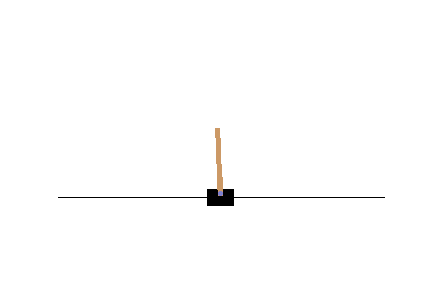
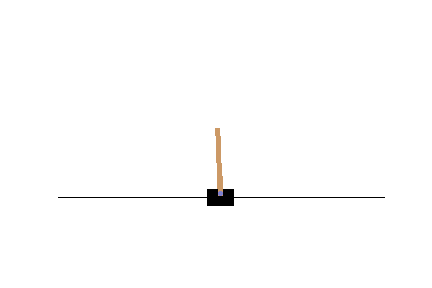
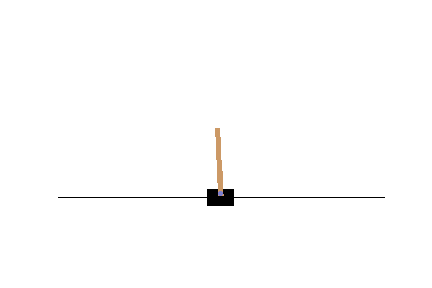
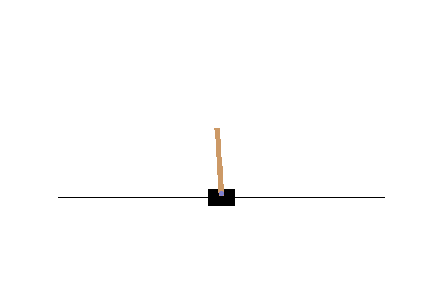
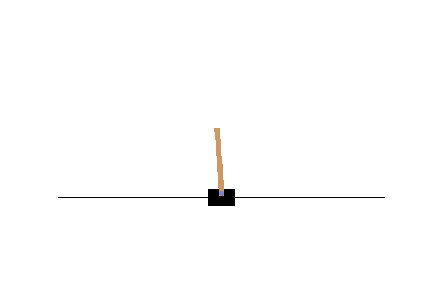
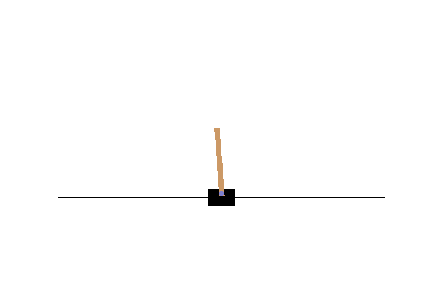
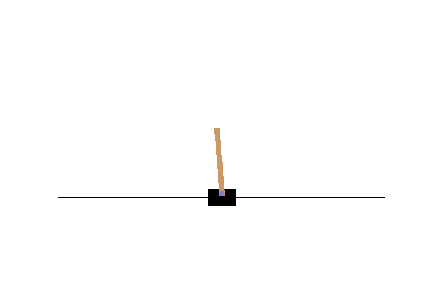
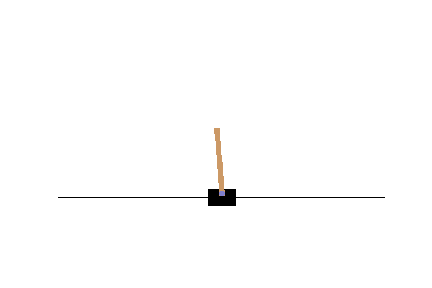
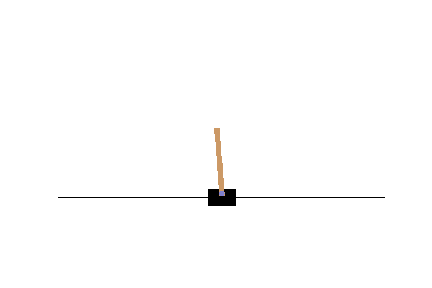
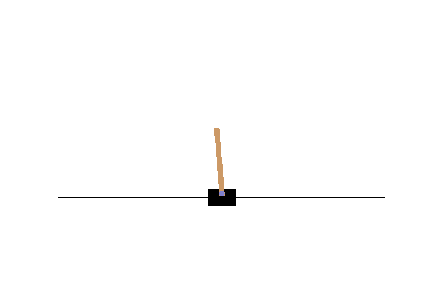
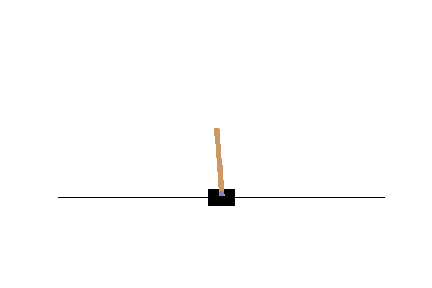
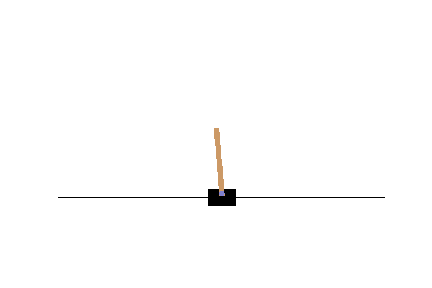
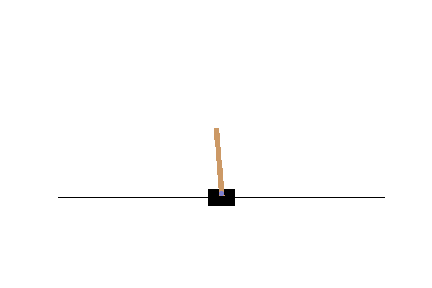
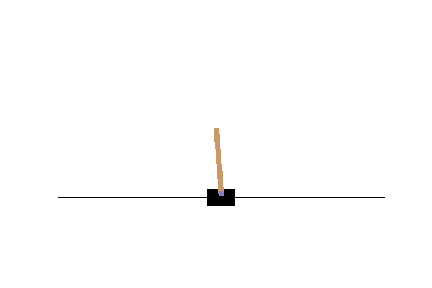
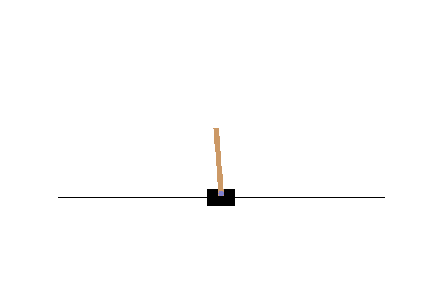
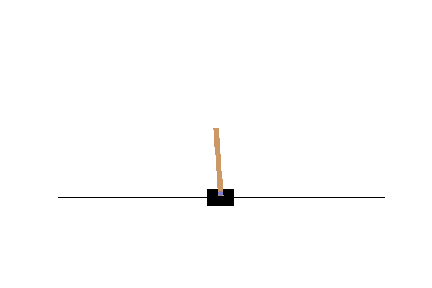
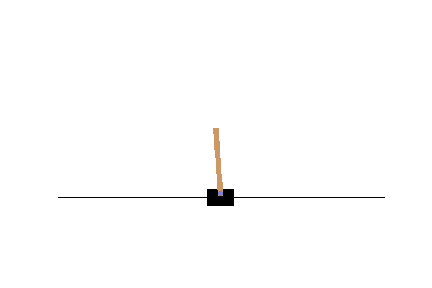
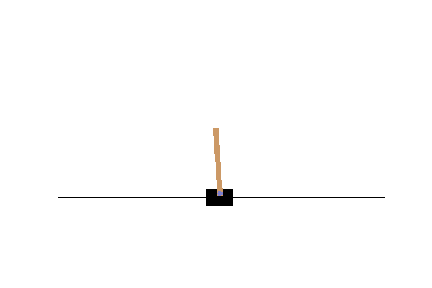
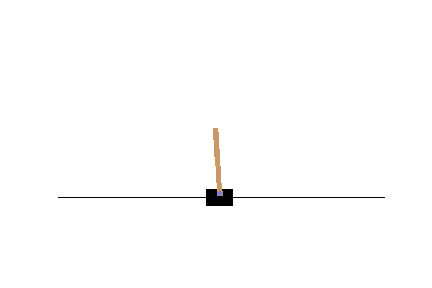
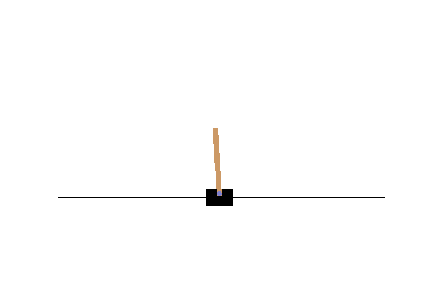
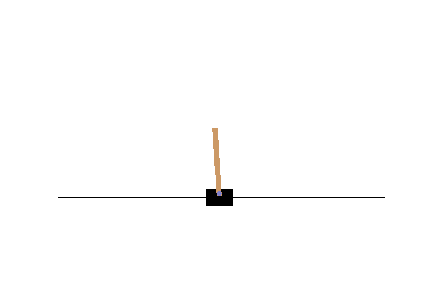
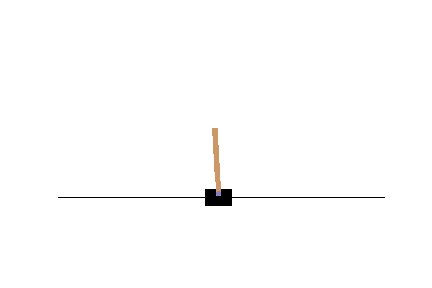
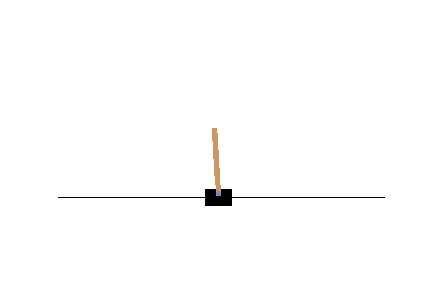
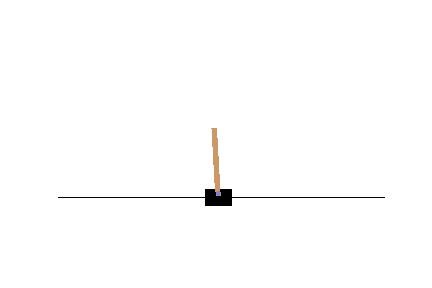
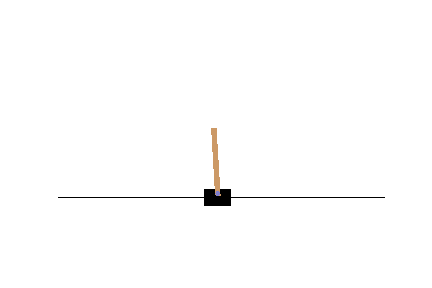
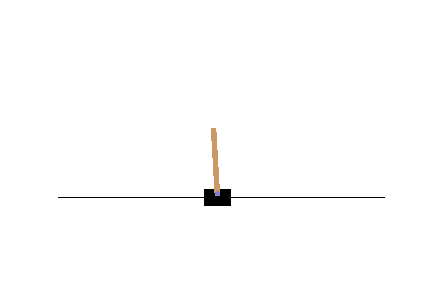
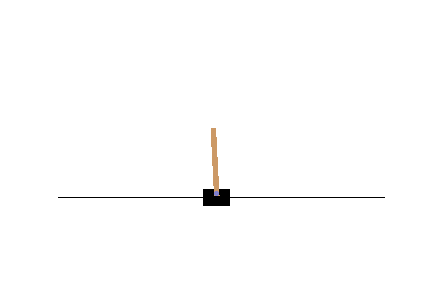
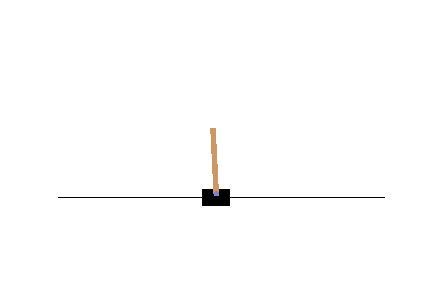
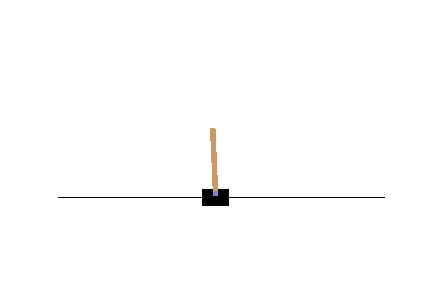
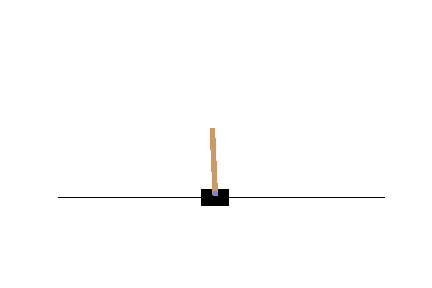
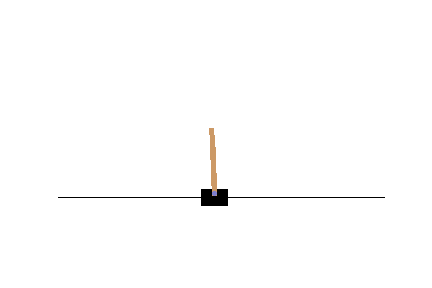
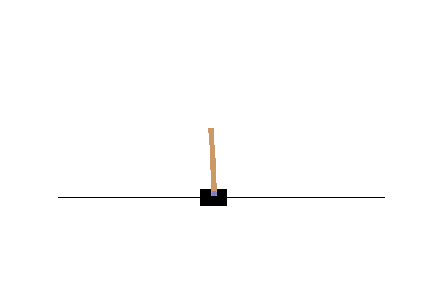
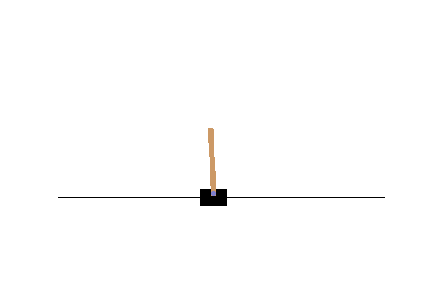
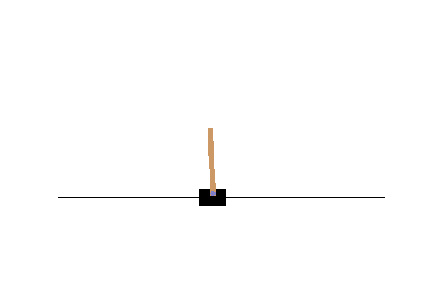
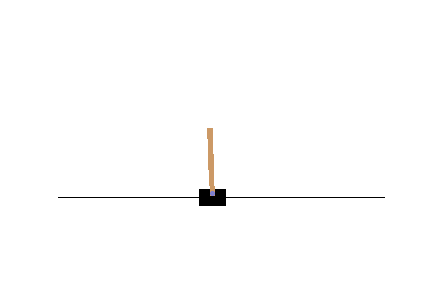
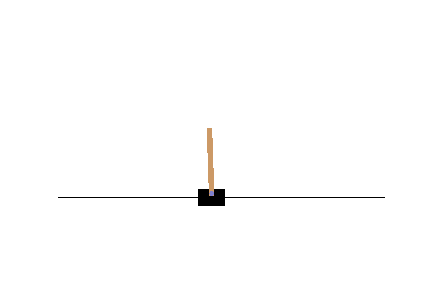
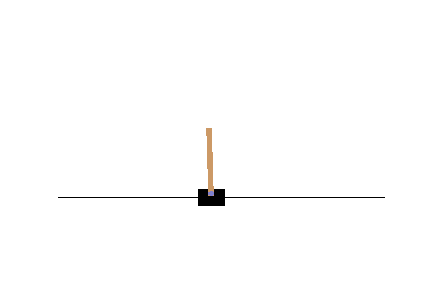
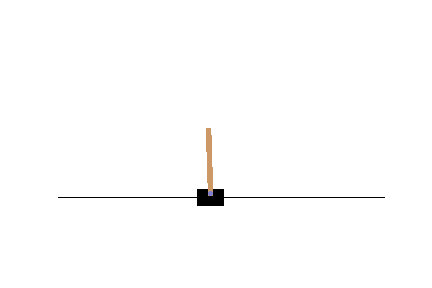
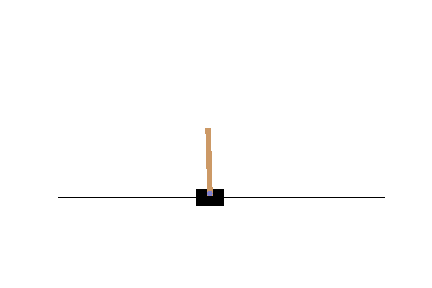
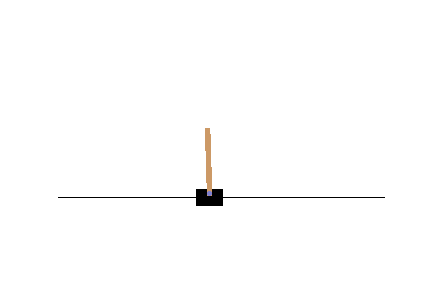
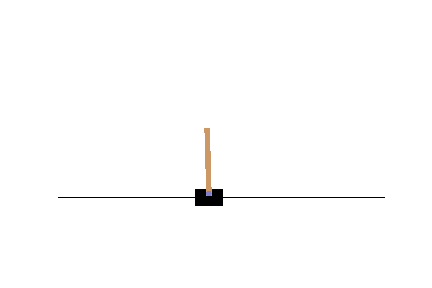
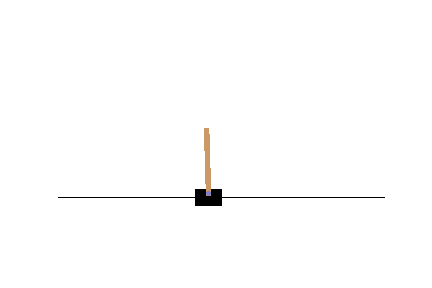
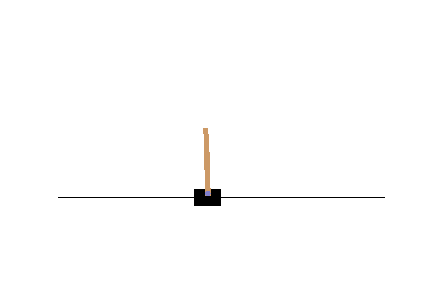
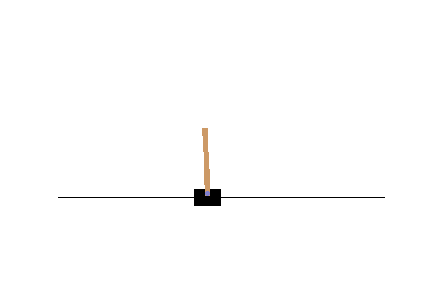
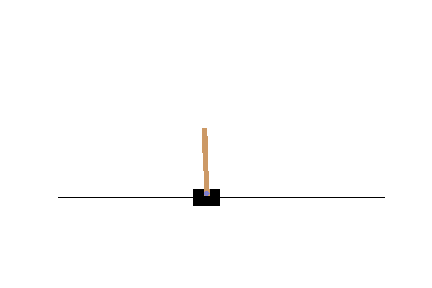
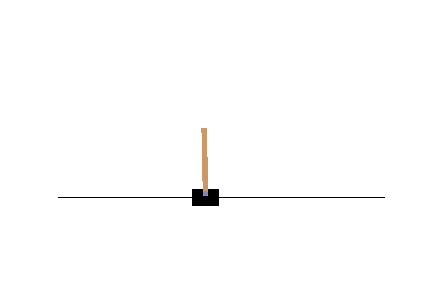
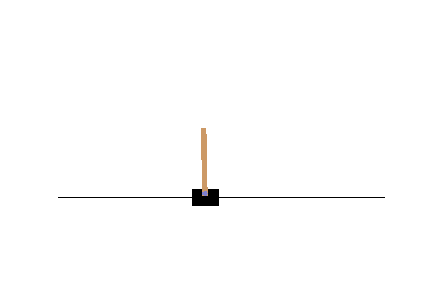
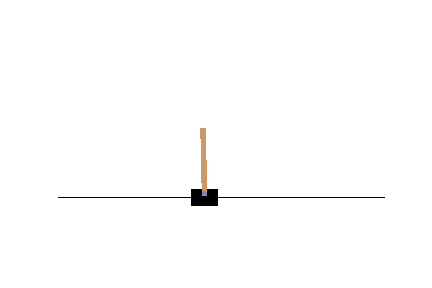
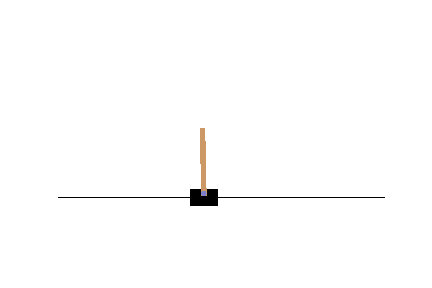
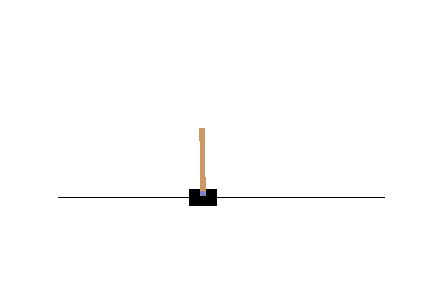
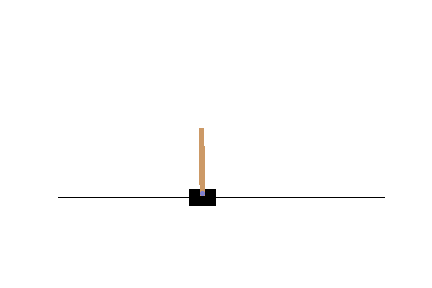
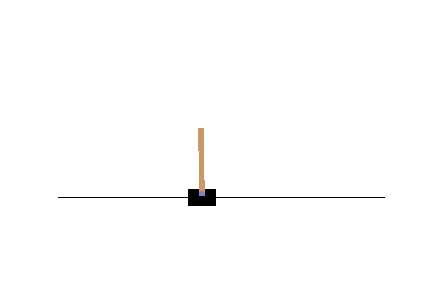
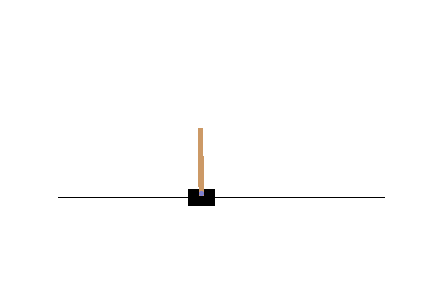
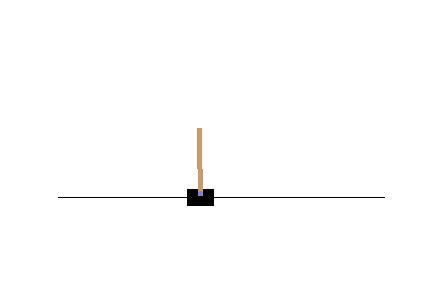
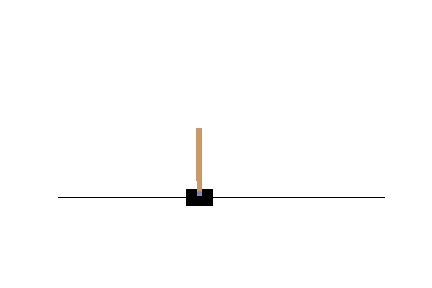
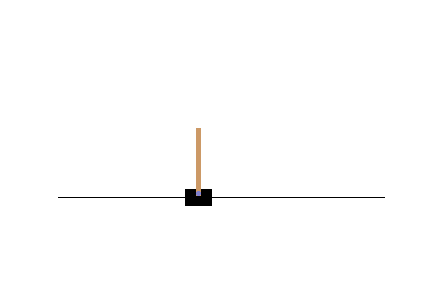
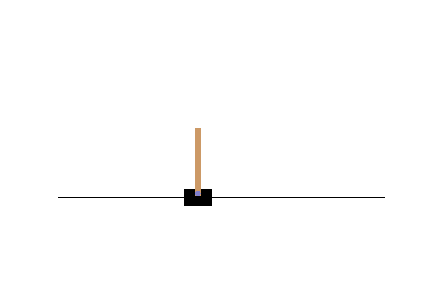
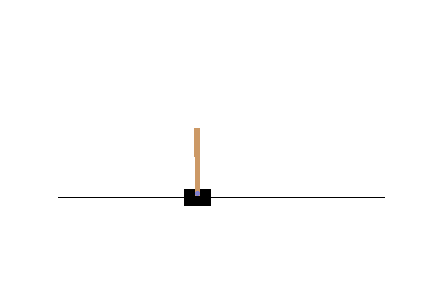
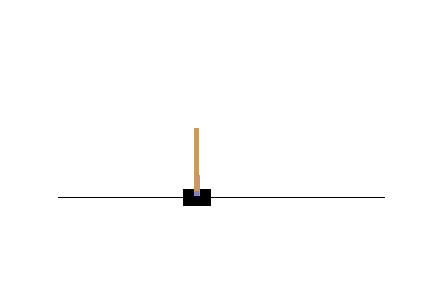
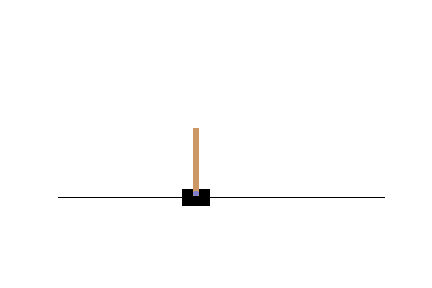
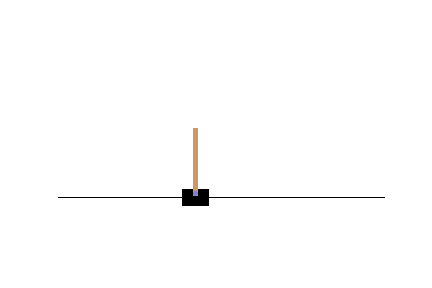
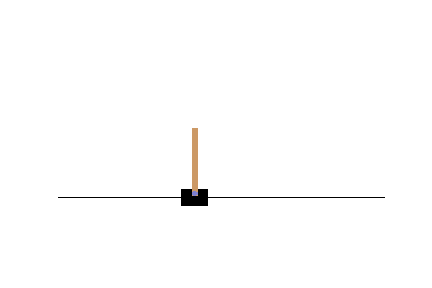
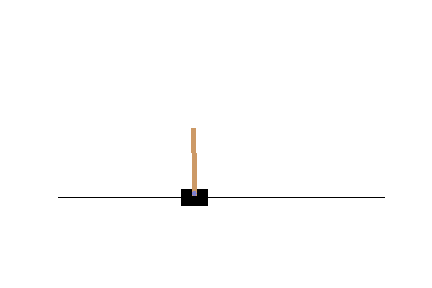
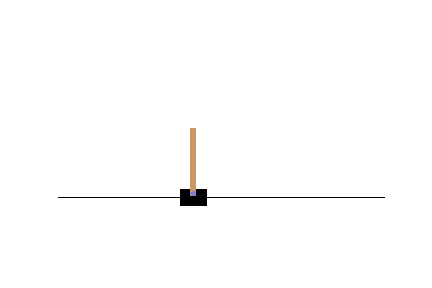
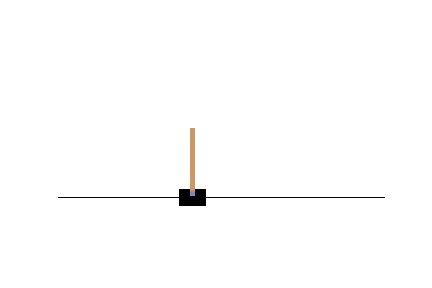
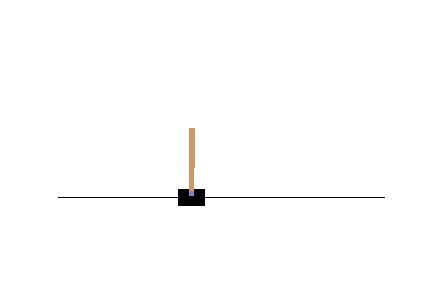
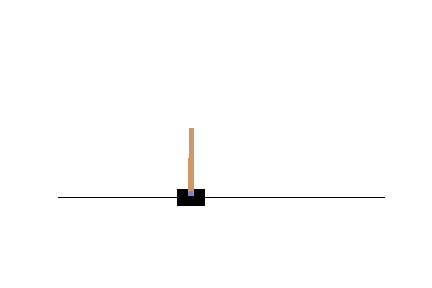
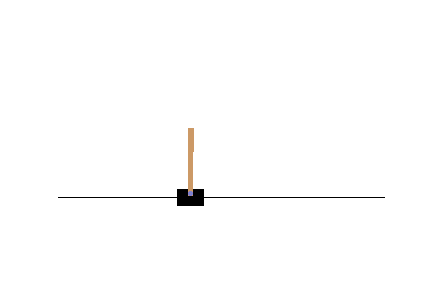
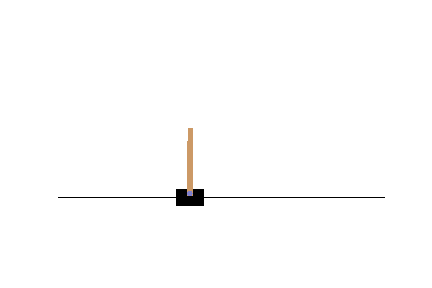
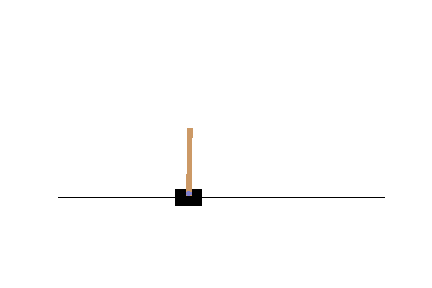
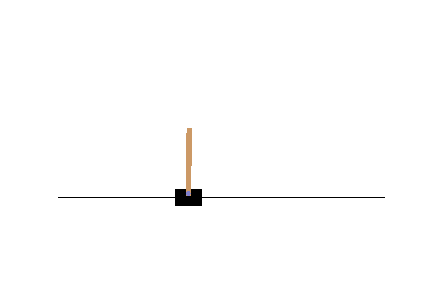
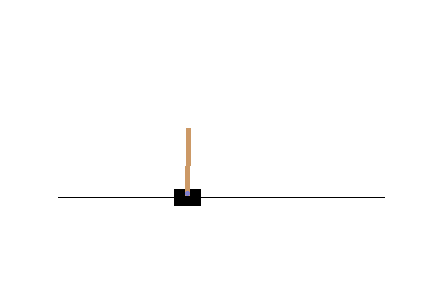
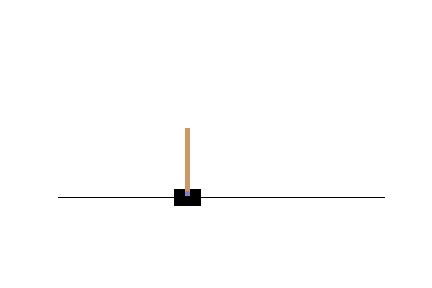
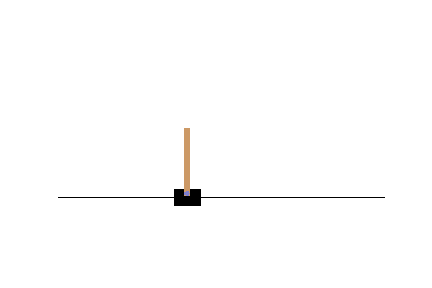
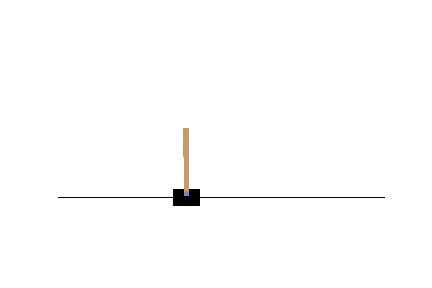
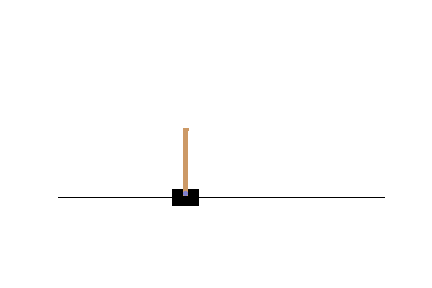
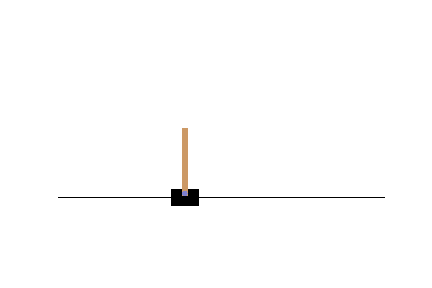
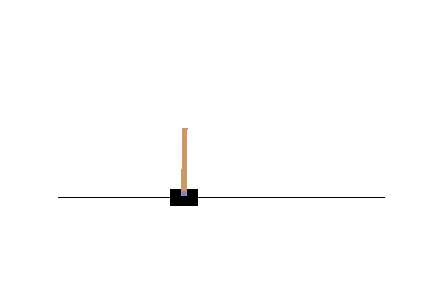
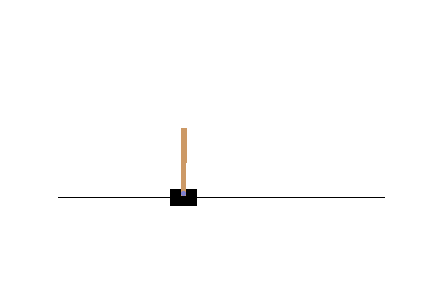
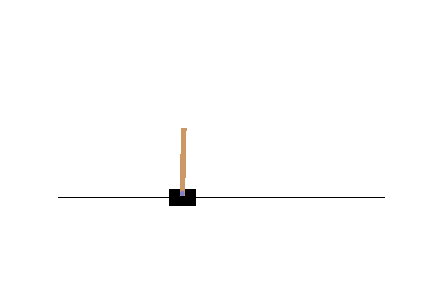
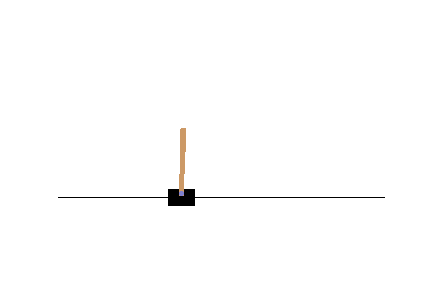
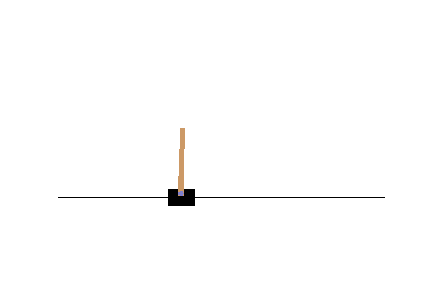
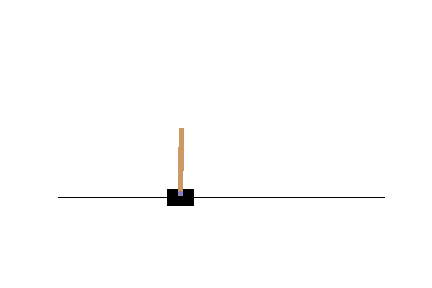
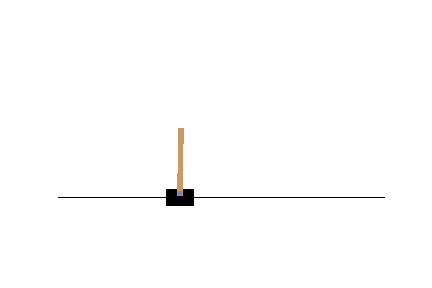
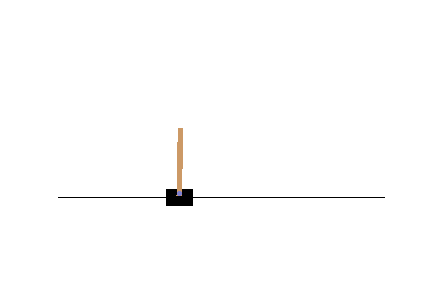
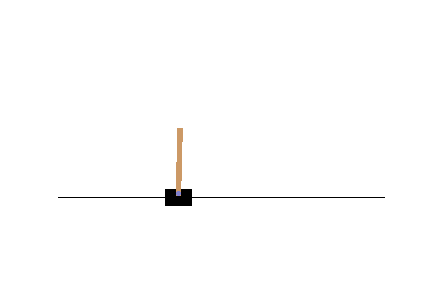
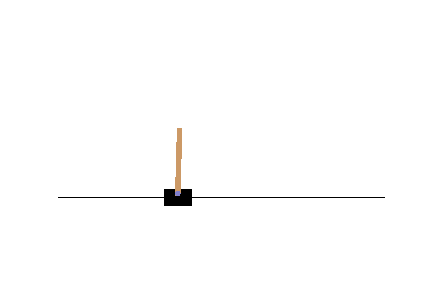
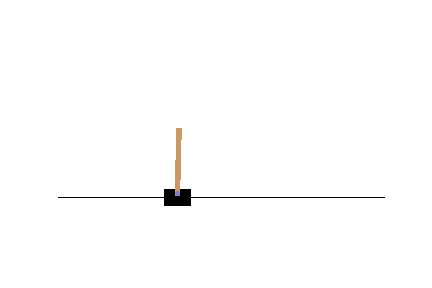
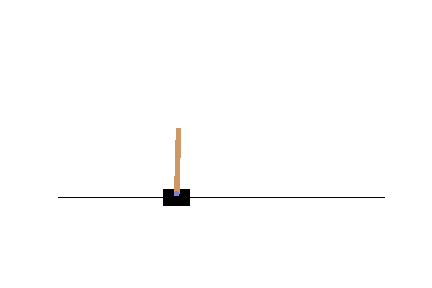
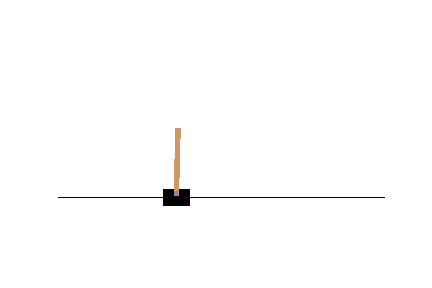
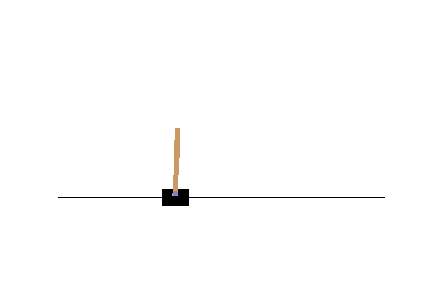
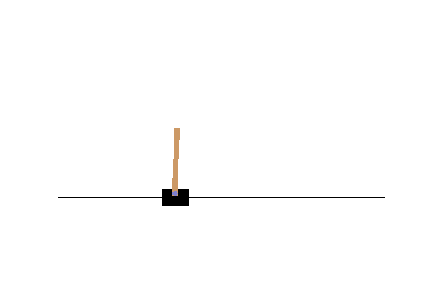
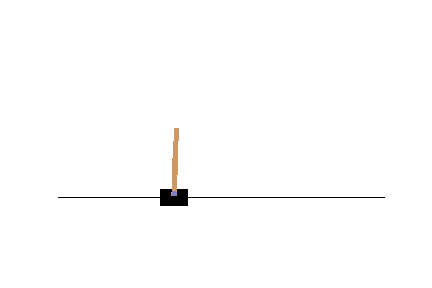
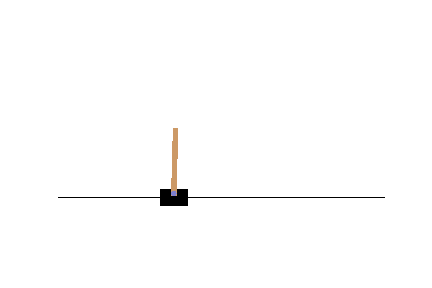
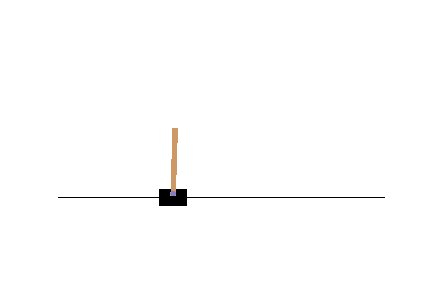
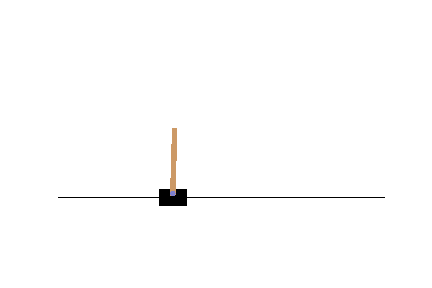
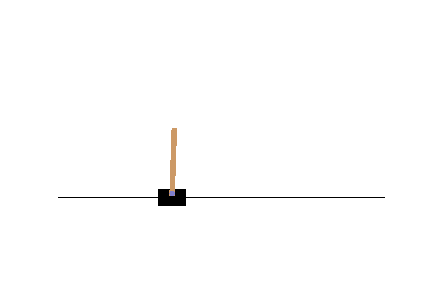
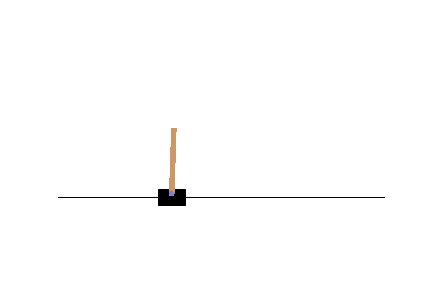
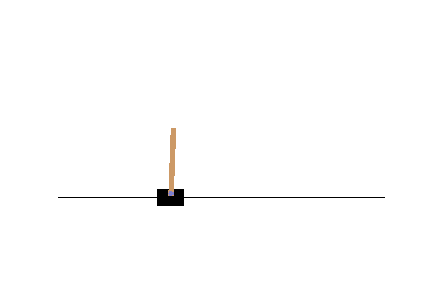
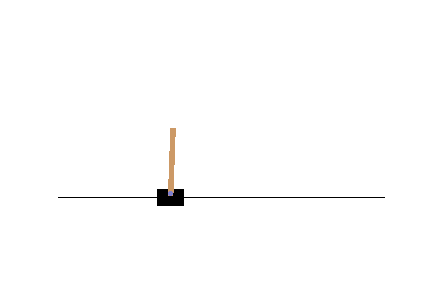
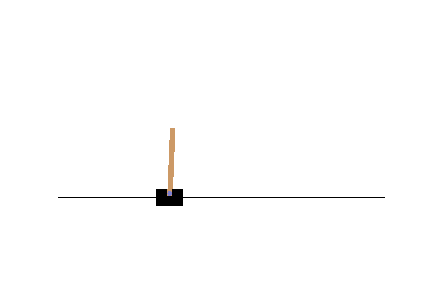
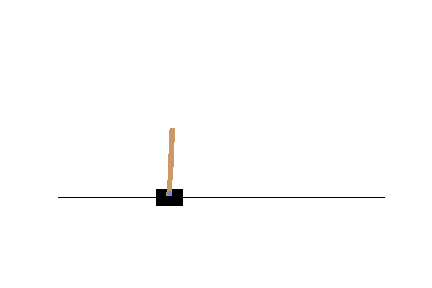
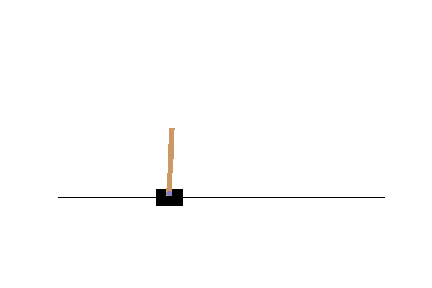
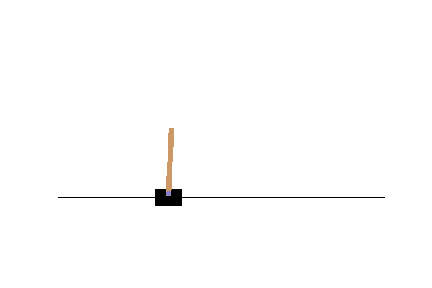
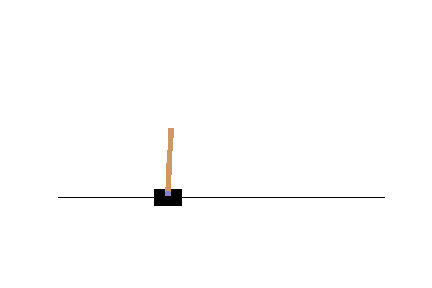
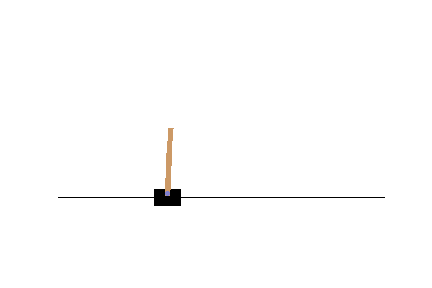
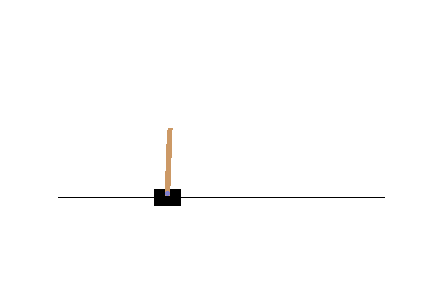
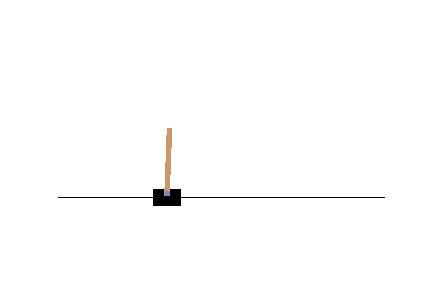
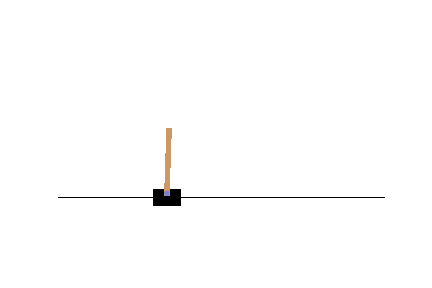
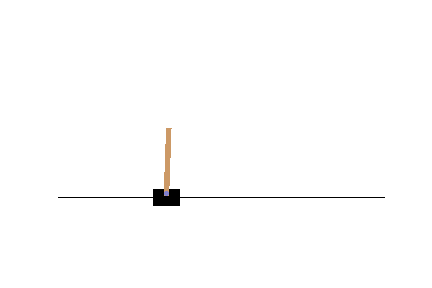
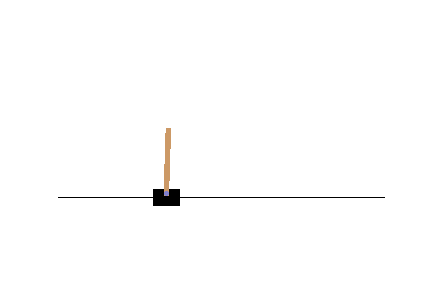
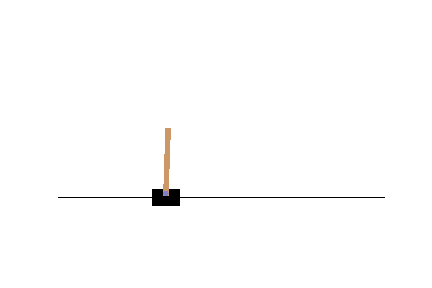
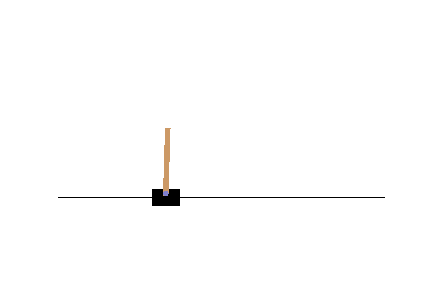
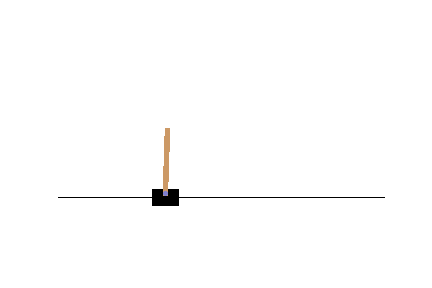
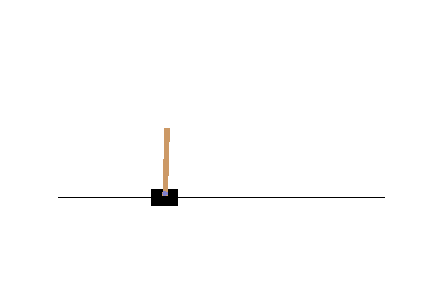
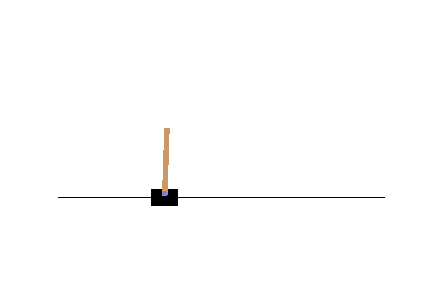
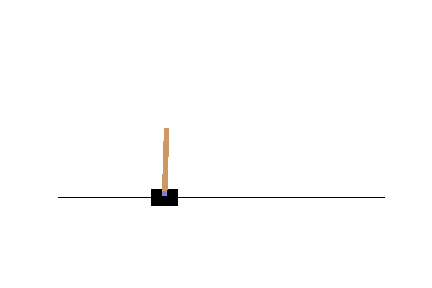
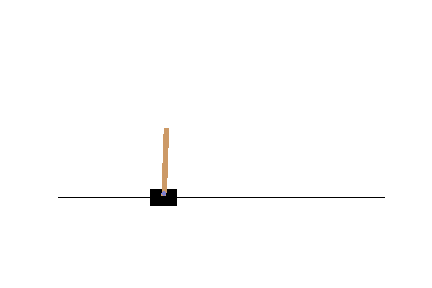
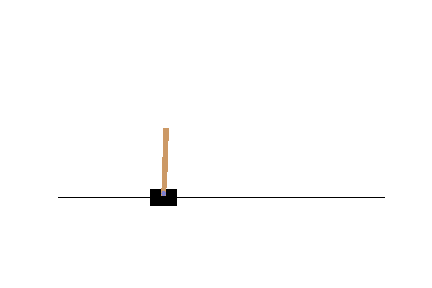
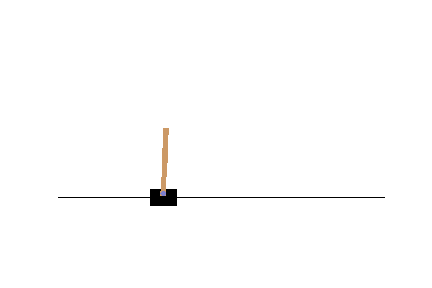
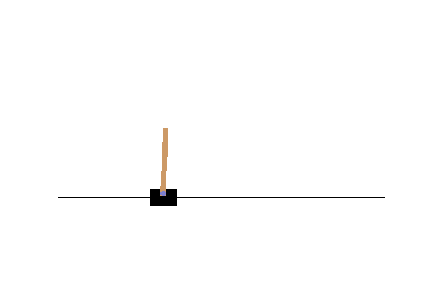
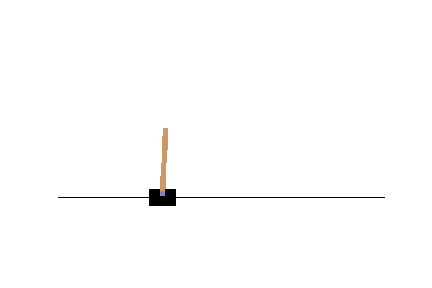
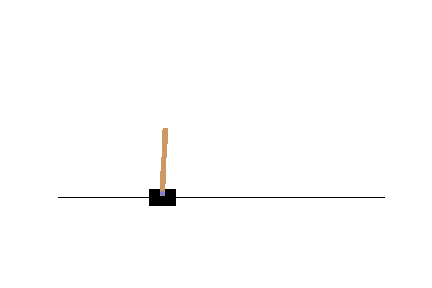
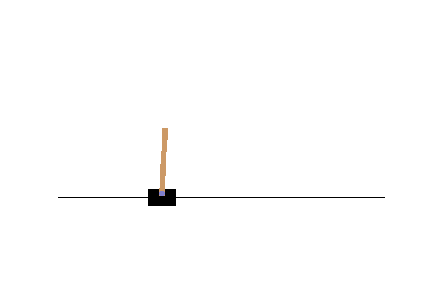
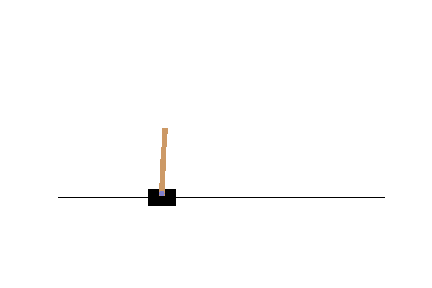
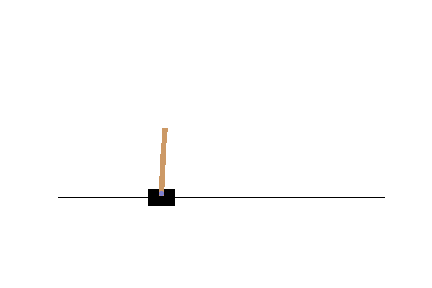
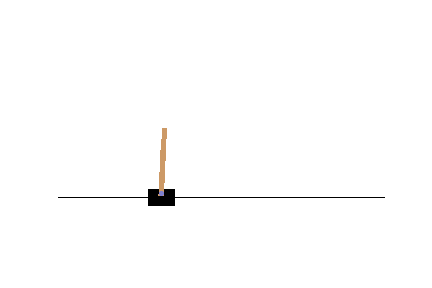
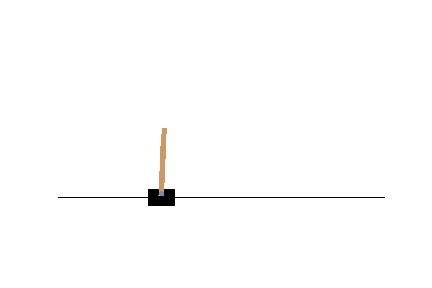
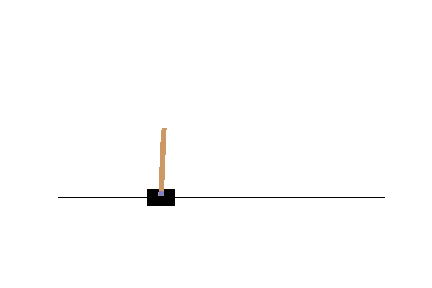
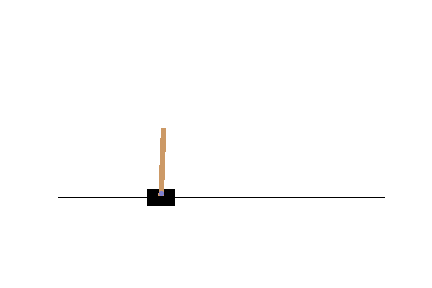
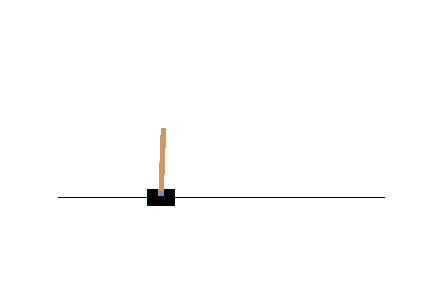
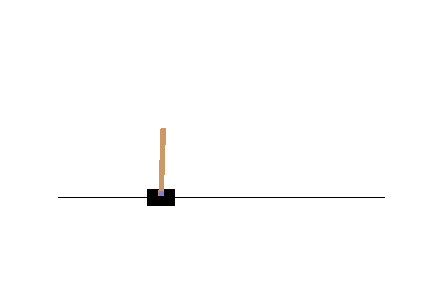
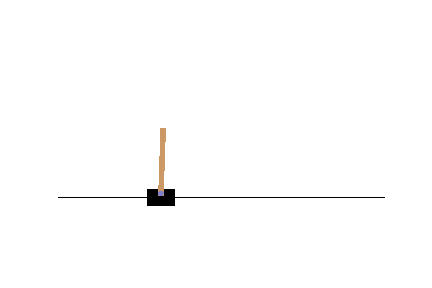
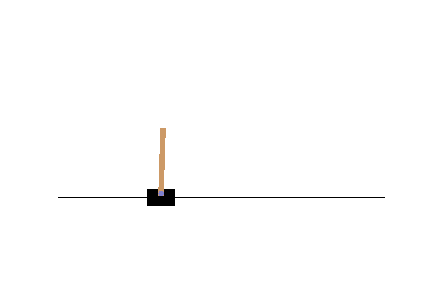
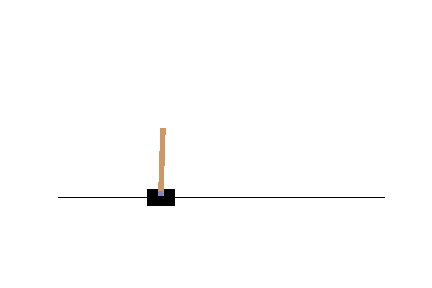
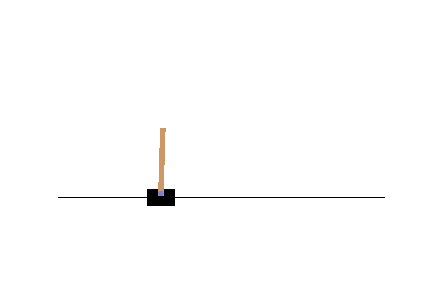
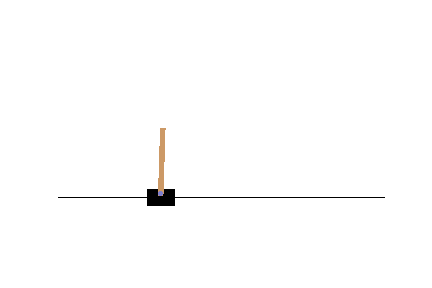
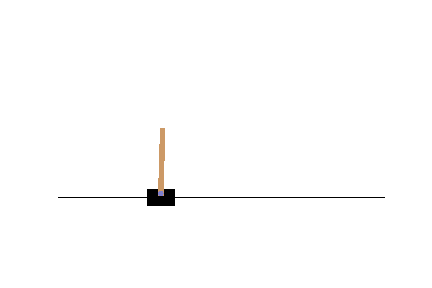
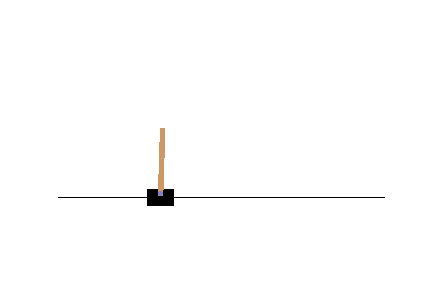
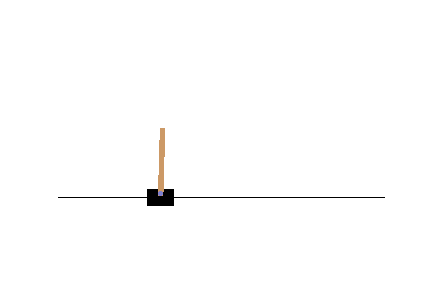
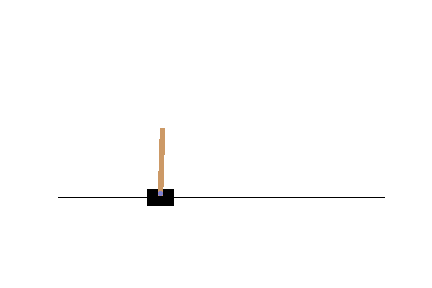
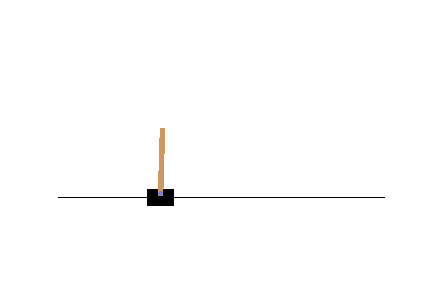
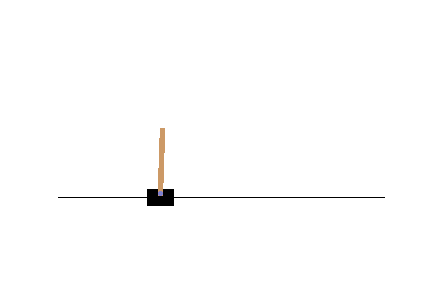
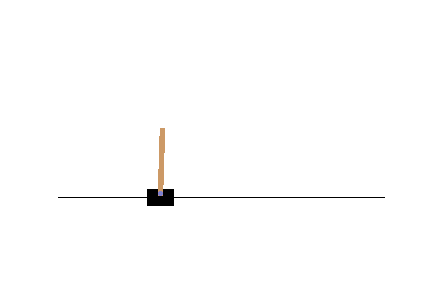
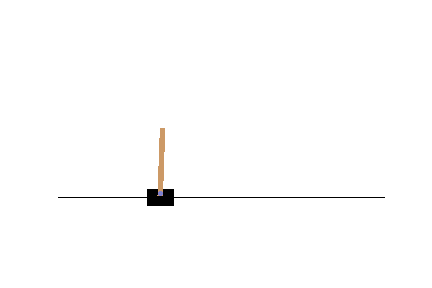
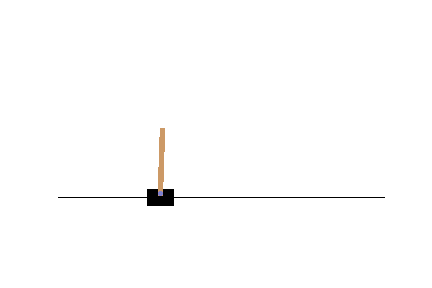
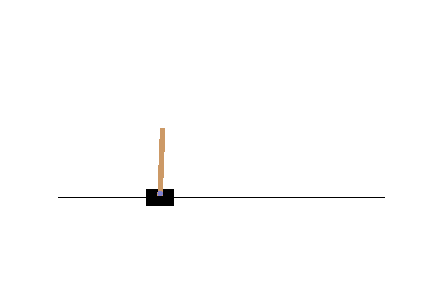
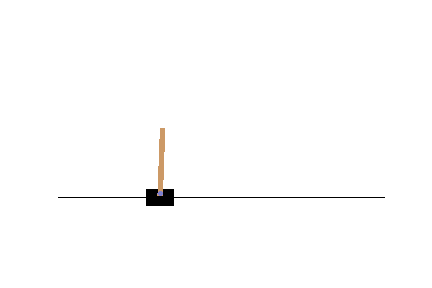
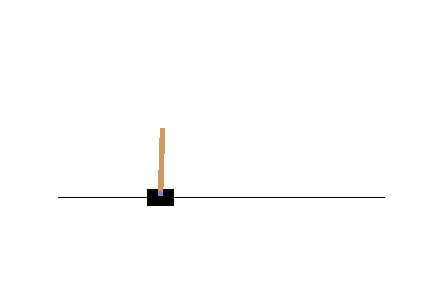
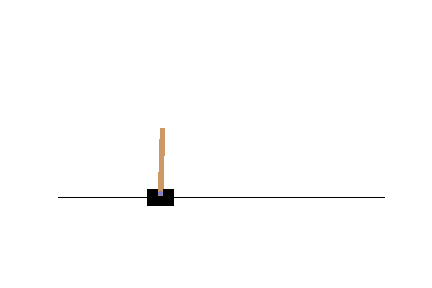
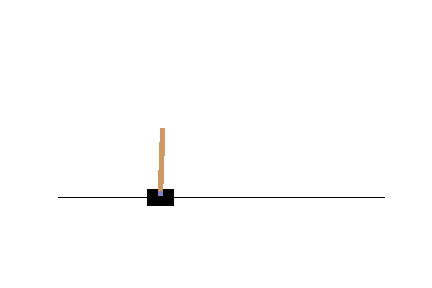
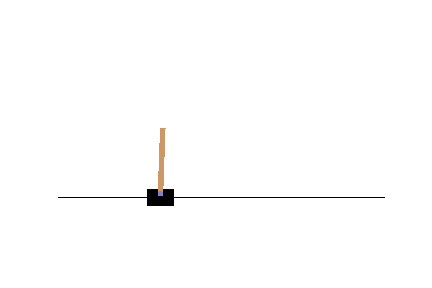
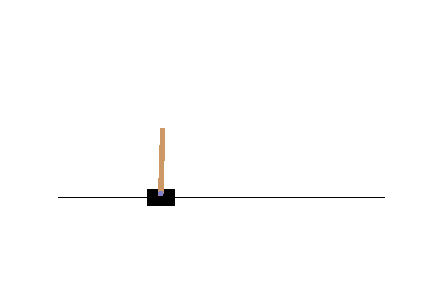
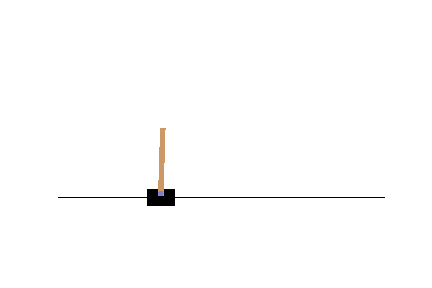
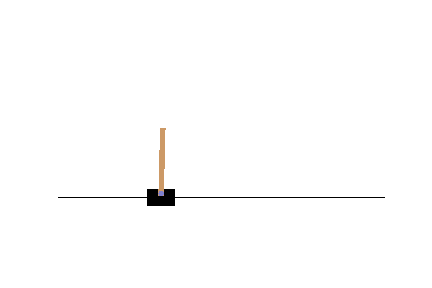
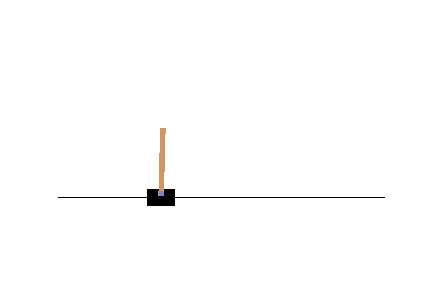
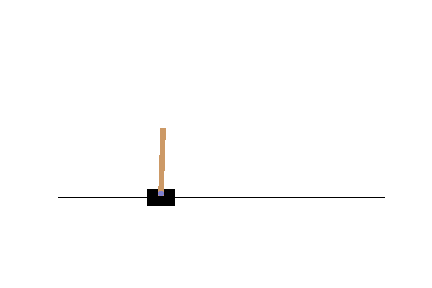
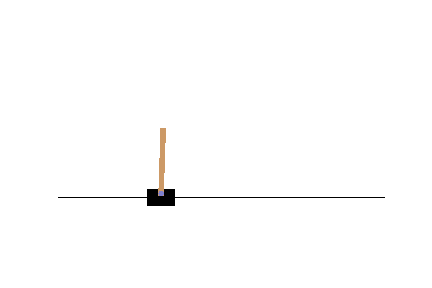
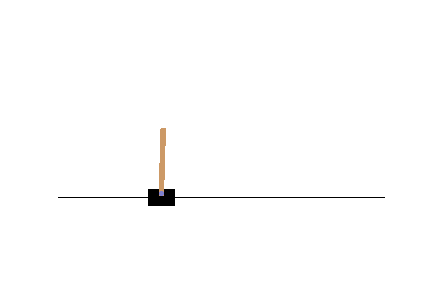
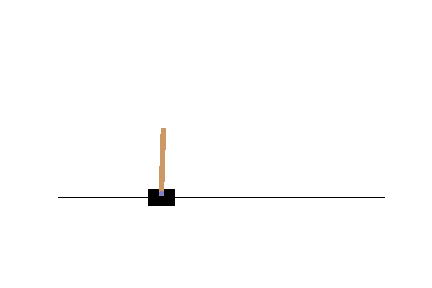
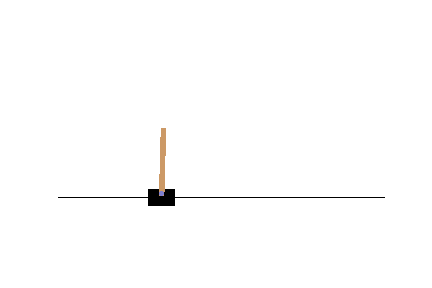
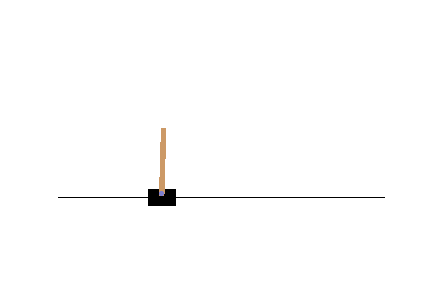
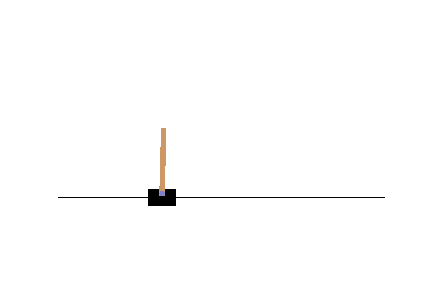
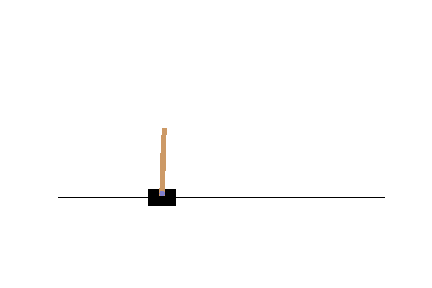
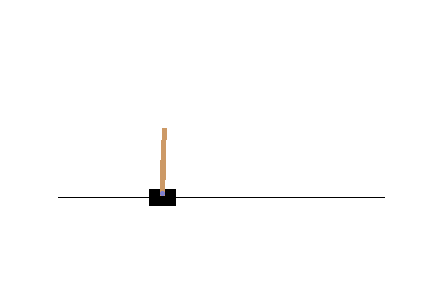
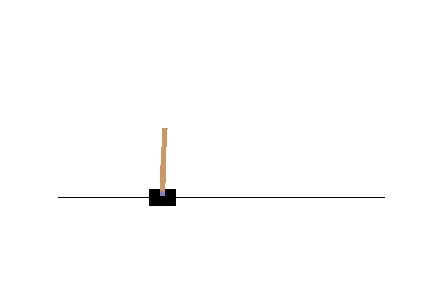
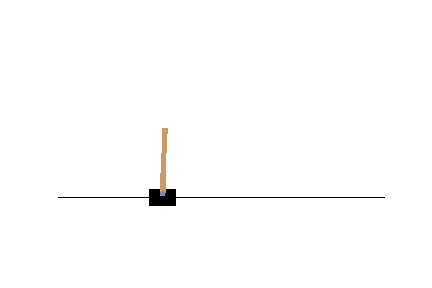
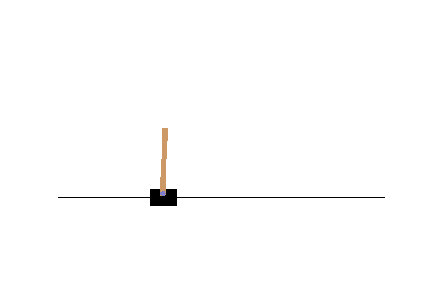
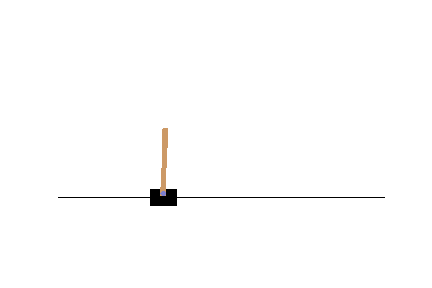
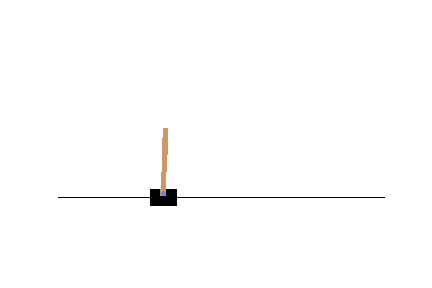
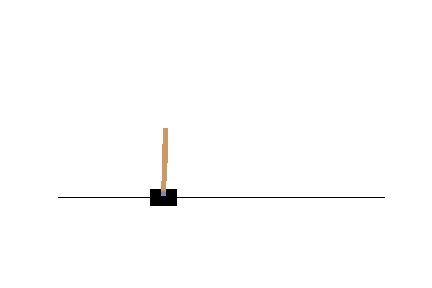
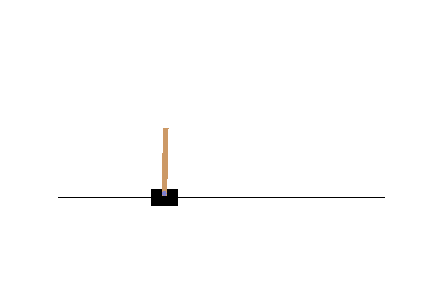
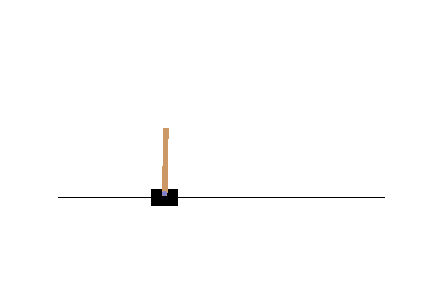
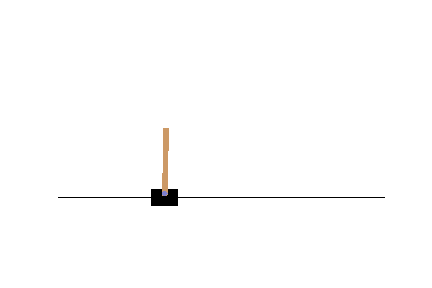
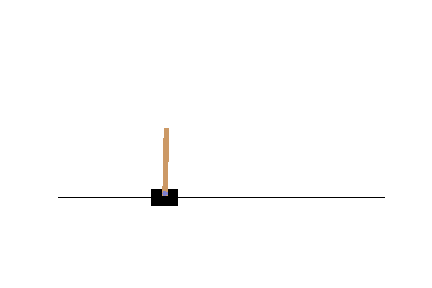
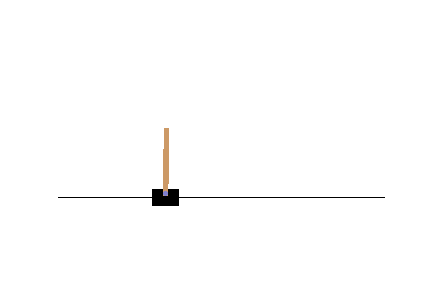
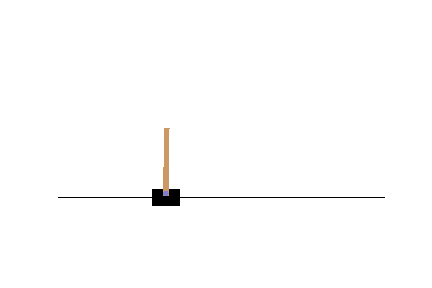
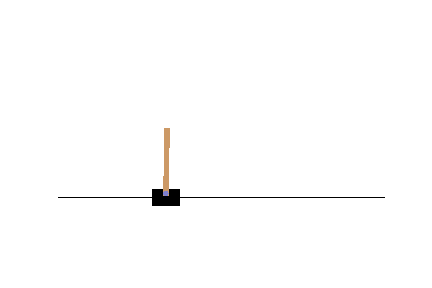
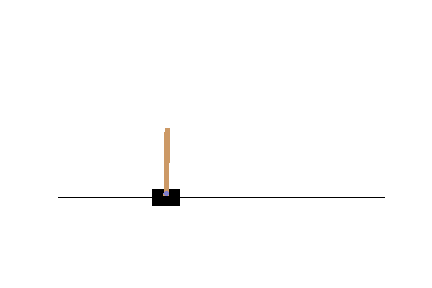
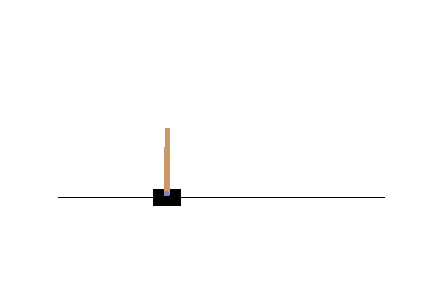
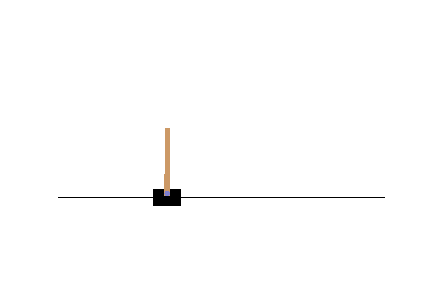
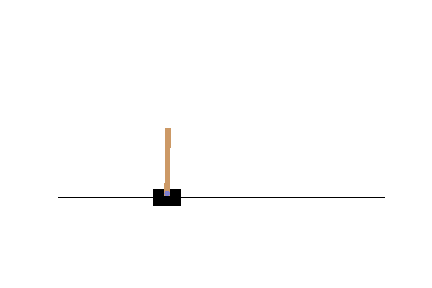
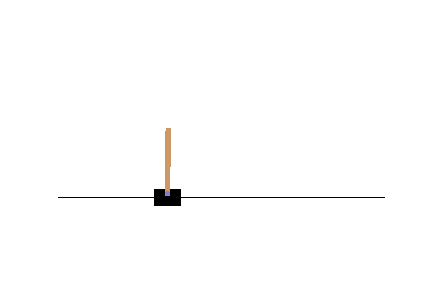
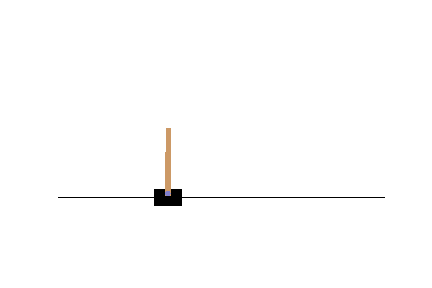
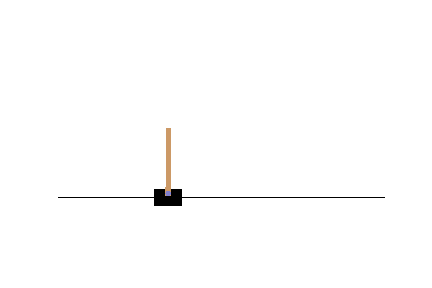
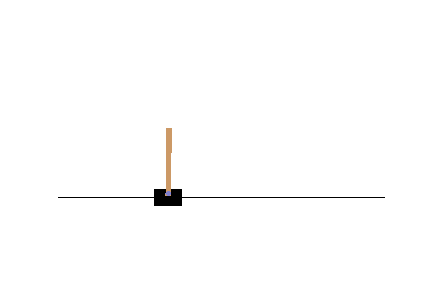
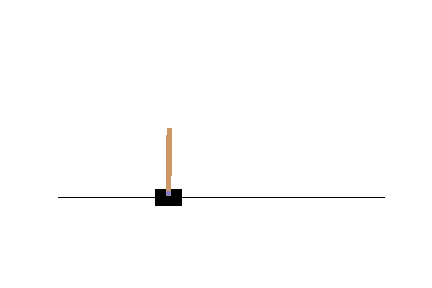
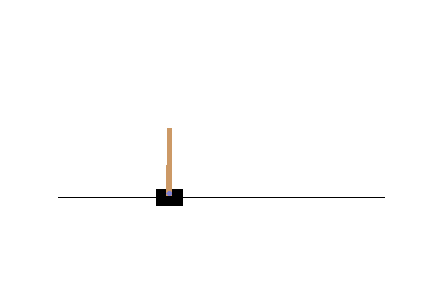
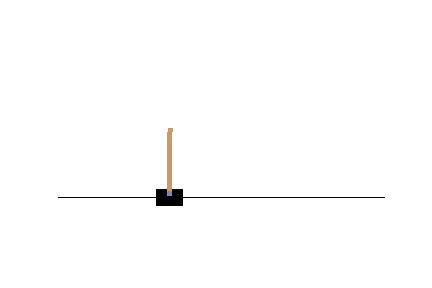
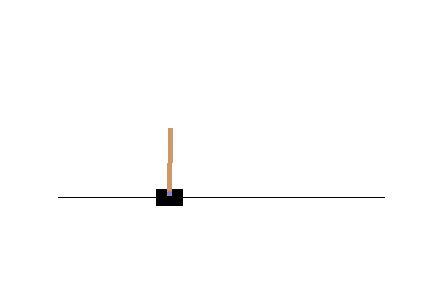
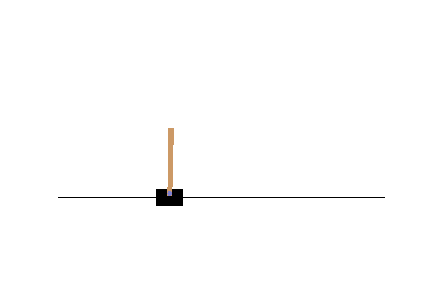
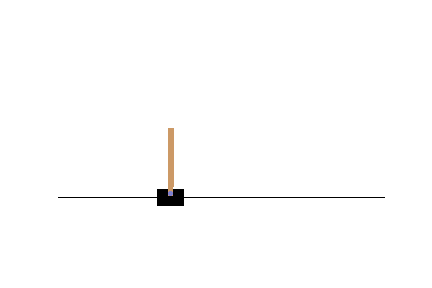
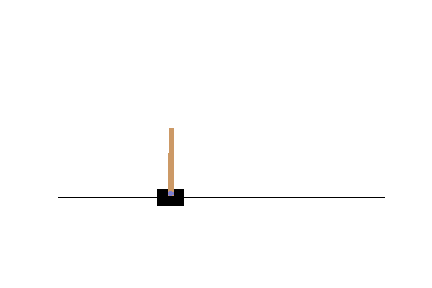
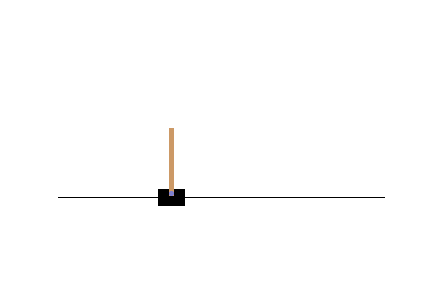
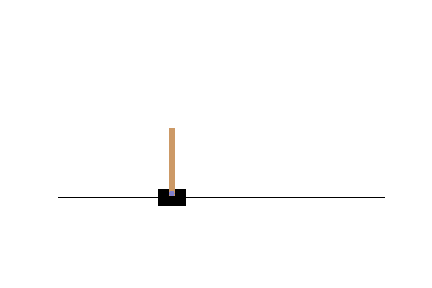
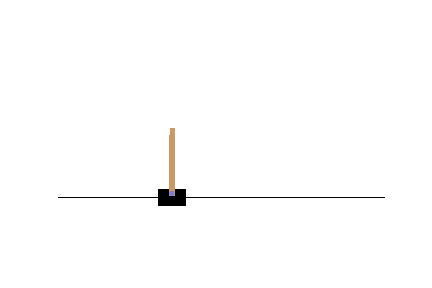
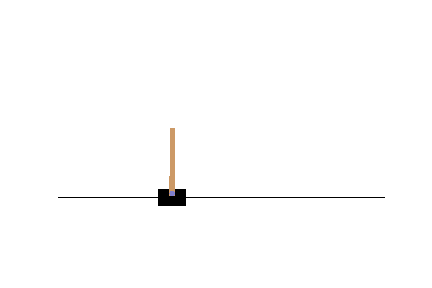
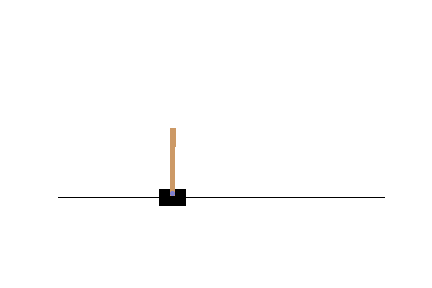
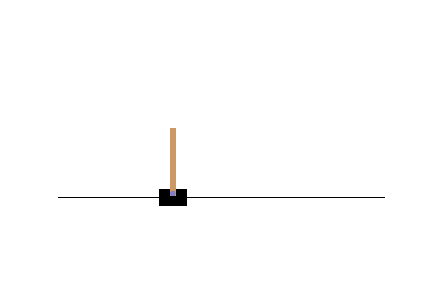
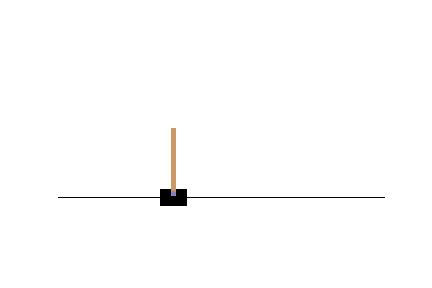
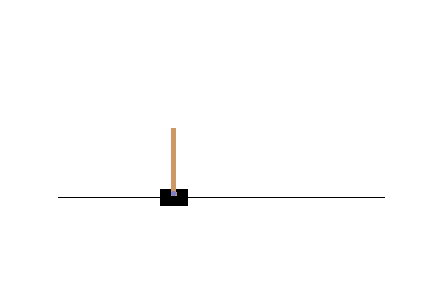
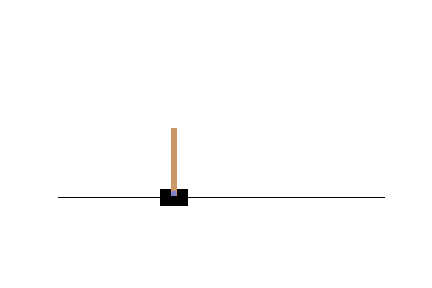
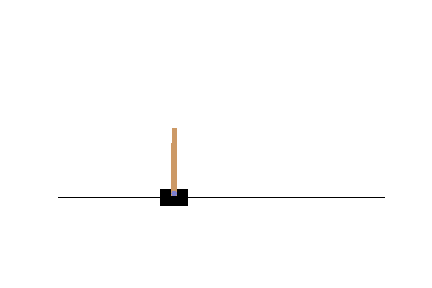
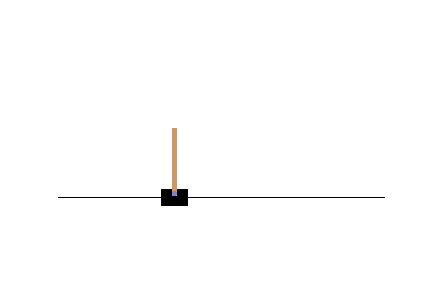
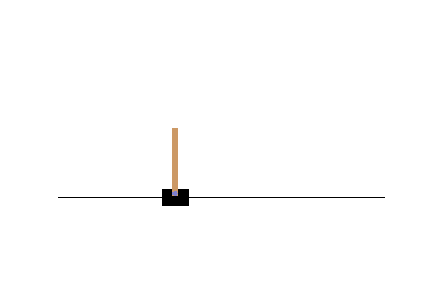
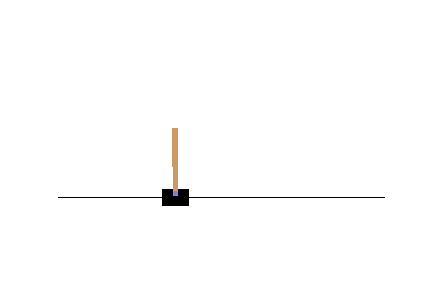
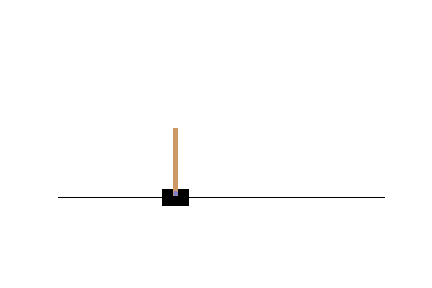
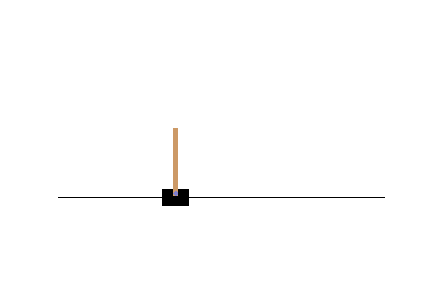
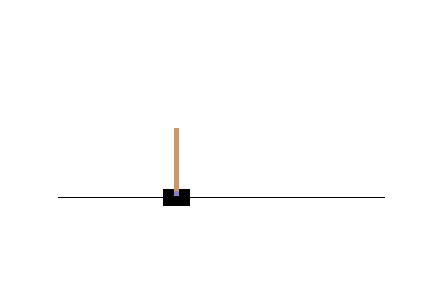
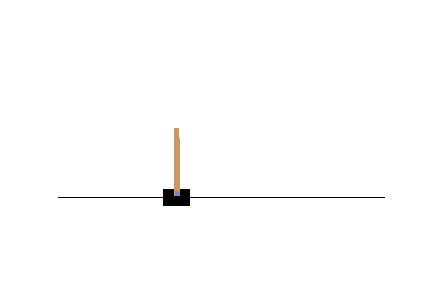
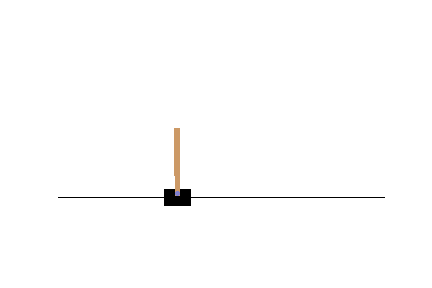
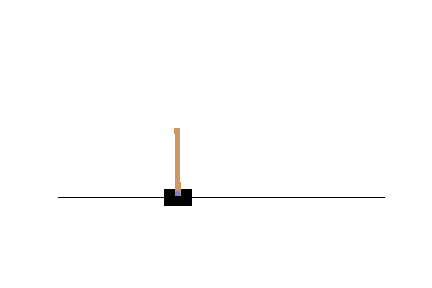
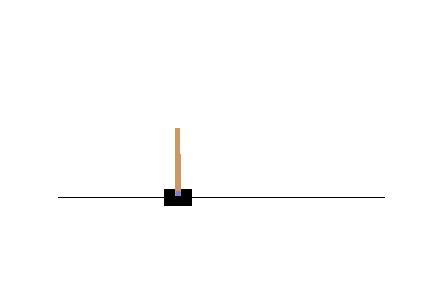
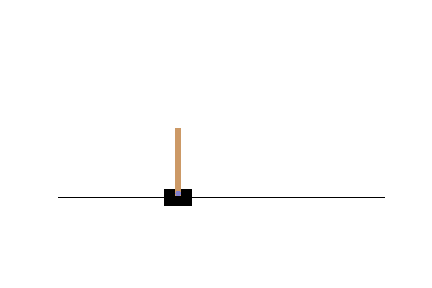
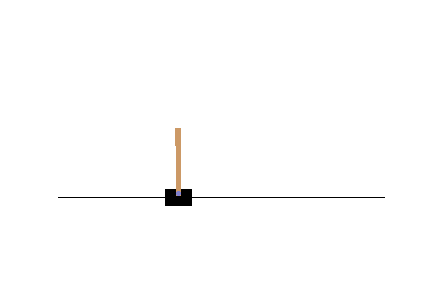
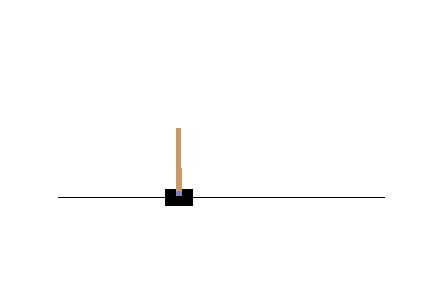
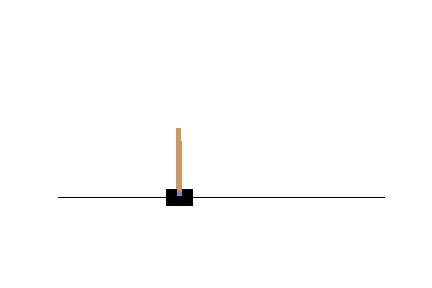
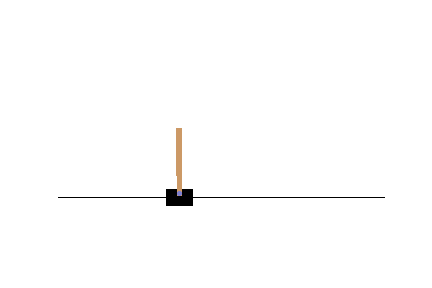
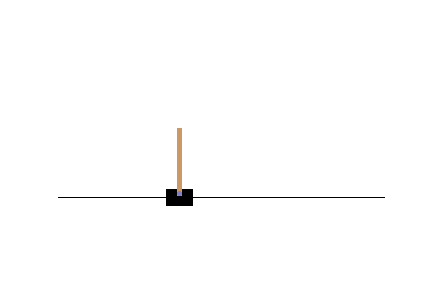
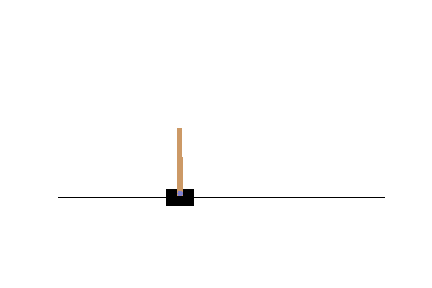
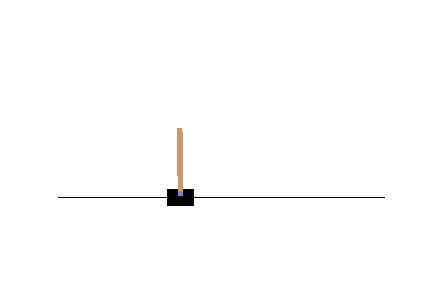
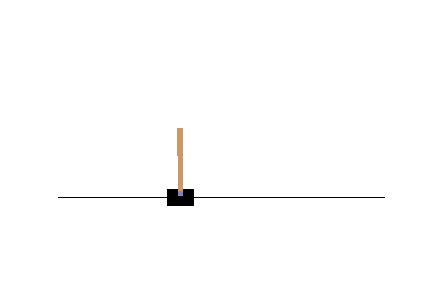
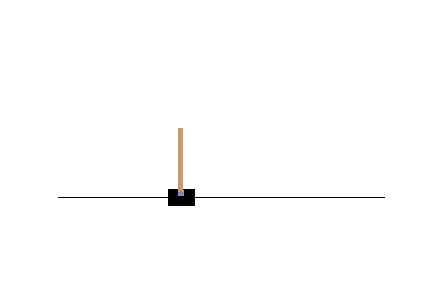
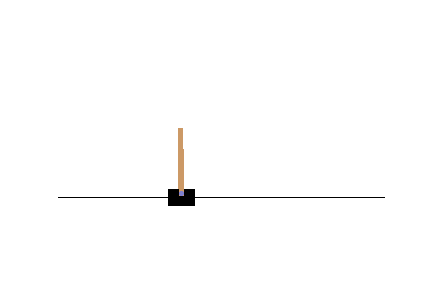
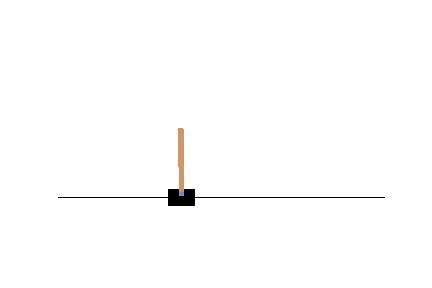
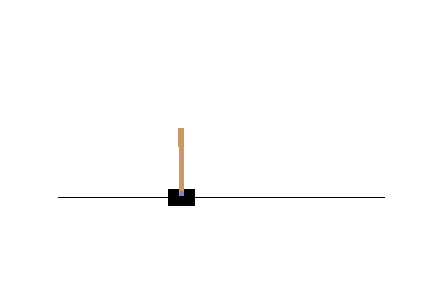
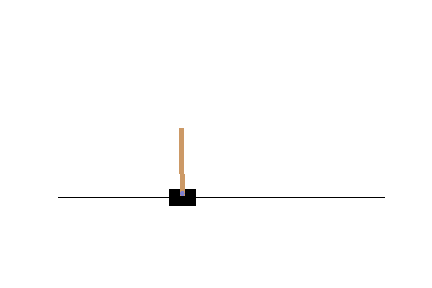
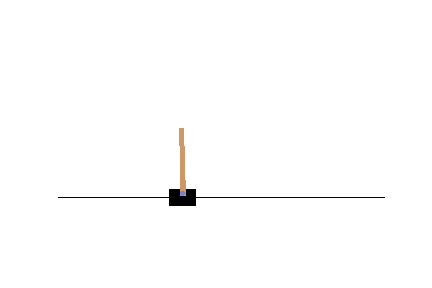
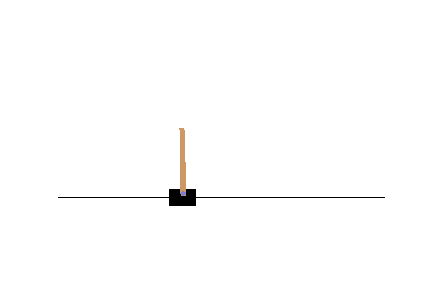
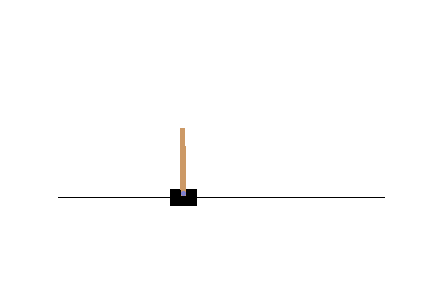
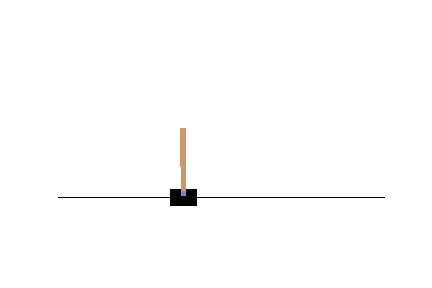
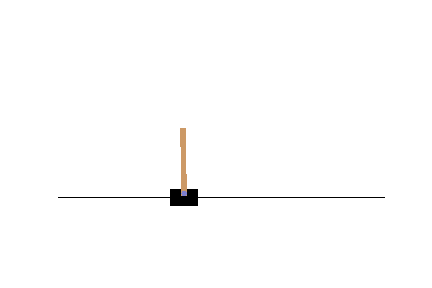
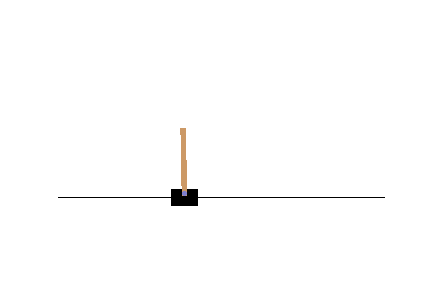
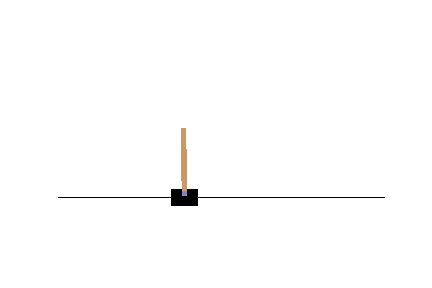
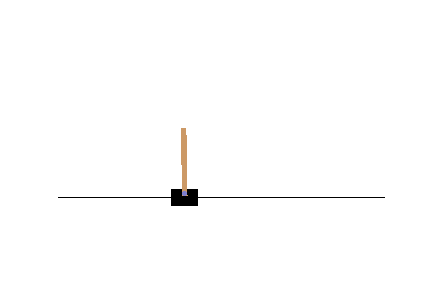
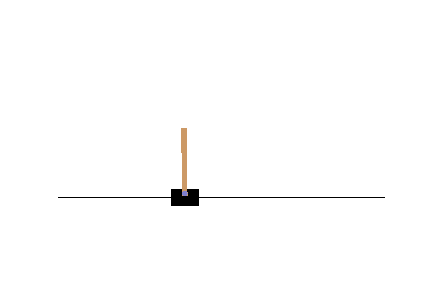
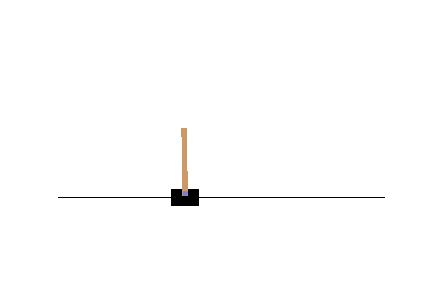
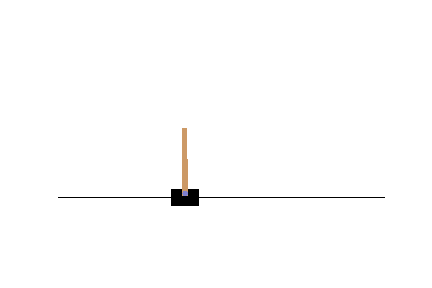
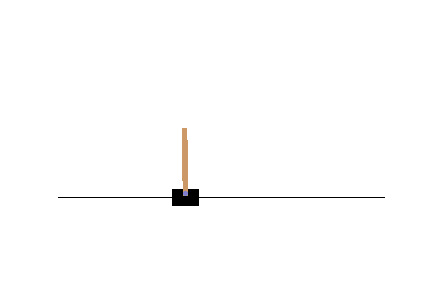
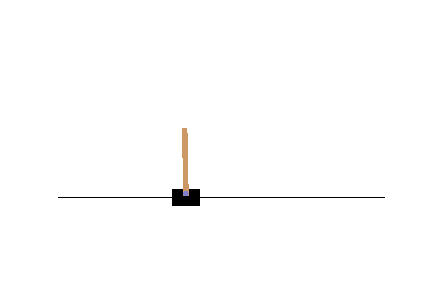
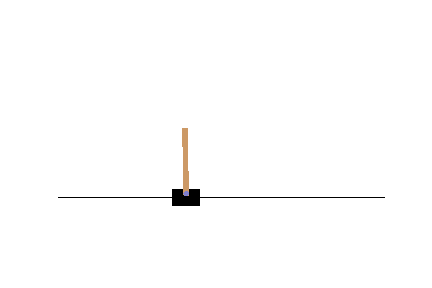
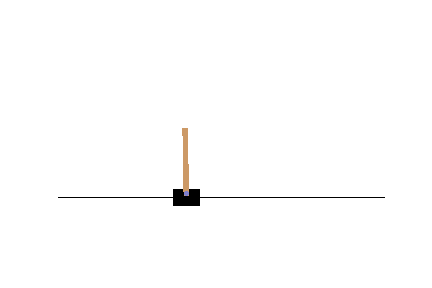
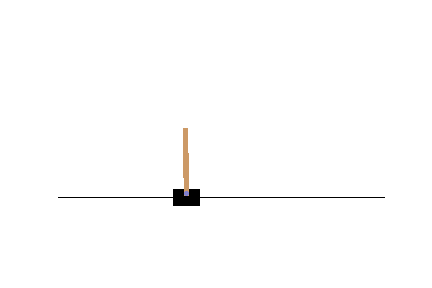
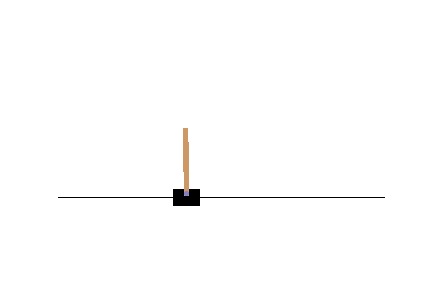
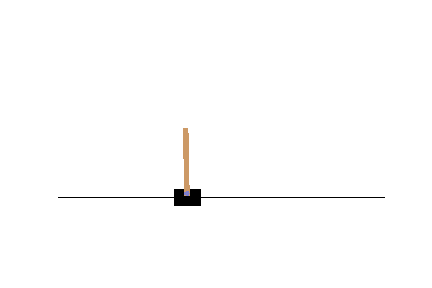
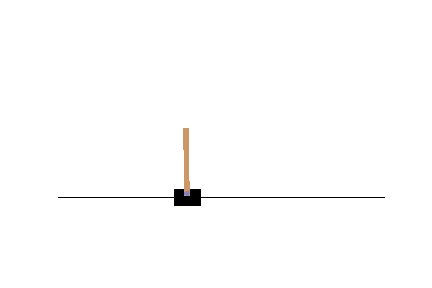
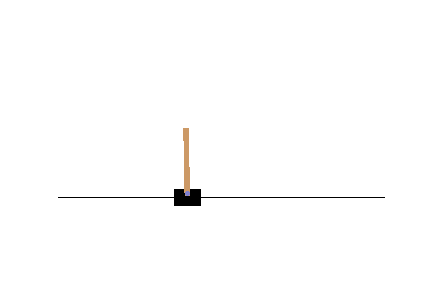
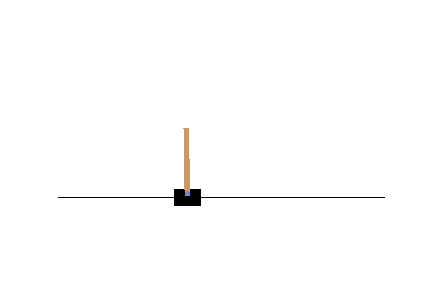
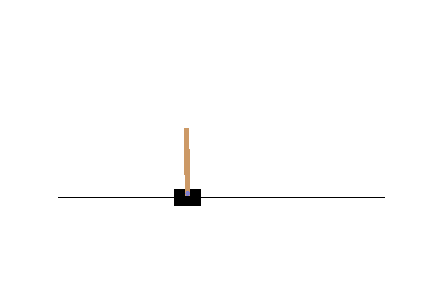
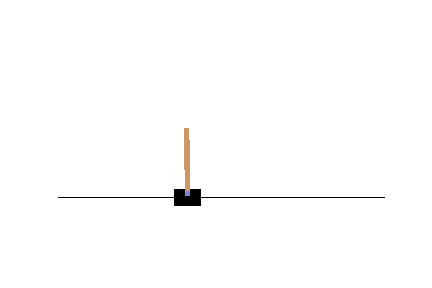
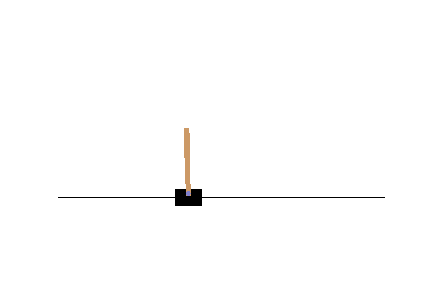
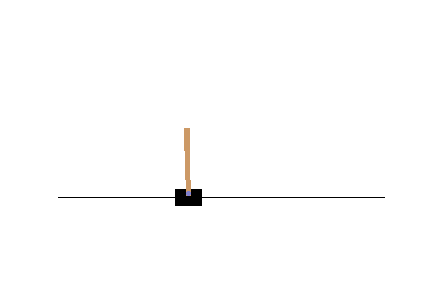
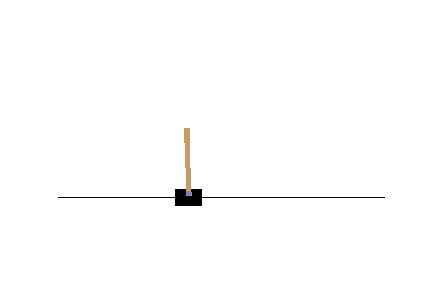
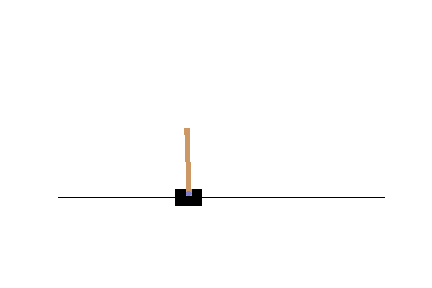
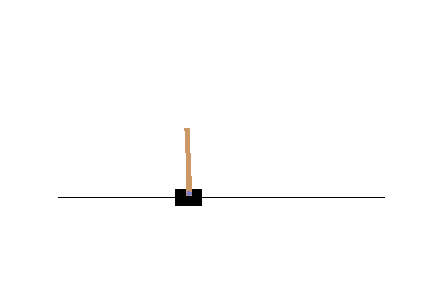
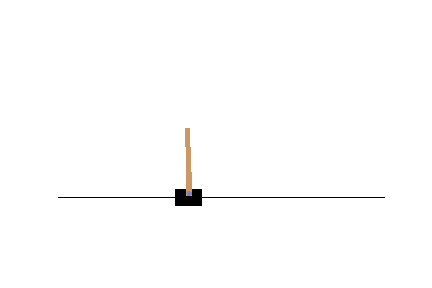
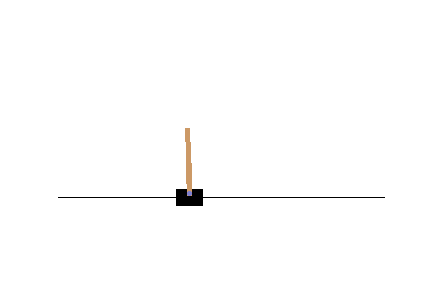
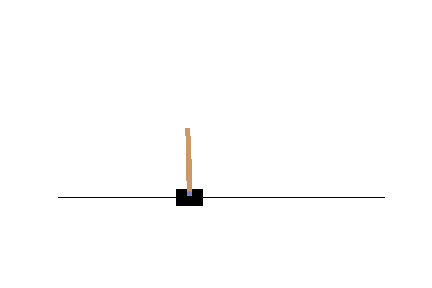
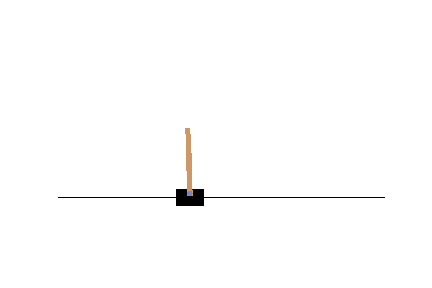
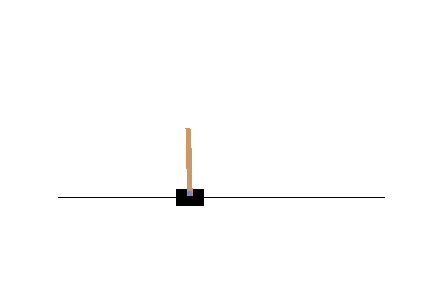
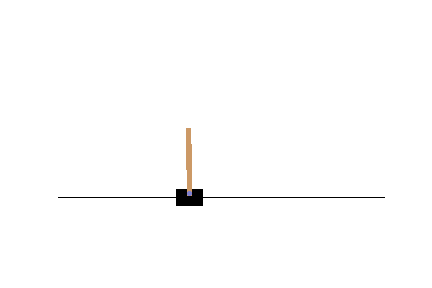
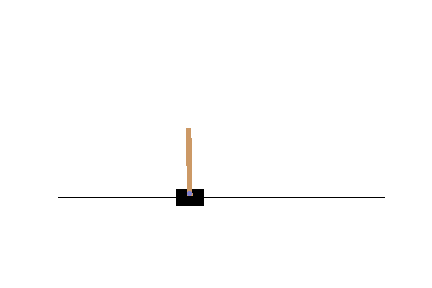
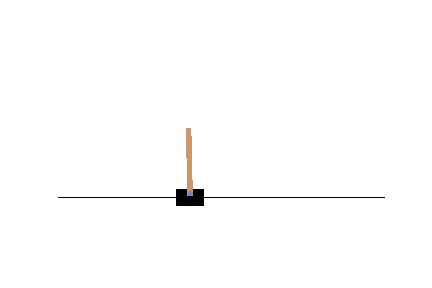
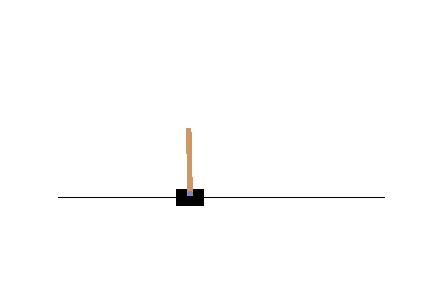
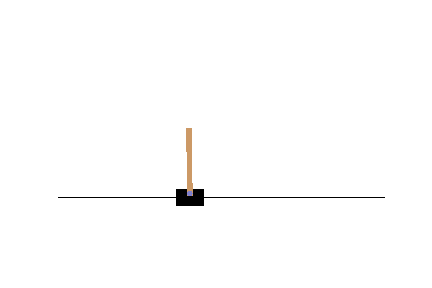
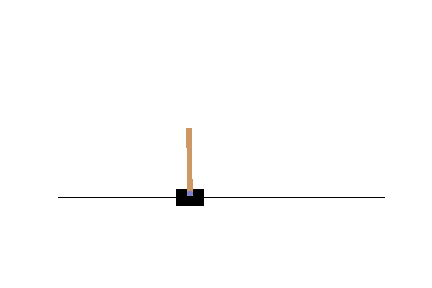
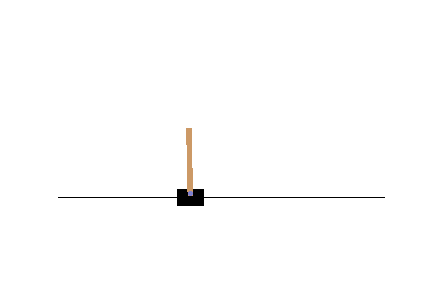
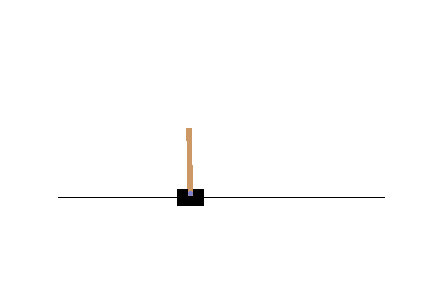
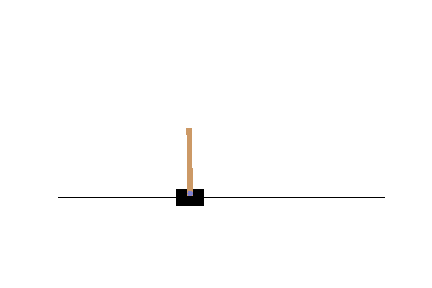
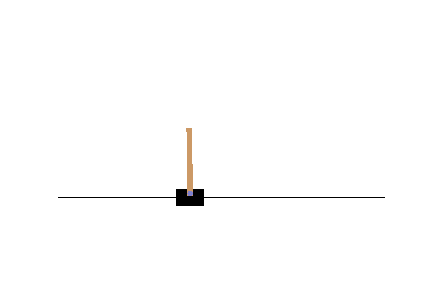
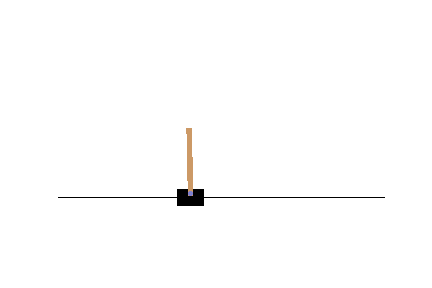
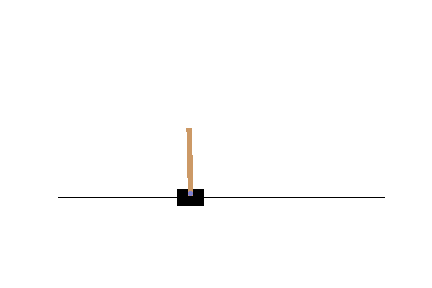
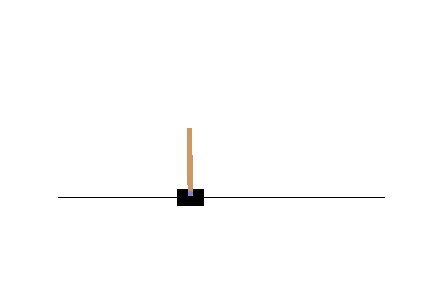
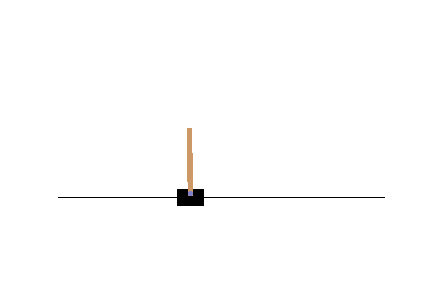
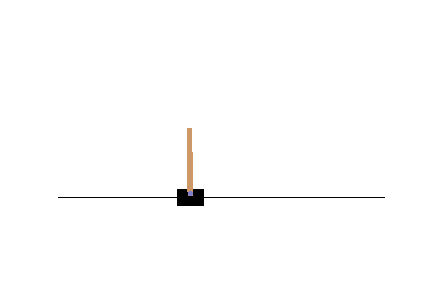
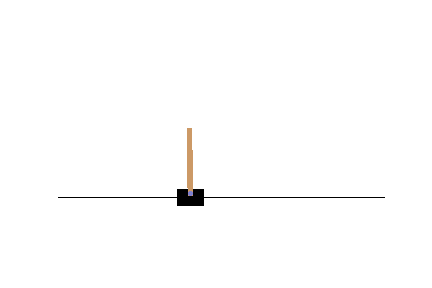
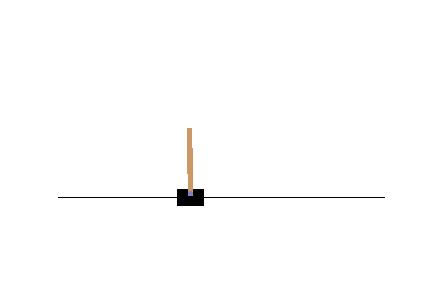
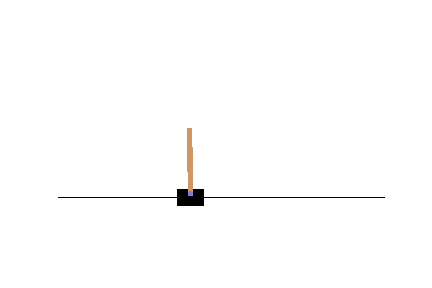
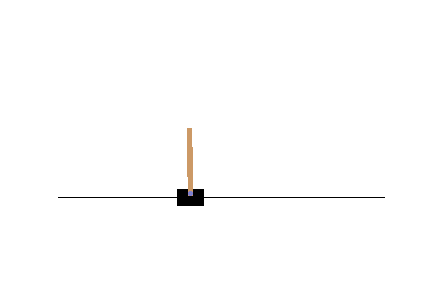
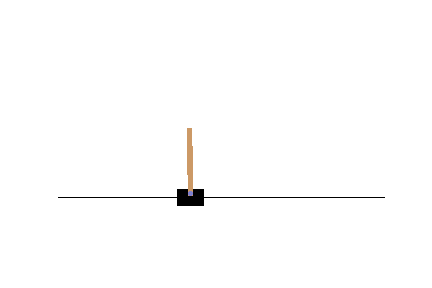
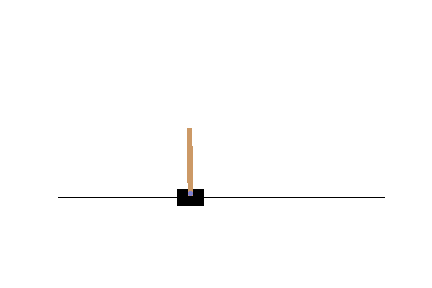
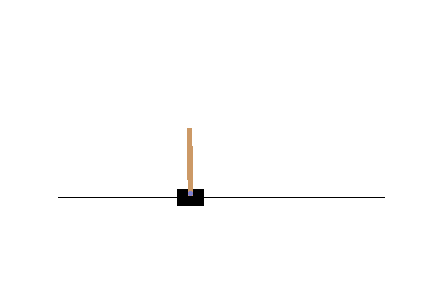
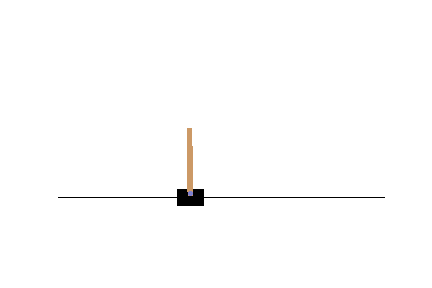
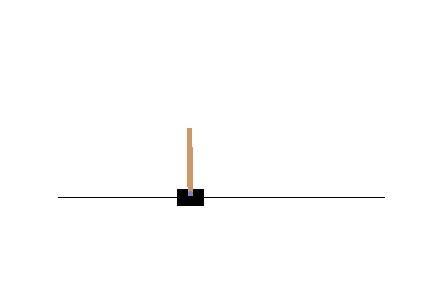
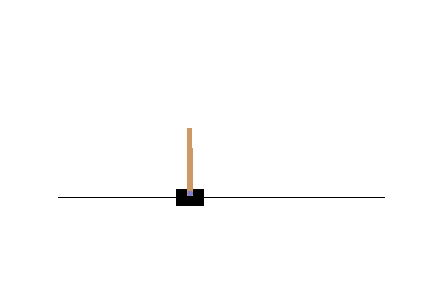
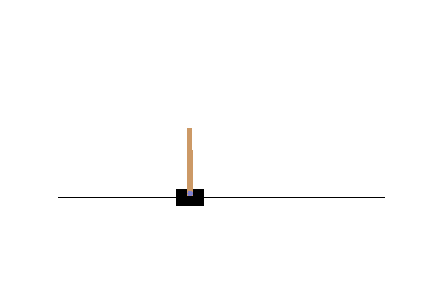
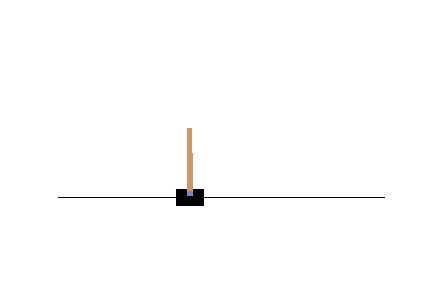
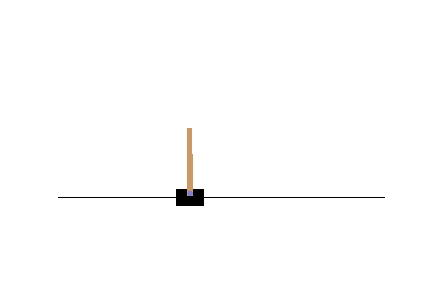
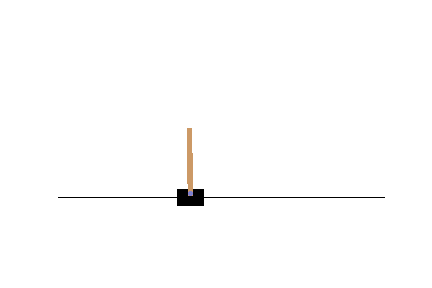
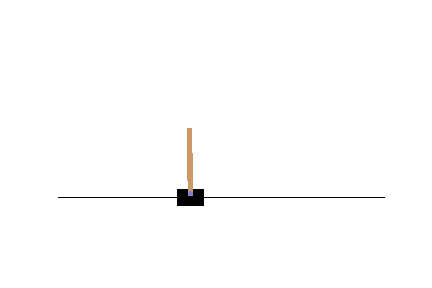
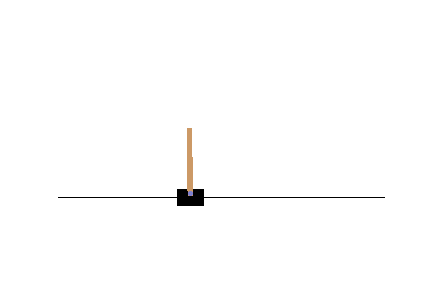
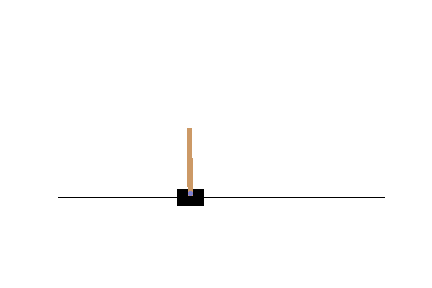
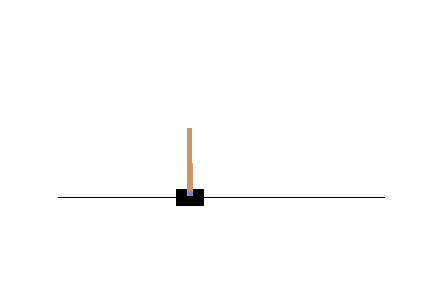
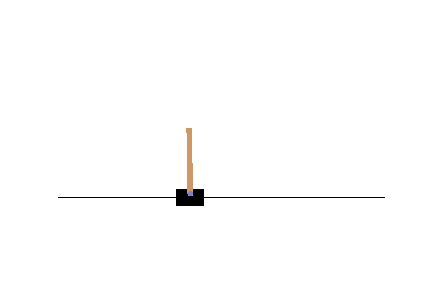
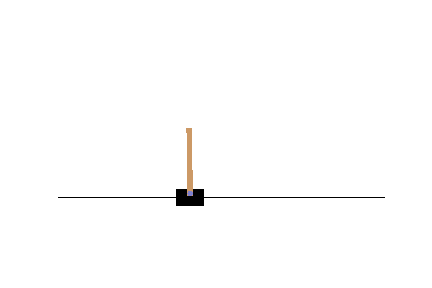
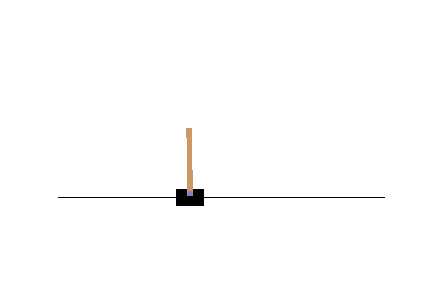
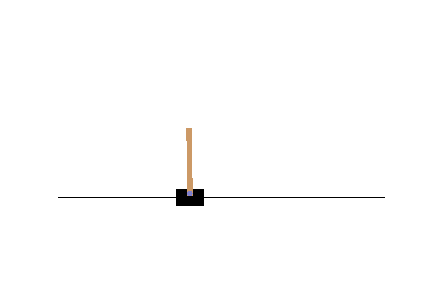
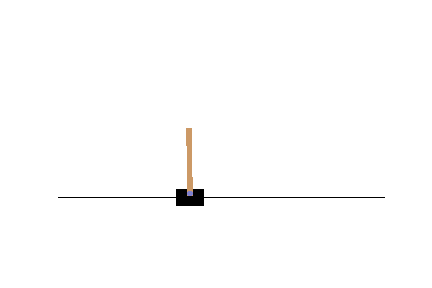
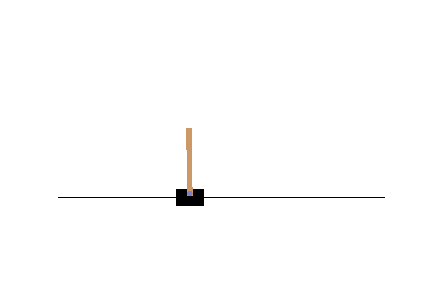
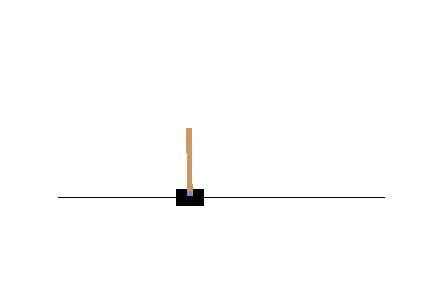
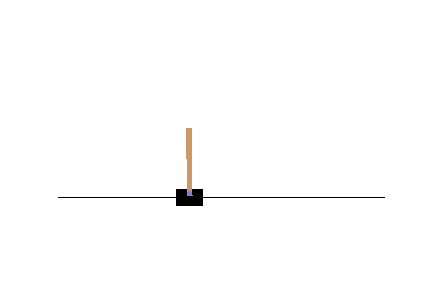
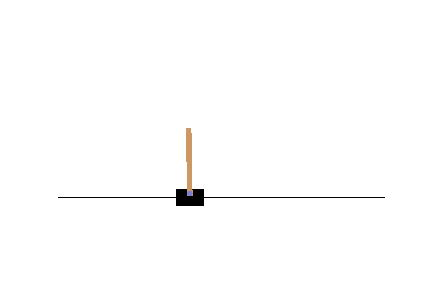
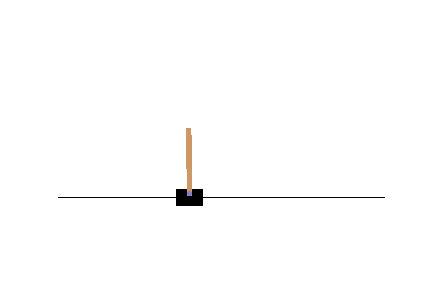
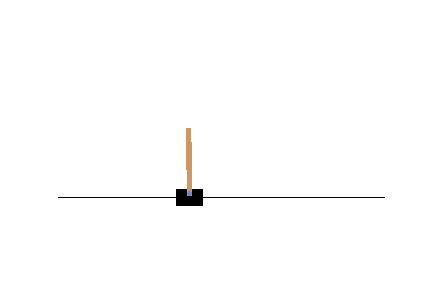
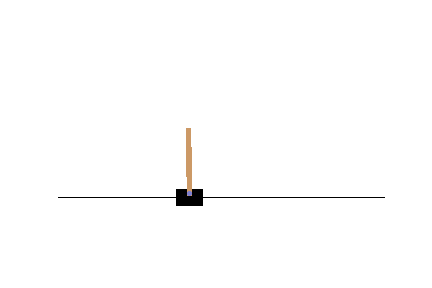
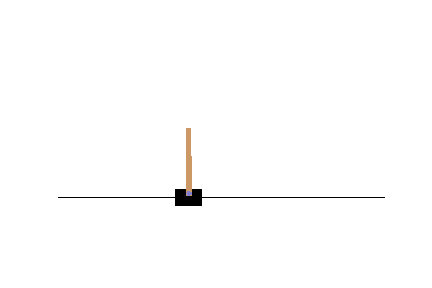
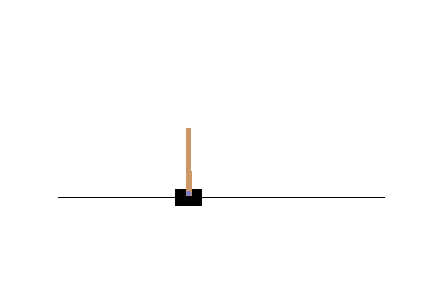
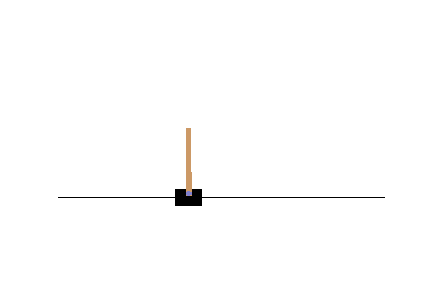
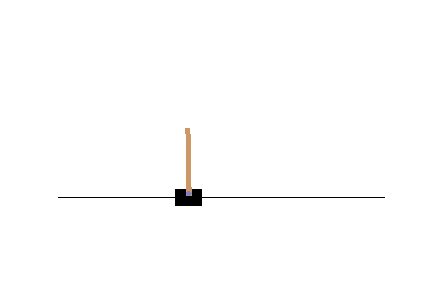
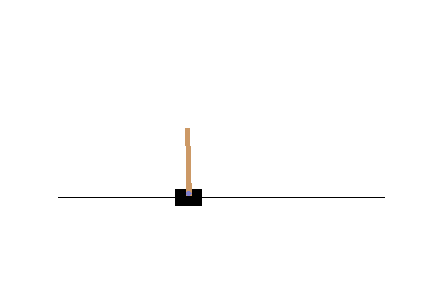
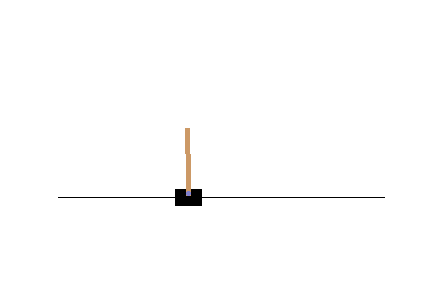
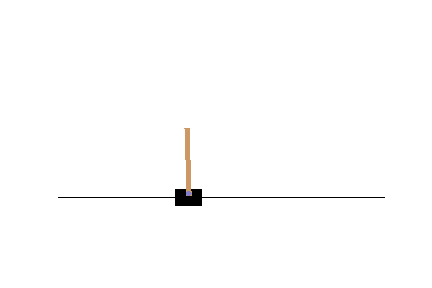
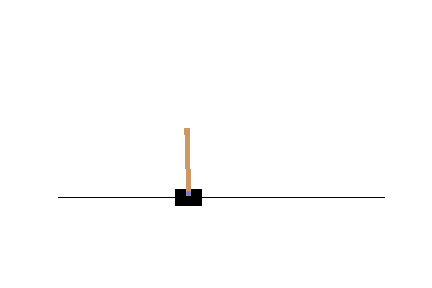
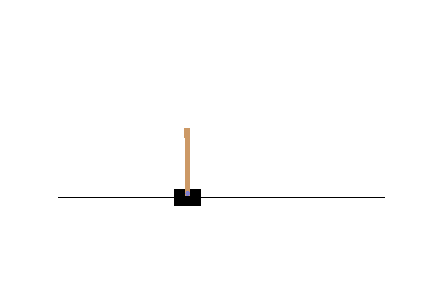
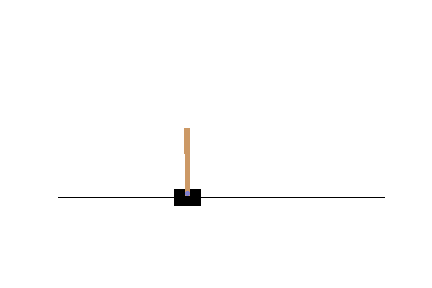
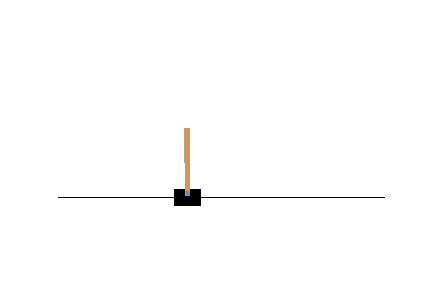
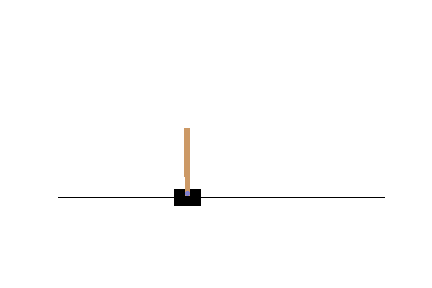
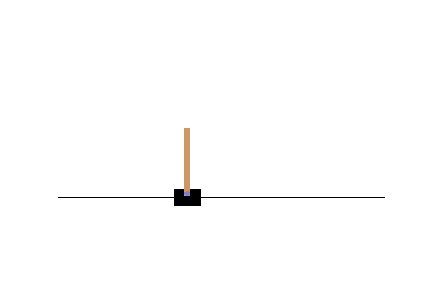
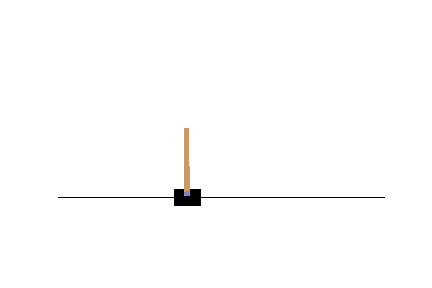
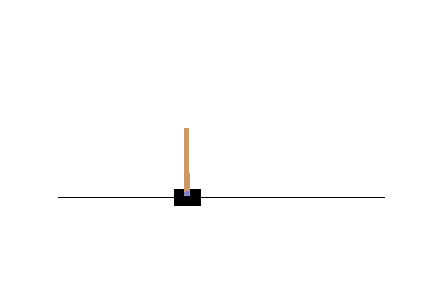
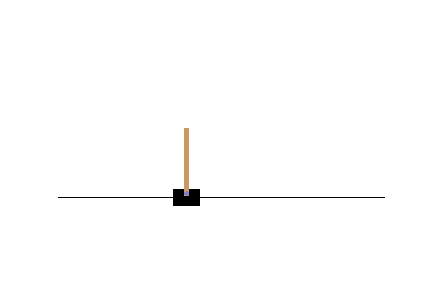
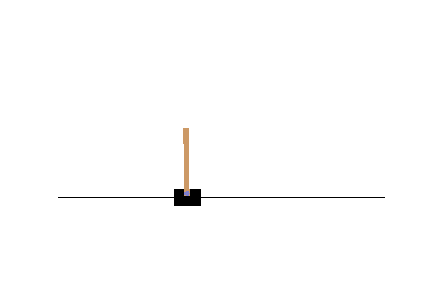
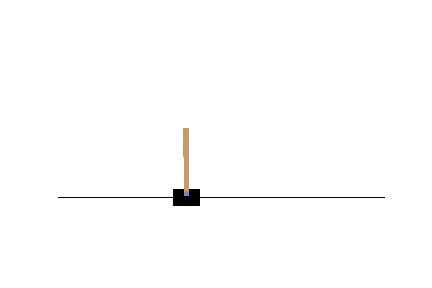
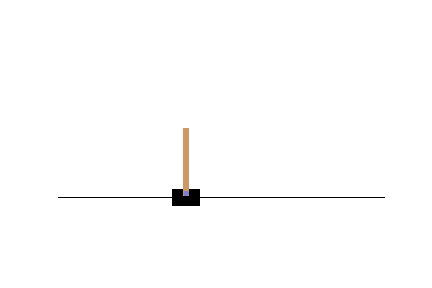
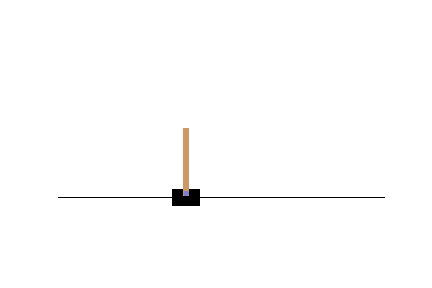
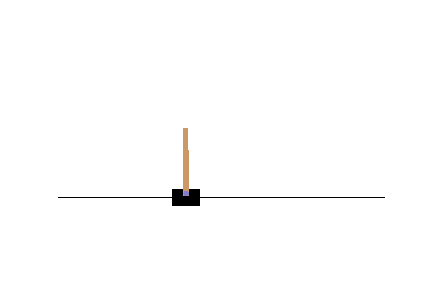
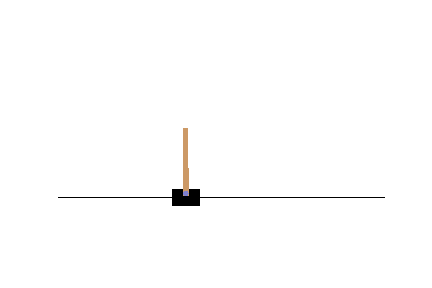
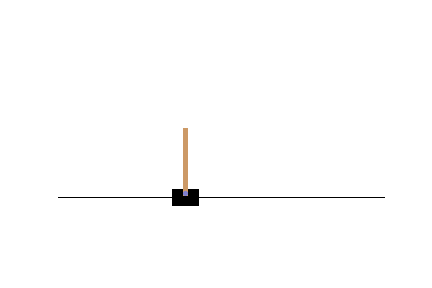
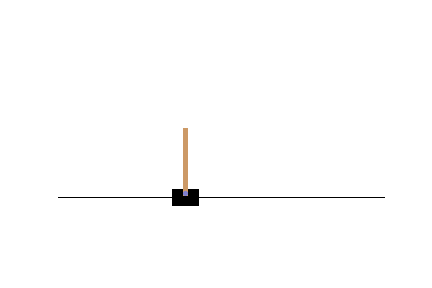
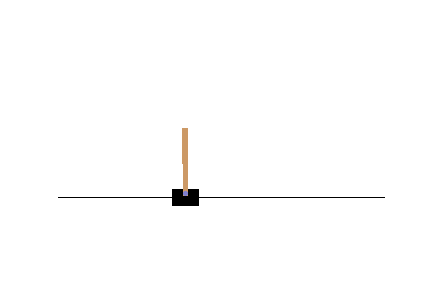
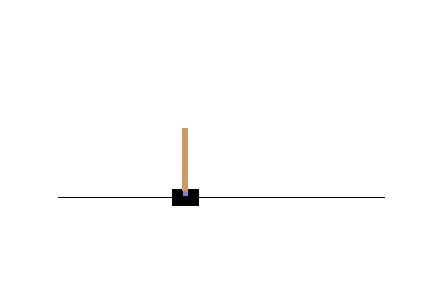
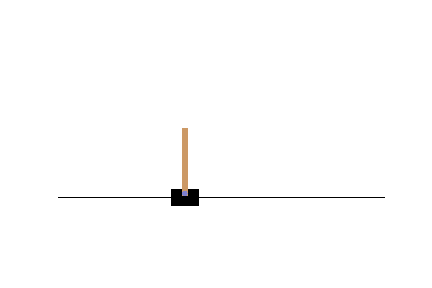
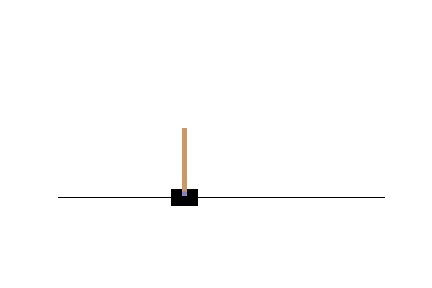
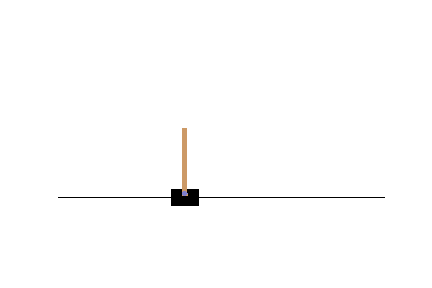
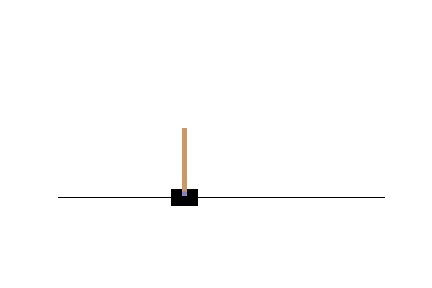
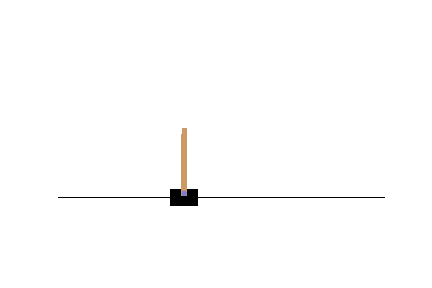
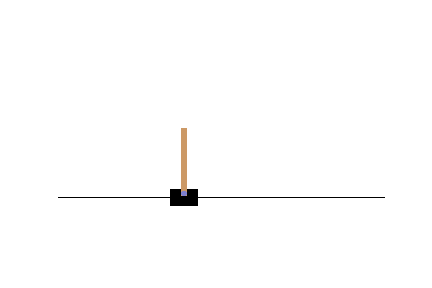
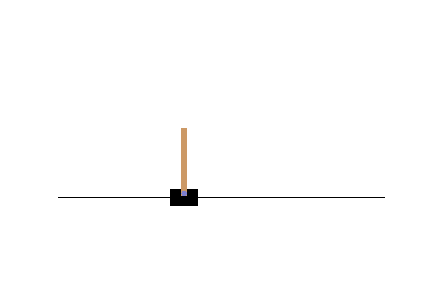
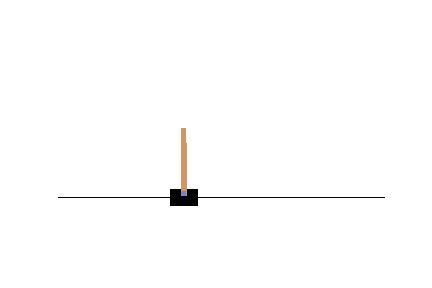
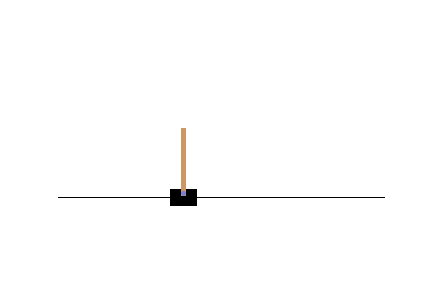
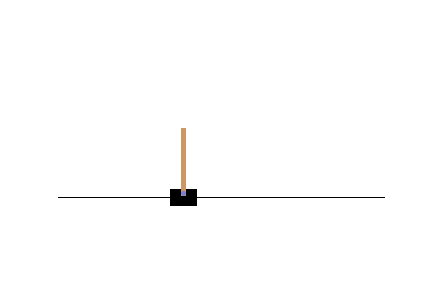
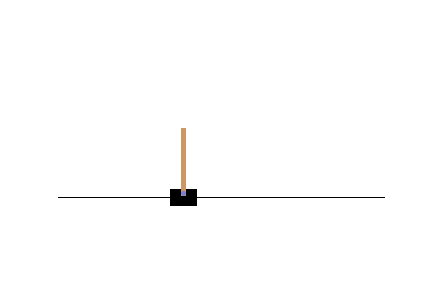
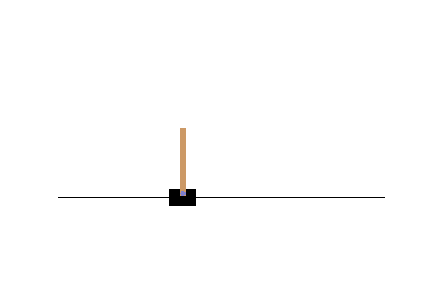
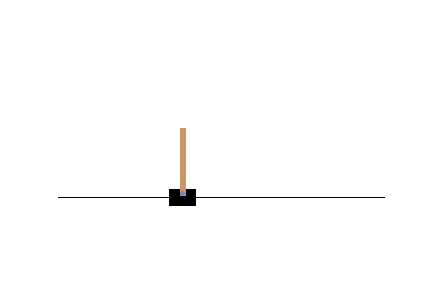
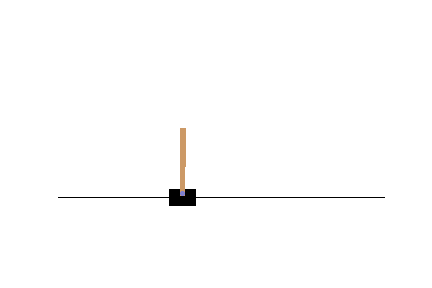
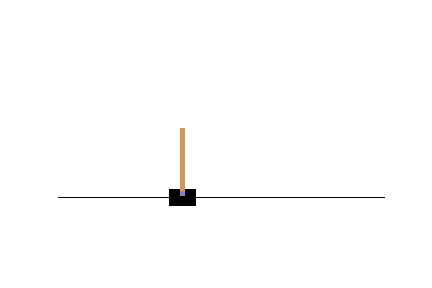
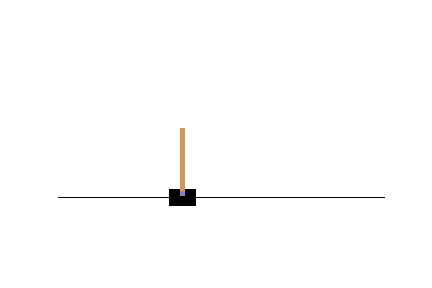
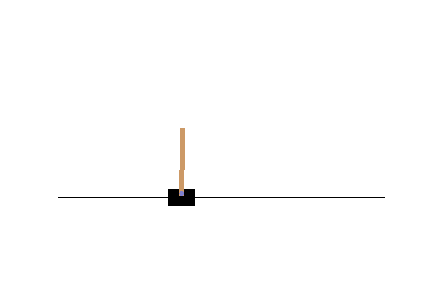
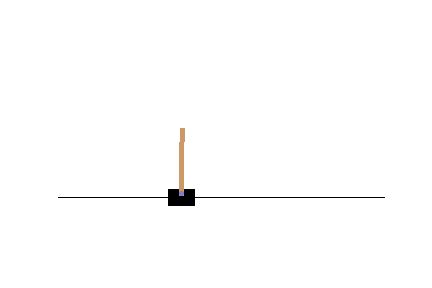
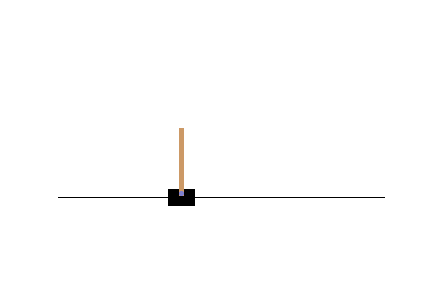
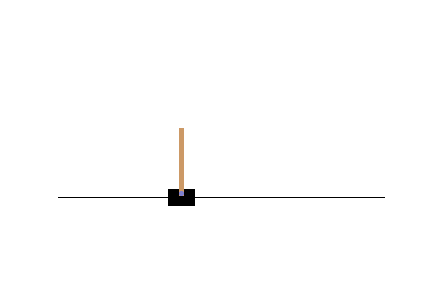
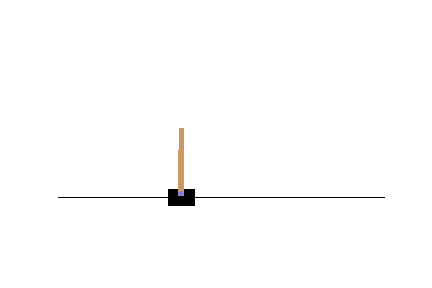
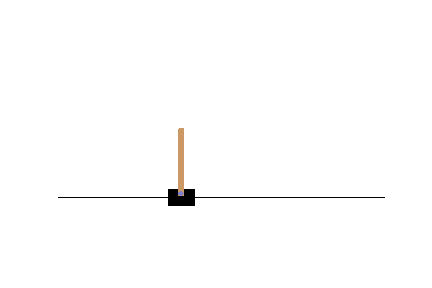
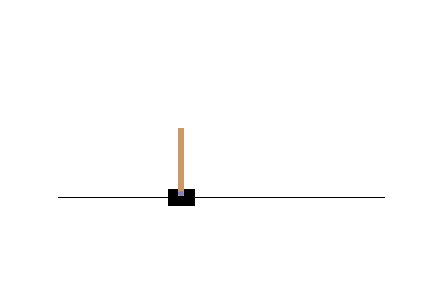
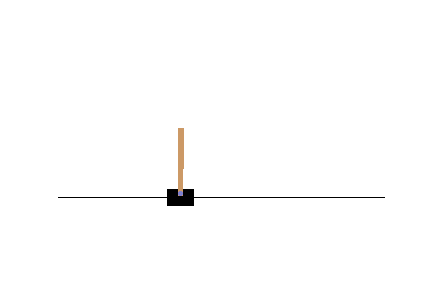
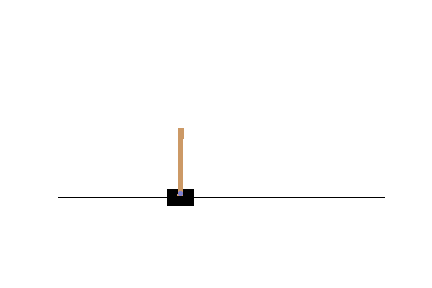
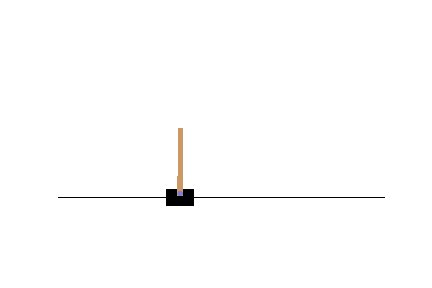
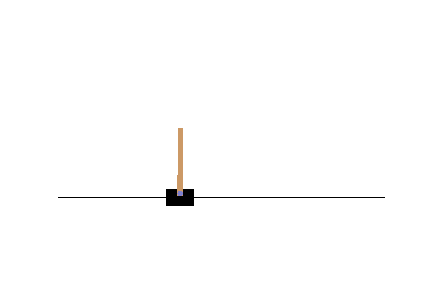
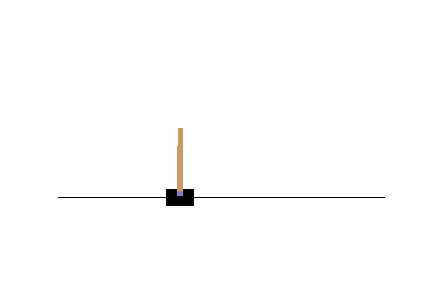
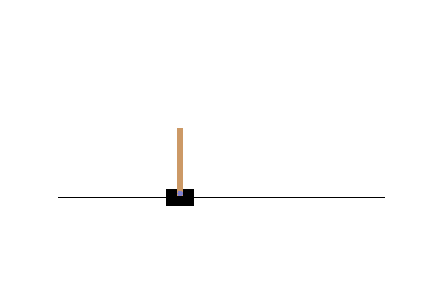
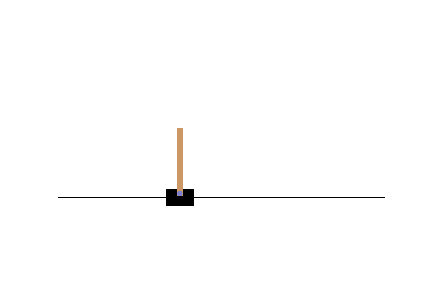
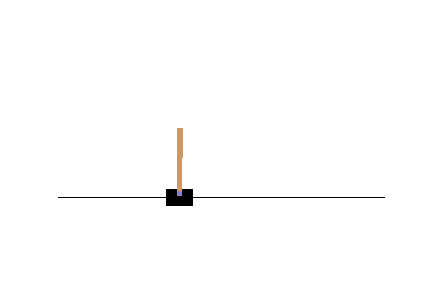
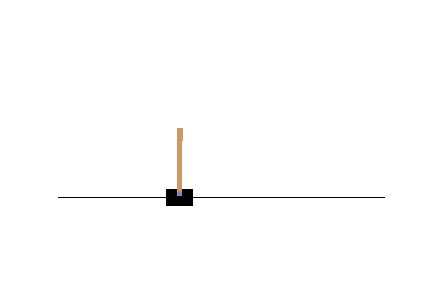
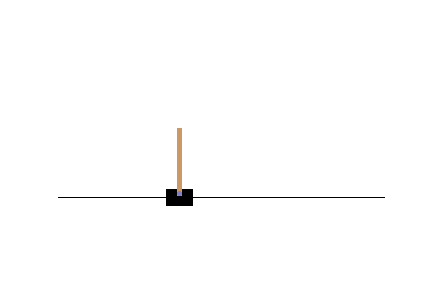
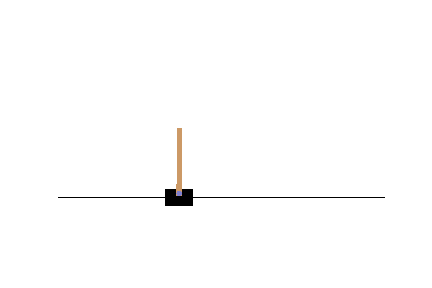
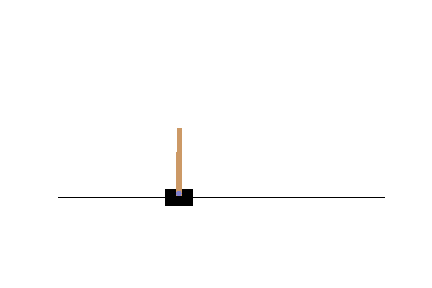
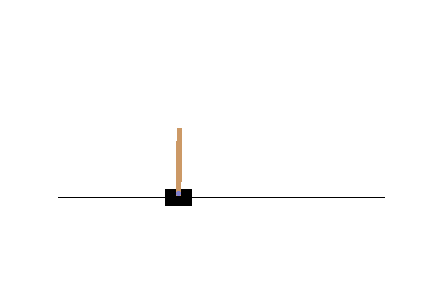
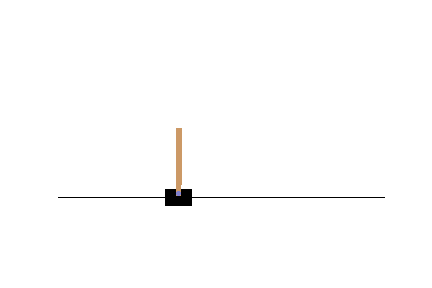
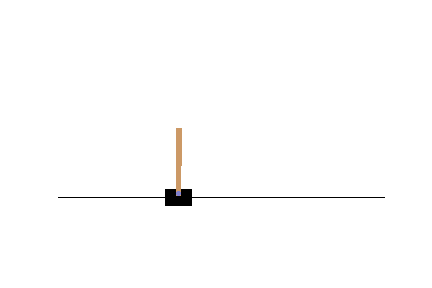
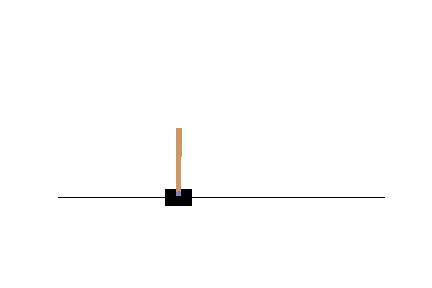
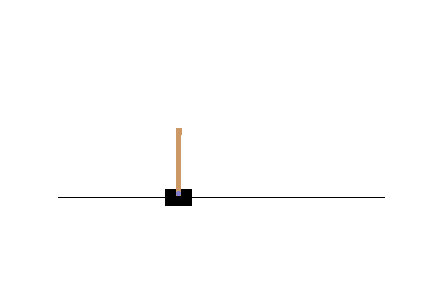
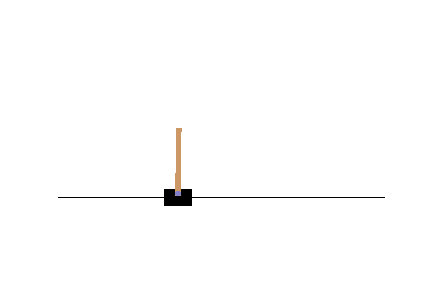
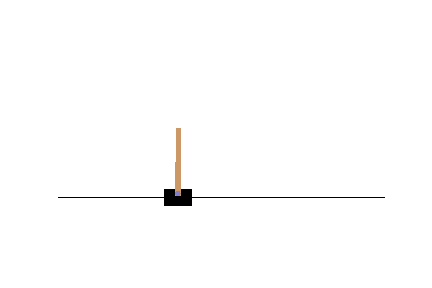
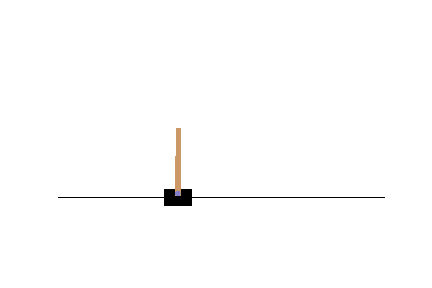
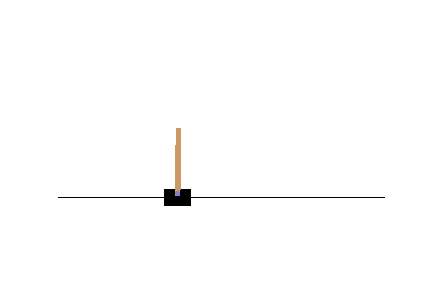
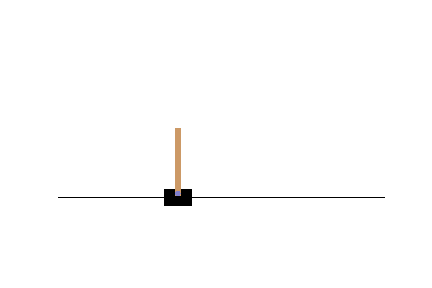
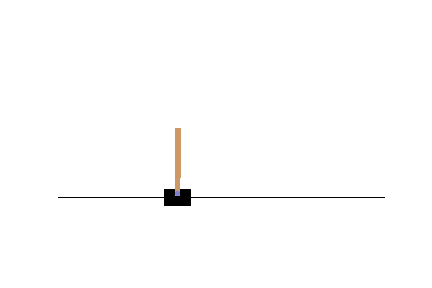
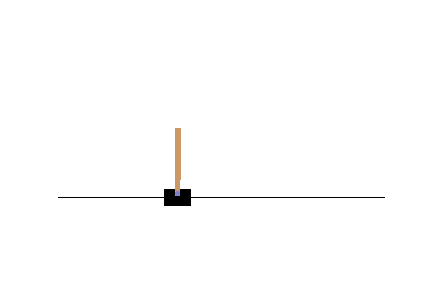
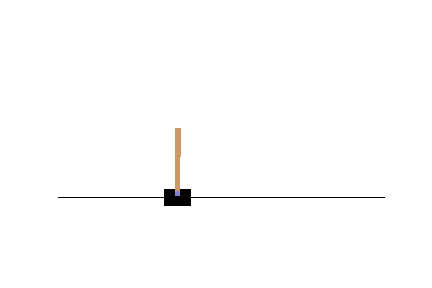
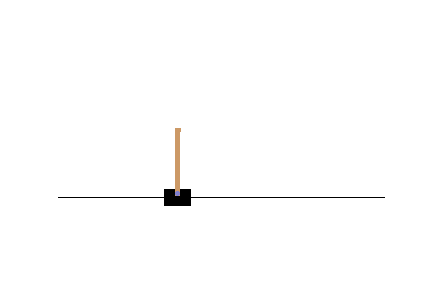
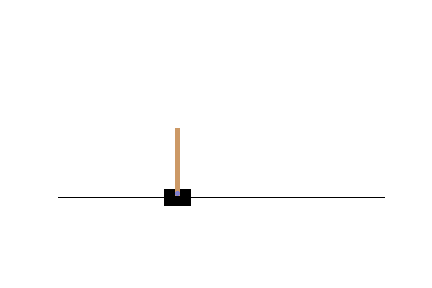
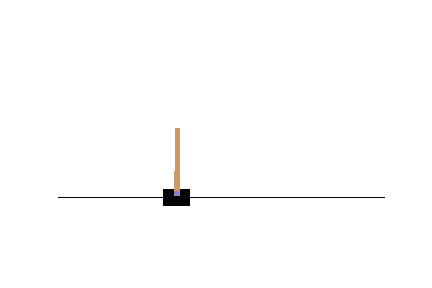
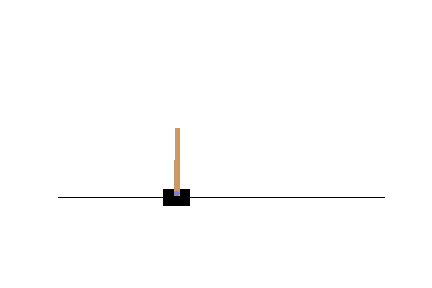
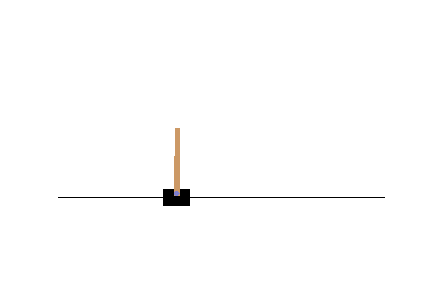
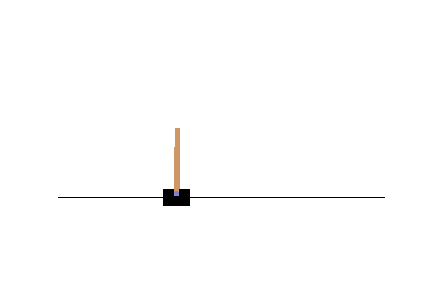
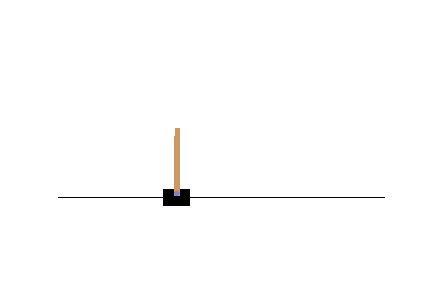
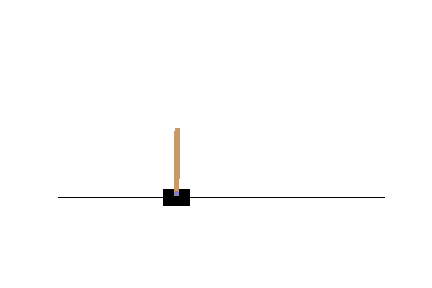
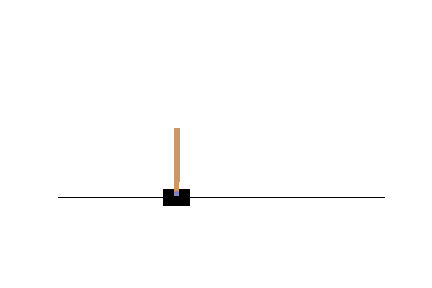
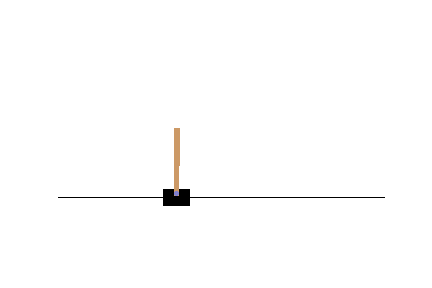
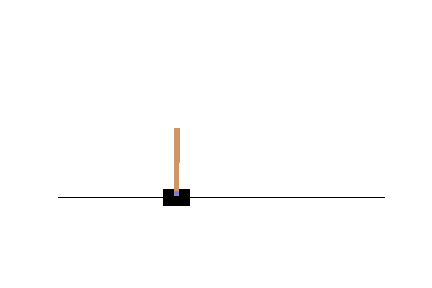
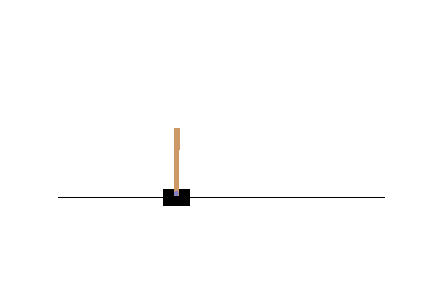
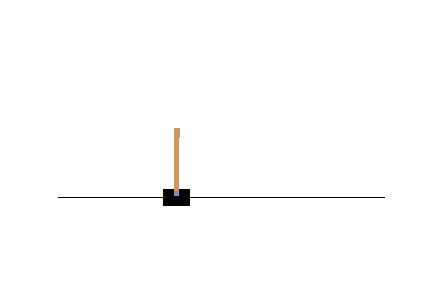
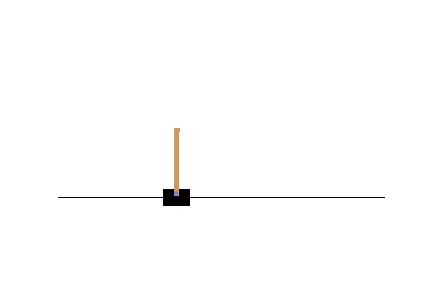
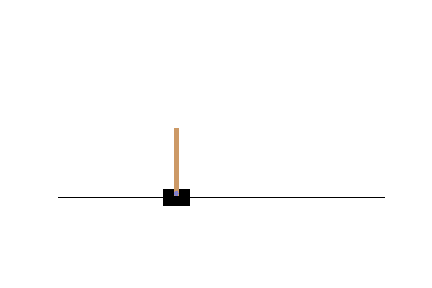
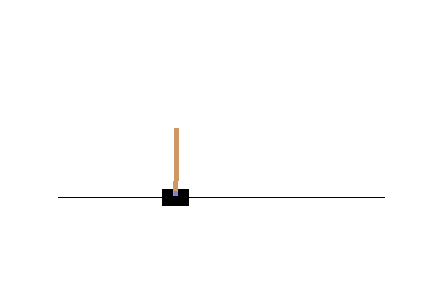
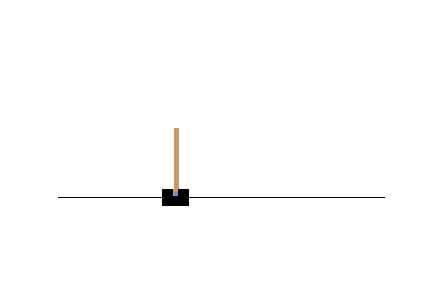
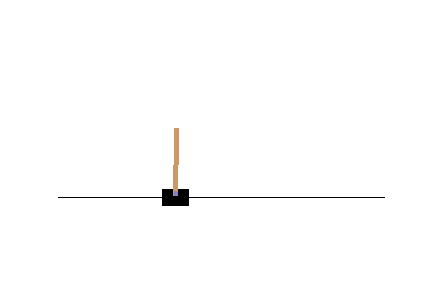
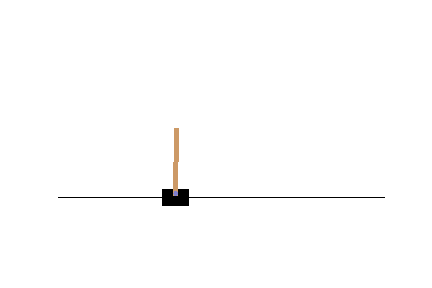
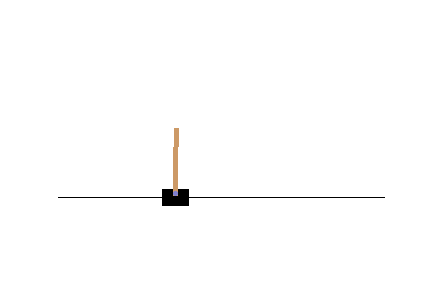
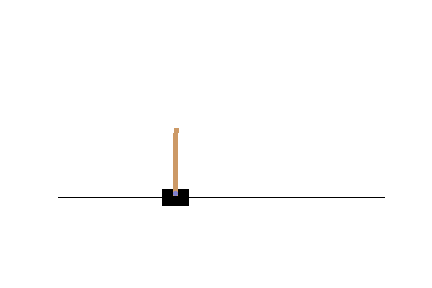
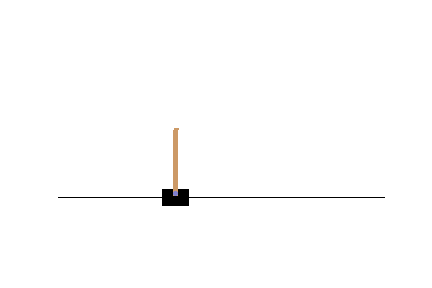
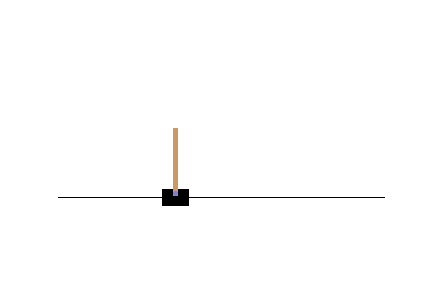
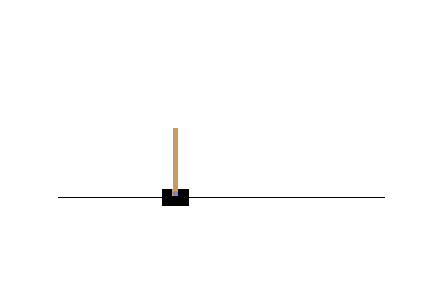
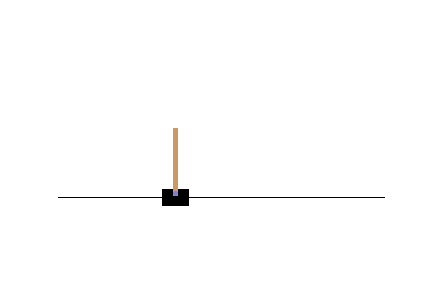
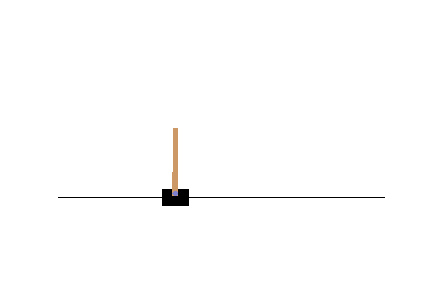
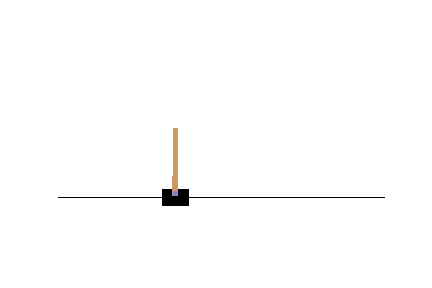
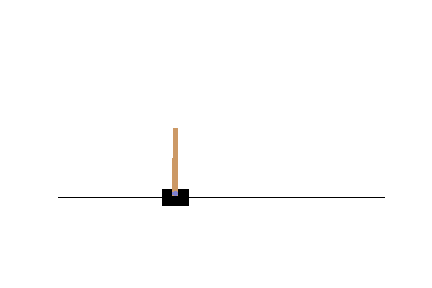
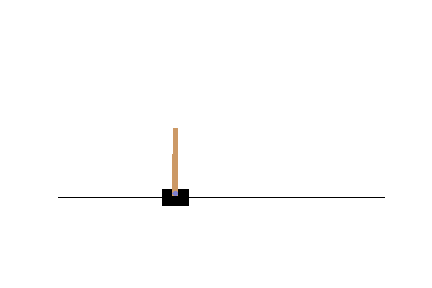
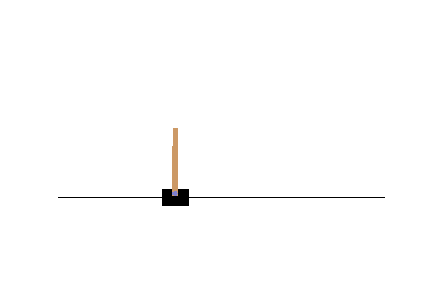
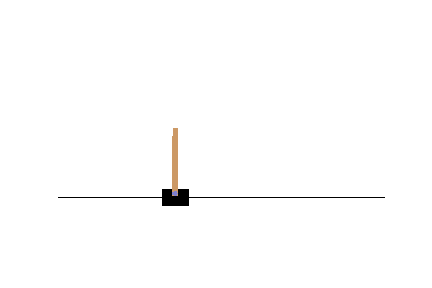
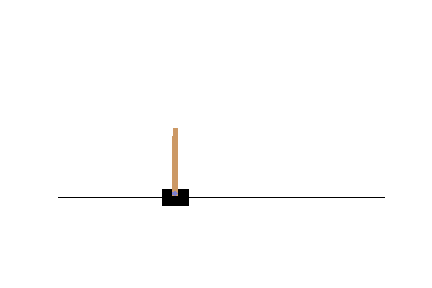
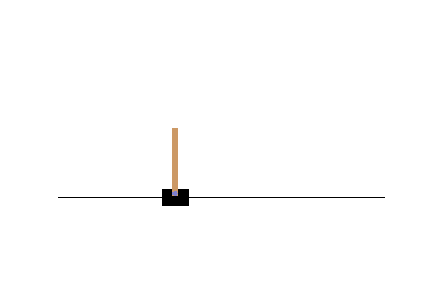
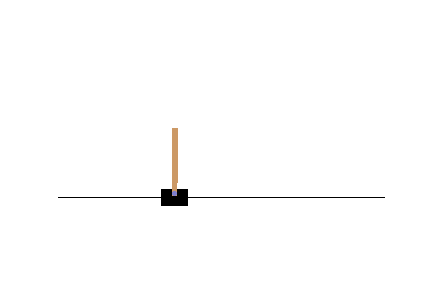
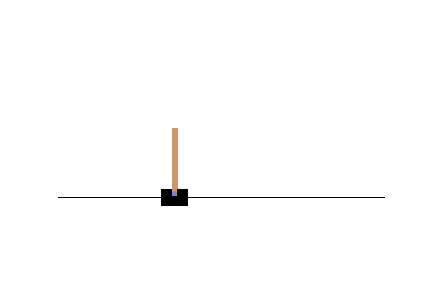
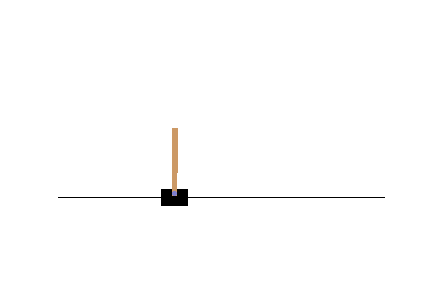
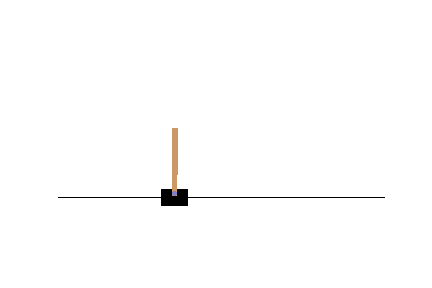
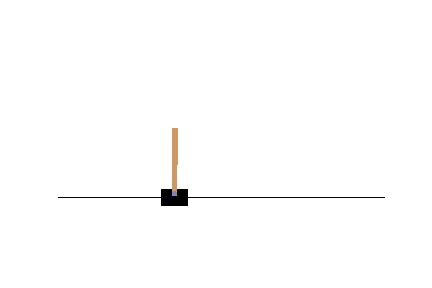
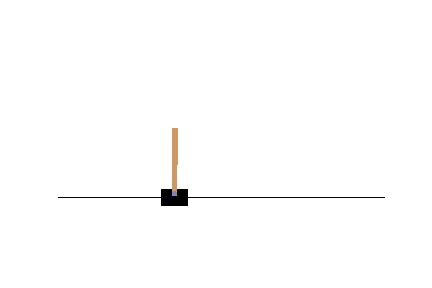
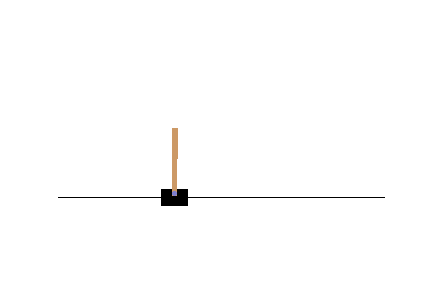
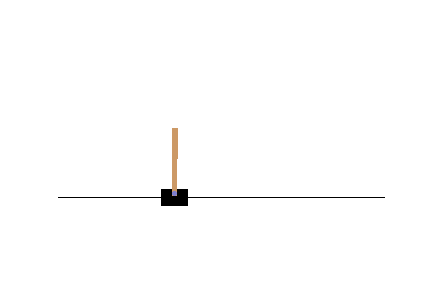
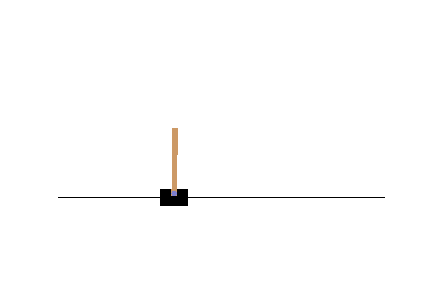
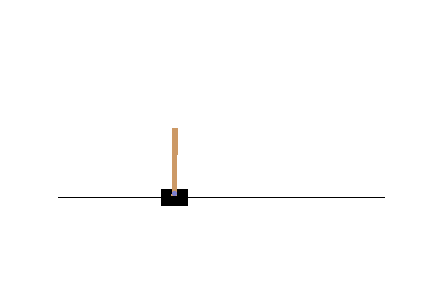
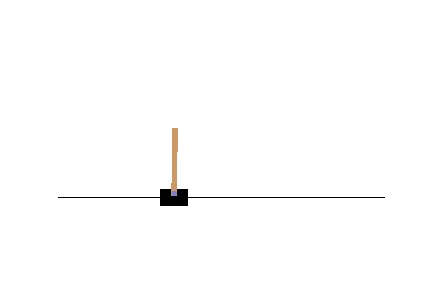
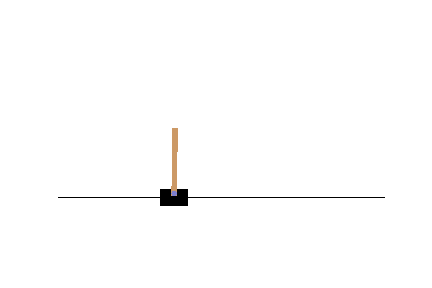
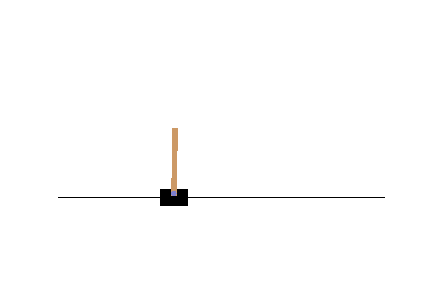
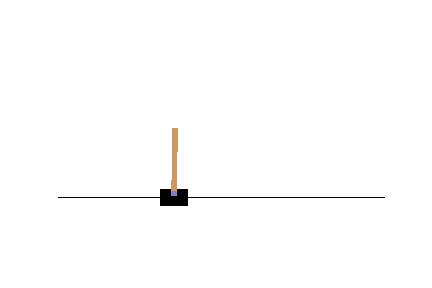
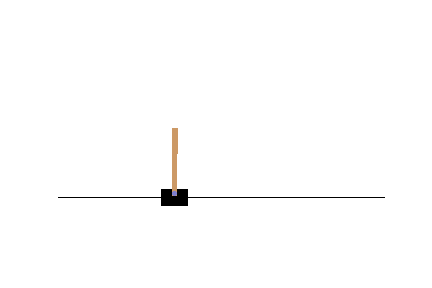
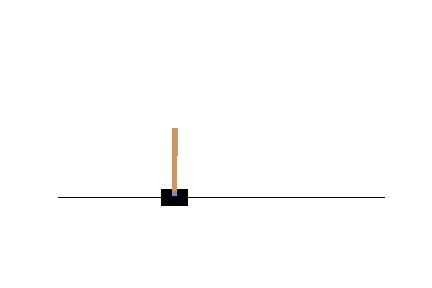
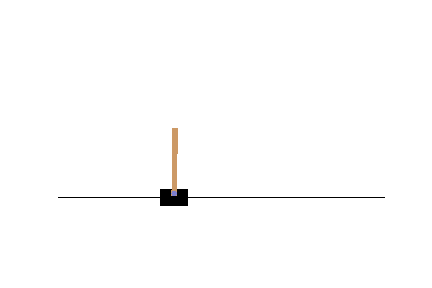
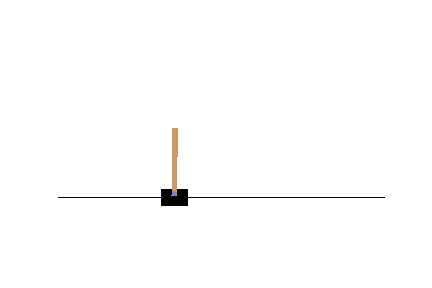
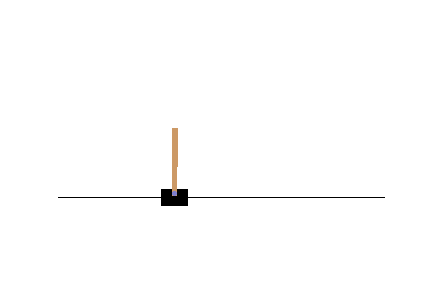
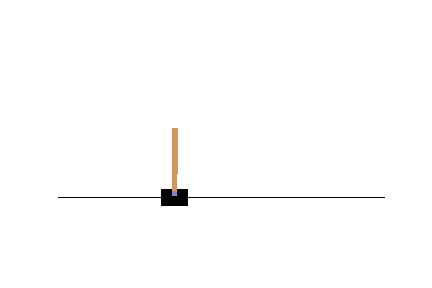
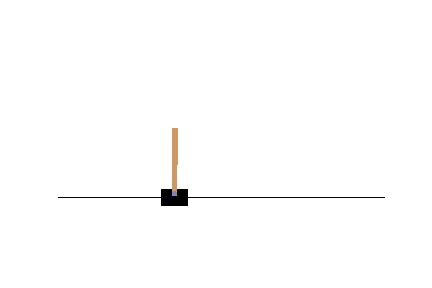
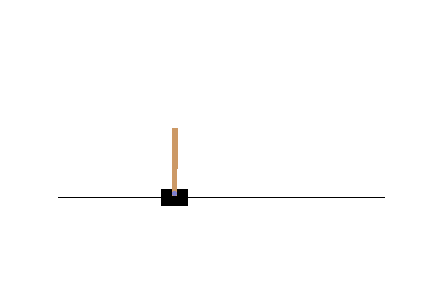
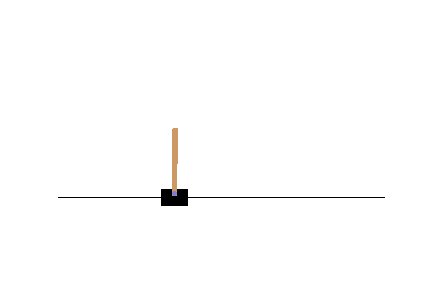
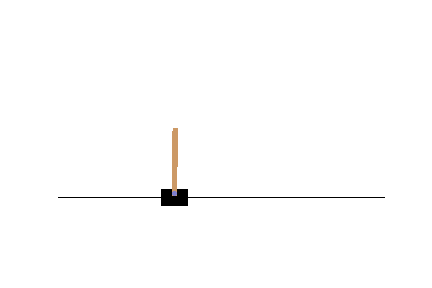
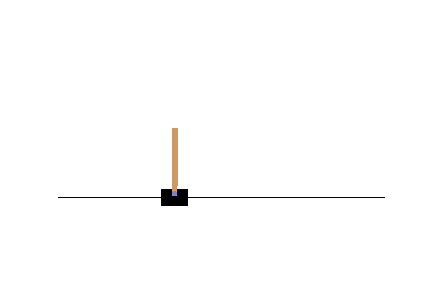
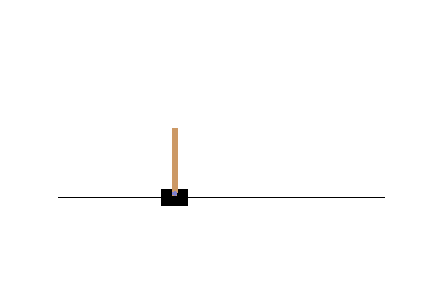
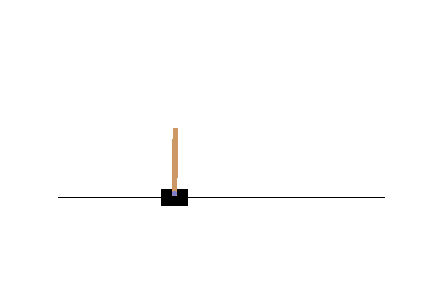
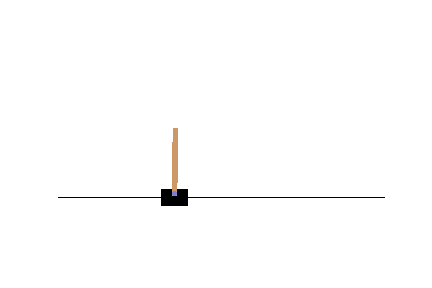
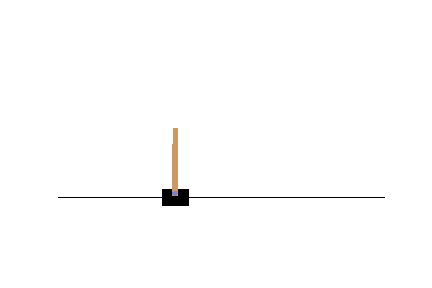
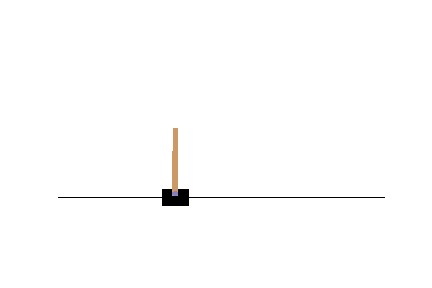
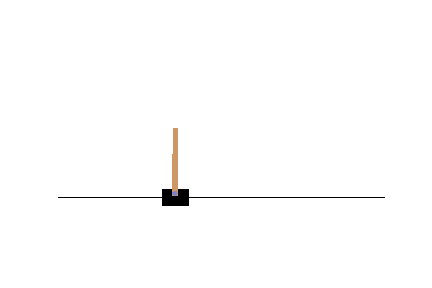
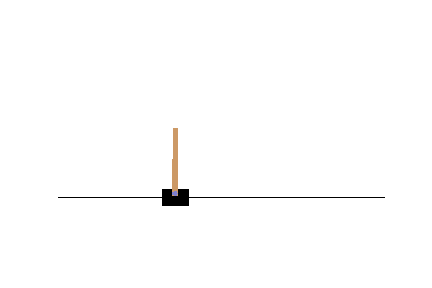
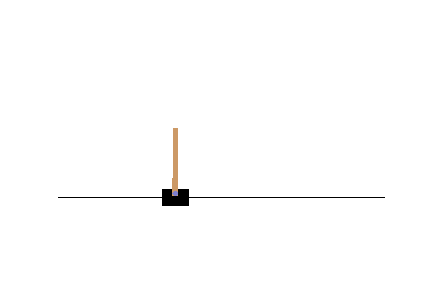
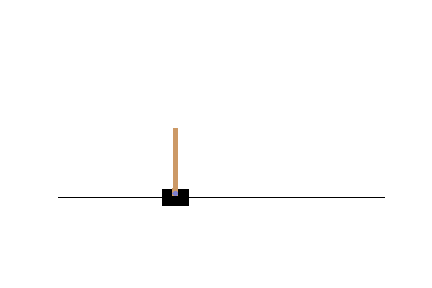
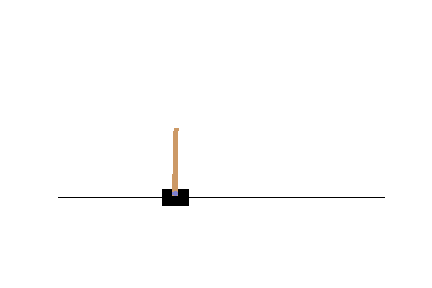
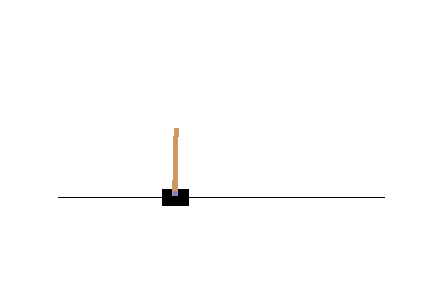
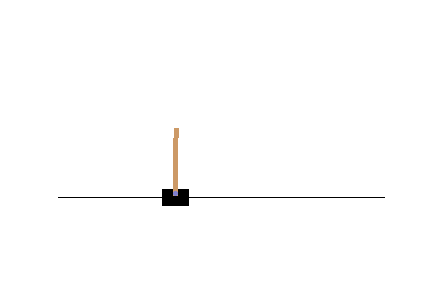
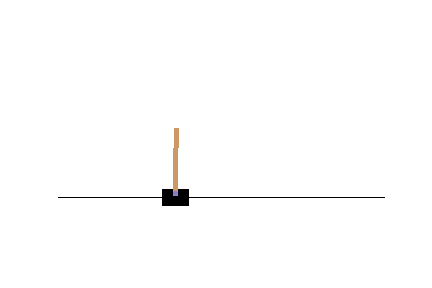
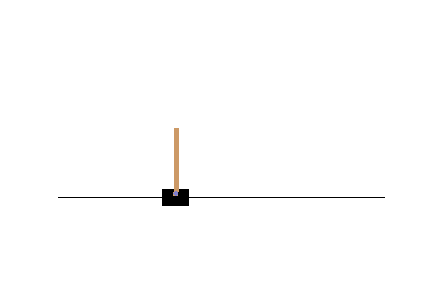
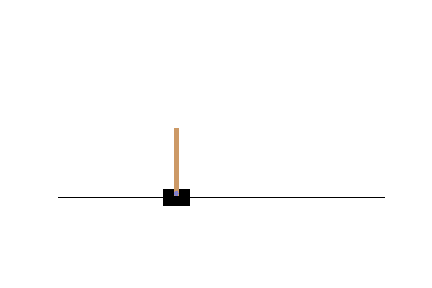
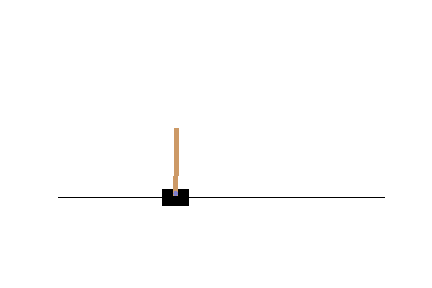
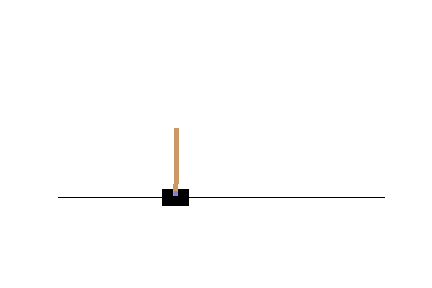
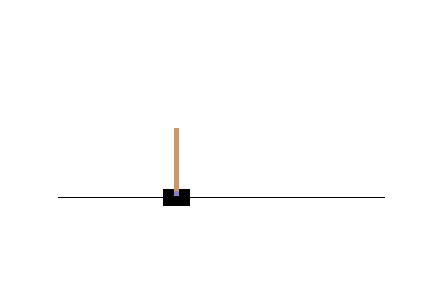
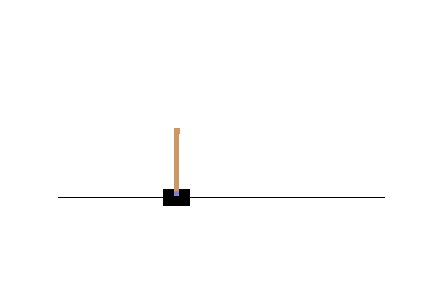
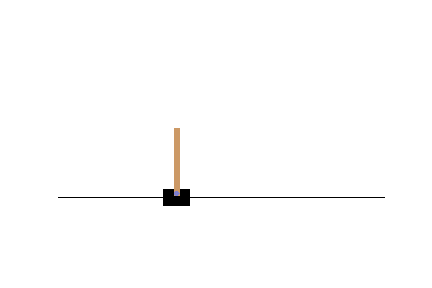
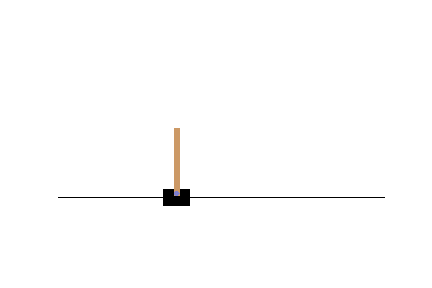
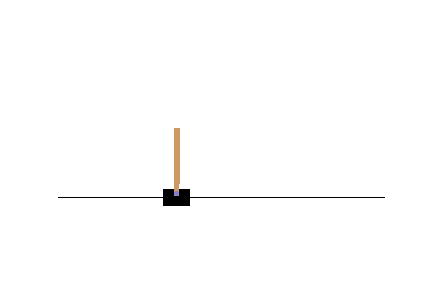
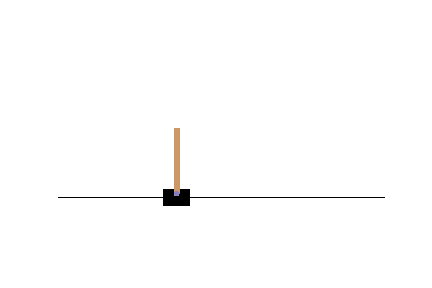
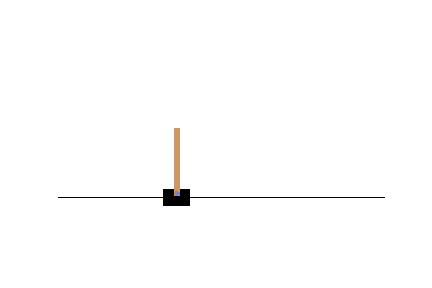
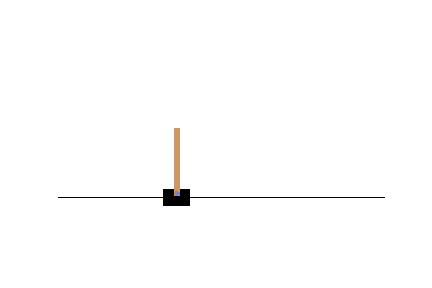
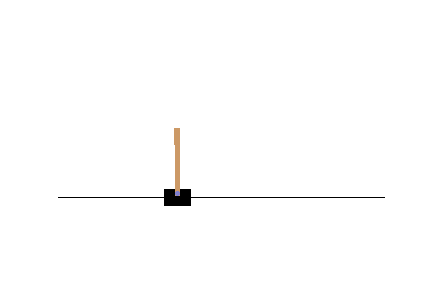
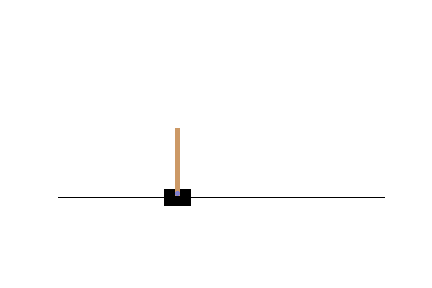
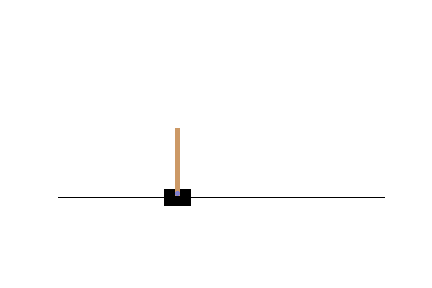
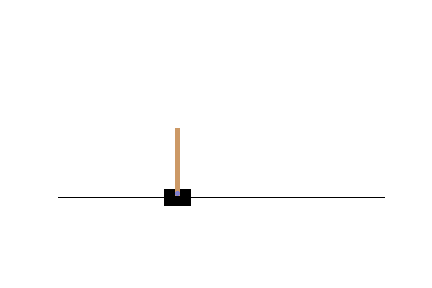
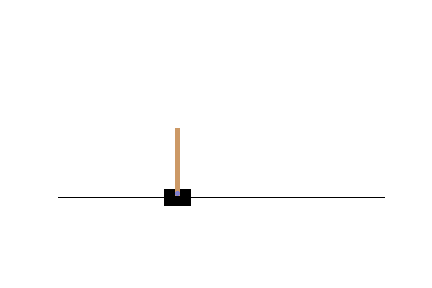
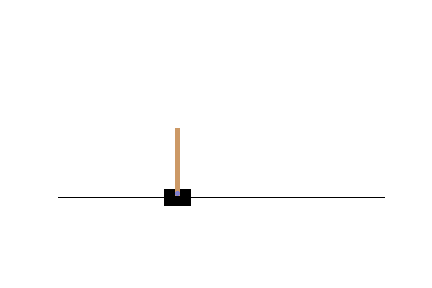
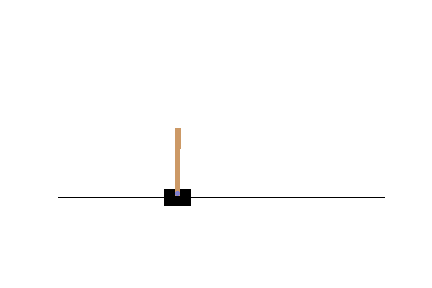
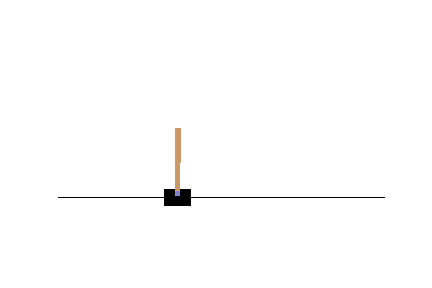
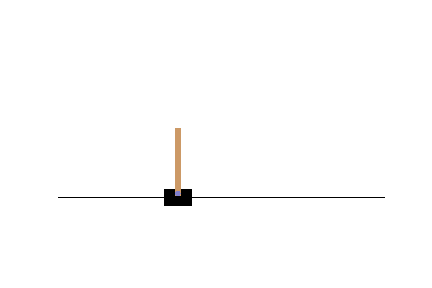
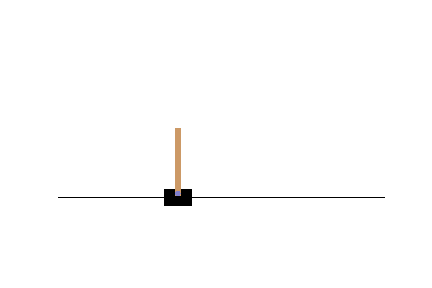
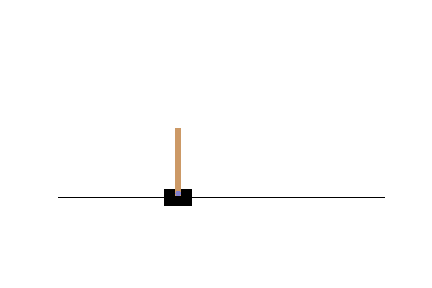
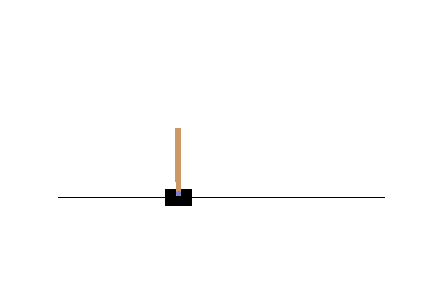
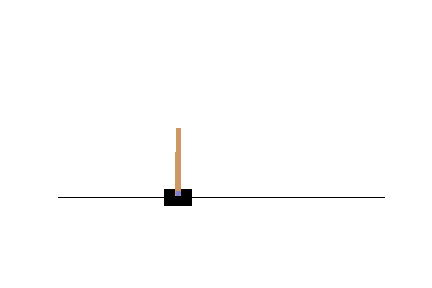
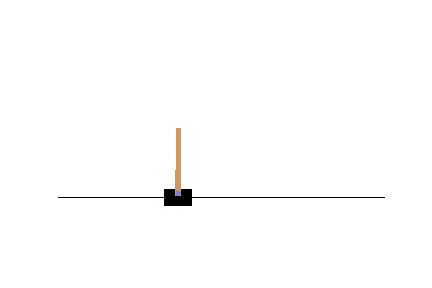
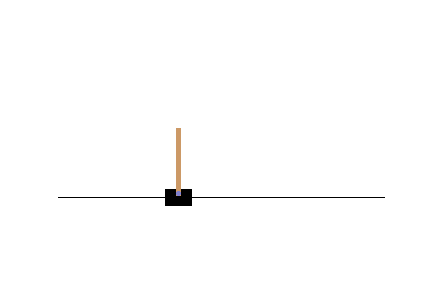
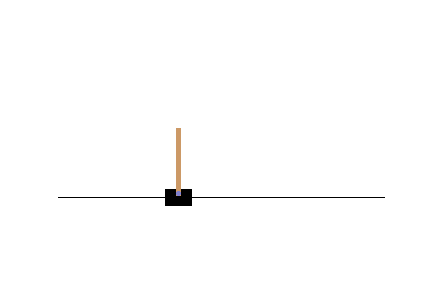
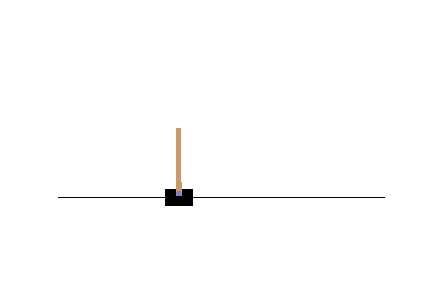
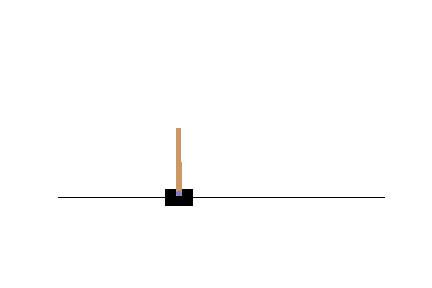
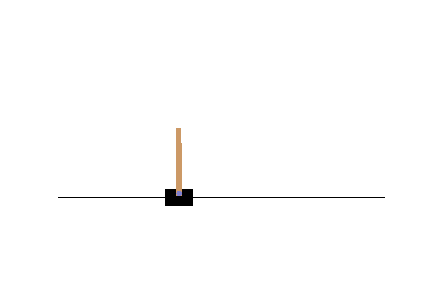
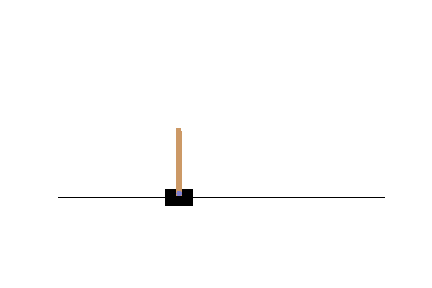
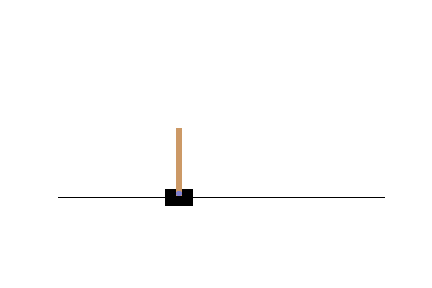
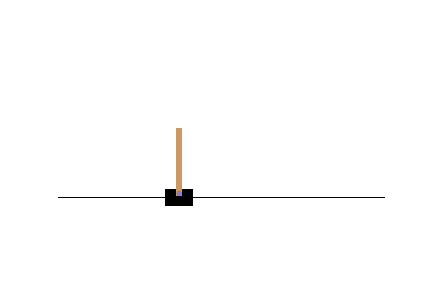
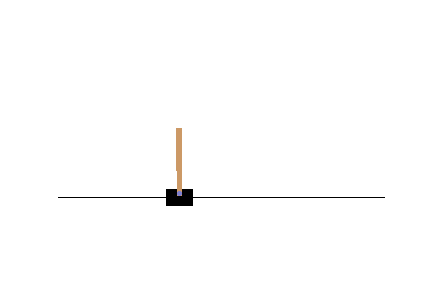
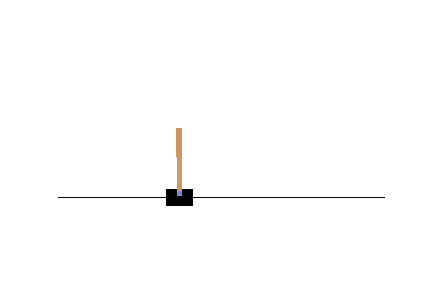
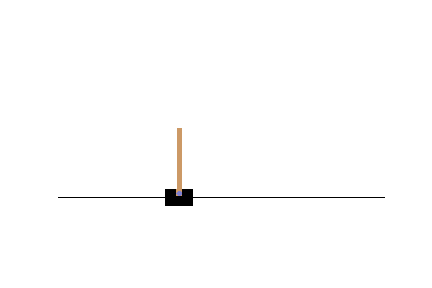
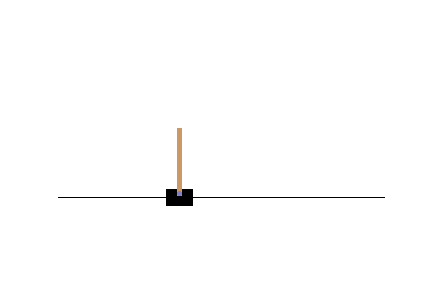
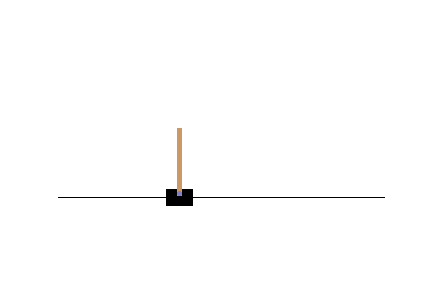
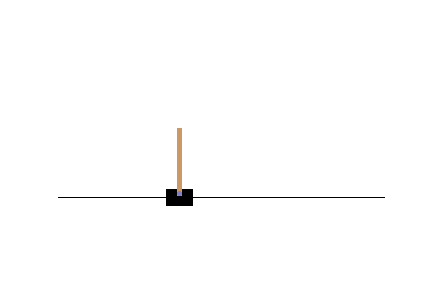
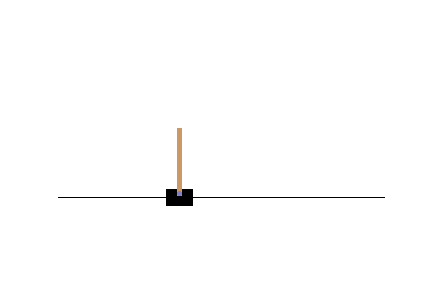
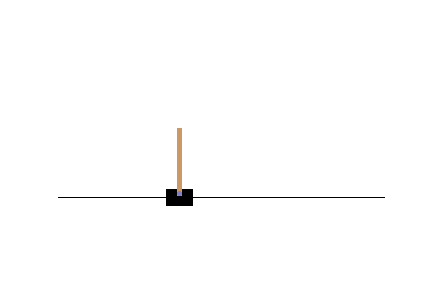
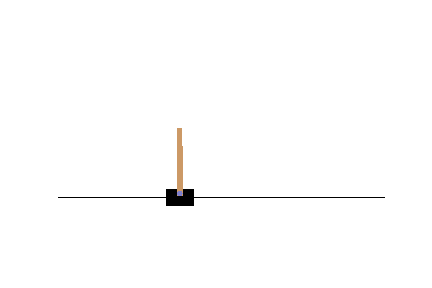
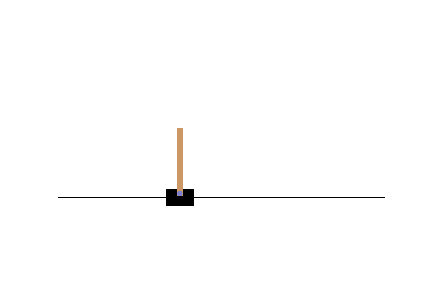
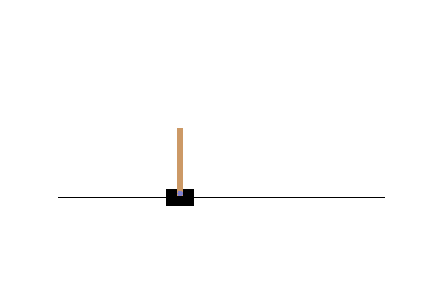
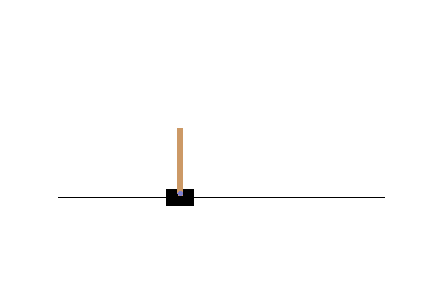
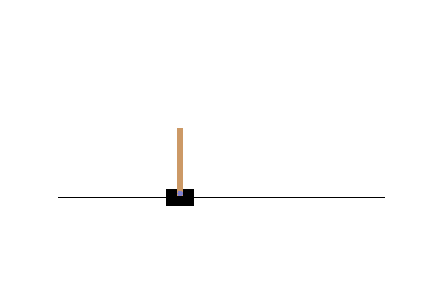
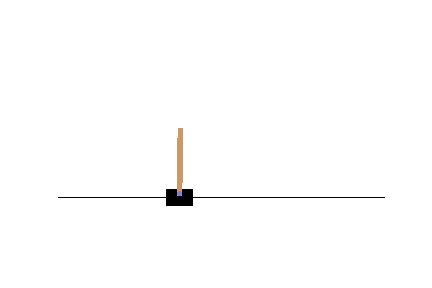
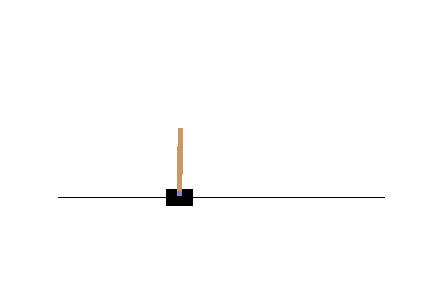
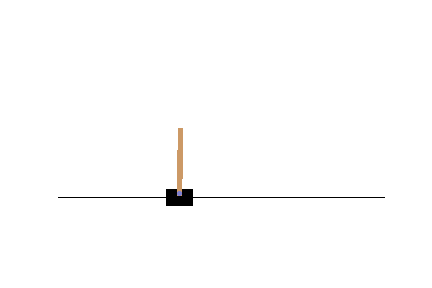

In [6]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# Dueling Architecture

In [7]:
class DQNDUELAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = deque(maxlen=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            
            self.value = tf.layers.dense(out, 1, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='value')
            self.advantage = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='advantage')
            
            self.q_predict = self.value + self.advantage - tf.reduce_mean(self.advantage,axis = 1,keepdims=True)
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
                        
            value = tf.layers.dense(out, 1, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='value')
            advantage = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='advantage')
            
            self.q_predict_old = value + advantage - tf.reduce_mean(advantage,axis = 1,keepdims=True)
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.loss = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict)) # Squared Error
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss) # AdamOptimizer (Gradient Descent Algorithm)
            
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
        # Summary writer
        summary_v = tf.summary.scalar('value', self.value[0][0])
        summary_adv = tf.summary.scalar('advantage', tf.reduce_max(self.advantage))
        summary_loss = tf.summary.scalar('loss', self.loss)
        self.merge_v_step = 0
        self.merge_v = tf.summary.merge([summary_v, summary_adv])
        self.merge_loss_step = 0
        self.merge_loss = tf.summary.merge([summary_loss])
        self.summary_writer = tf.summary.FileWriter('./tf_logs/dueling', graph=self.sess.graph)
        
    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs, store_summary=True): # Get Q value from target network
        q_value_old, summary = self.sess.run([self.q_predict_old,self.merge_v],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        if store_summary:
            self.merge_v_step += 1
            self.summary_writer.add_summary(summary,self.merge_v_step)       
        
        return q_value_old
        
    def get_prediction(self, obs, store_summary=True): # Get Q value from prediction network
        q_value, summary = self.sess.run([self.q_predict,self.merge_v],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        if store_summary:
            self.merge_v_step += 1
            self.summary_writer.add_summary(summary,self.merge_v_step)       
        
        return q_value
    
    def get_action(self, obs): # Epsilon Greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done): # Add experience to memory
        self.memory.append((obs, action, reward, next_obs, done))

    def train_model(self):
        loss = np.nan
        n_entries = len(self.memory)
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            mini_batch = random.sample(self.memory, self.batch_size)
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations, store_summary=False)
            next_q_value = self.get_prediction_old(next_observations, store_summary=False)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, _, summary = self.sess.run([self.loss, self.optim, self.merge_loss], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate})                        
            
            # Summary loss
            self.merge_loss_step += 1
            self.summary_writer.add_summary(summary, self.merge_loss_step)       
        return loss

# Define Environment and Agent

In [8]:
env = gym.make('CartPole-v1')
env.seed(seed)
max_t = env.spec.max_episode_steps
agent = DQNDUELAgent(env.observation_space.high.shape[0],env.action_space.n)

[2018-05-19 03:53:36,411] Making new env: CartPole-v1


# TRAIN DUELING

In [9]:
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)
nepisodes = 1500
for i in range(nepisodes):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        
        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done)
        
        # Online update perdiction network parameter
        loss = agent.train_model()
        agent.update_policy()
                
        obs = next_obs
        total_reward += reward
        total_loss += loss
        
        if done:
            break
    
    # Update target network parameter
    agent.update_target()
    avg_return_list.append(total_reward)
    avg_loss_list.append(total_loss)
    
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))
        print('The problem is solved with {} episodes'.format(i))
        break
    
    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))

[0/1500] loss : nan, return : 9.000, eps : 0.991
[100/1500] loss : 381.133, return : 169.800, eps : 0.020
[200/1500] loss : 414.423, return : 150.800, eps : 0.010
[300/1500] loss : 2208.431, return : 439.500, eps : 0.010
[322/1500] loss : 4847.861, return : 500.000, eps : 0.010
The problem is solved with 322 episodes


# TEST

[2018-05-19 03:55:26,277] Making new env: CartPole-v1


Total Reward : 500.00



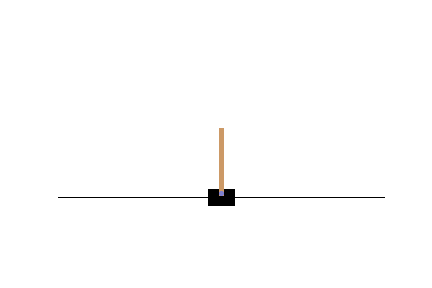
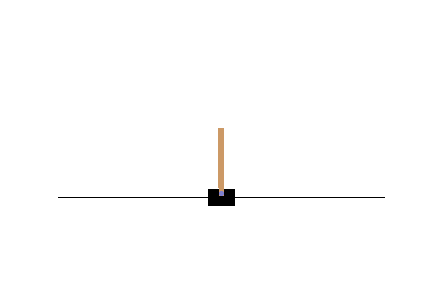
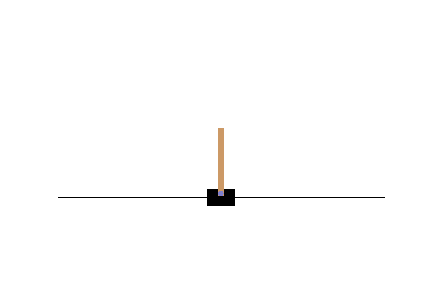
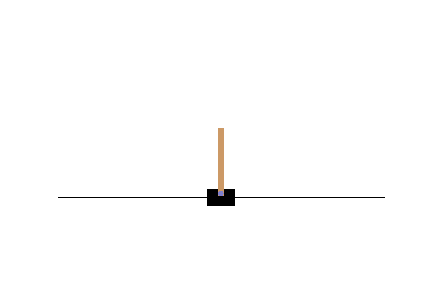
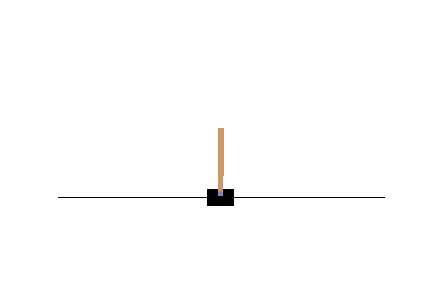
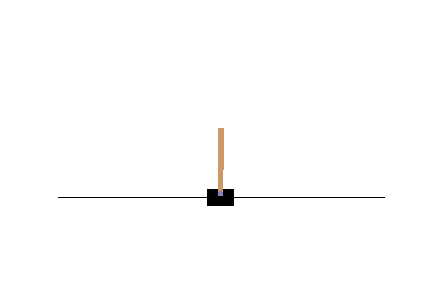
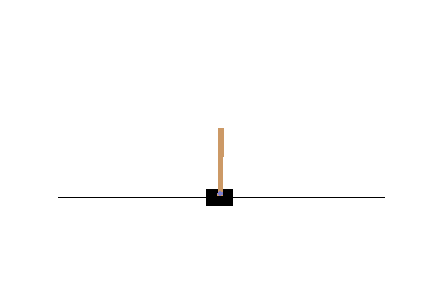
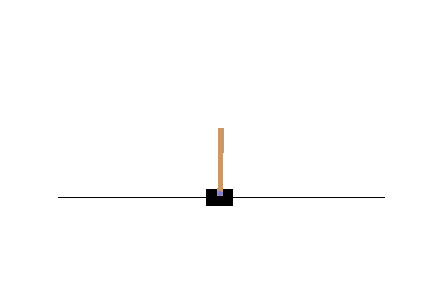
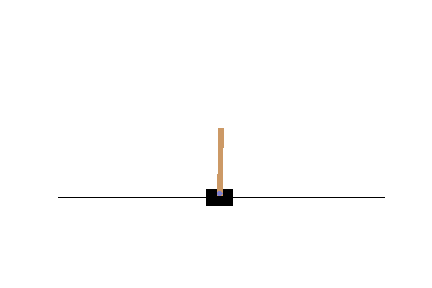
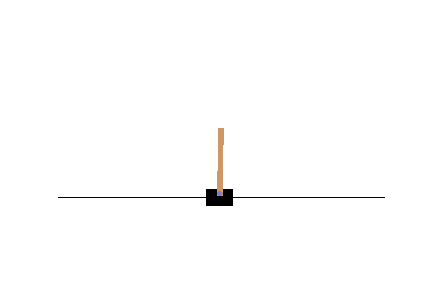
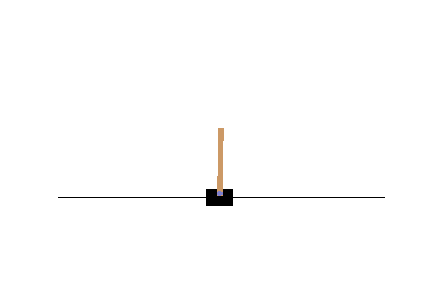
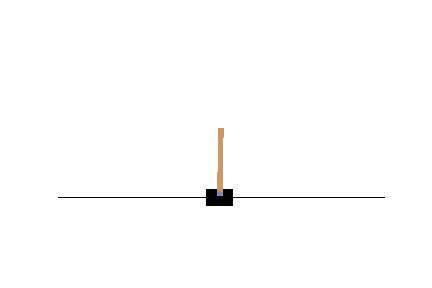
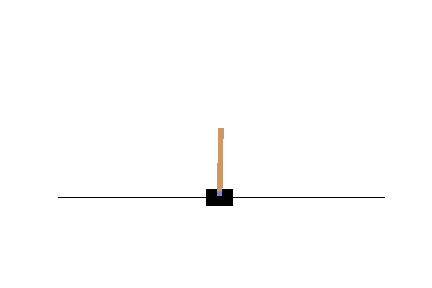
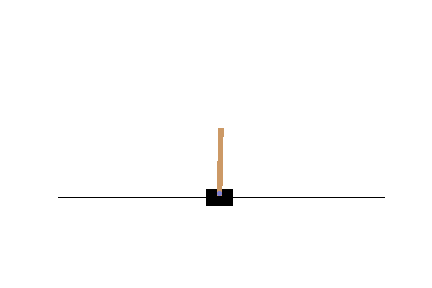
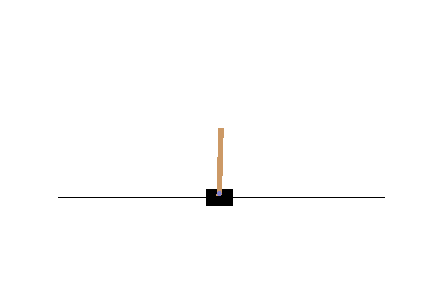
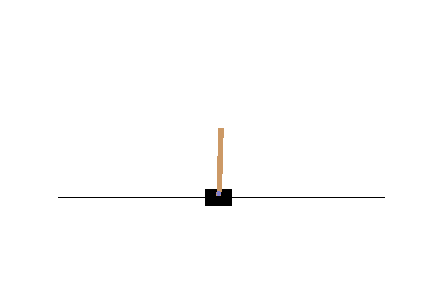
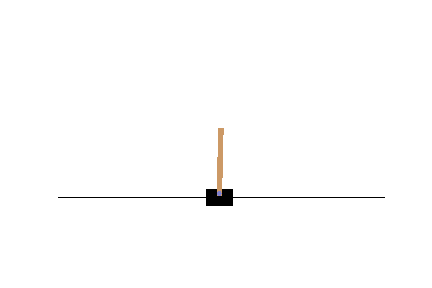
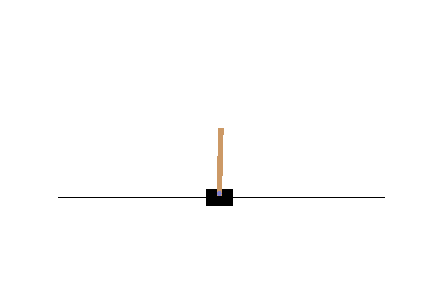
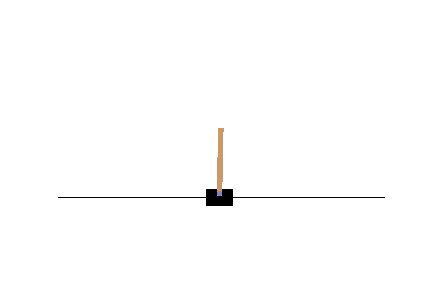
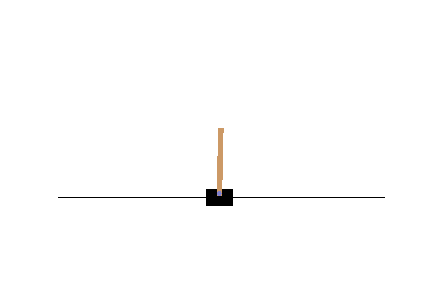
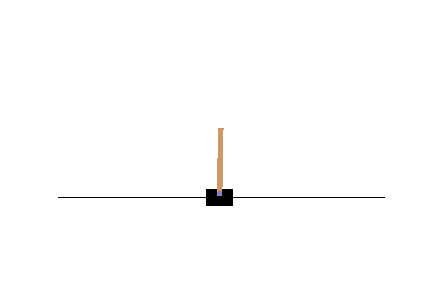
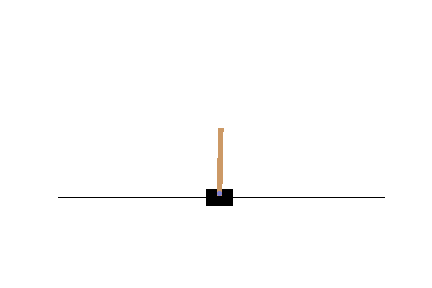
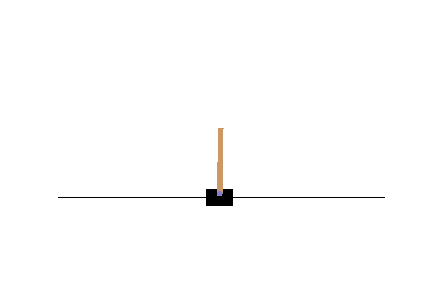
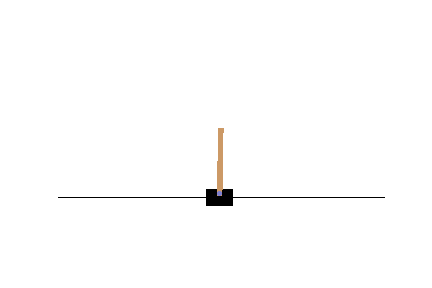
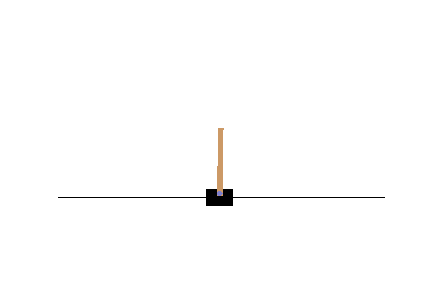
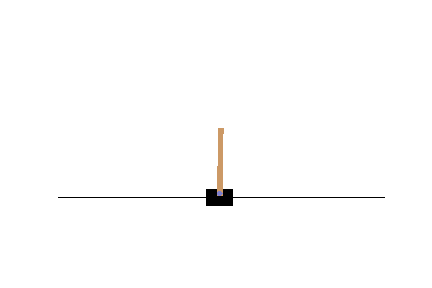
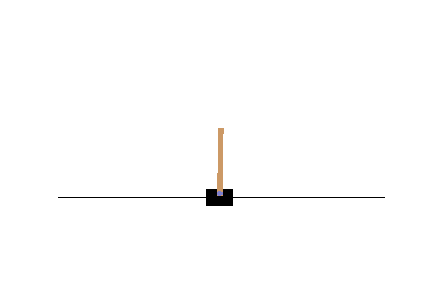
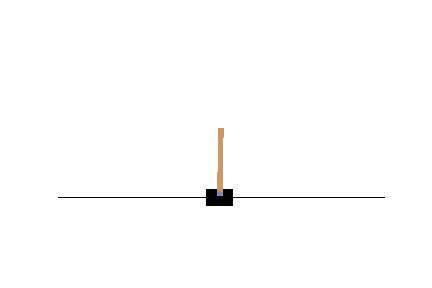
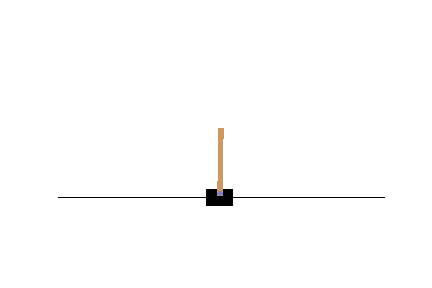
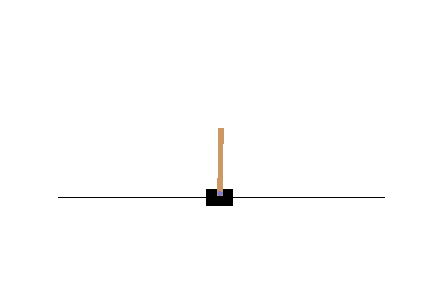
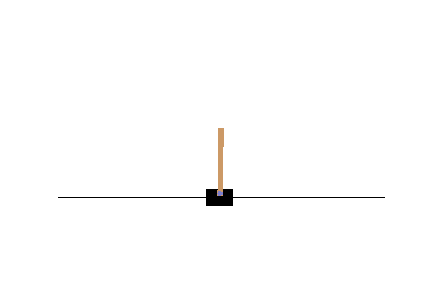
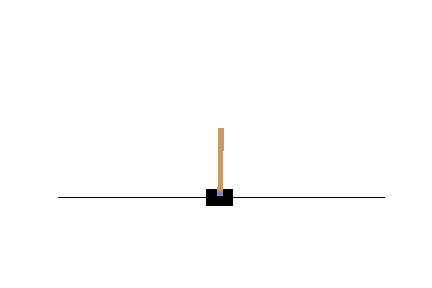
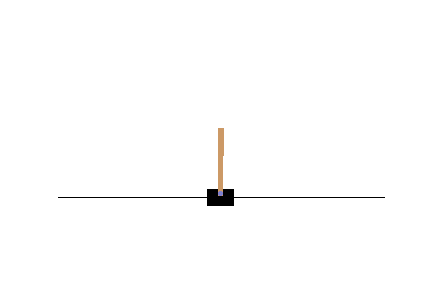
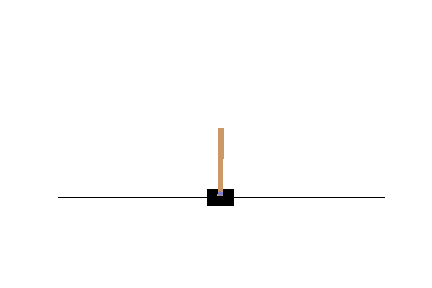
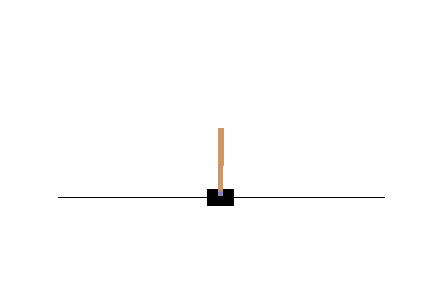
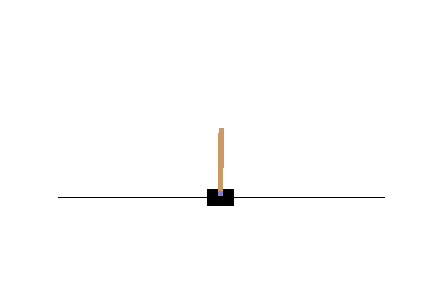
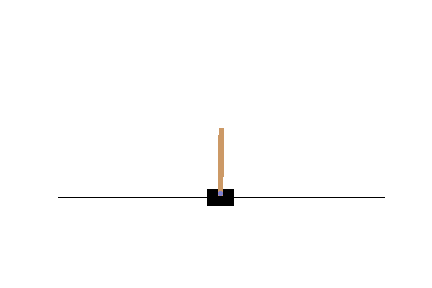
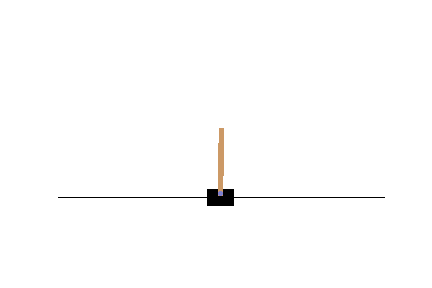
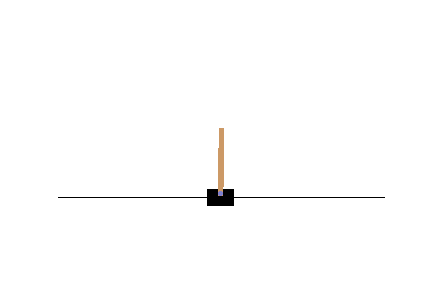
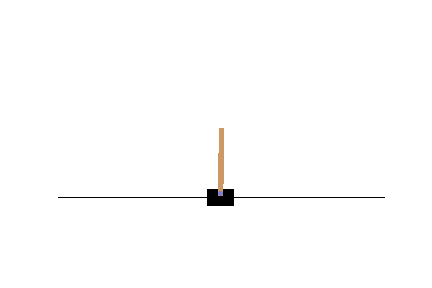
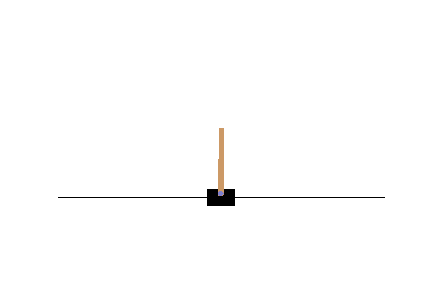
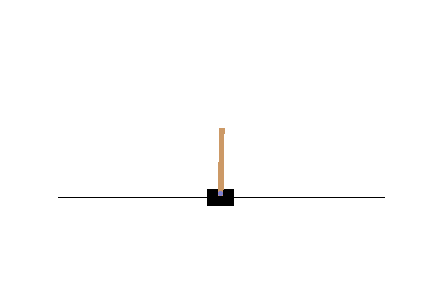
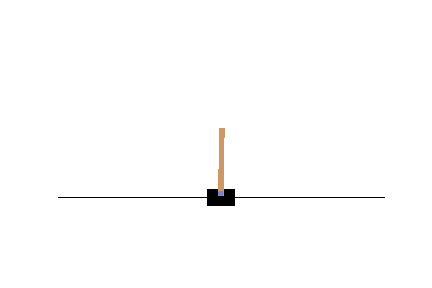
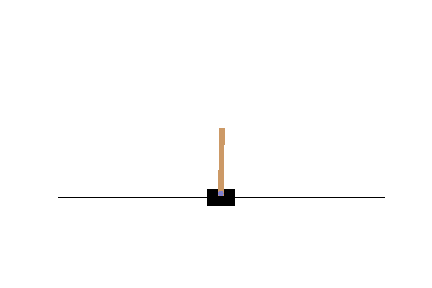
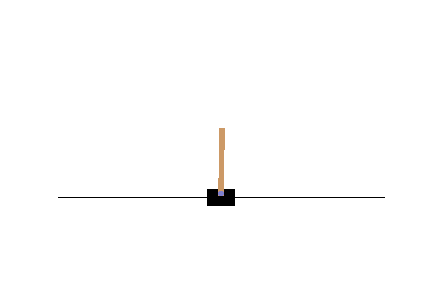
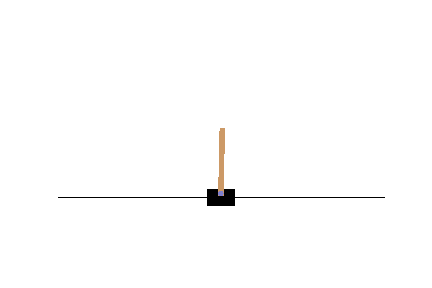
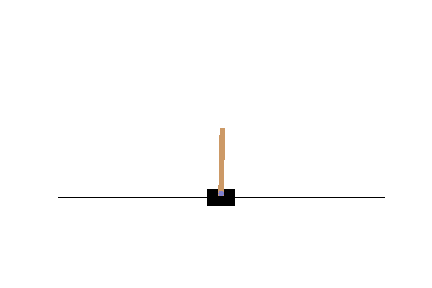
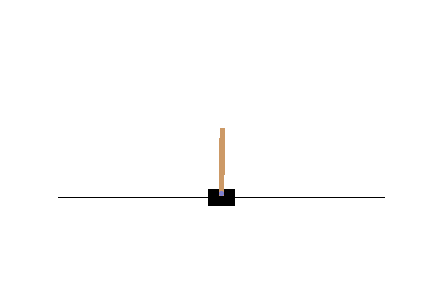
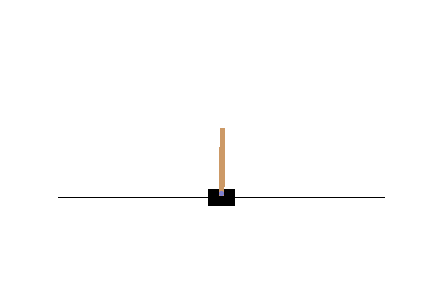
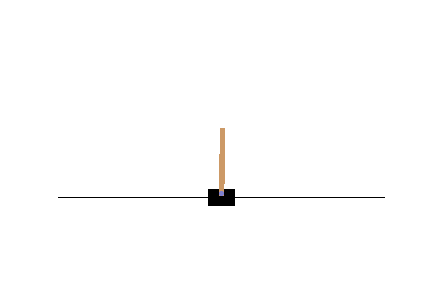
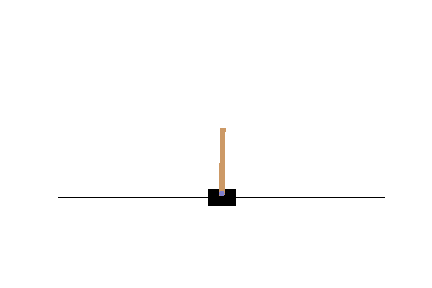
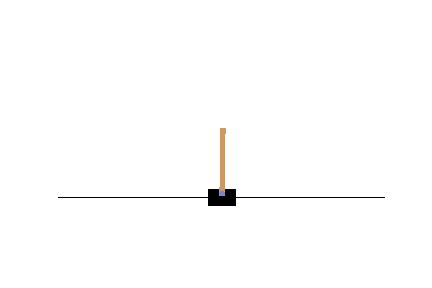
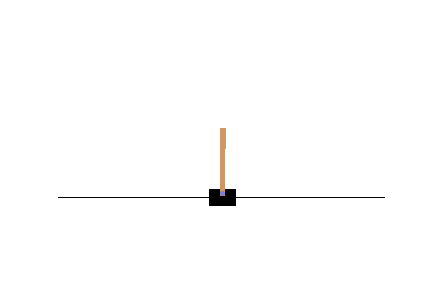
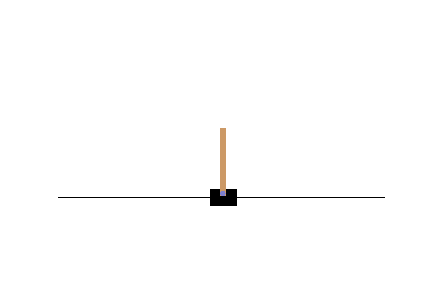
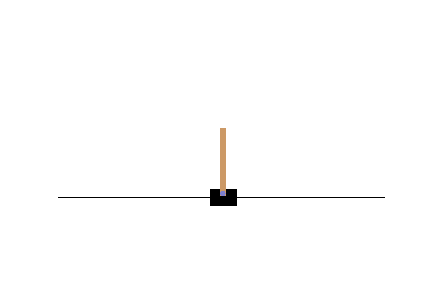
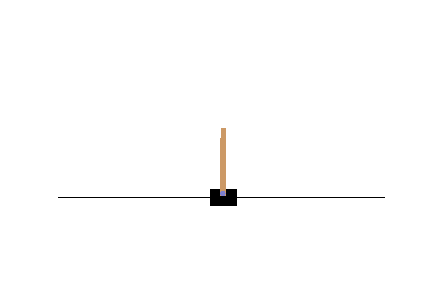
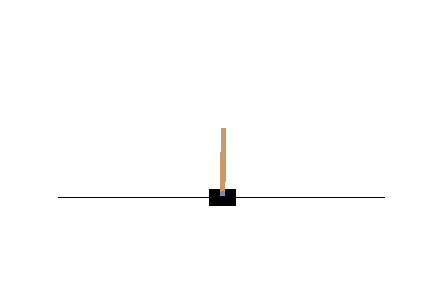
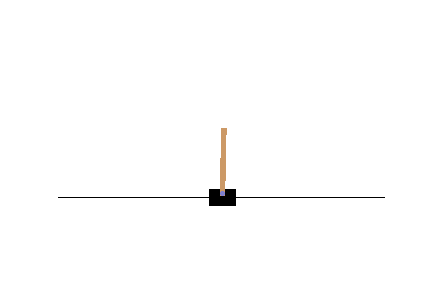
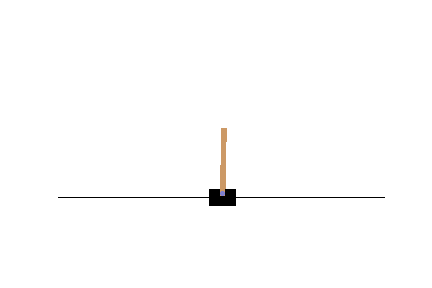
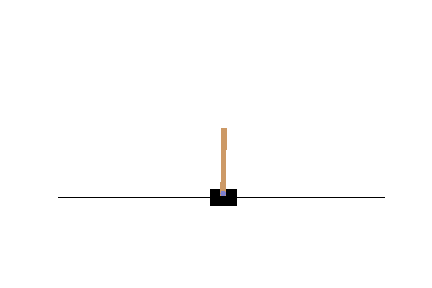
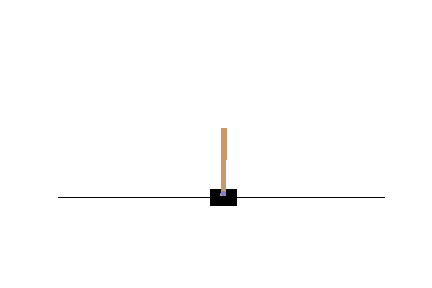
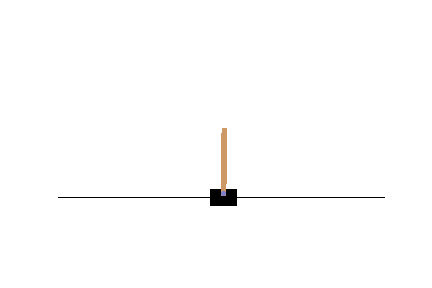
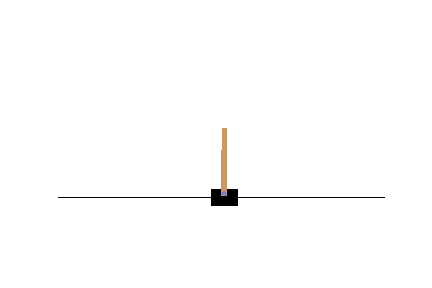
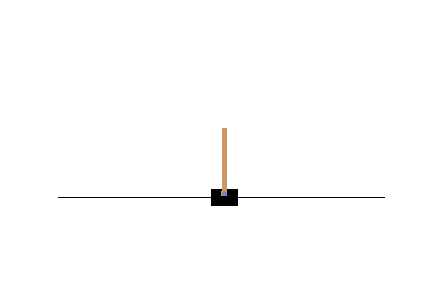
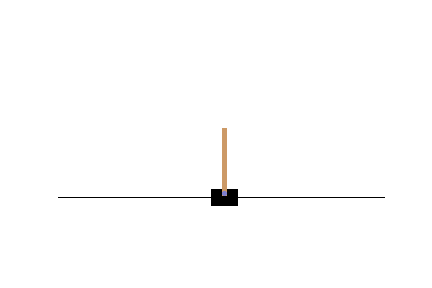
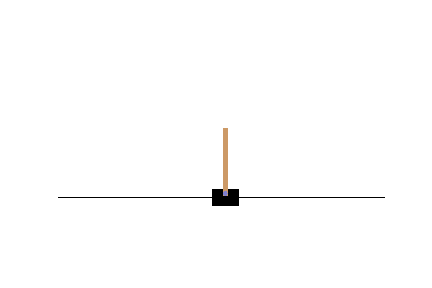
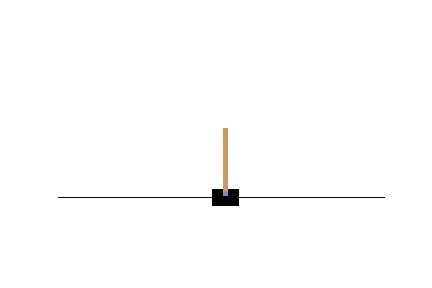
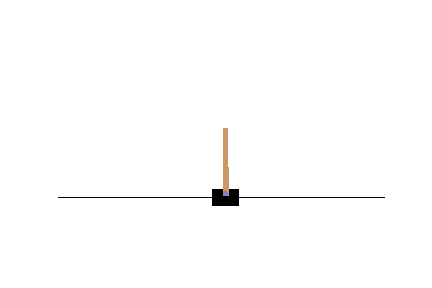
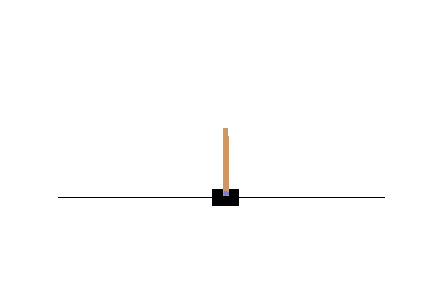
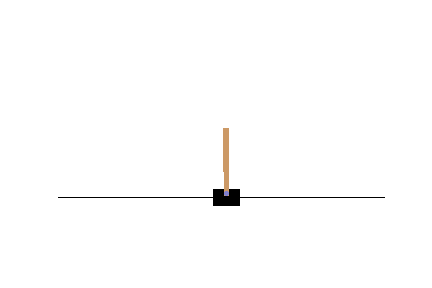
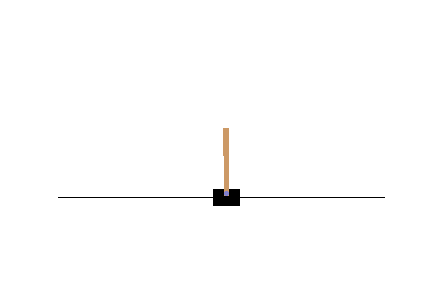
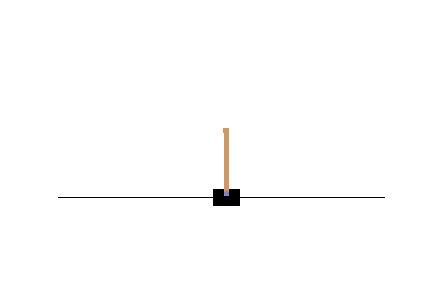
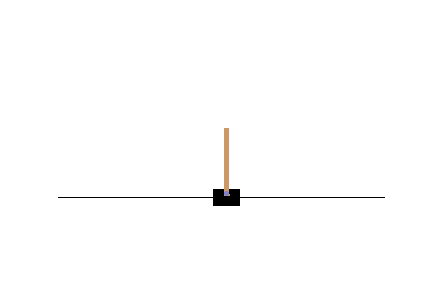
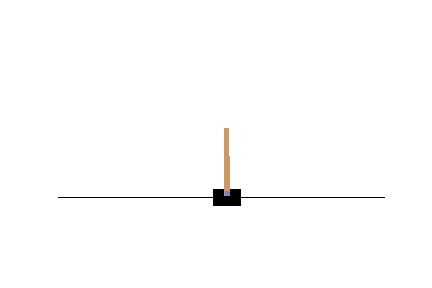
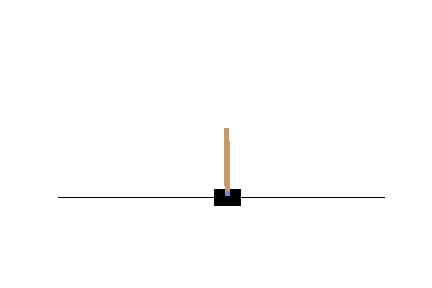
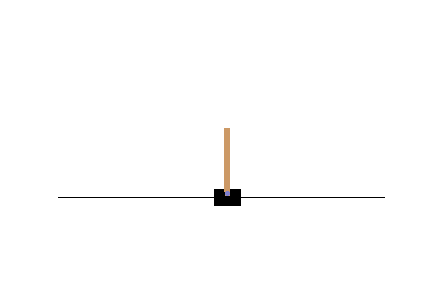
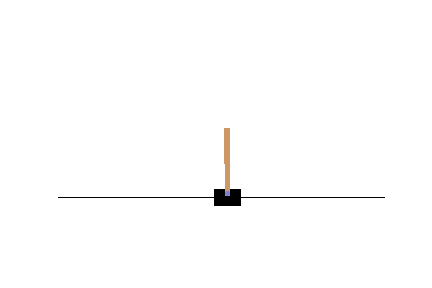
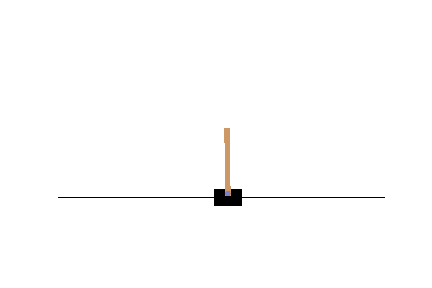
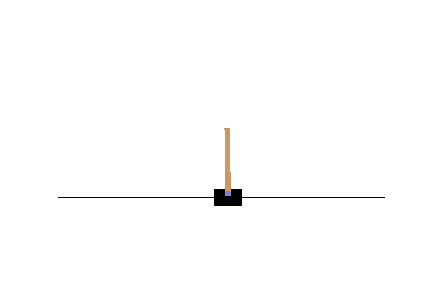
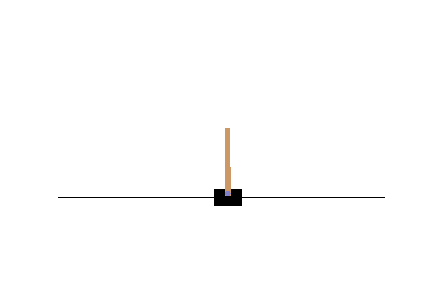
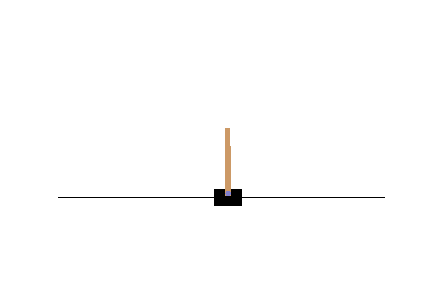
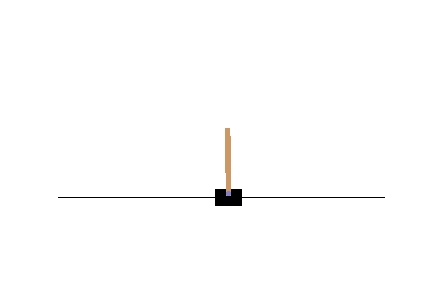
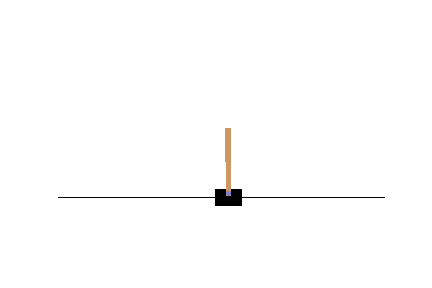
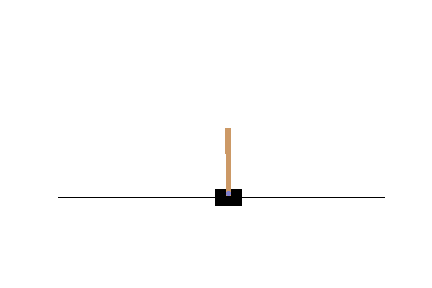
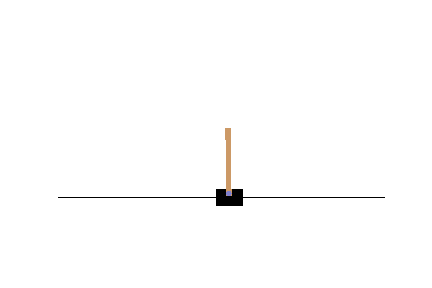
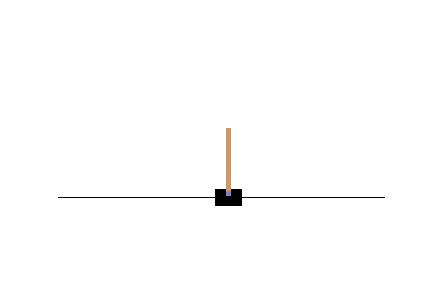
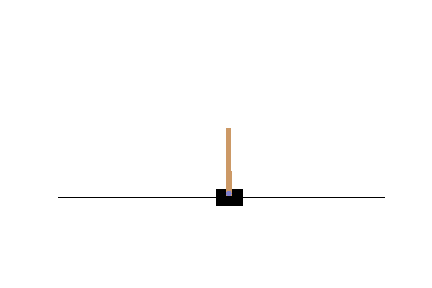
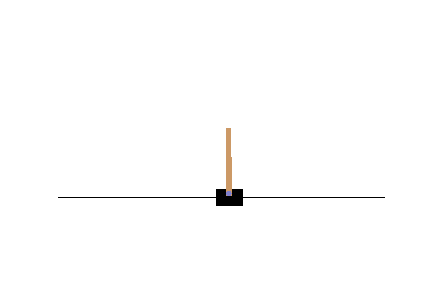
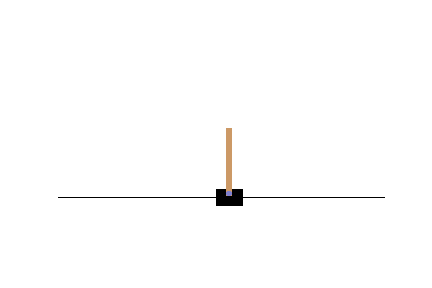
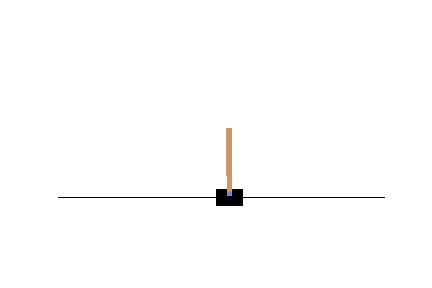
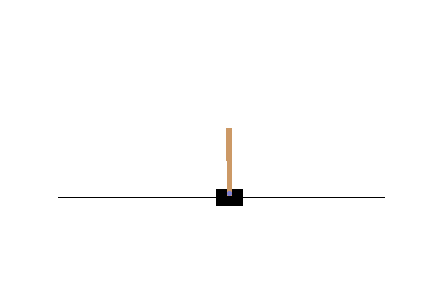
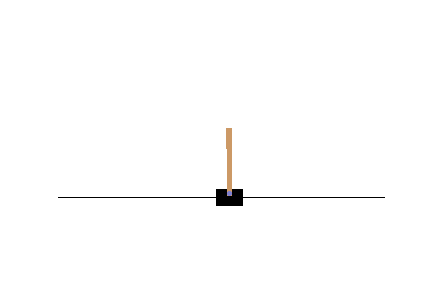
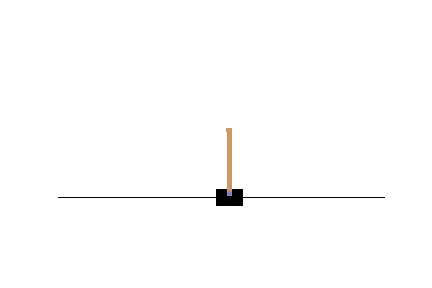
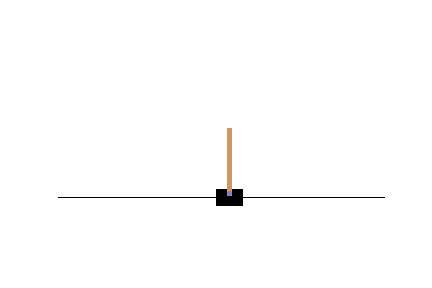
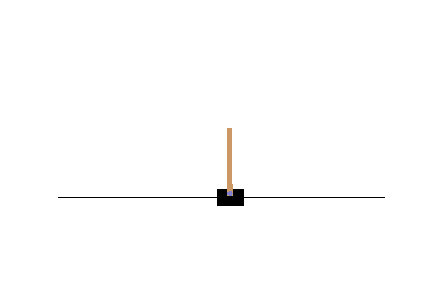
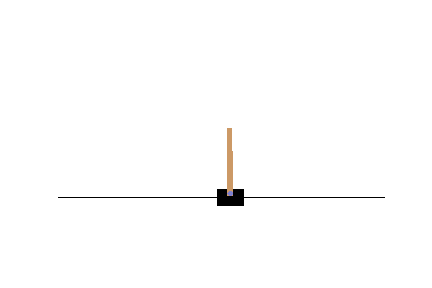
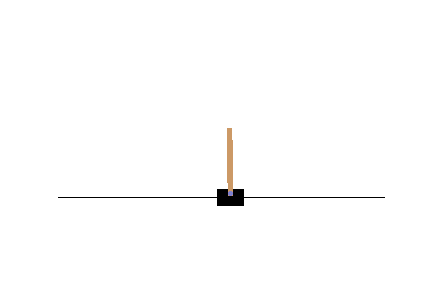
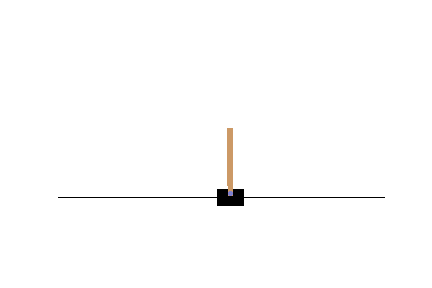
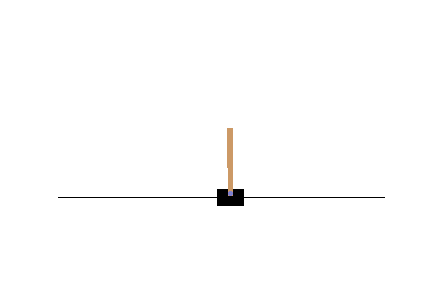
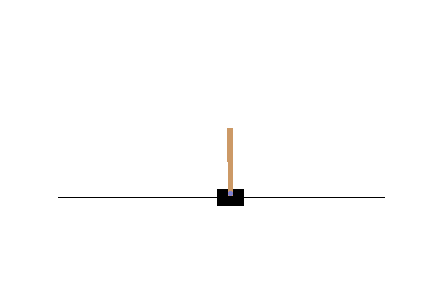
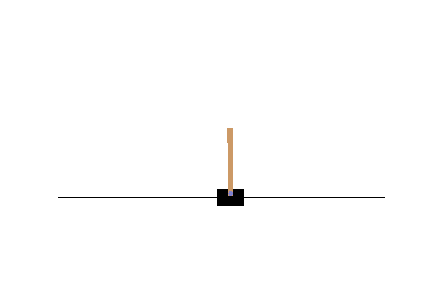
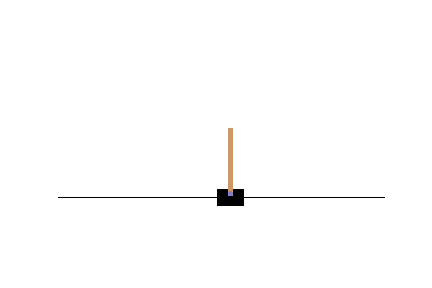
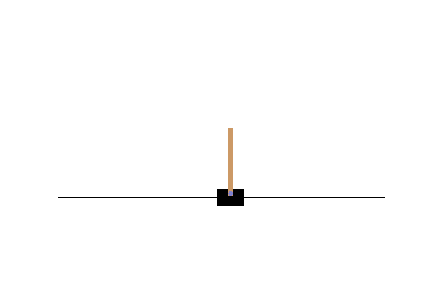
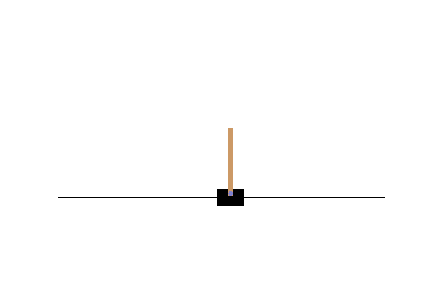
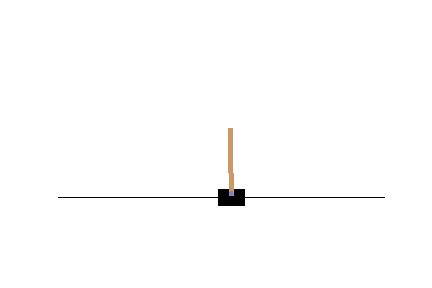
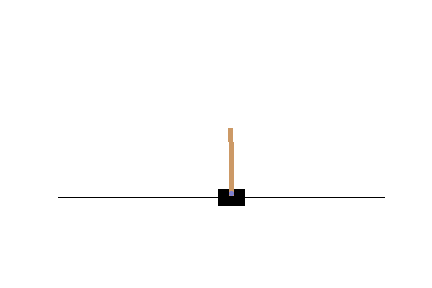
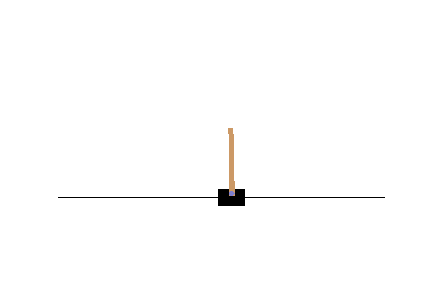
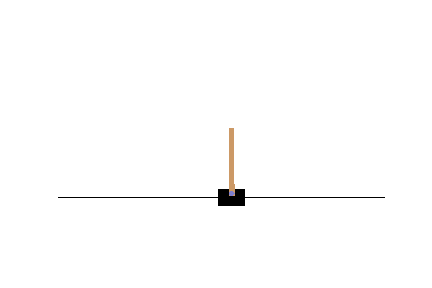
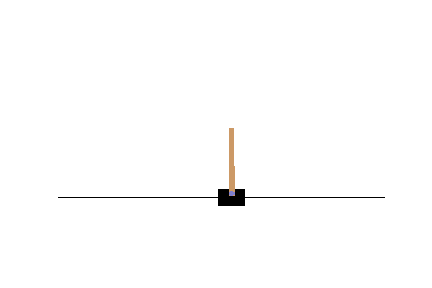
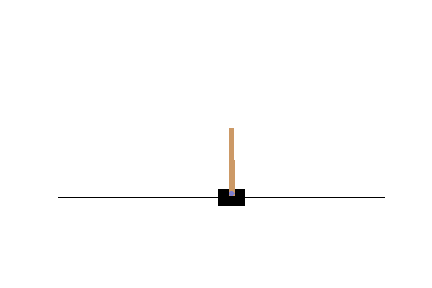
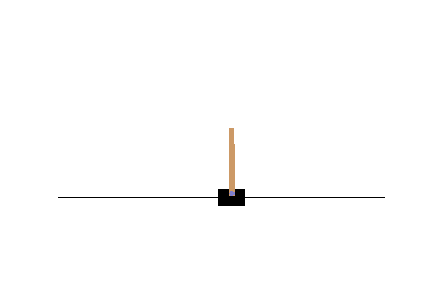
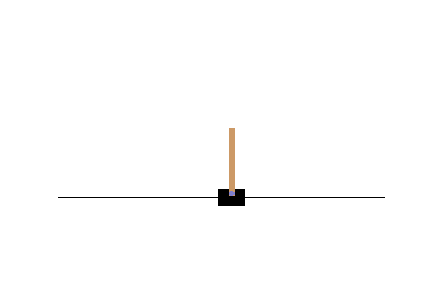
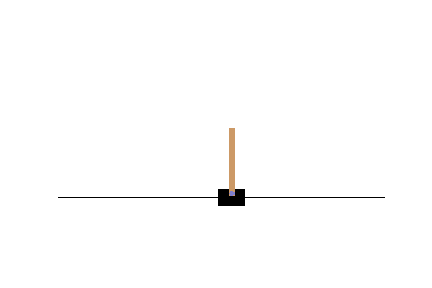
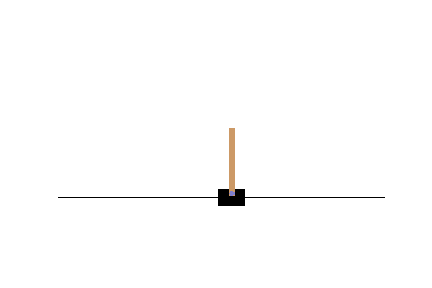
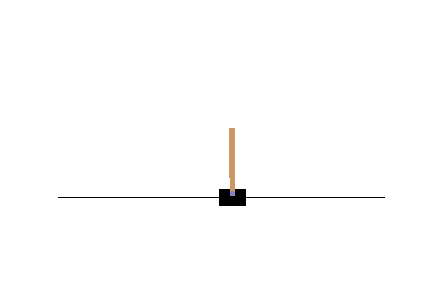
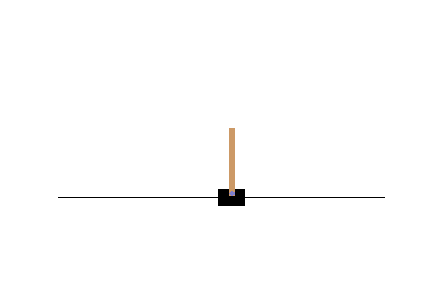
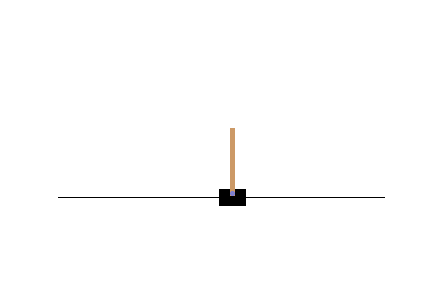
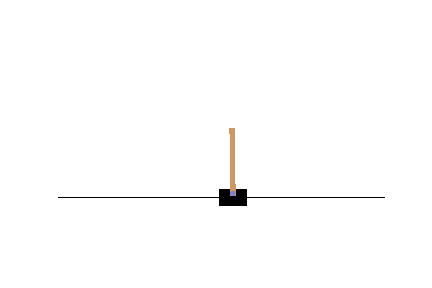
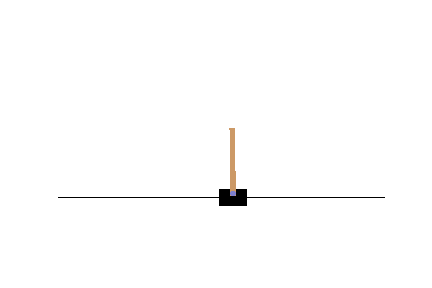
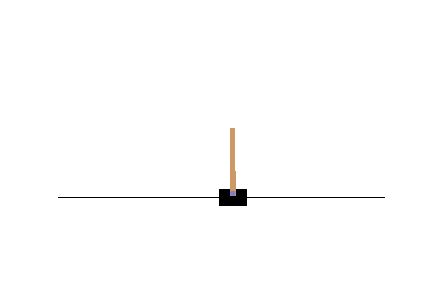
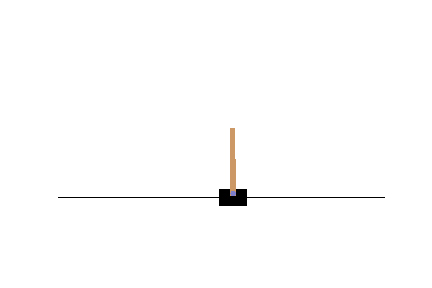
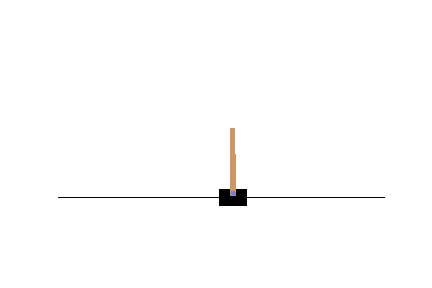
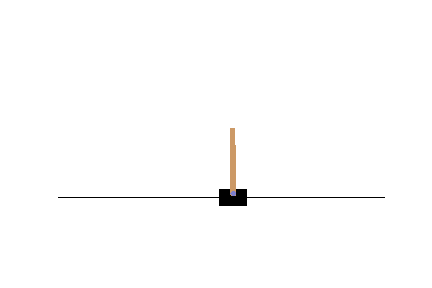
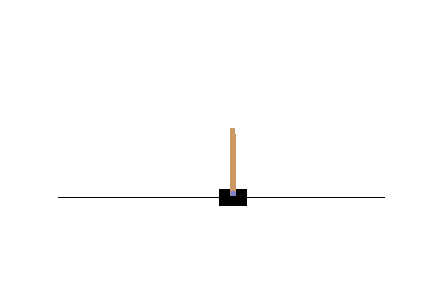
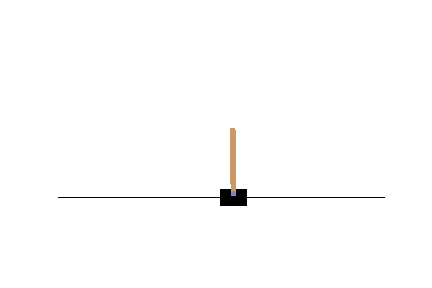
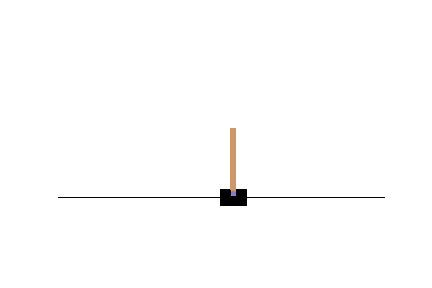
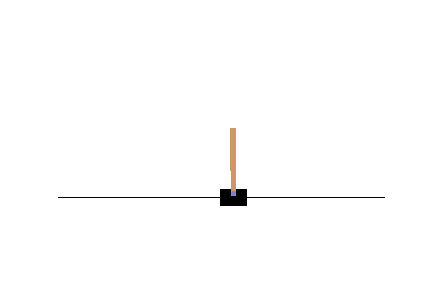
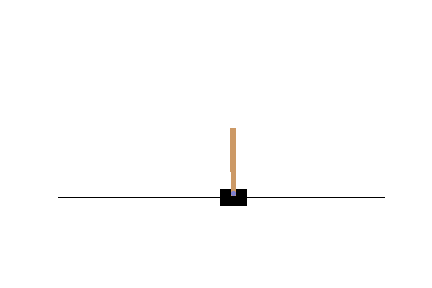
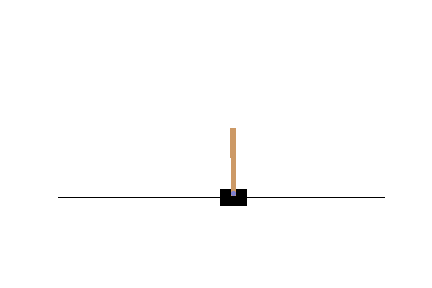
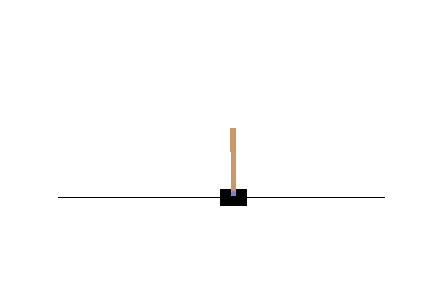
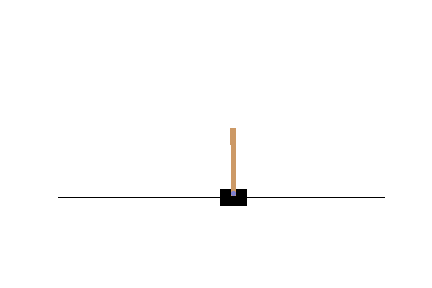
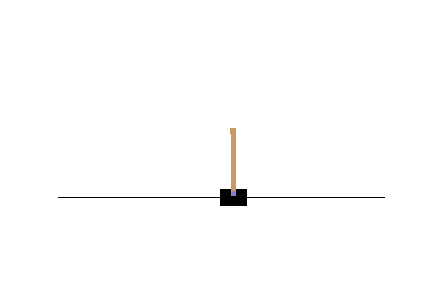
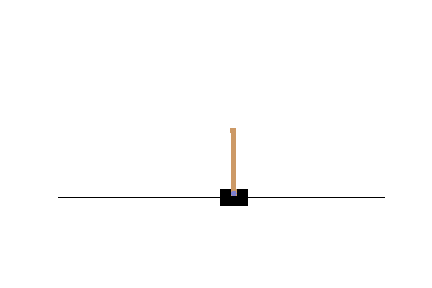
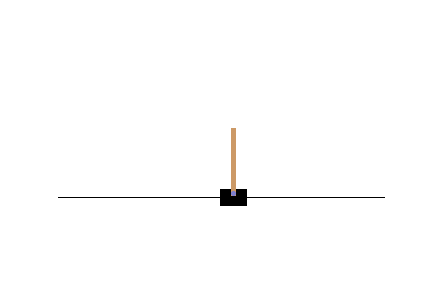
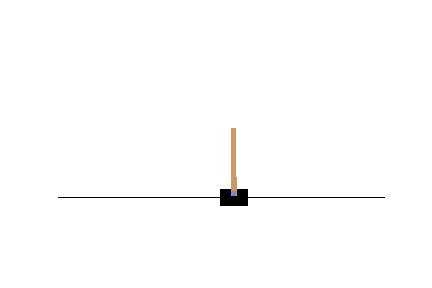
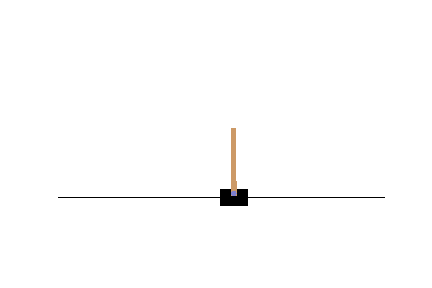
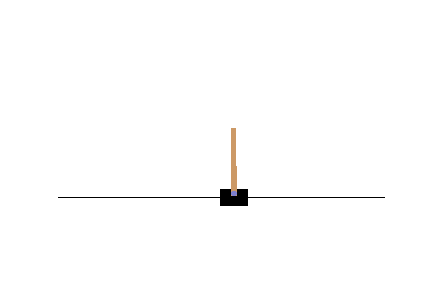
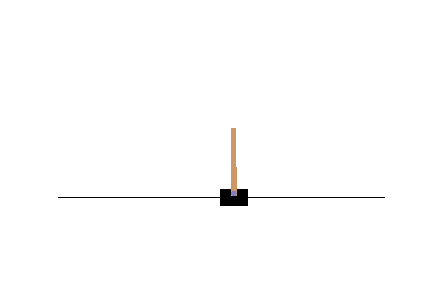
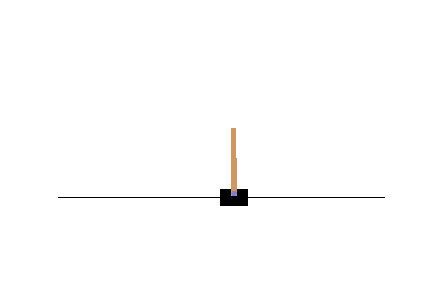
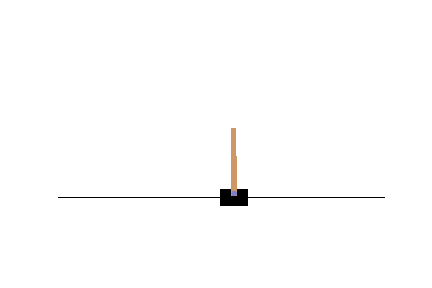
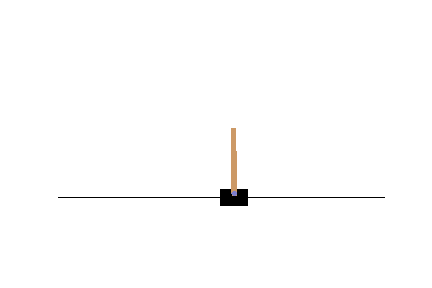
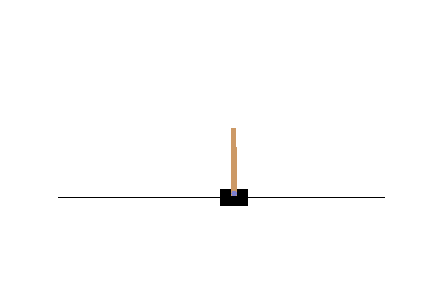
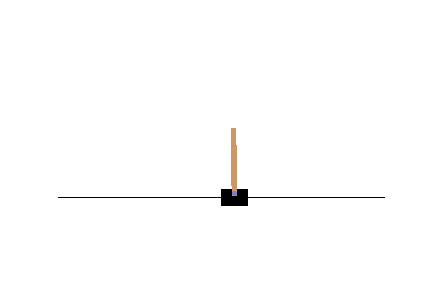
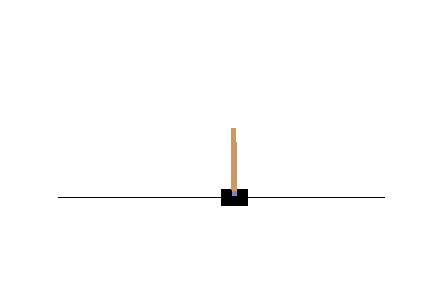
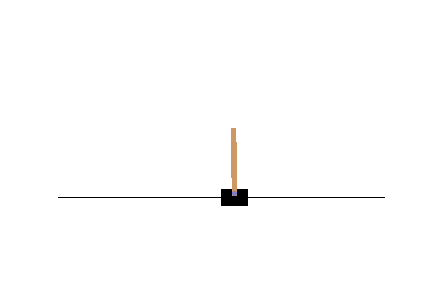
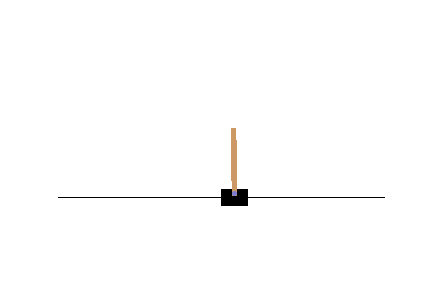
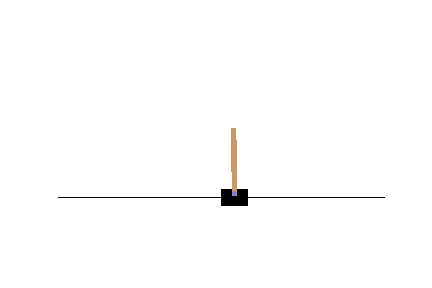
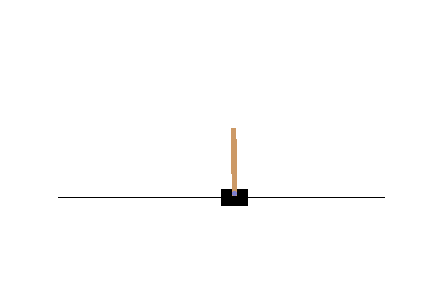
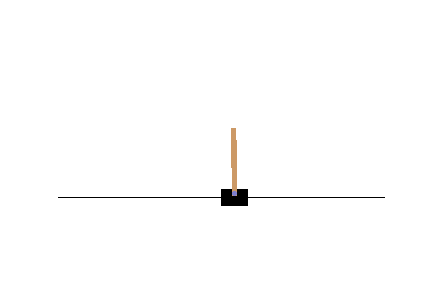
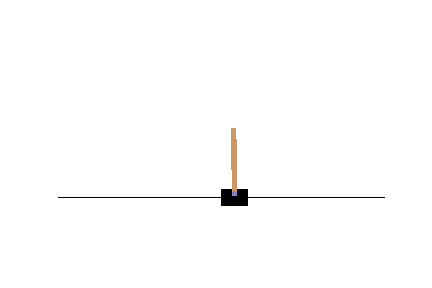
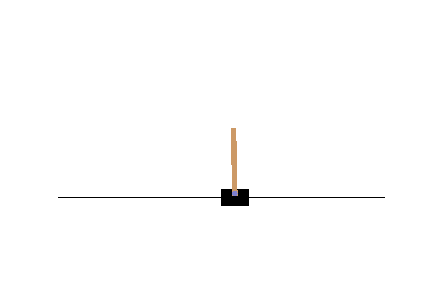
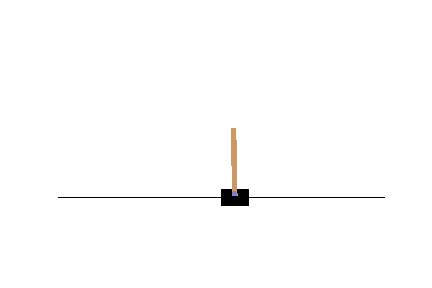
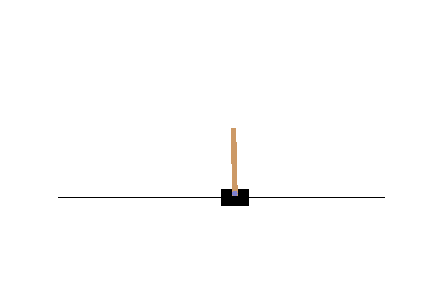
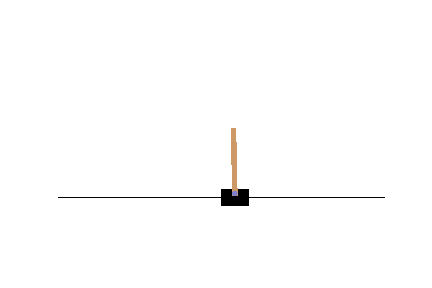
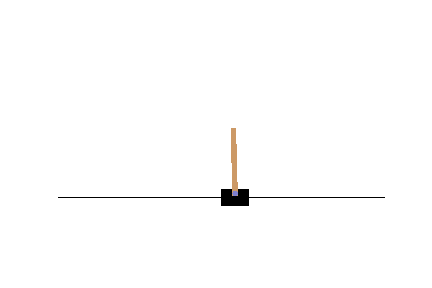
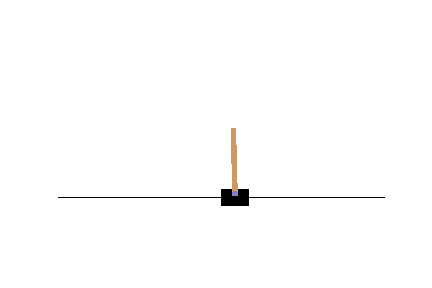
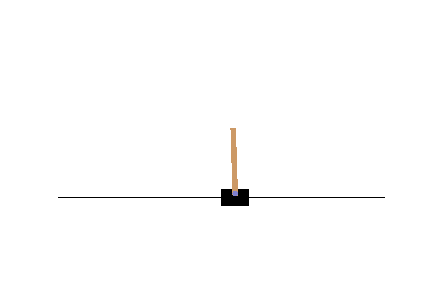
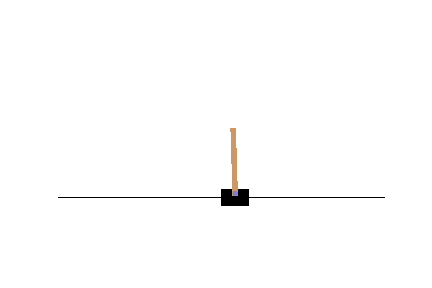
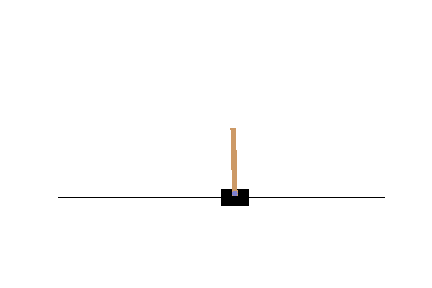
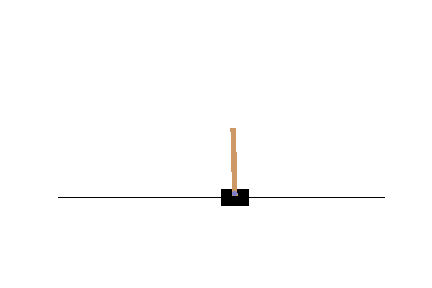
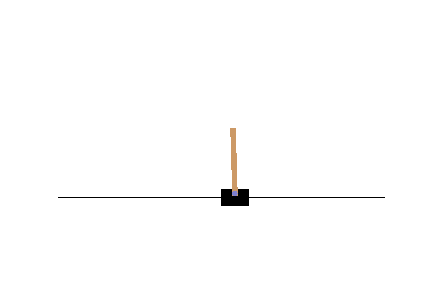
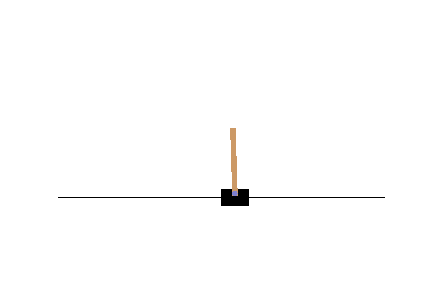
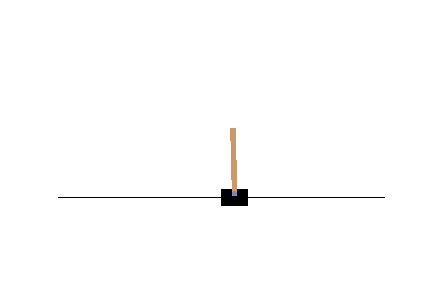
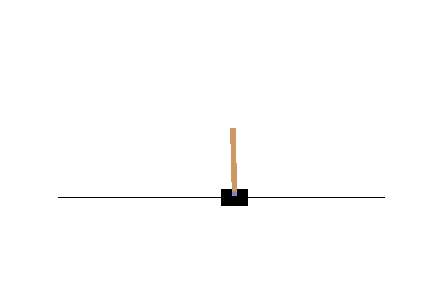
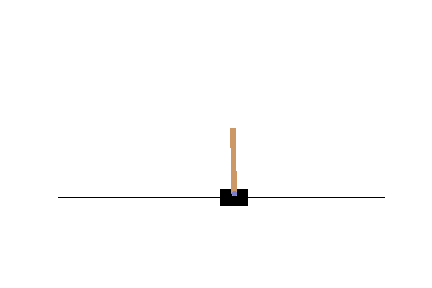
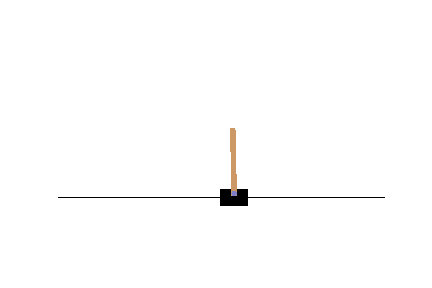
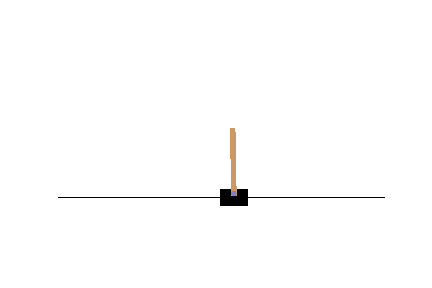
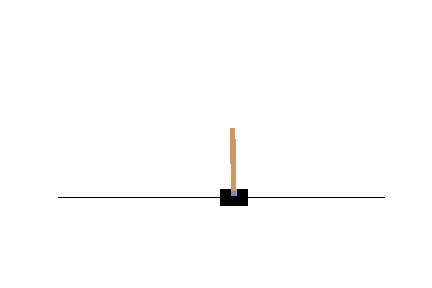
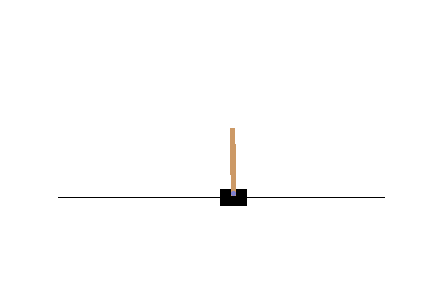
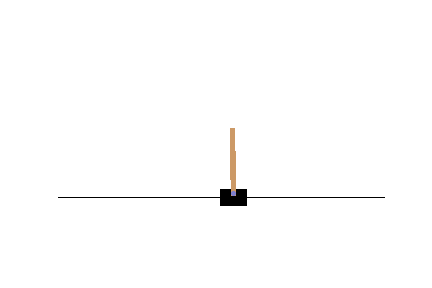
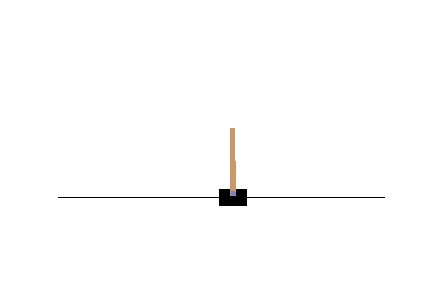
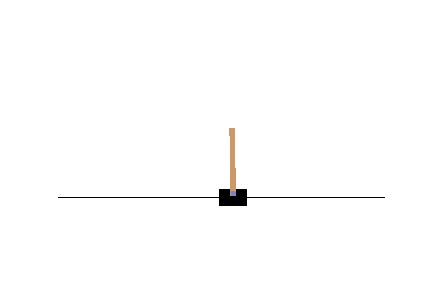
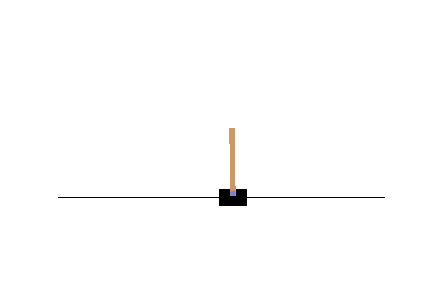
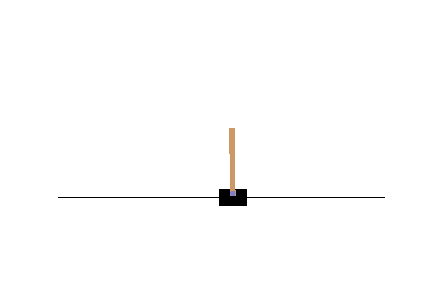
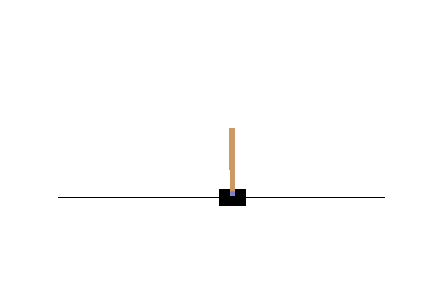
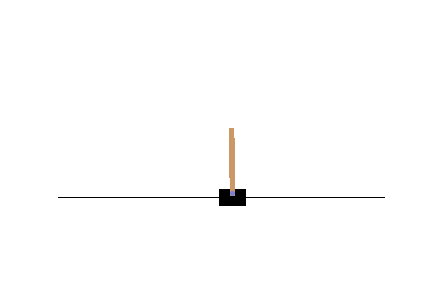
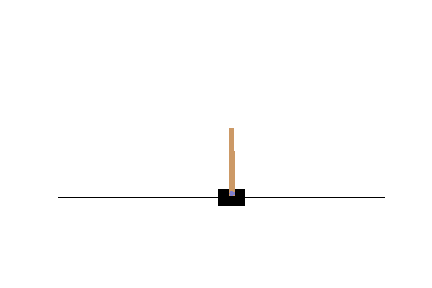
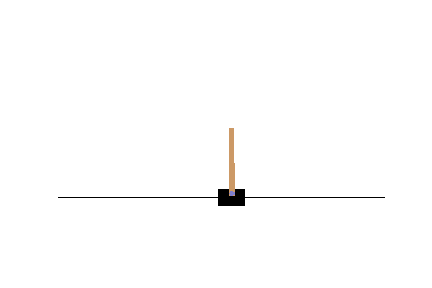
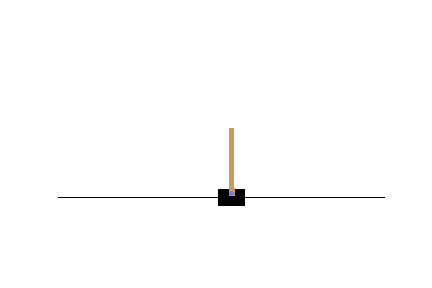
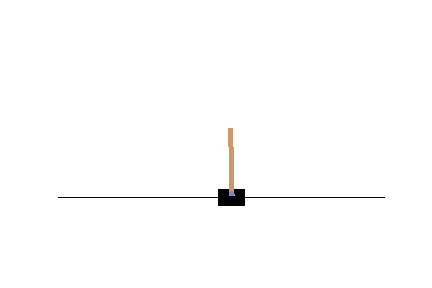
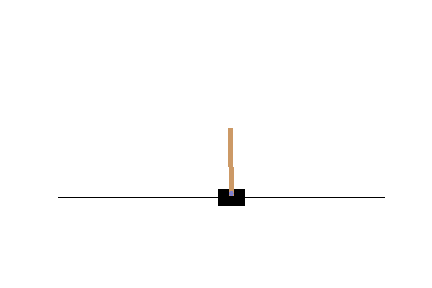
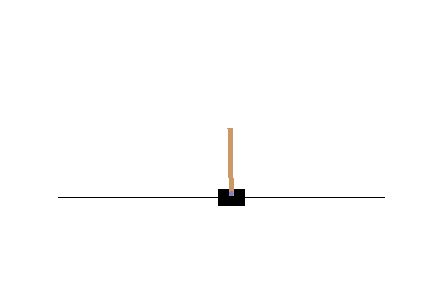
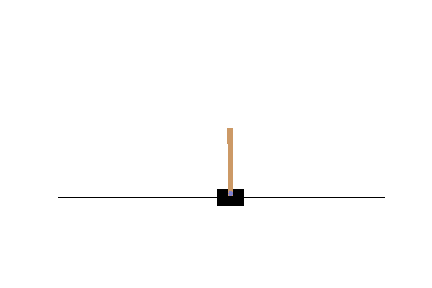
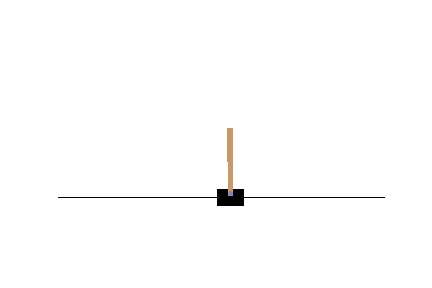
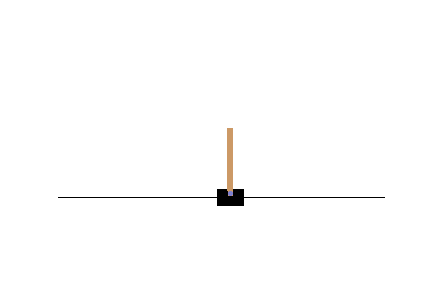
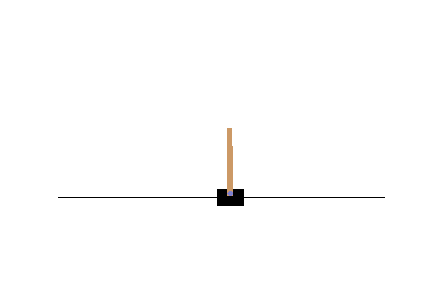
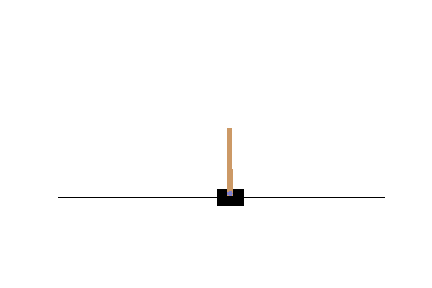
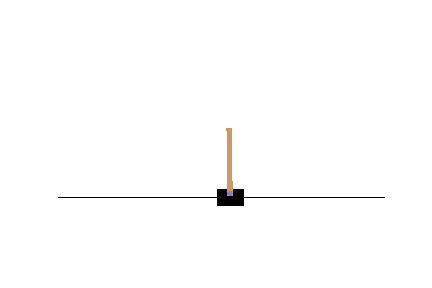
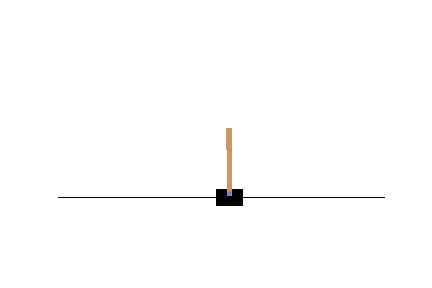
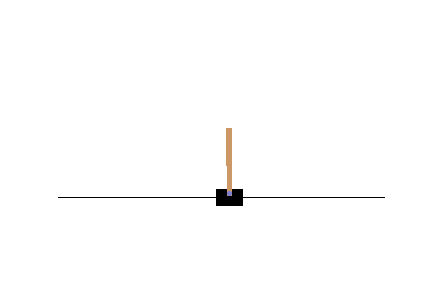
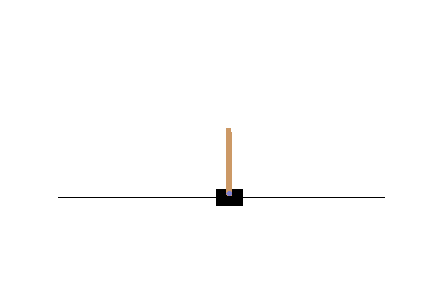
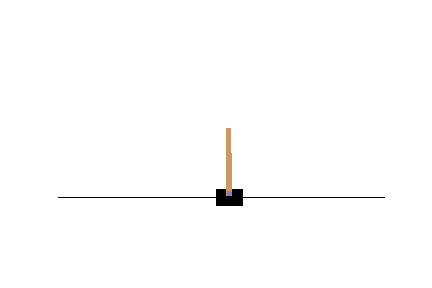
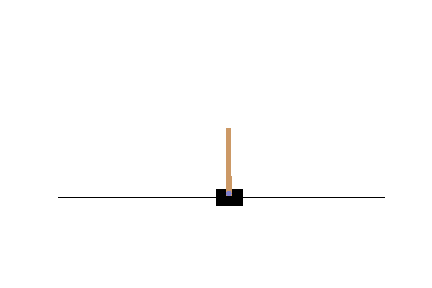
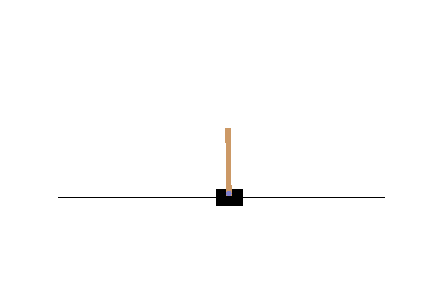
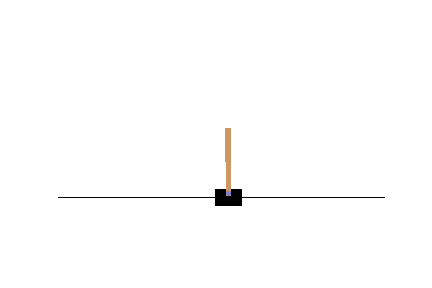
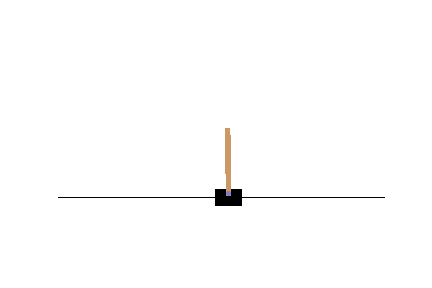
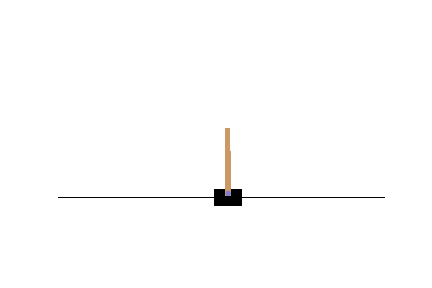
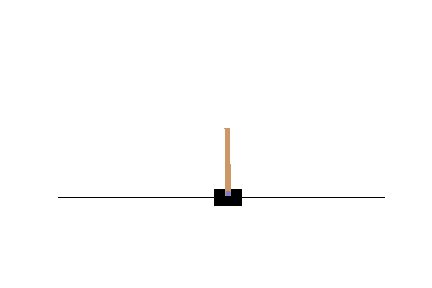
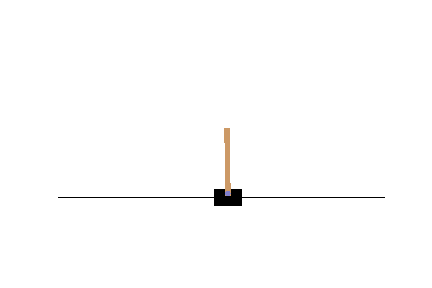
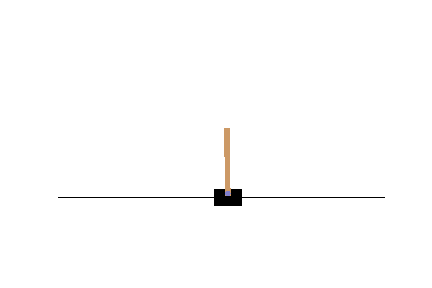
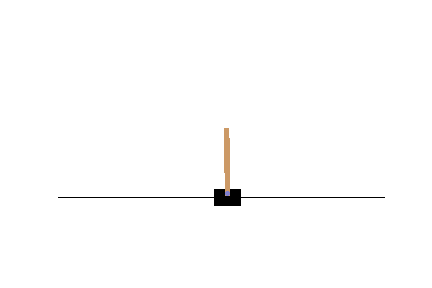
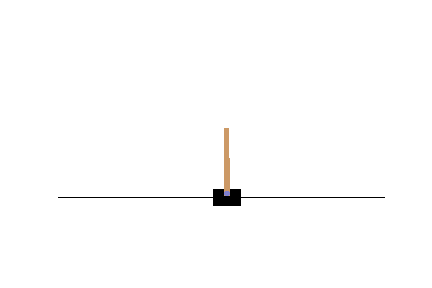
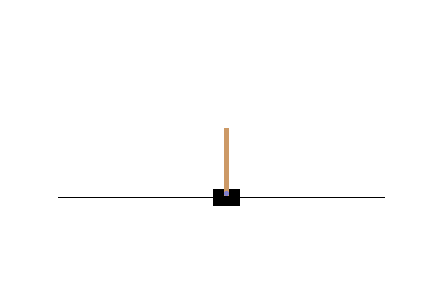
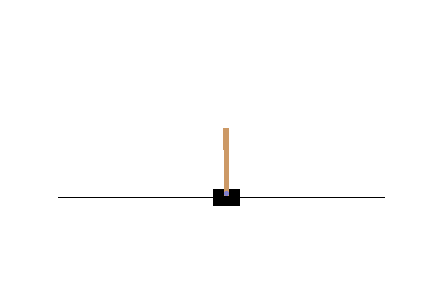
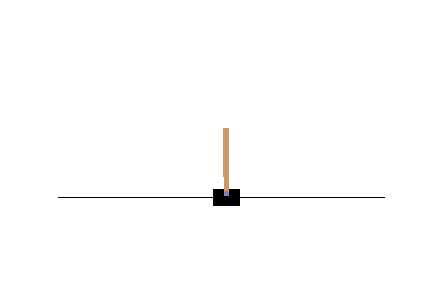
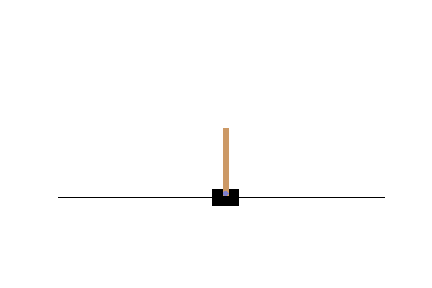
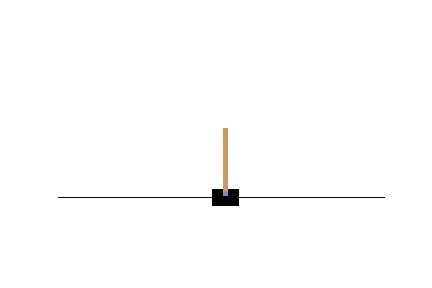
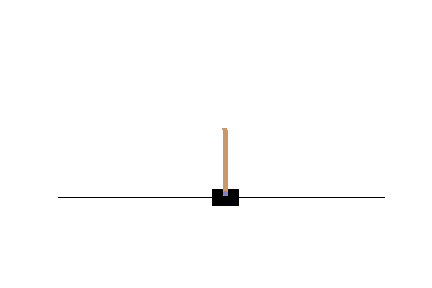
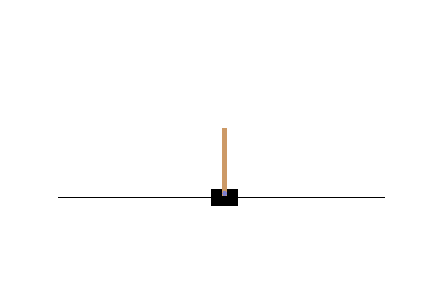
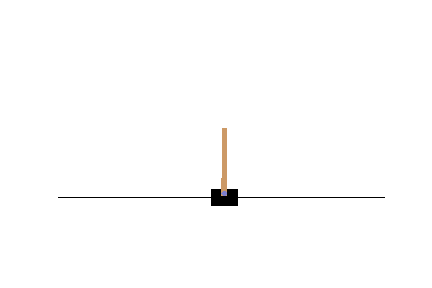
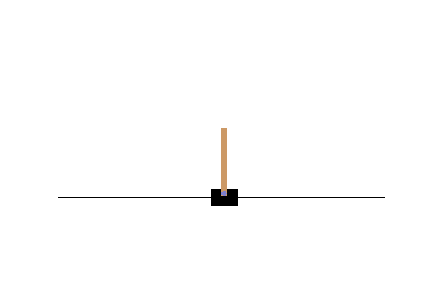
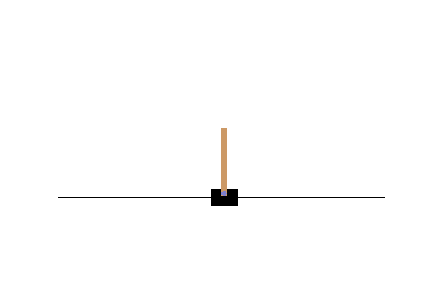
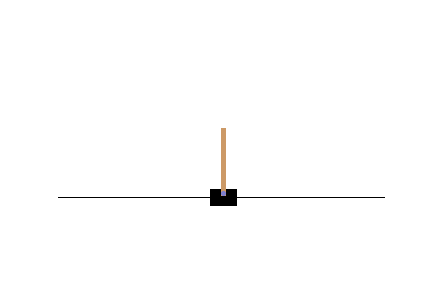
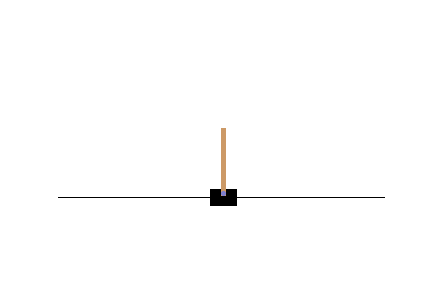
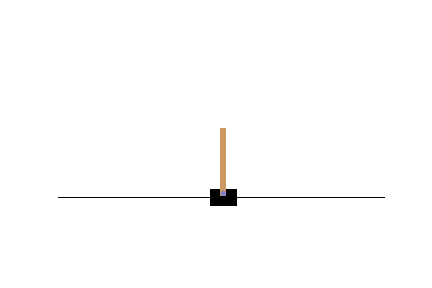
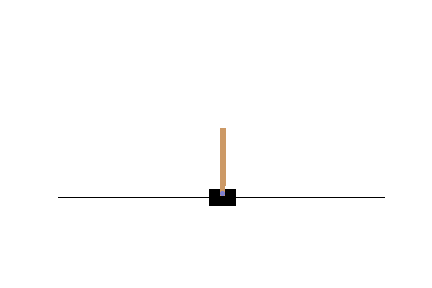
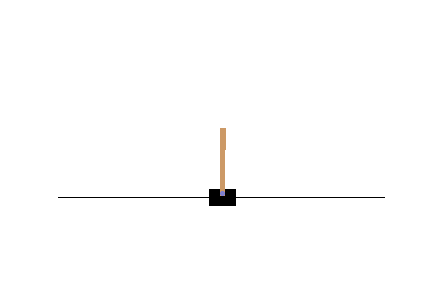
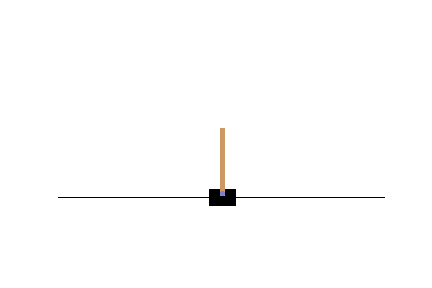
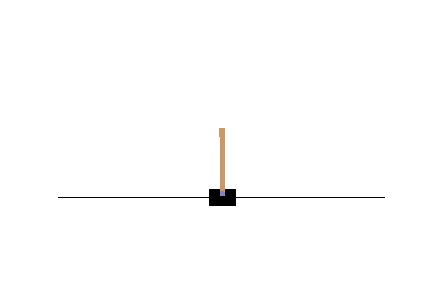
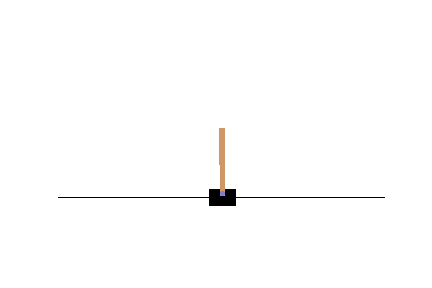
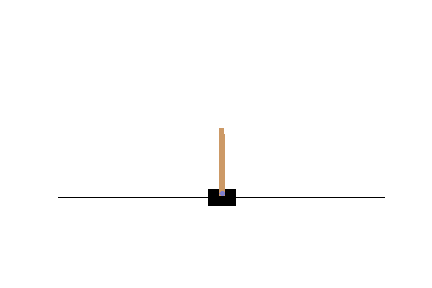
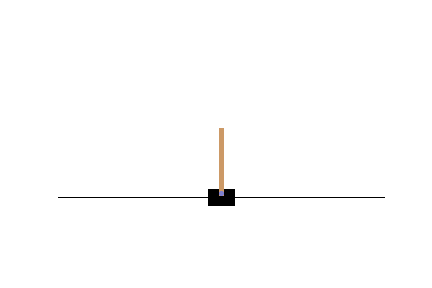
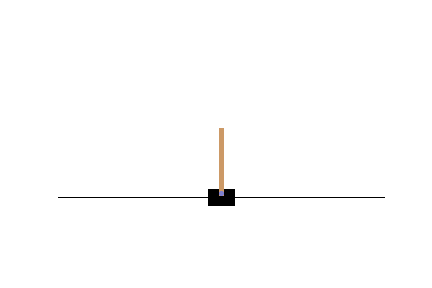
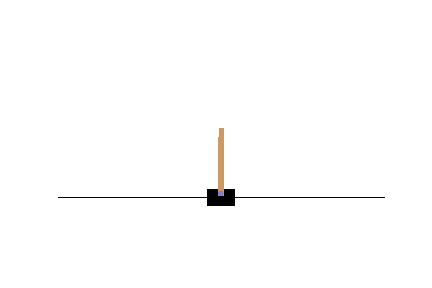
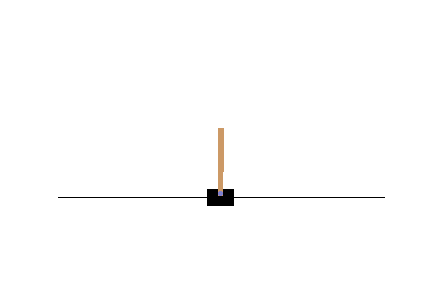
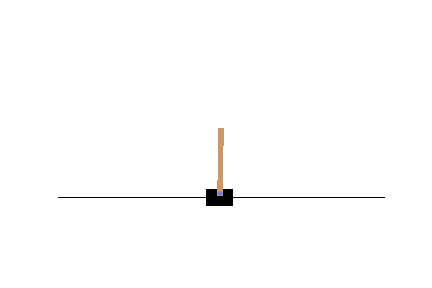
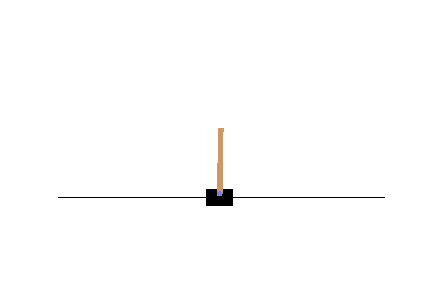
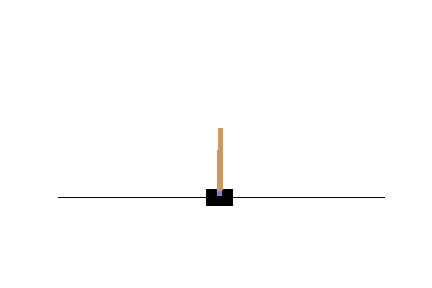
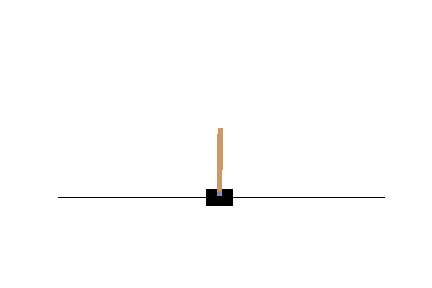
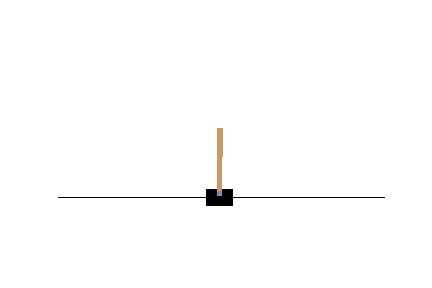
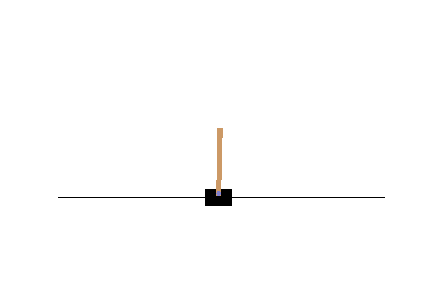
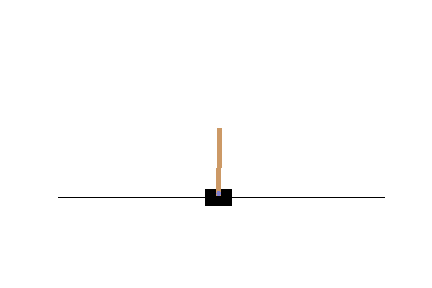
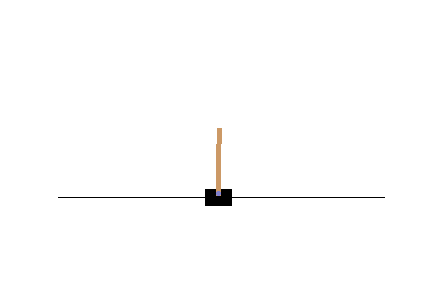
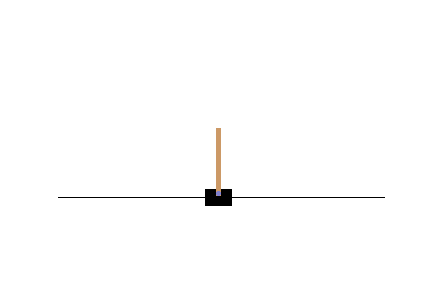
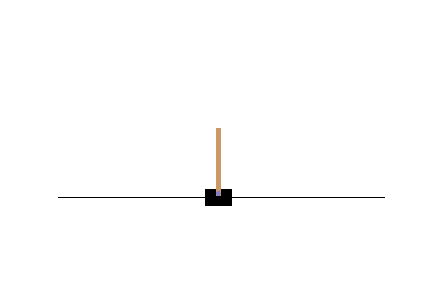
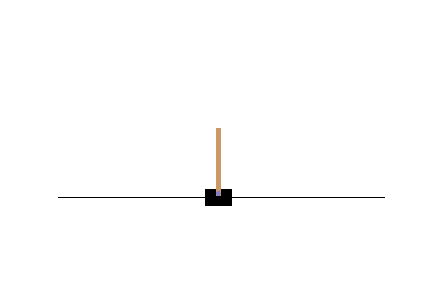
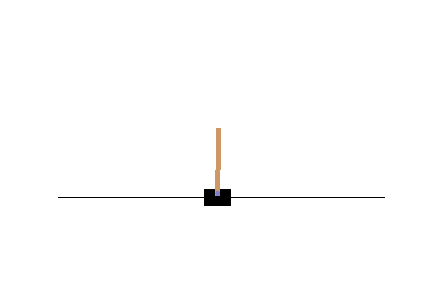
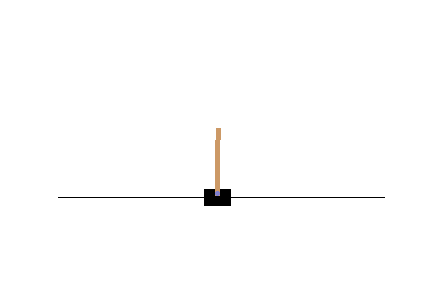
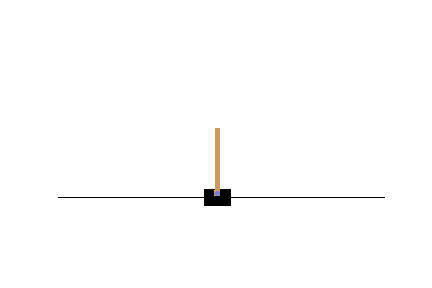
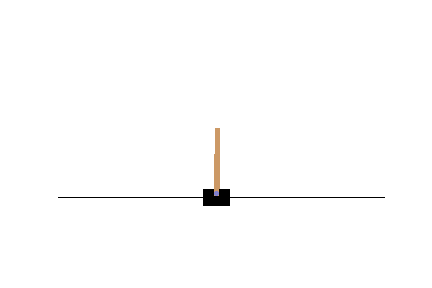
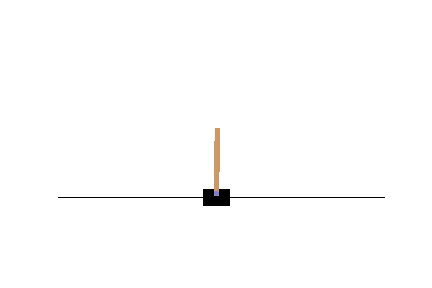
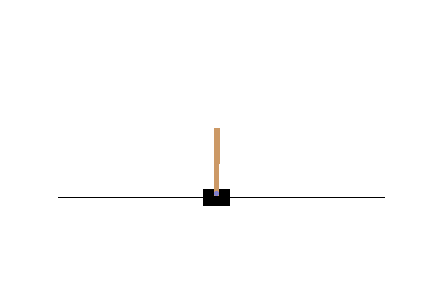
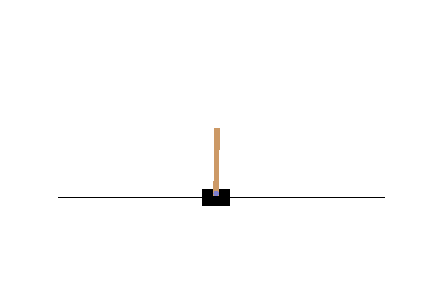
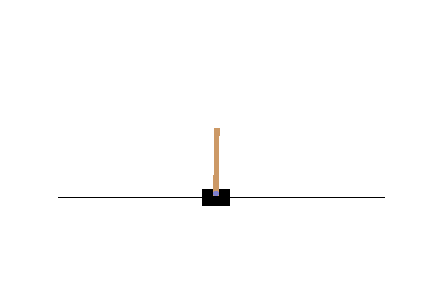
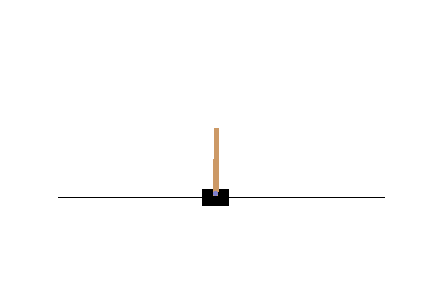
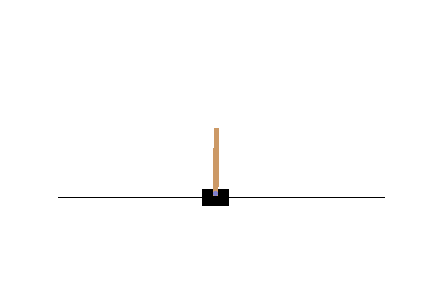
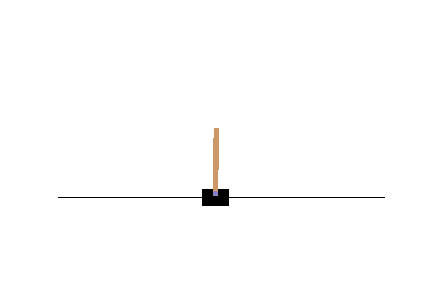
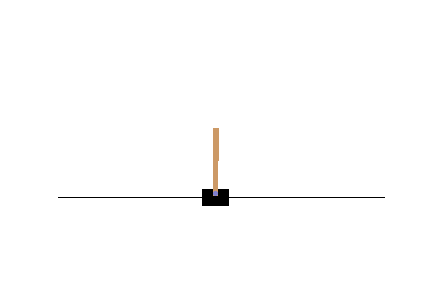
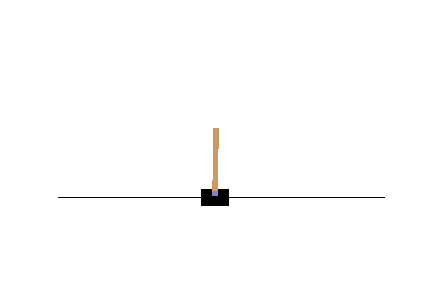
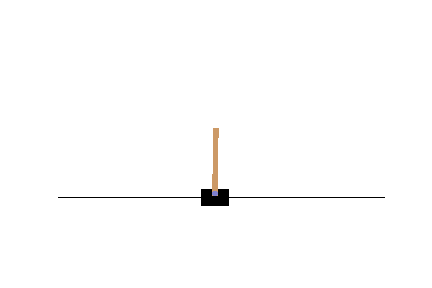
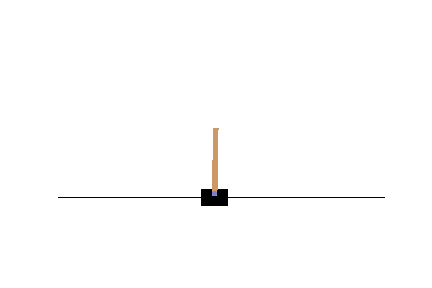
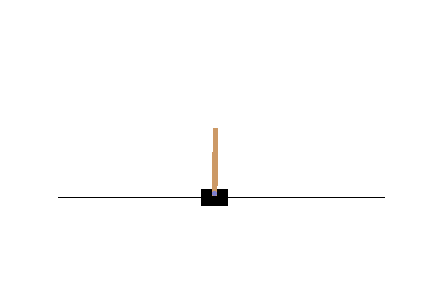
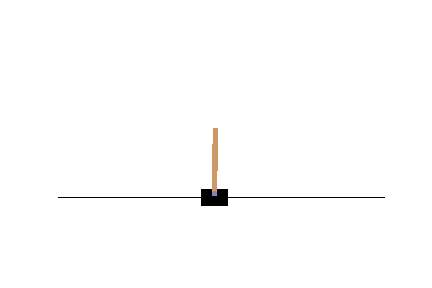
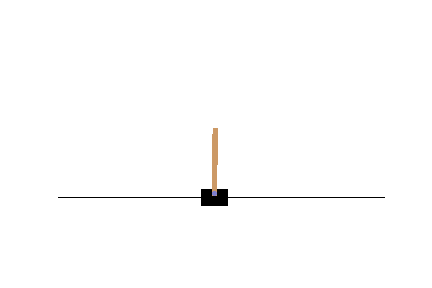
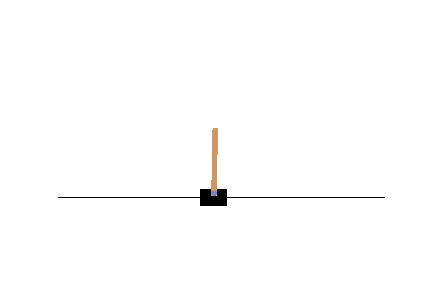
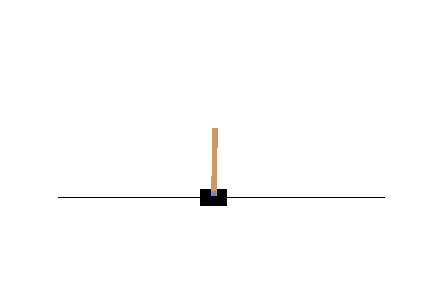
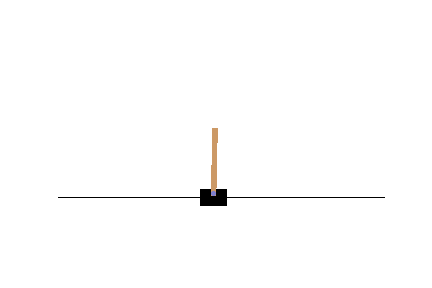
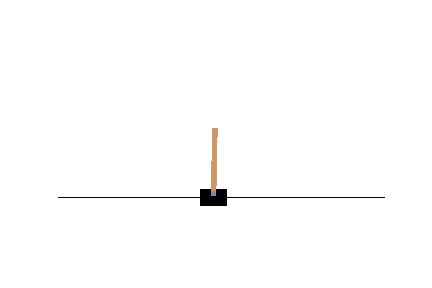
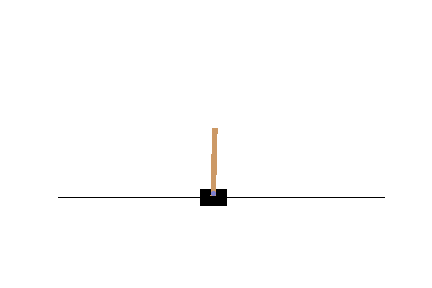
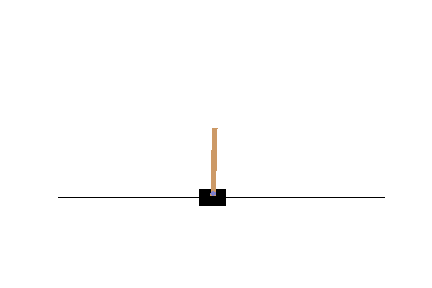
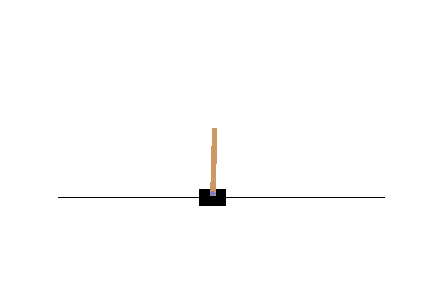
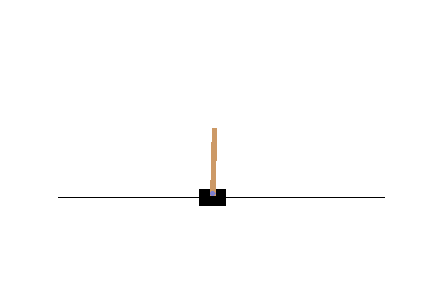
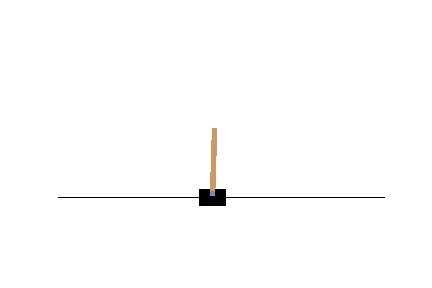
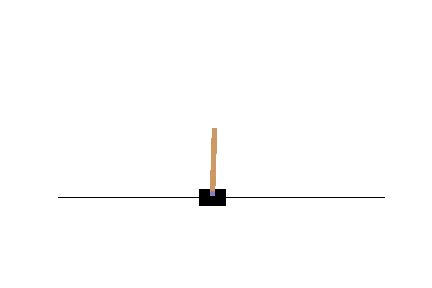
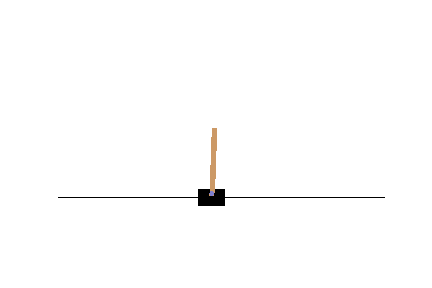
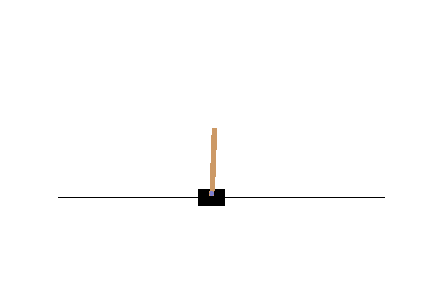
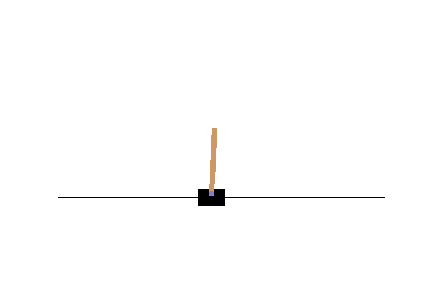
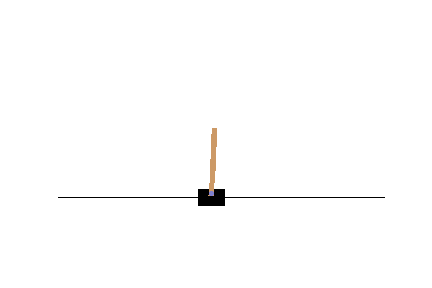
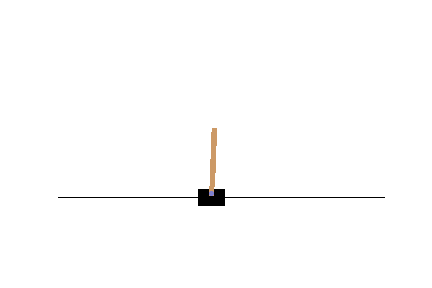
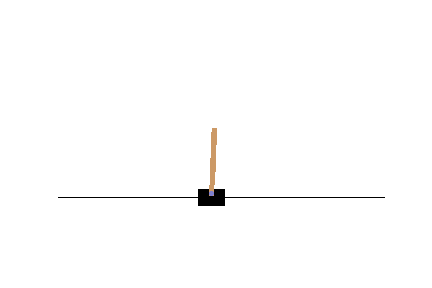
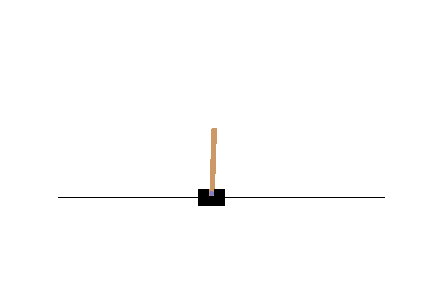
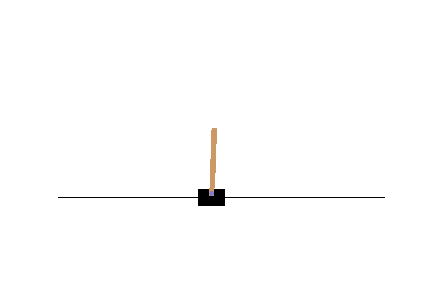
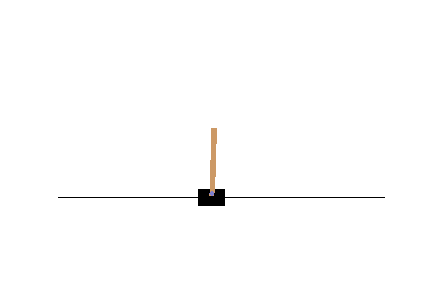
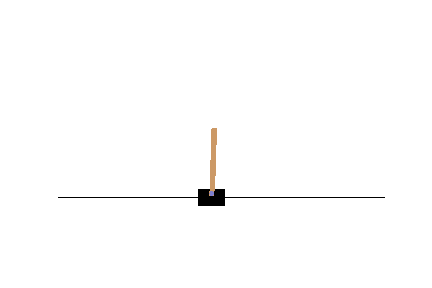
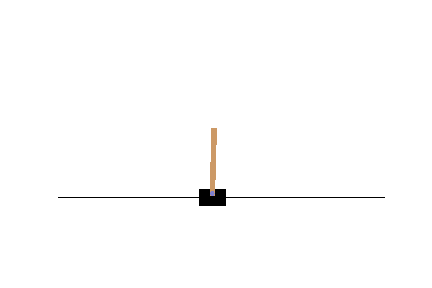
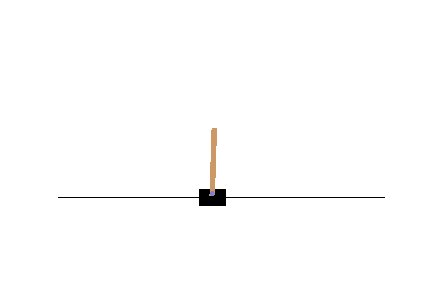
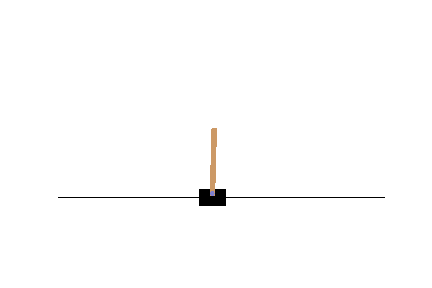
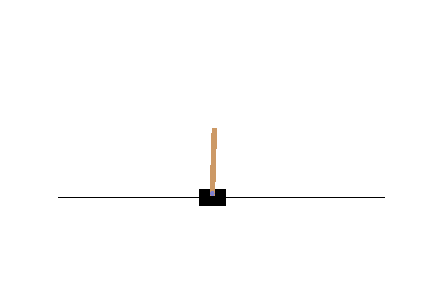
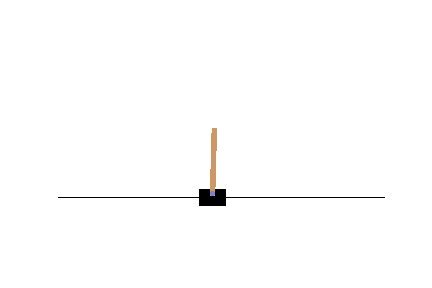
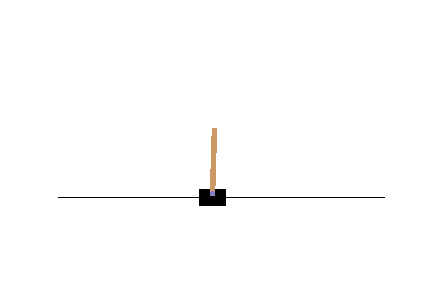
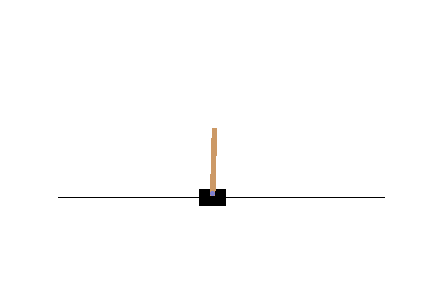
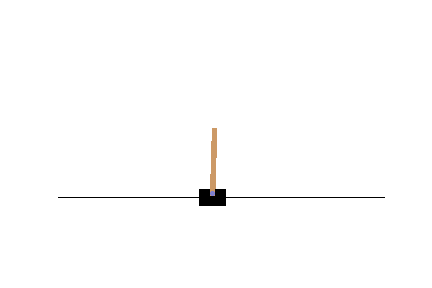
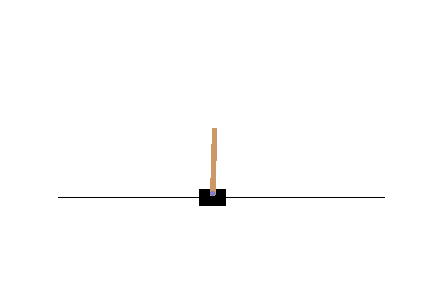
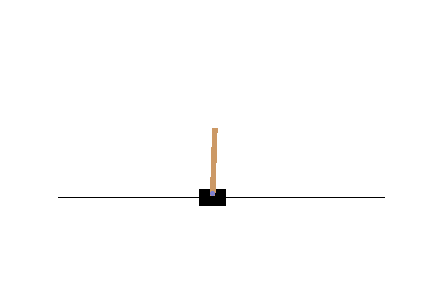
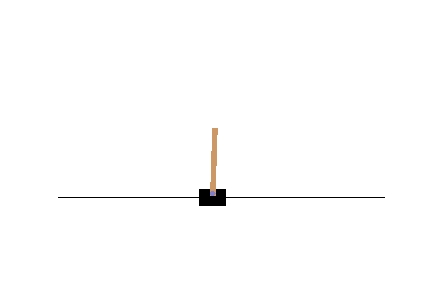
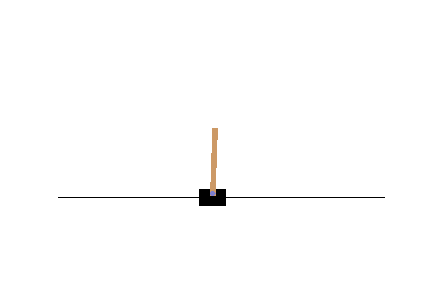
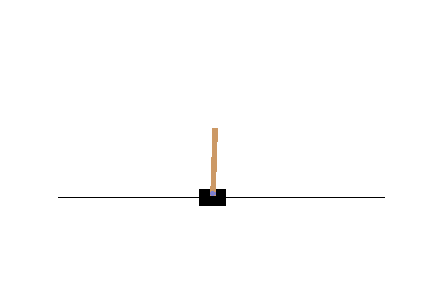
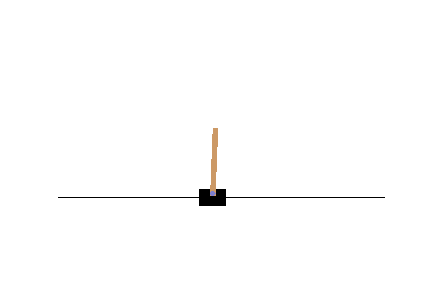
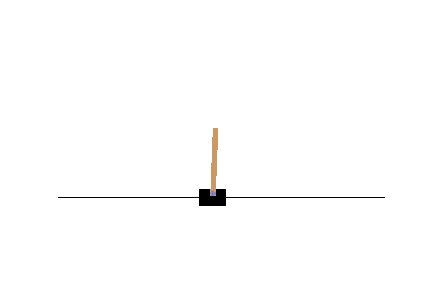
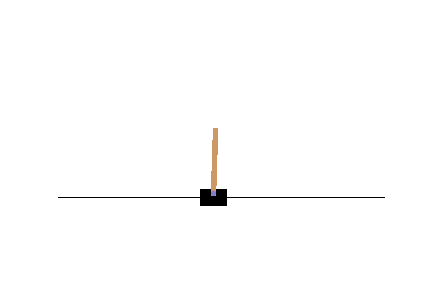
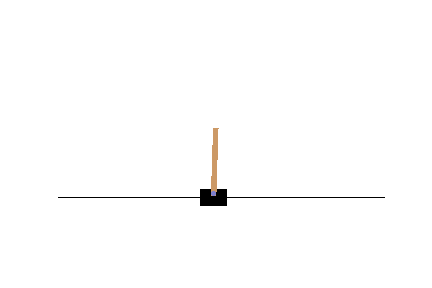
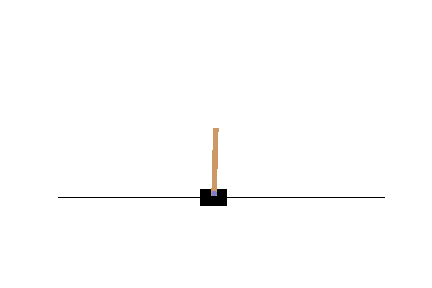
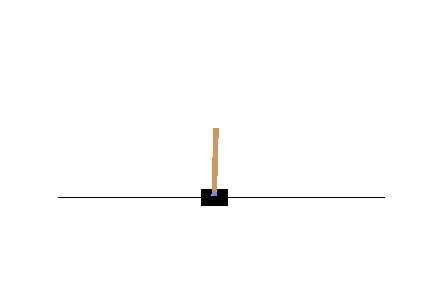
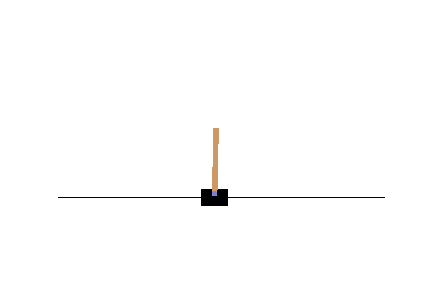
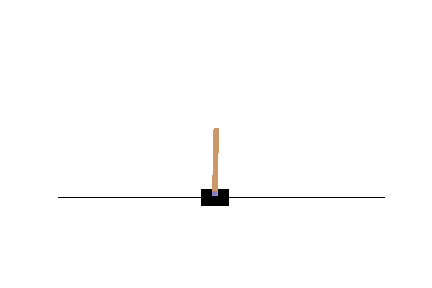
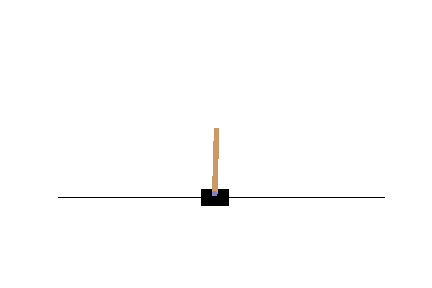
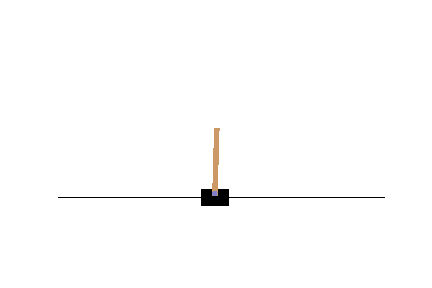
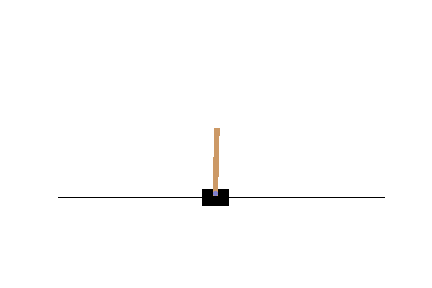
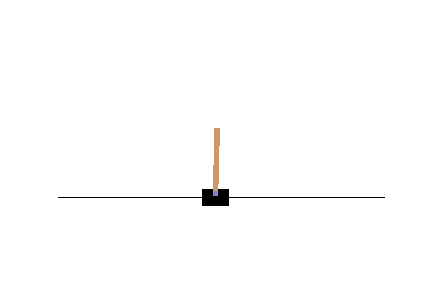
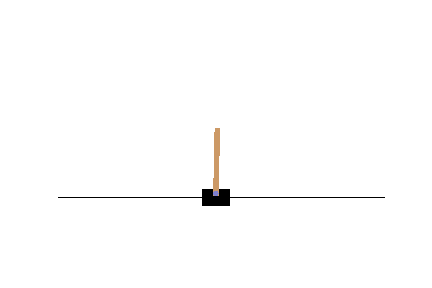
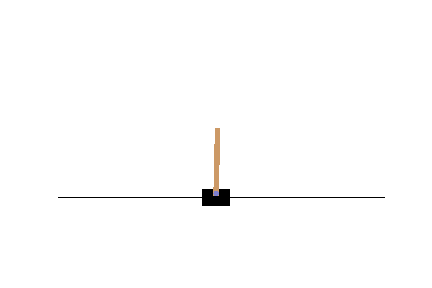
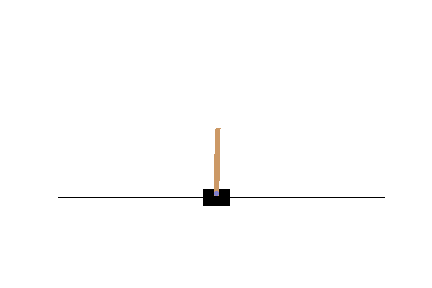
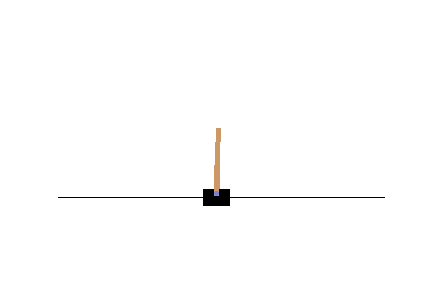
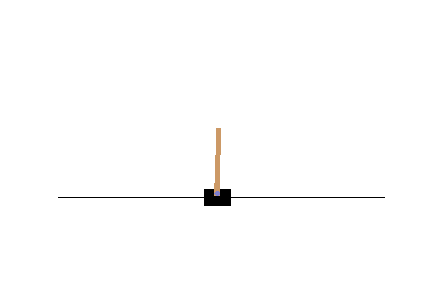
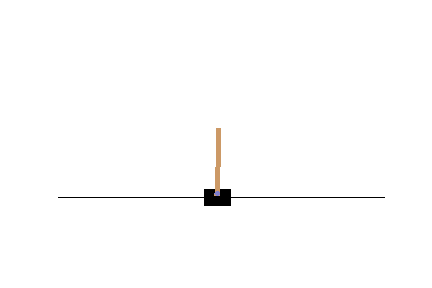
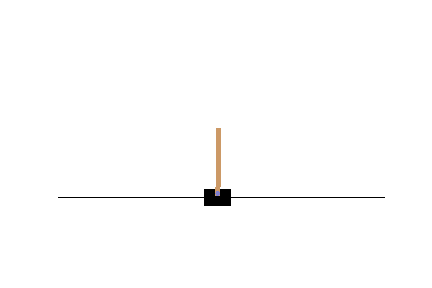
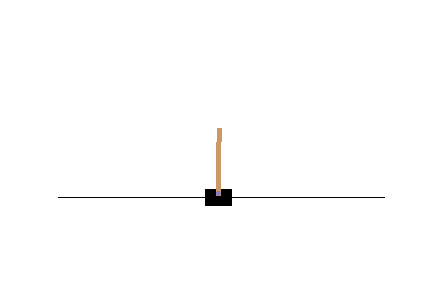
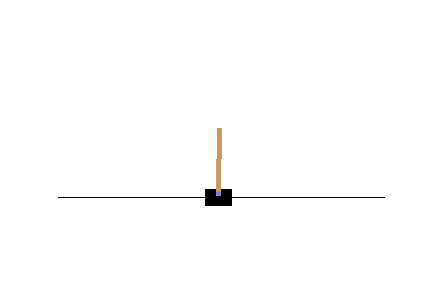
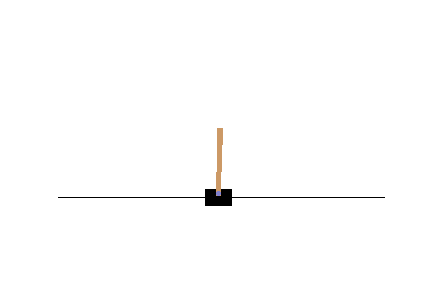
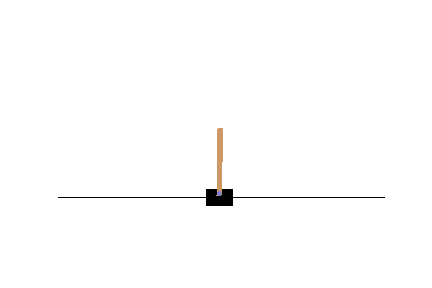
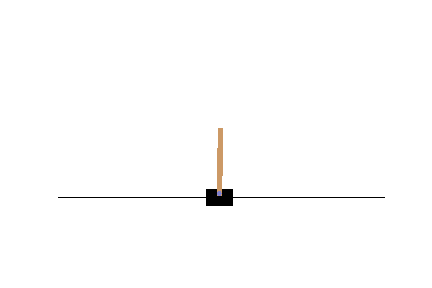
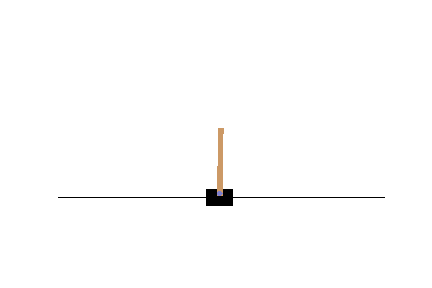
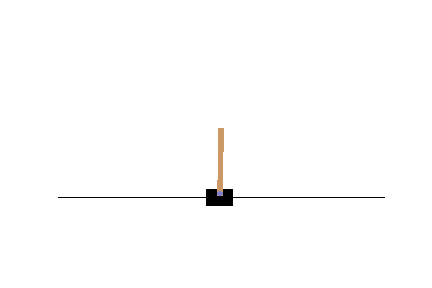
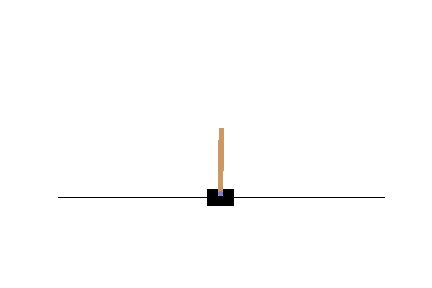
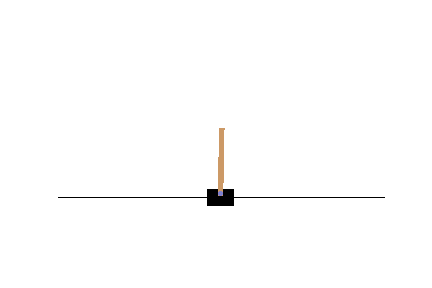
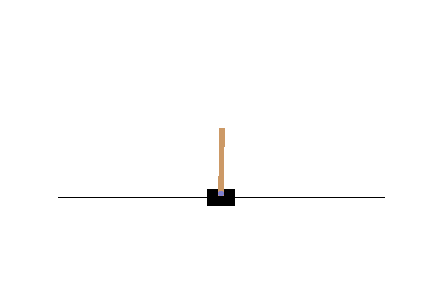
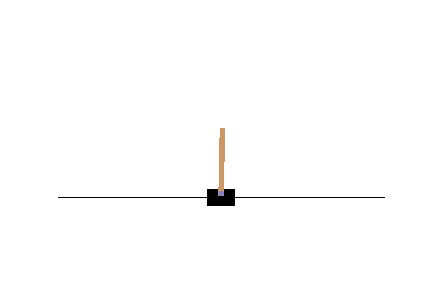
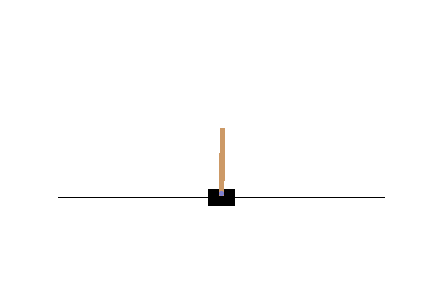
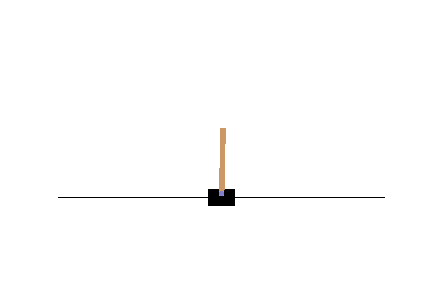
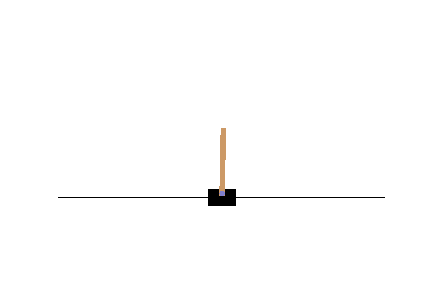
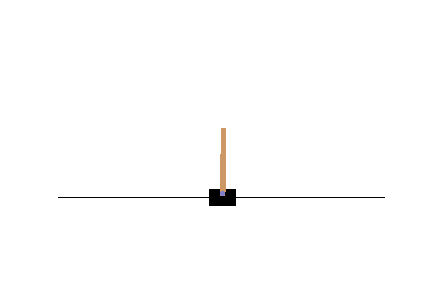
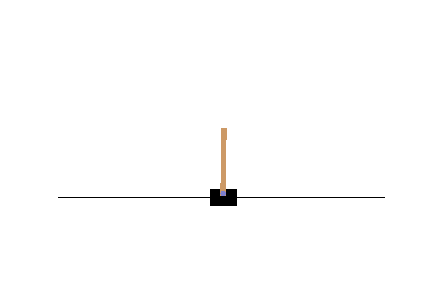
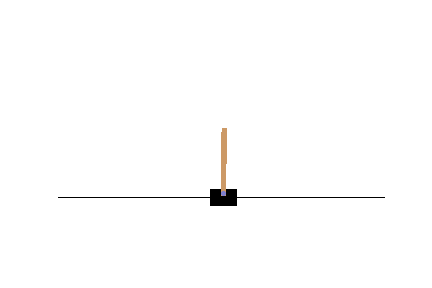
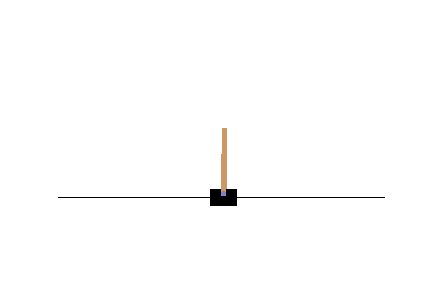
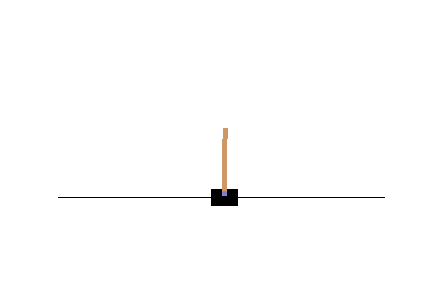
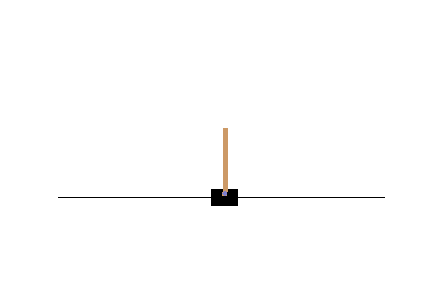
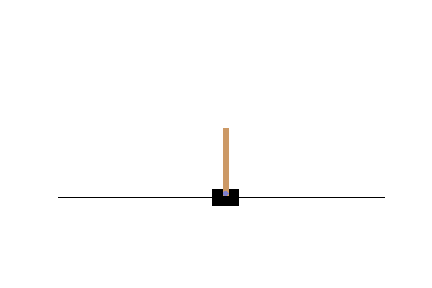
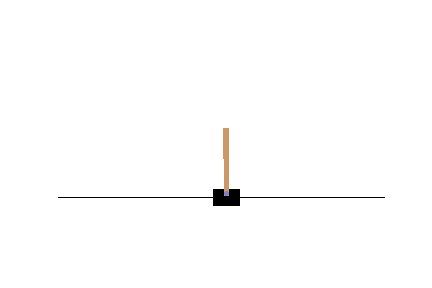
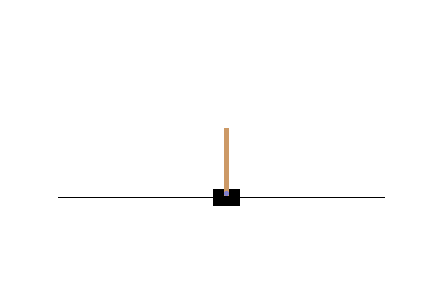
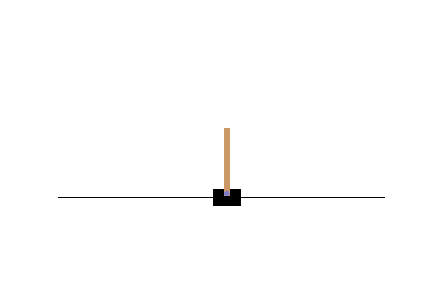
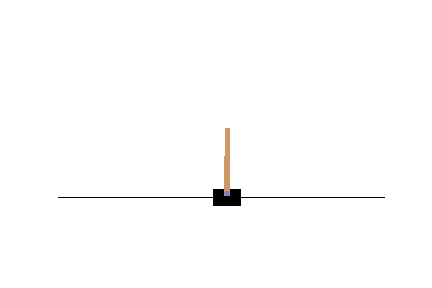
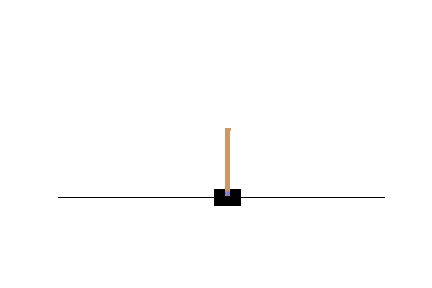
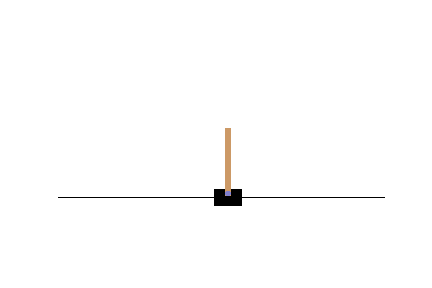
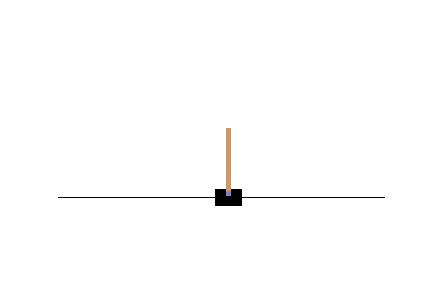
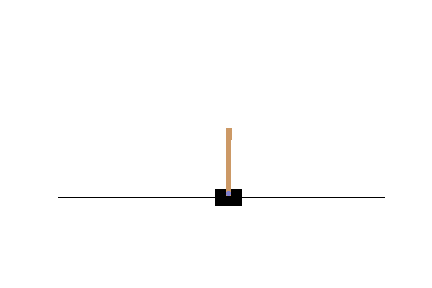
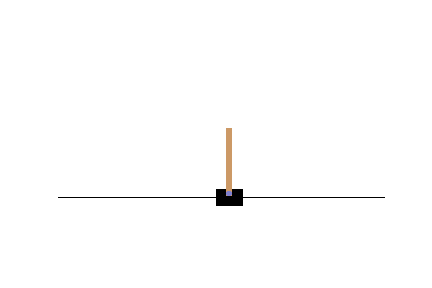
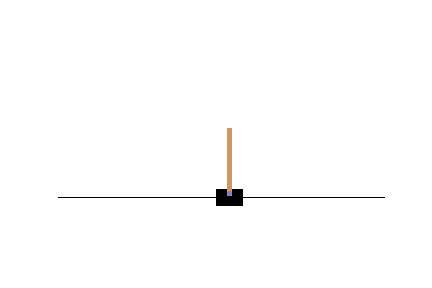
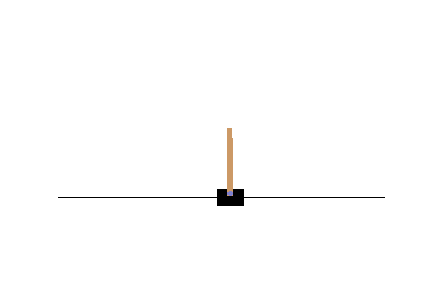
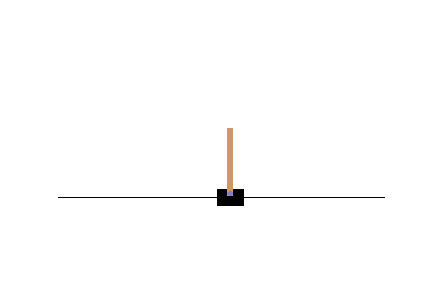
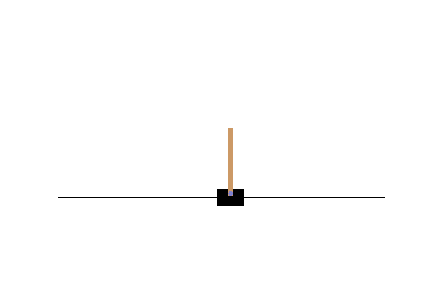
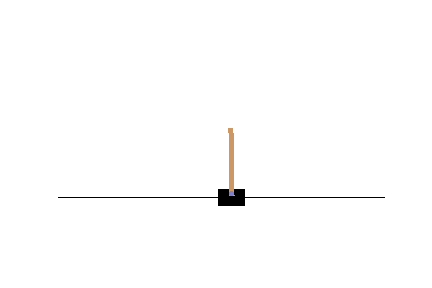
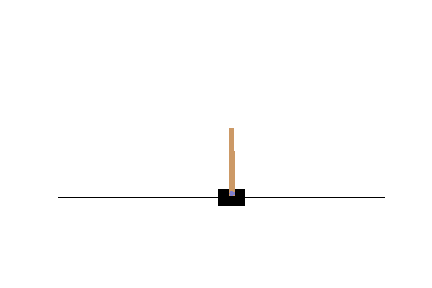
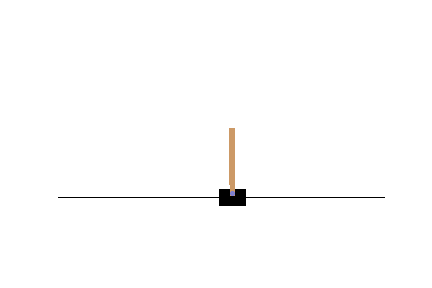
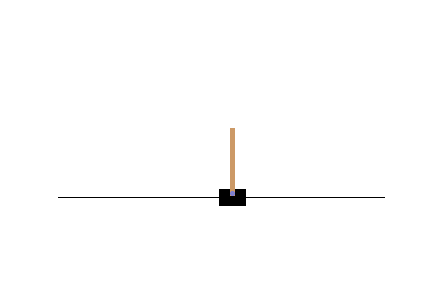
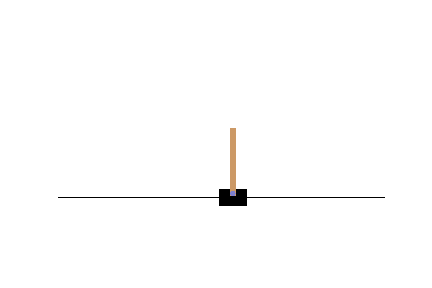
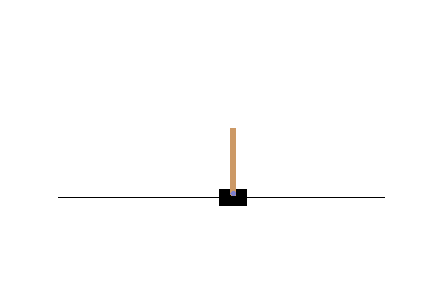
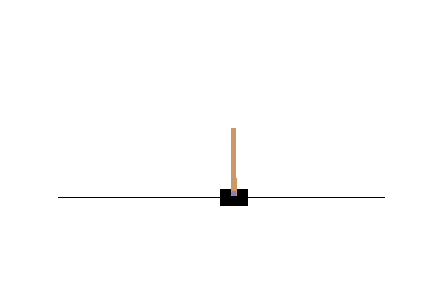
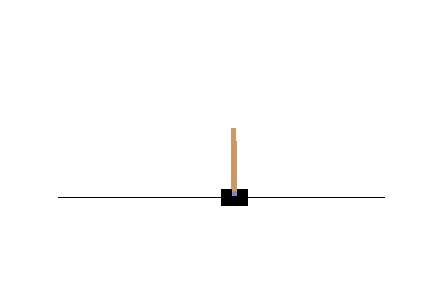
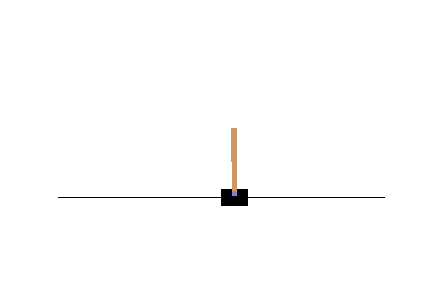
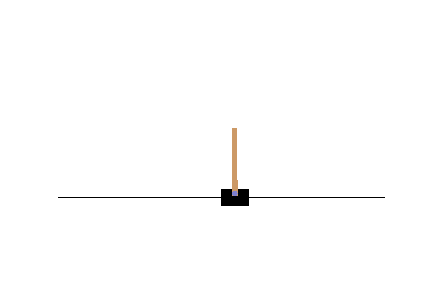
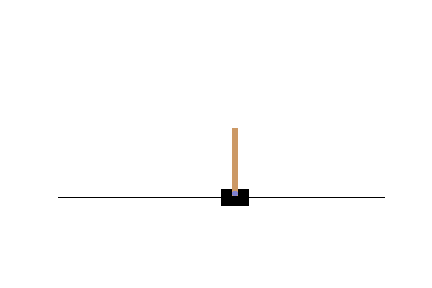
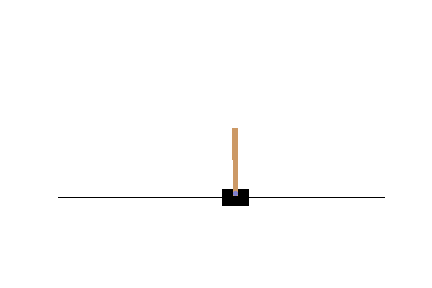
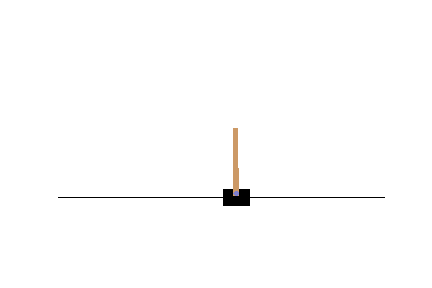
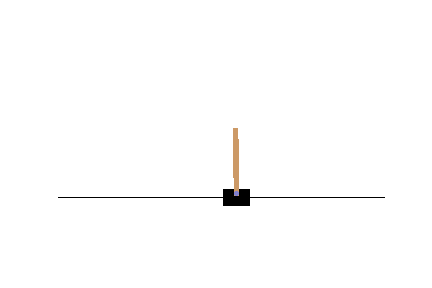
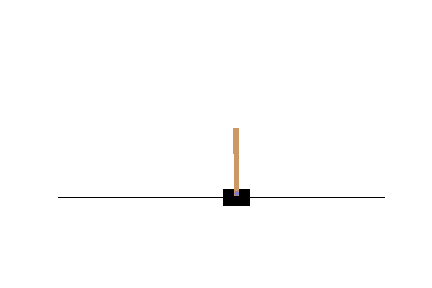
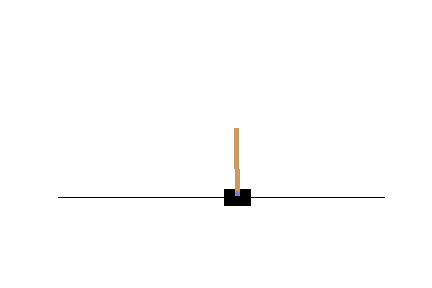
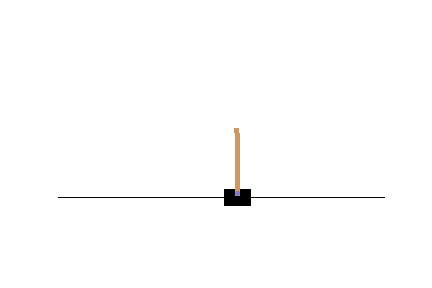
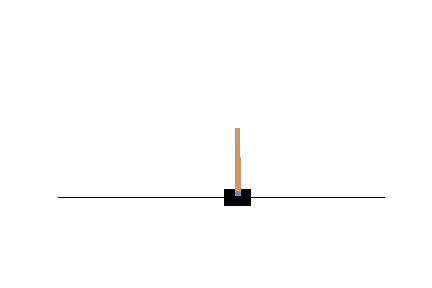
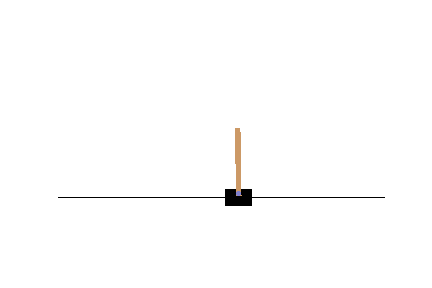
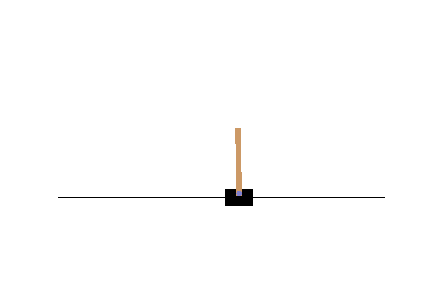
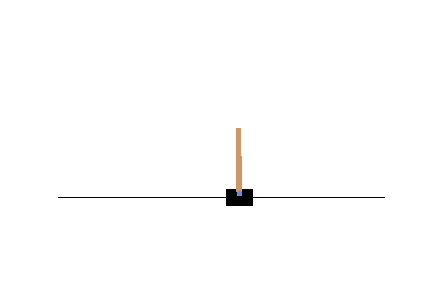
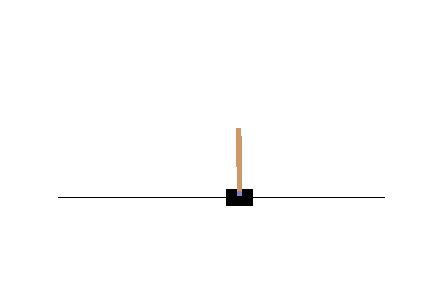
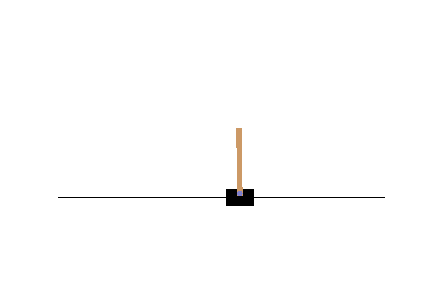
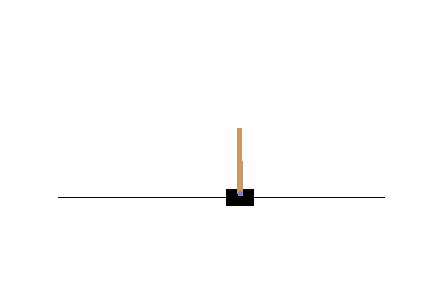
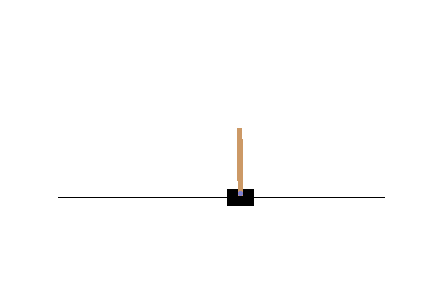
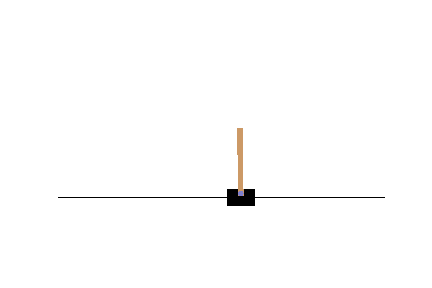
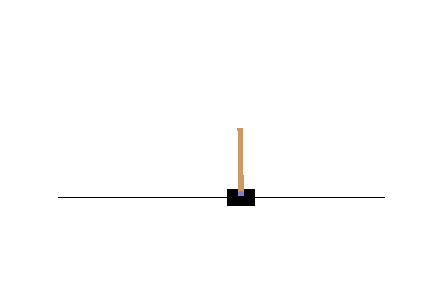
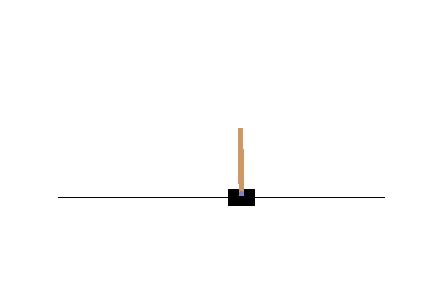
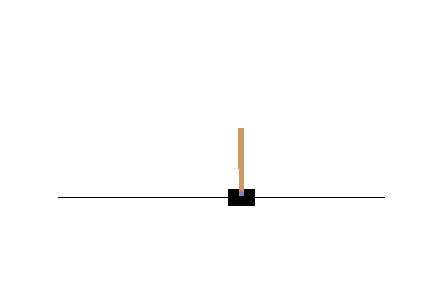
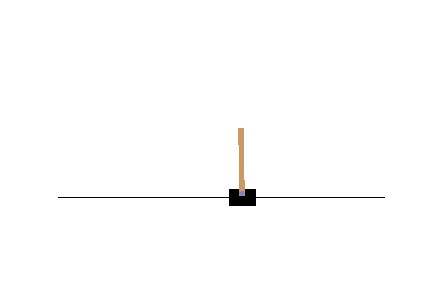
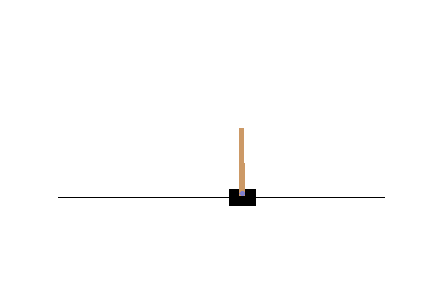
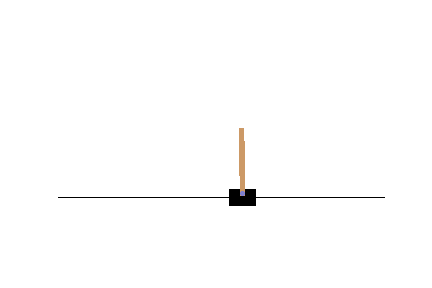
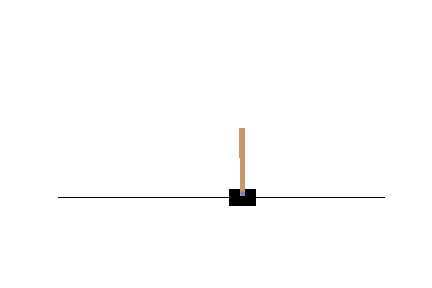
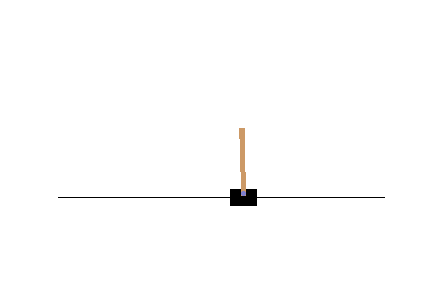
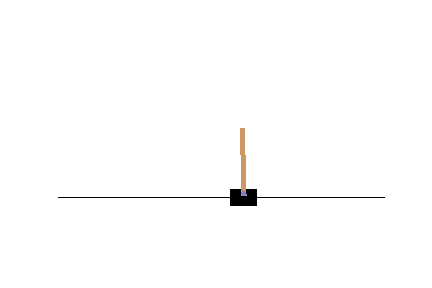
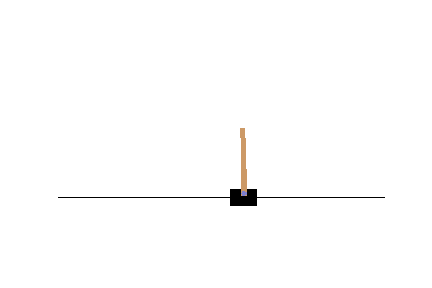
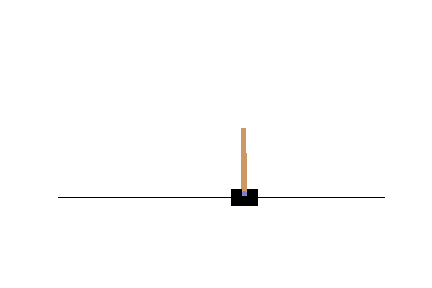
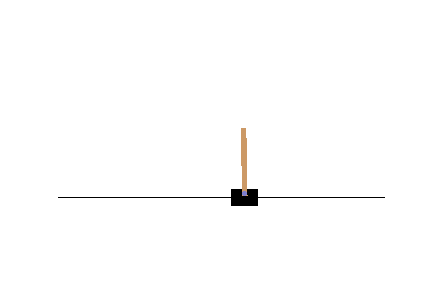
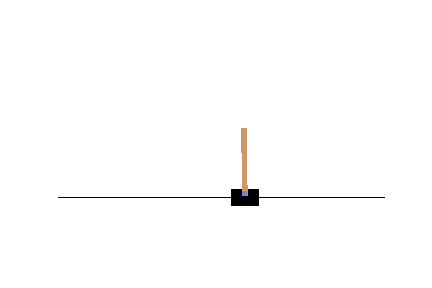
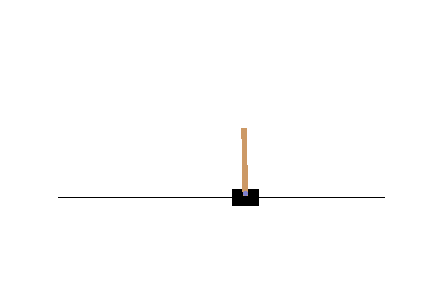
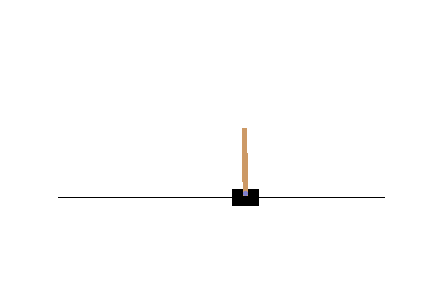
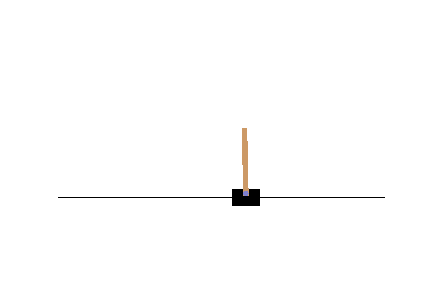
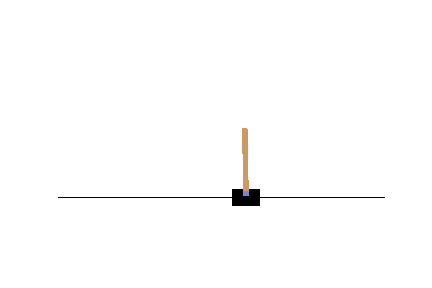
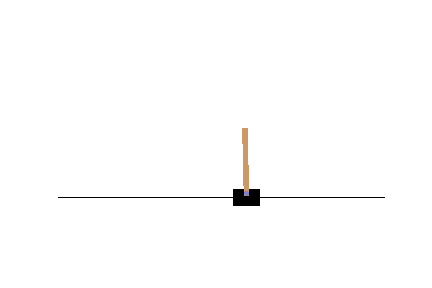
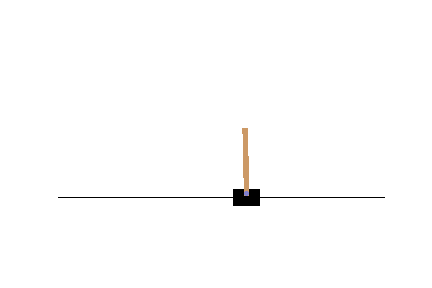
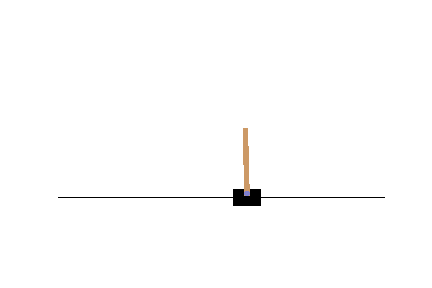
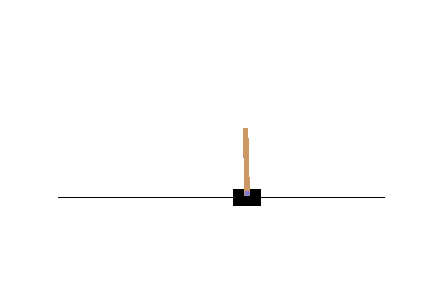
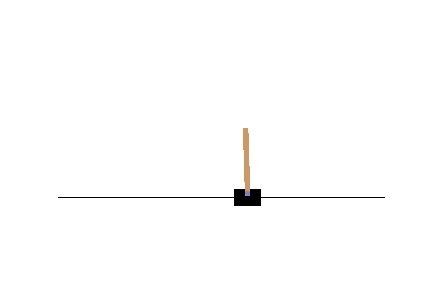
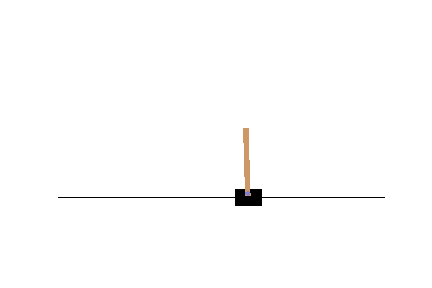
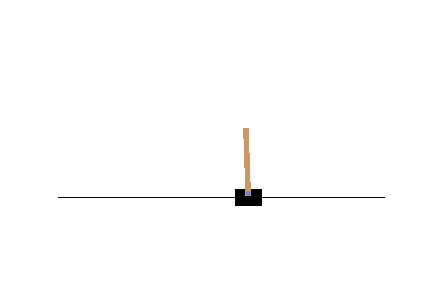
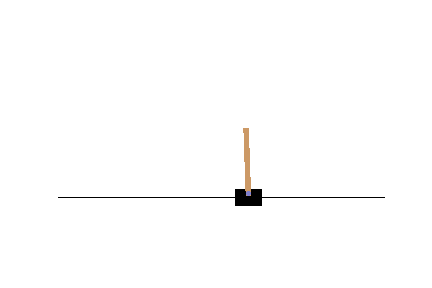
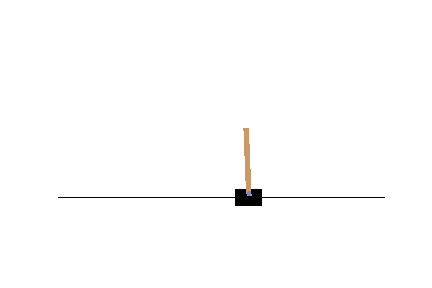
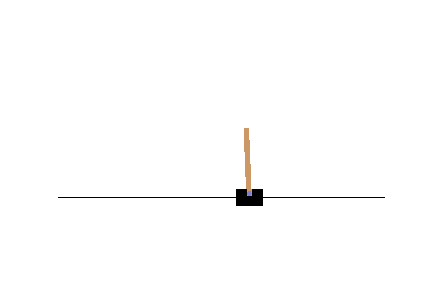
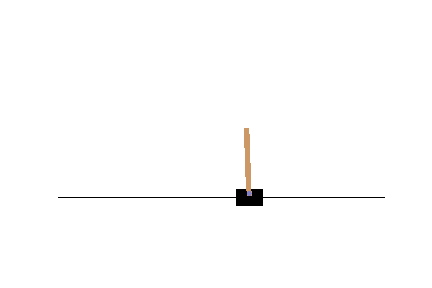
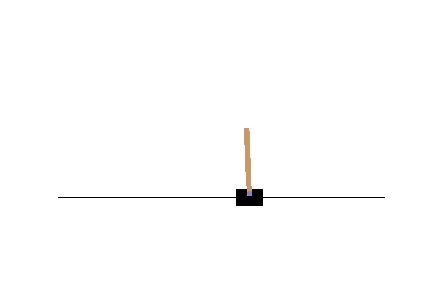
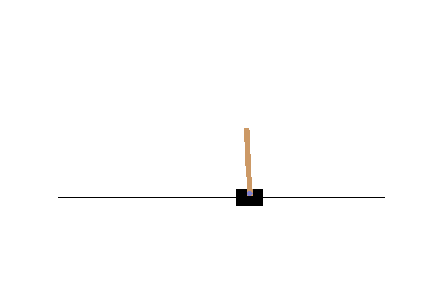
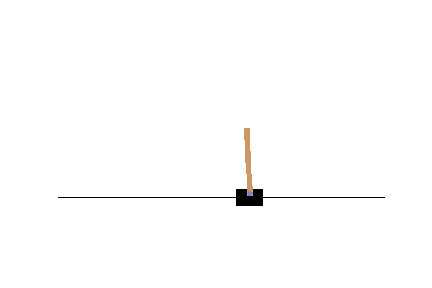
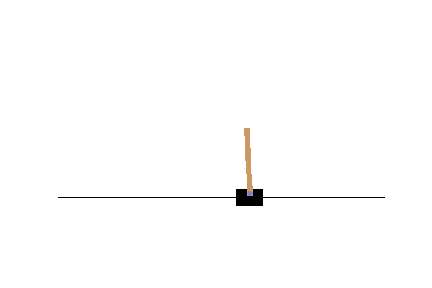
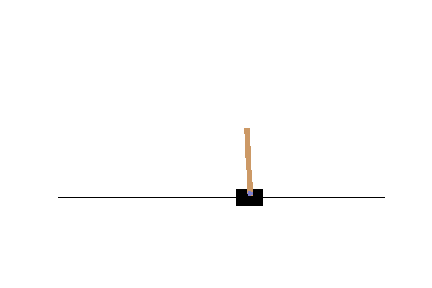
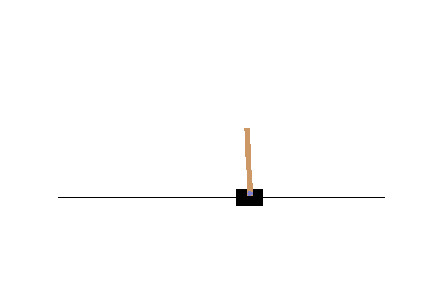
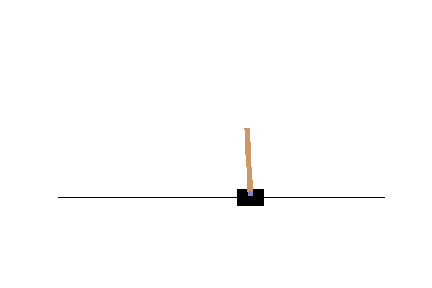
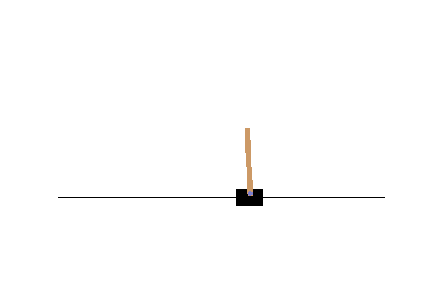
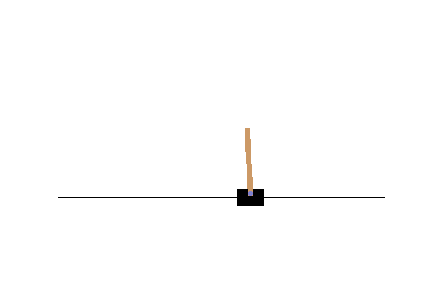
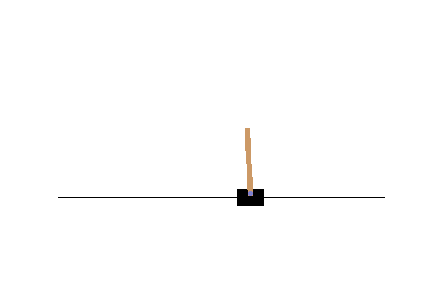
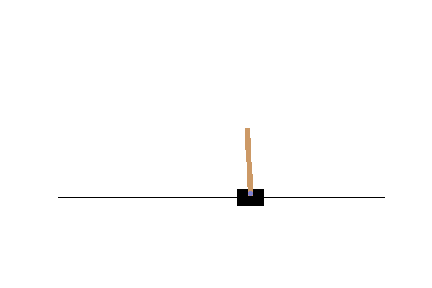
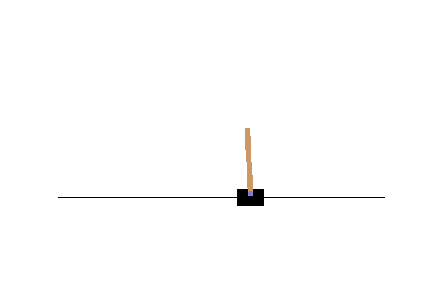
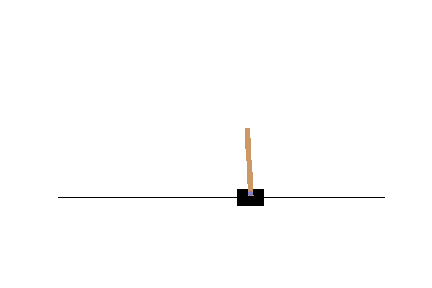
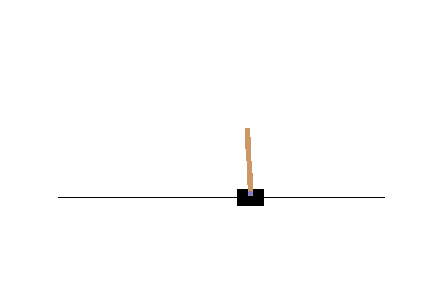
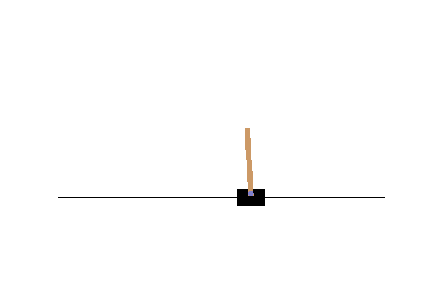
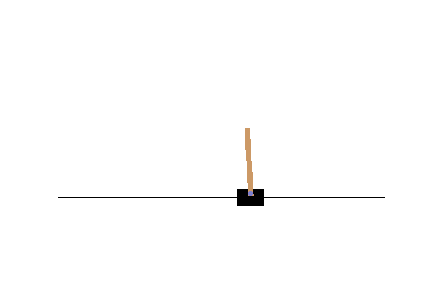
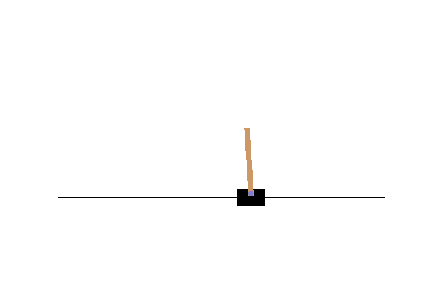
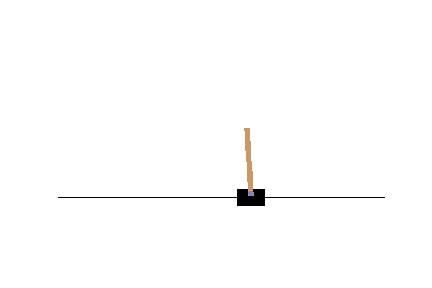
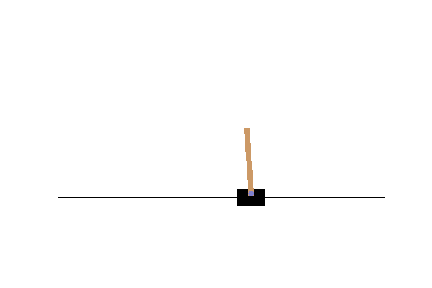
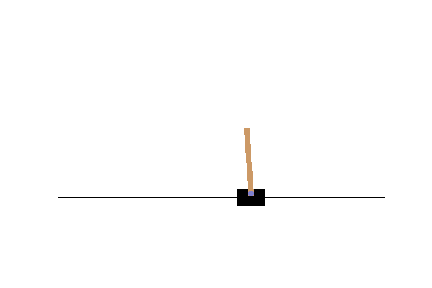
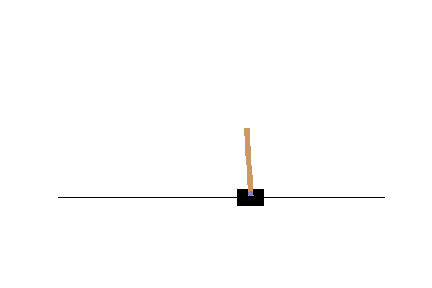
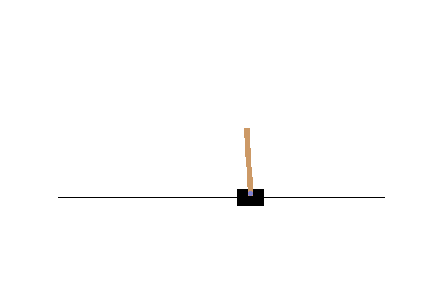
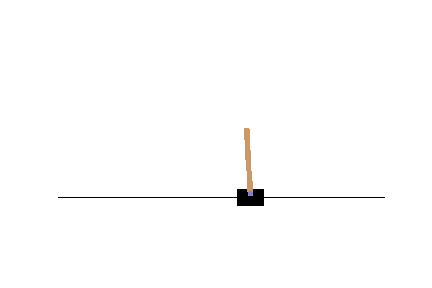
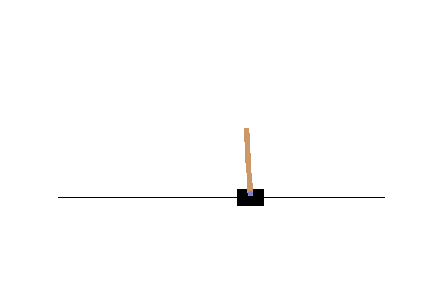
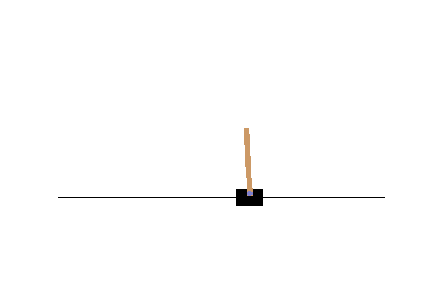
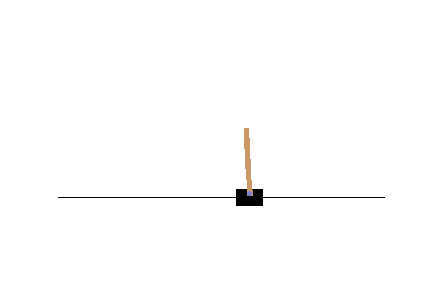
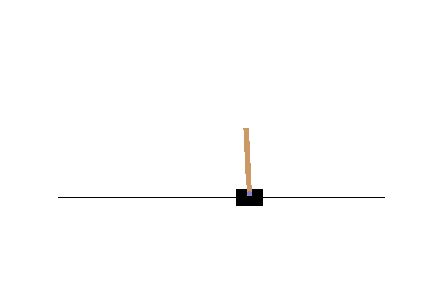
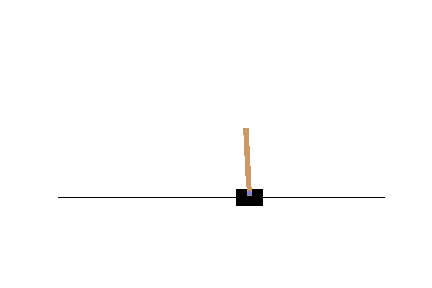
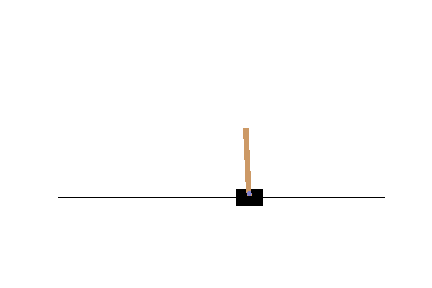
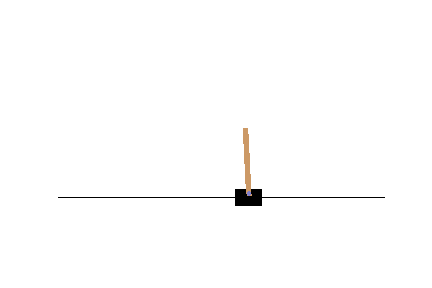
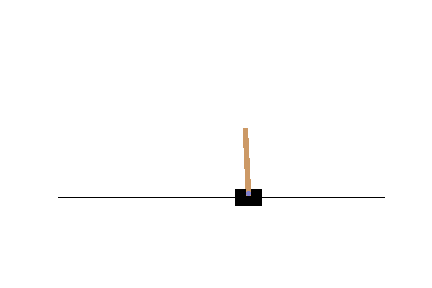
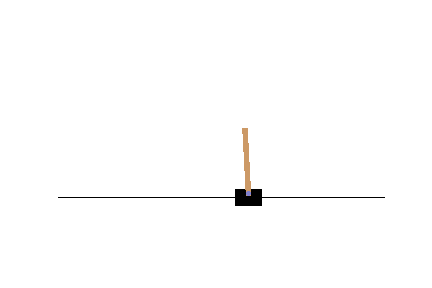
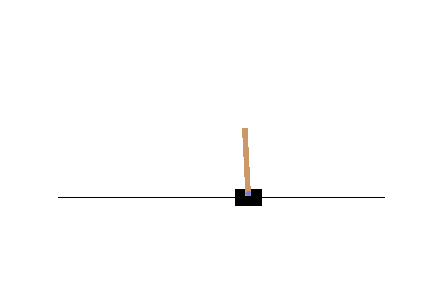
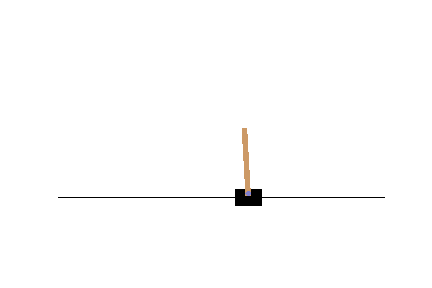
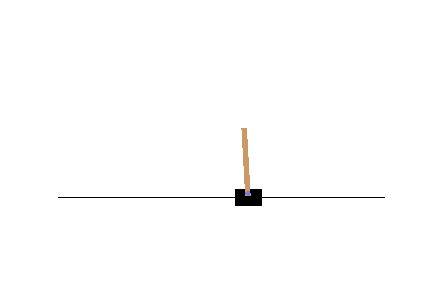
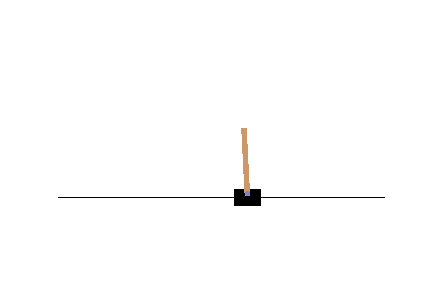
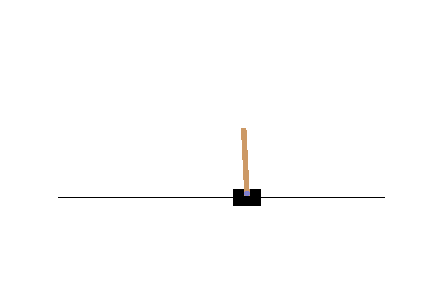
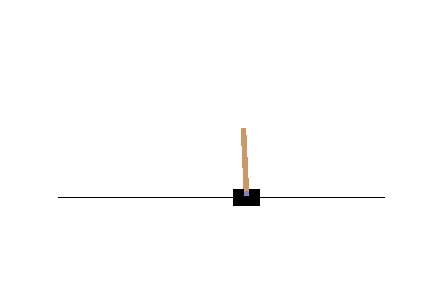
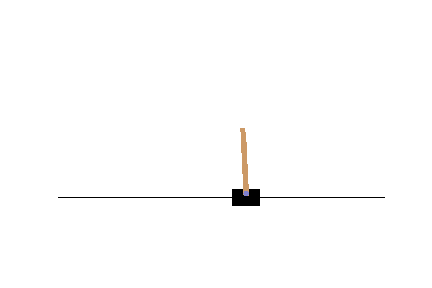
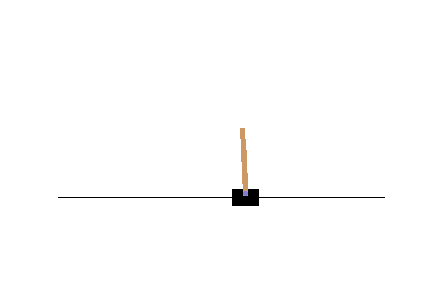
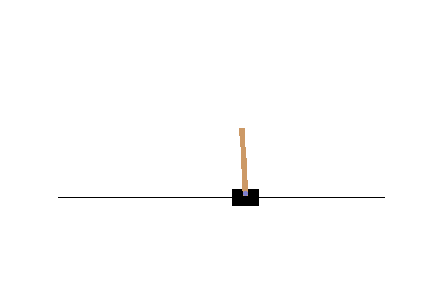
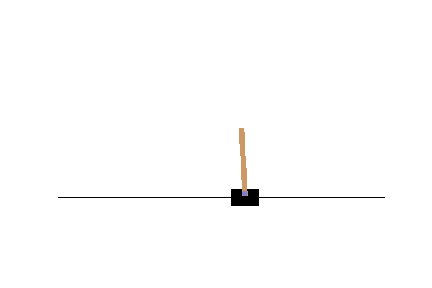
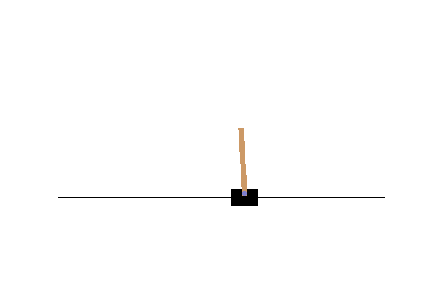
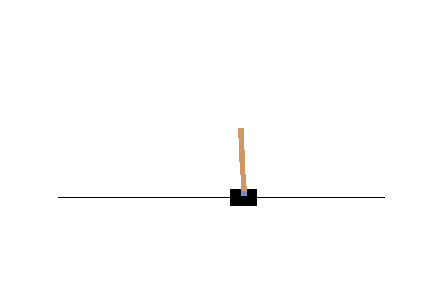
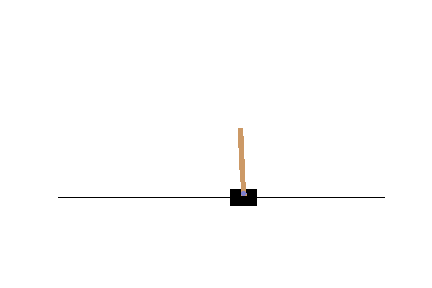
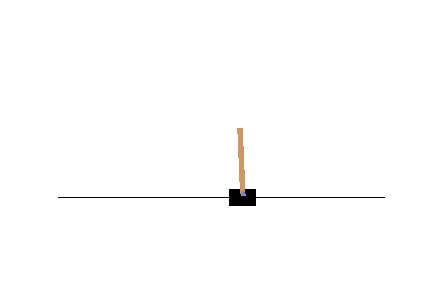
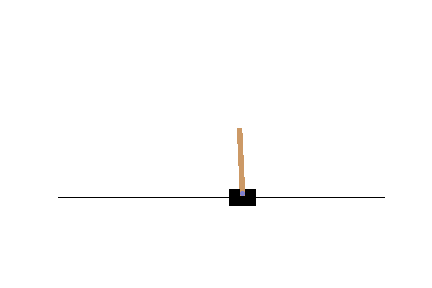
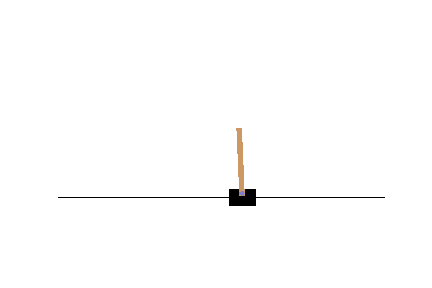
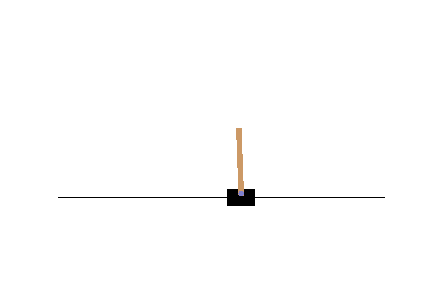
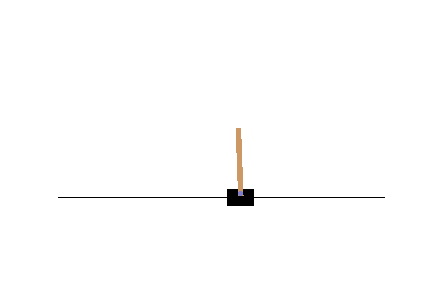
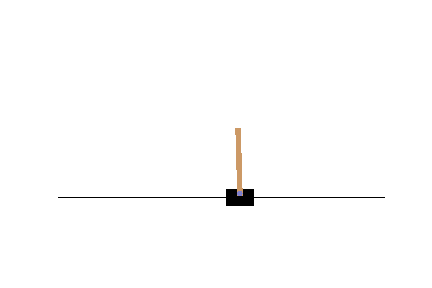
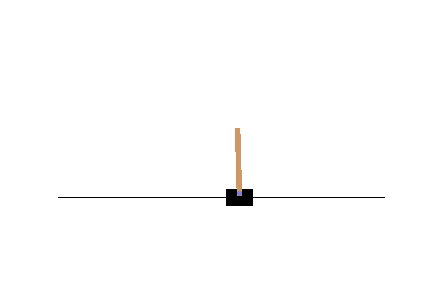
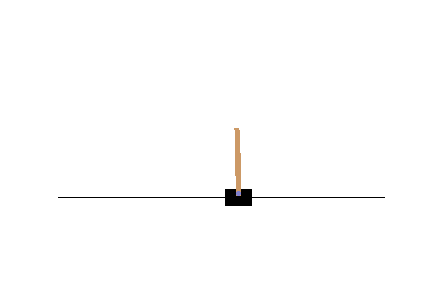
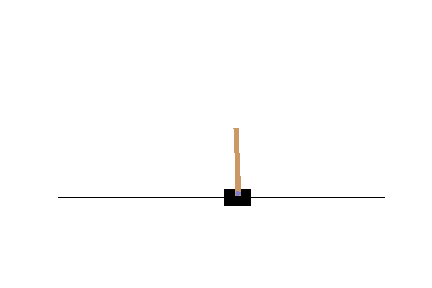
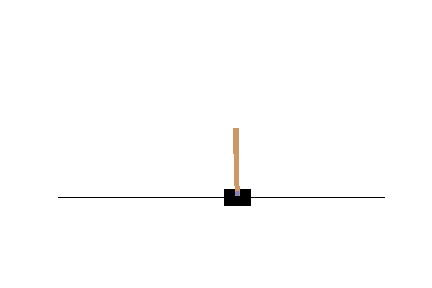
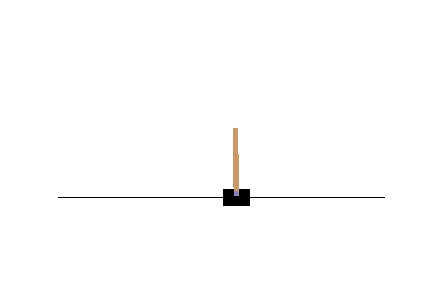
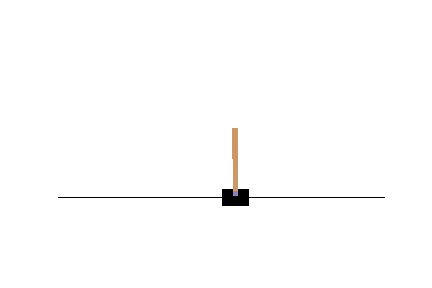
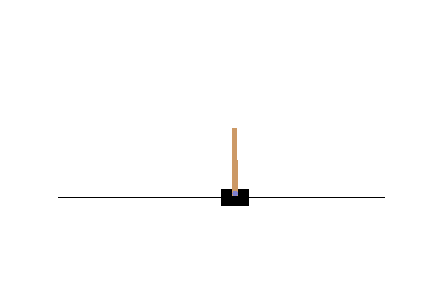
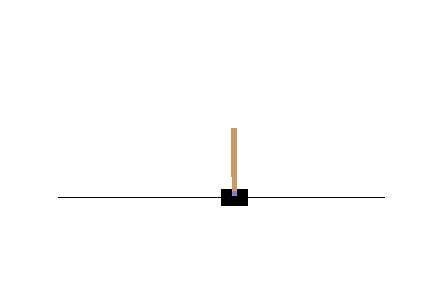
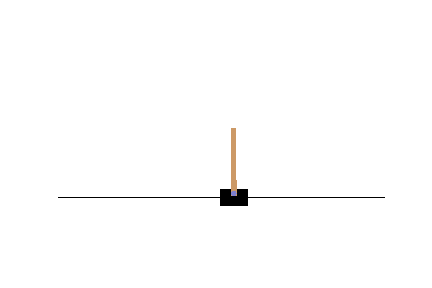
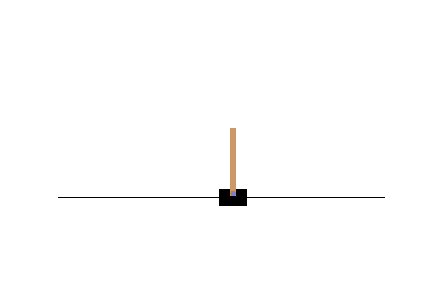
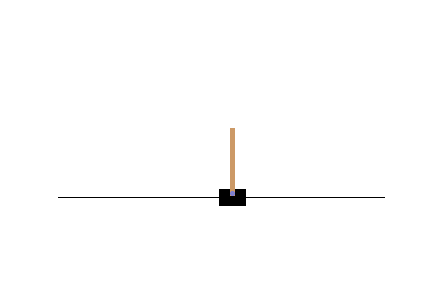
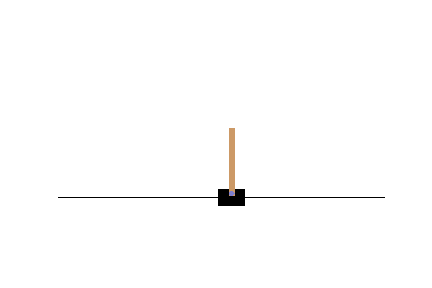
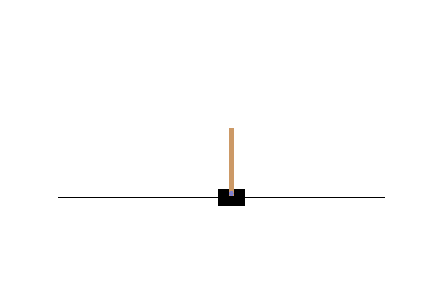
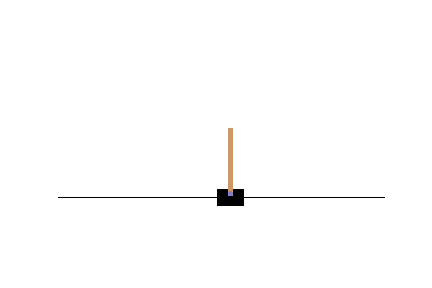
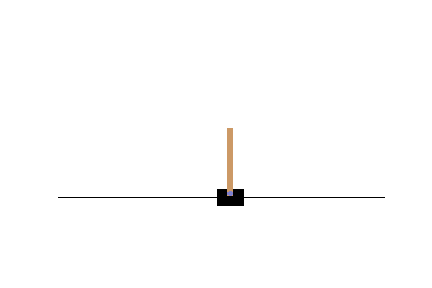
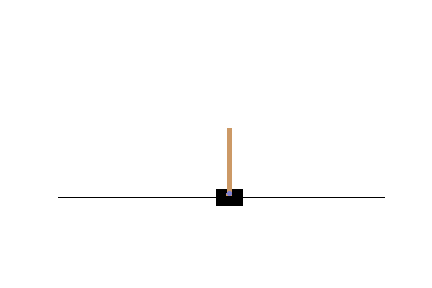
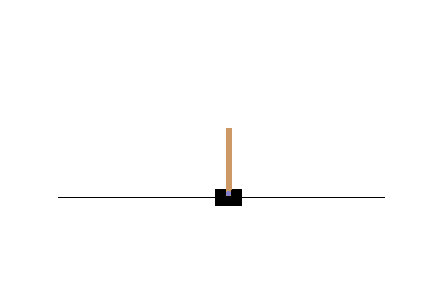
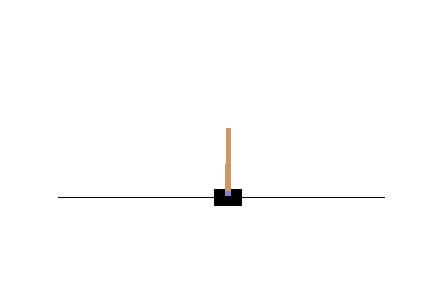
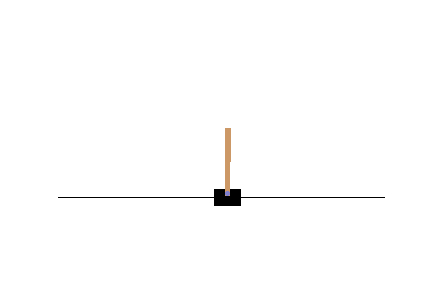
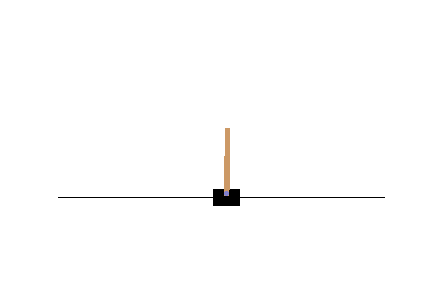
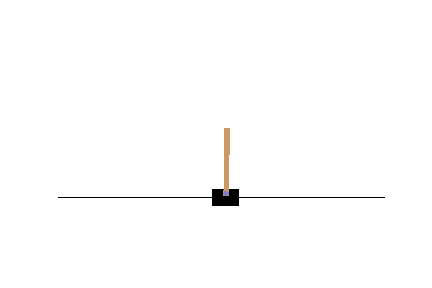
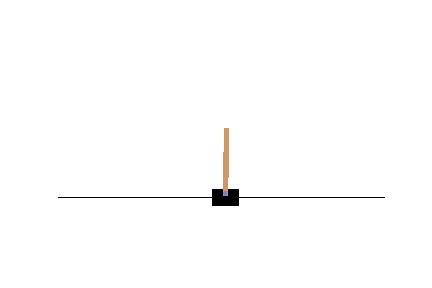
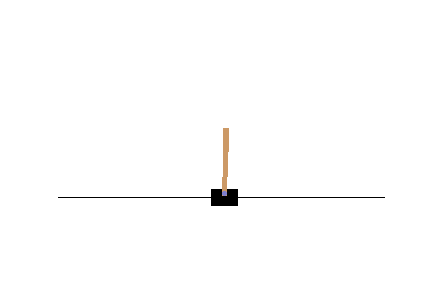
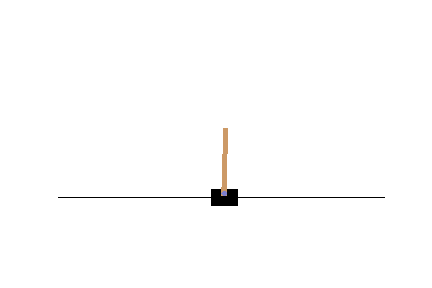
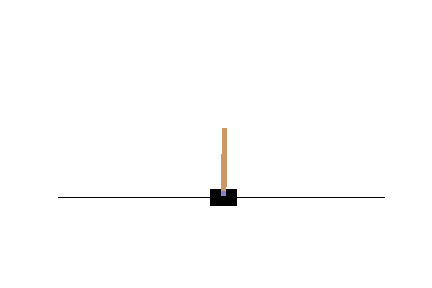
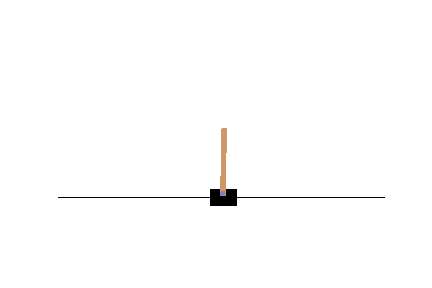
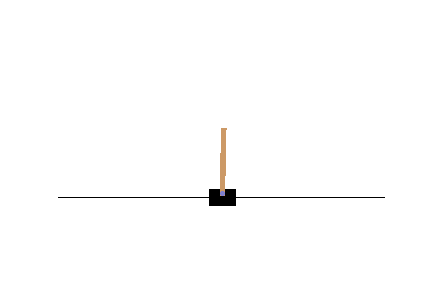
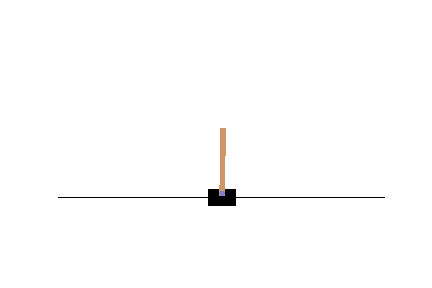
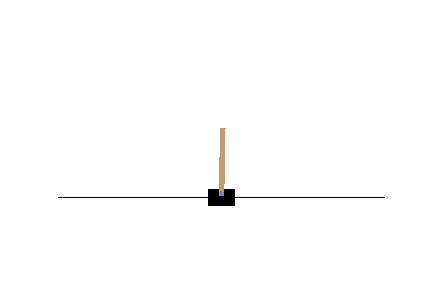
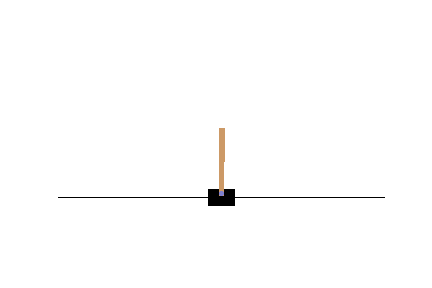
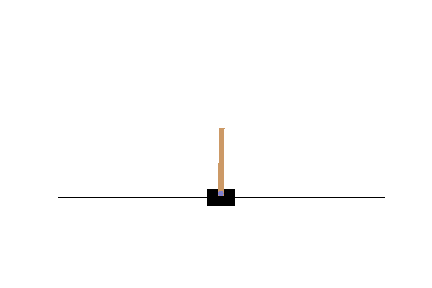
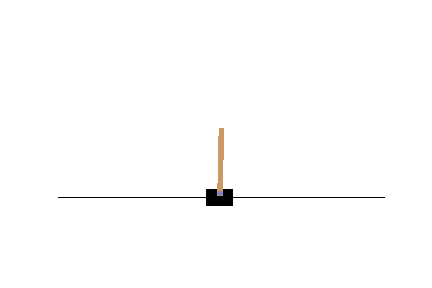
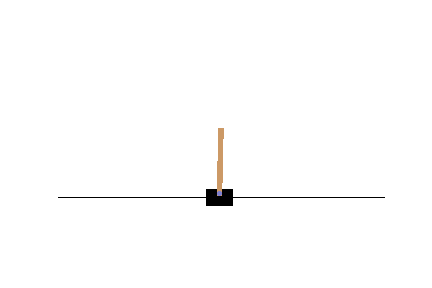
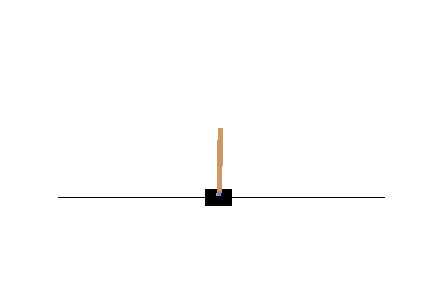
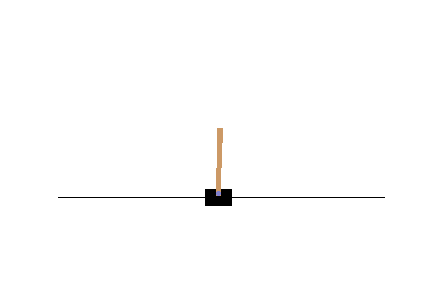
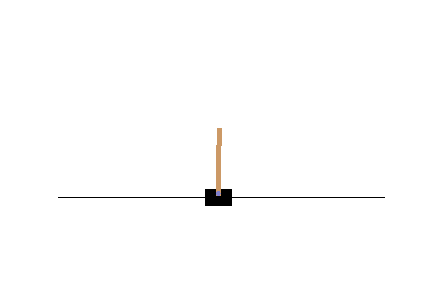
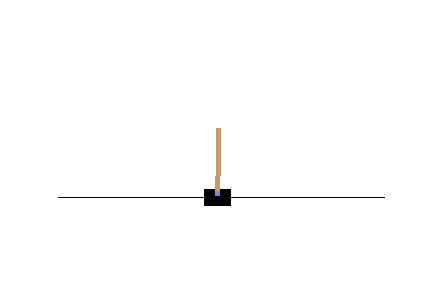
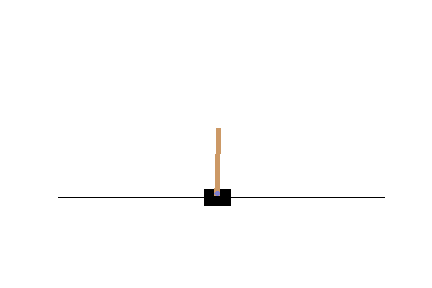
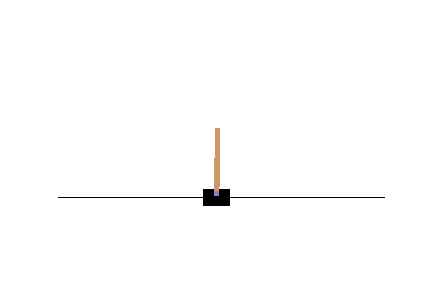
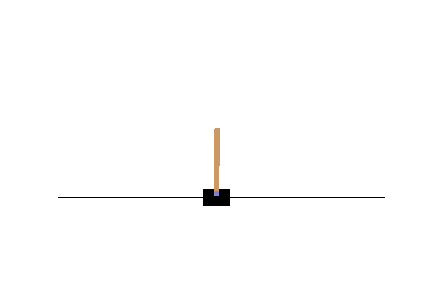
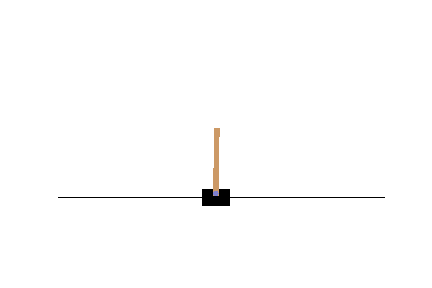
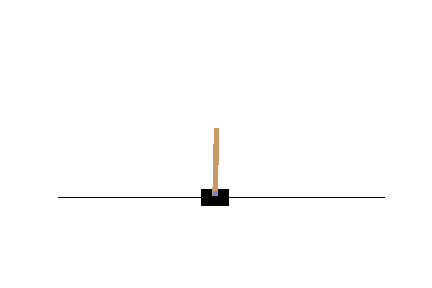
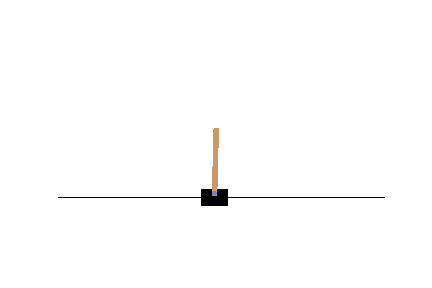
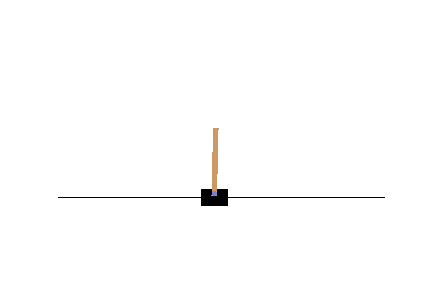
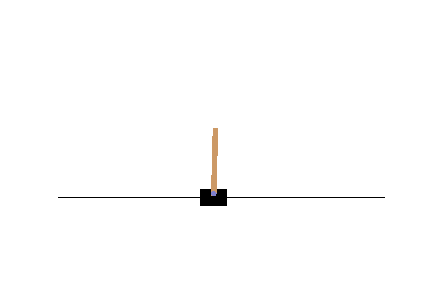
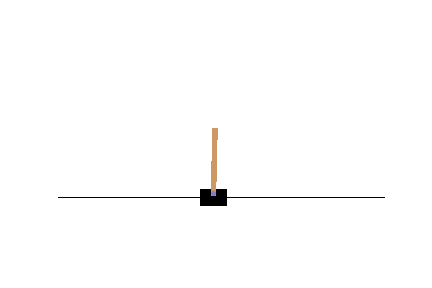
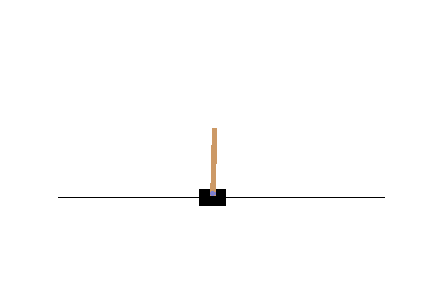
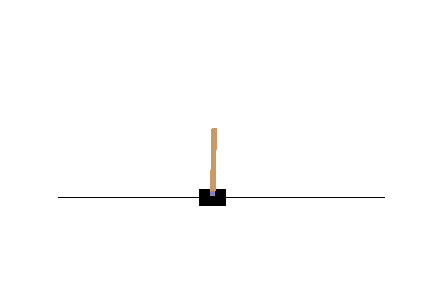
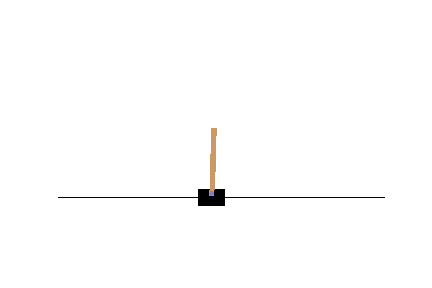
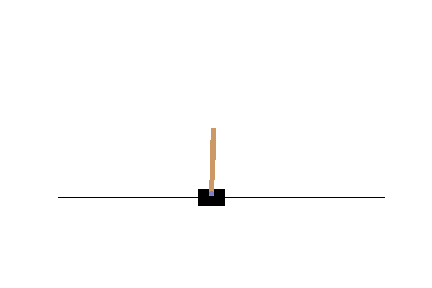
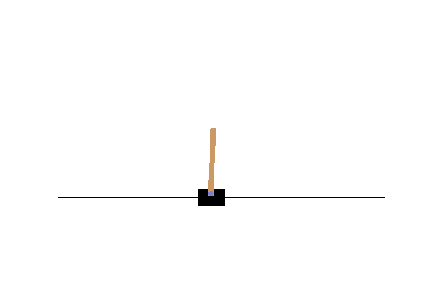
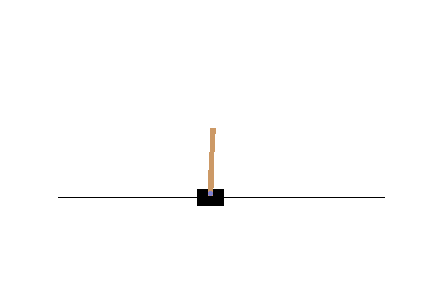
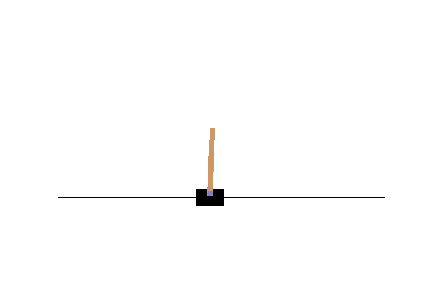
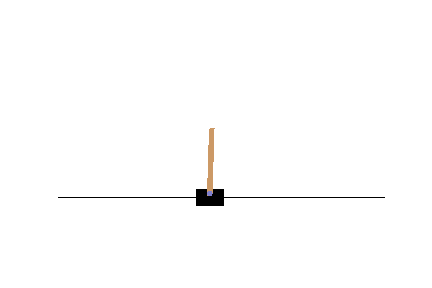
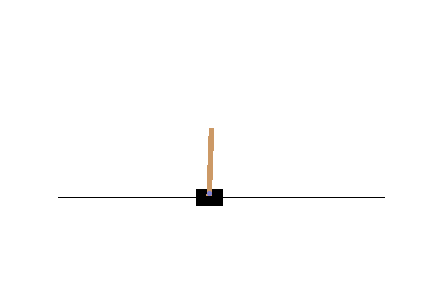

In [10]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# Double Q Learning

In [11]:
class DDQNAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = deque(maxlen=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.loss = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict)) # Squared Error
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss) # AdamOptimizer (Gradient Descent Algorithm)
            
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
        # Summary writer
        summary_q = tf.summary.scalar('max_Q_predict', tf.reduce_max(self.q_predict))
        summary_q_old = tf.summary.scalar('max_Q_target', tf.reduce_max(self.q_predict_old))
        summary_loss = tf.summary.scalar('loss', self.loss)
        self.merge_q_step = 0
        self.merge_q = tf.summary.merge([summary_q, summary_q_old])
        self.merge_loss_step = 0
        self.merge_loss = tf.summary.merge([summary_loss])
        self.summary_writer = tf.summary.FileWriter('./tf_logs/ddqn', graph=self.sess.graph)

    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): # Get Q value from target network
        q_value_old, summary = self.sess.run([self.q_predict_old,self.merge_q],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        self.merge_q_step += 1
        self.summary_writer.add_summary(summary,self.merge_q_step)       
        
        return q_value_old
        
    def get_prediction(self, obs): # Get Q value from prediction network
        q_value, summary = self.sess.run([self.q_predict,self.merge_q],feed_dict={self.obs_ph:obs}) 
        
        # Summary Q value
        self.merge_q_step += 1
        self.summary_writer.add_summary(summary,self.merge_q_step)       
        
        return q_value
    
    def get_action(self, obs): # Epsilon Greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done): # Add experience to memory
        self.memory.append((obs, action, reward, next_obs, done))

    def train_model(self):
        loss = np.nan
        n_entries = len(self.memory)
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            mini_batch = random.sample(self.memory, self.batch_size)
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            bast_a = np.argmax(self.get_prediction(next_observations),axis=1) # next action from next Q value of prediction network
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * next_q_value[i][bast_a[i]]

            loss, _, summary = self.sess.run([self.loss, self.optim, self.merge_loss], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate})                        
            
            # Summary loss
            self.merge_loss_step += 1
            self.summary_writer.add_summary(summary, self.merge_loss_step)       
            
        return loss

# Define Environment and Agent

In [12]:
env = gym.make('CartPole-v1')
env.seed(seed)
max_t = env.spec.max_episode_steps
agent = DDQNAgent(env.observation_space.high.shape[0],env.action_space.n)

[2018-05-19 03:55:40,414] Making new env: CartPole-v1


# TRAIN

In [13]:
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)
nepisodes = 1500
for i in range(nepisodes):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        
        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done)
        
        # Online update perdiction network parameter
        loss = agent.train_model()
        agent.update_policy()
                
        obs = next_obs
        total_reward += reward
        total_loss += loss
        
        if done:
            break
    
    # Update target network parameter
    agent.update_target()
    avg_return_list.append(total_reward)
    avg_loss_list.append(total_loss)
    
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))
        print('The problem is solved with {} episodes'.format(i))
        break
    
    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))

[0/1500] loss : nan, return : 15.000, eps : 0.985
[100/1500] loss : 59.630, return : 12.300, eps : 0.127
[200/1500] loss : 837.240, return : 92.200, eps : 0.010
[300/1500] loss : 196.150, return : 9.300, eps : 0.010
[400/1500] loss : 1157.356, return : 276.100, eps : 0.010
[500/1500] loss : 201.111, return : 72.100, eps : 0.010
[600/1500] loss : 382.782, return : 116.800, eps : 0.010
[700/1500] loss : 1335.169, return : 280.100, eps : 0.010
[800/1500] loss : 2260.566, return : 409.400, eps : 0.010
[812/1500] loss : 3052.824, return : 500.000, eps : 0.010
The problem is solved with 812 episodes


# TEST

[2018-05-19 03:59:00,250] Making new env: CartPole-v1


Total Reward : 500.00



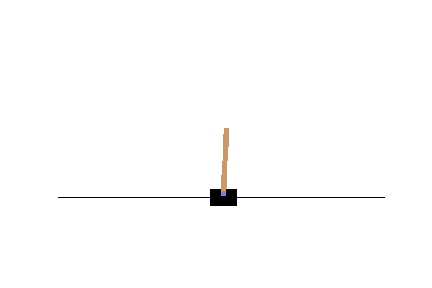
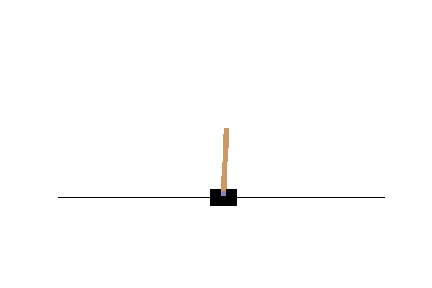
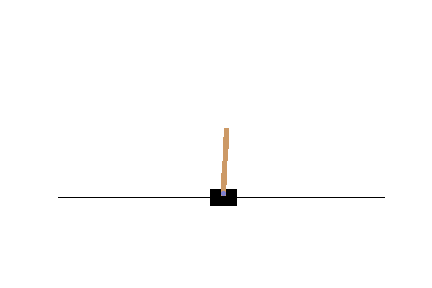
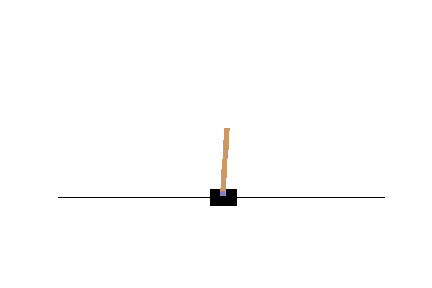
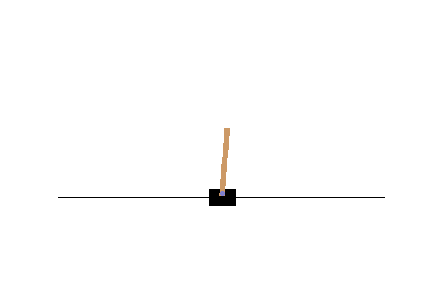
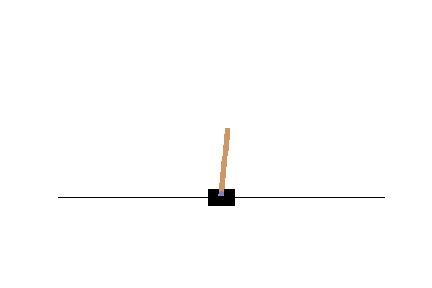
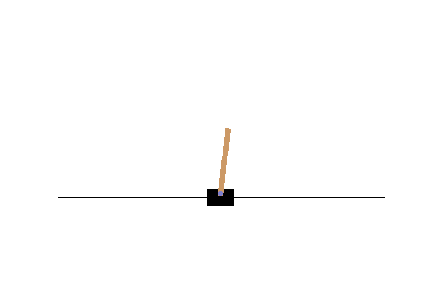
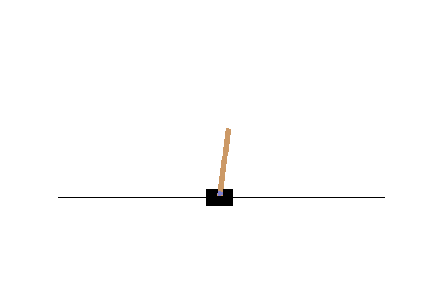
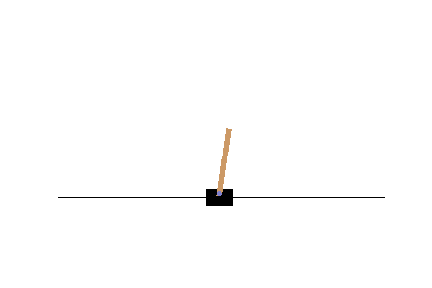
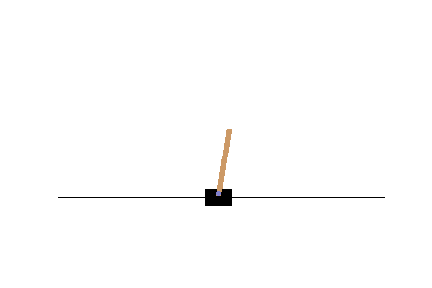
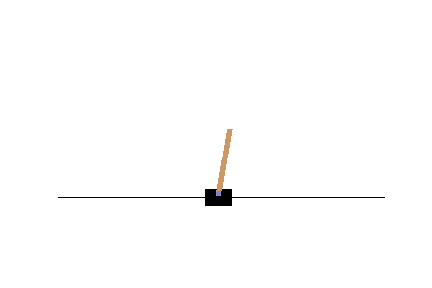
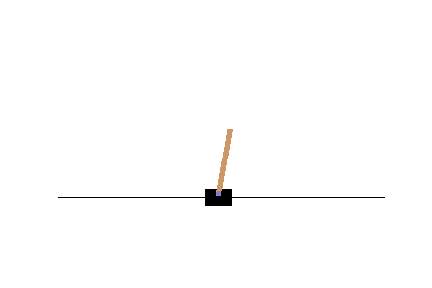
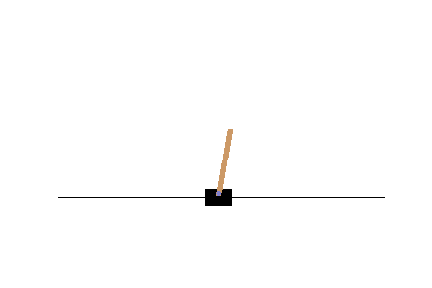
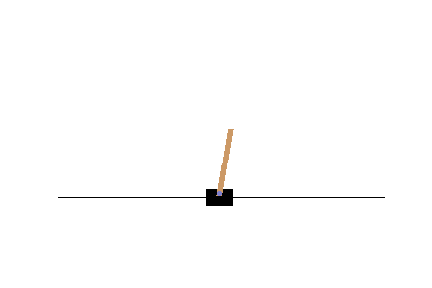
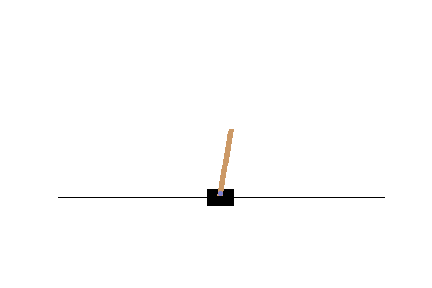
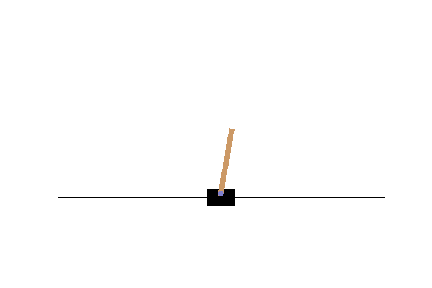
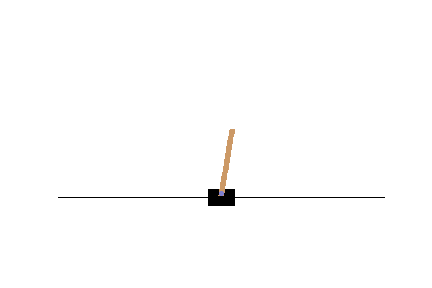
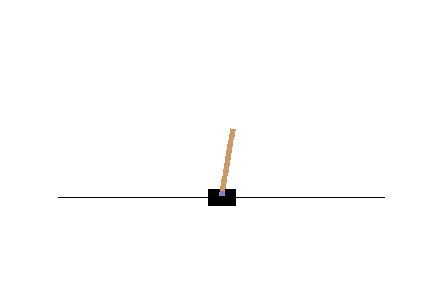
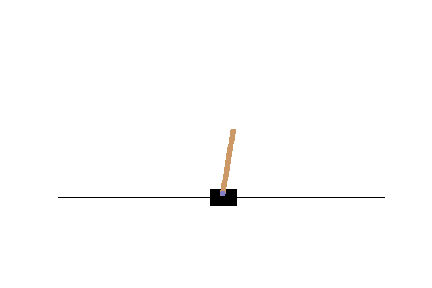
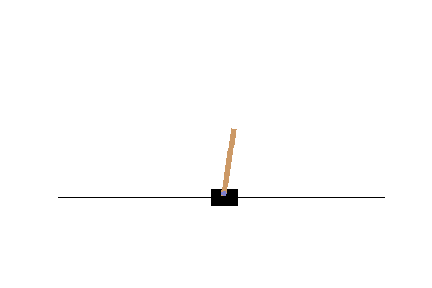
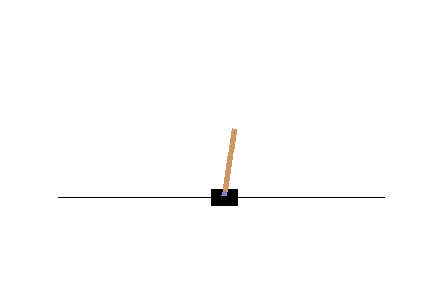
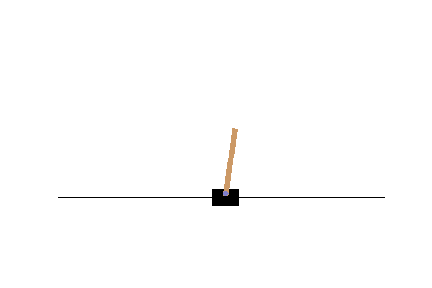
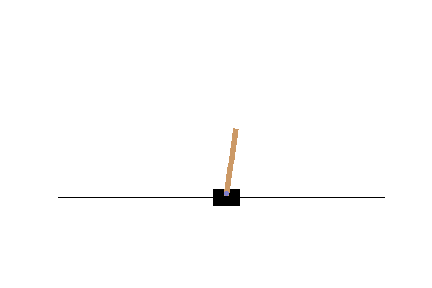
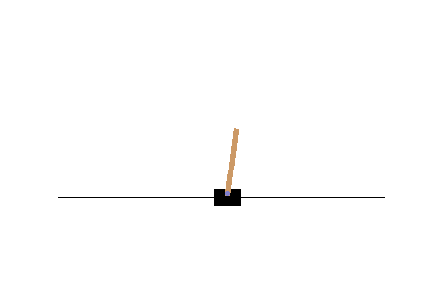
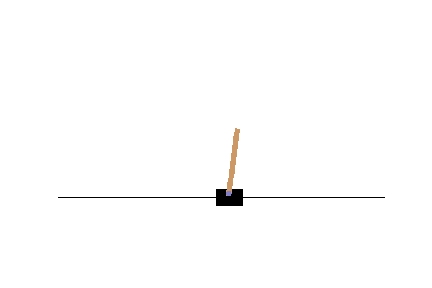
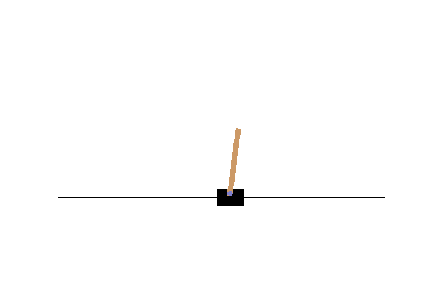
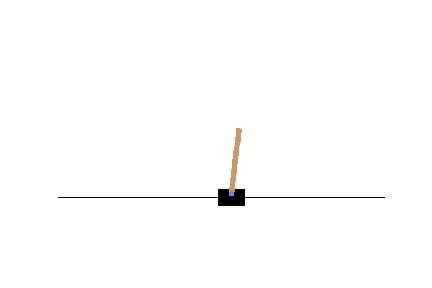
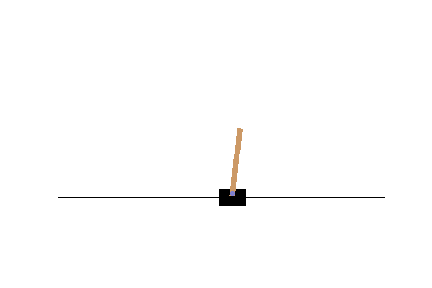
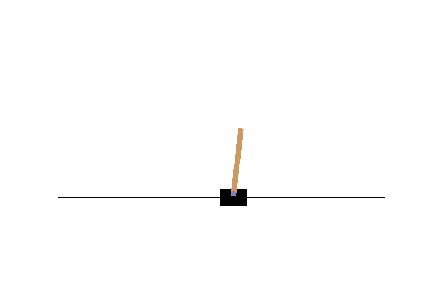
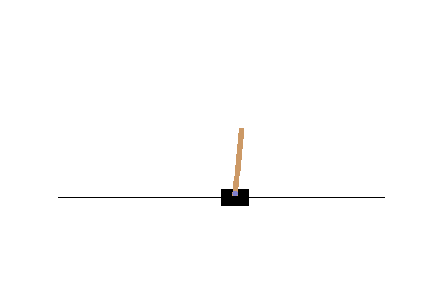
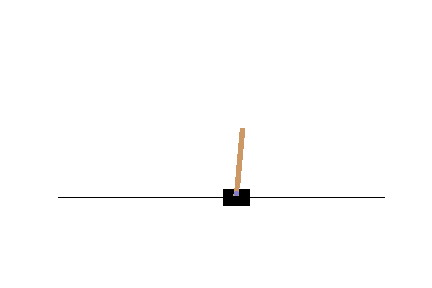
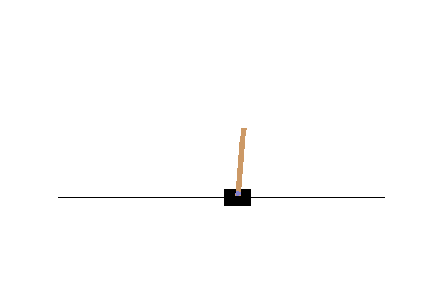
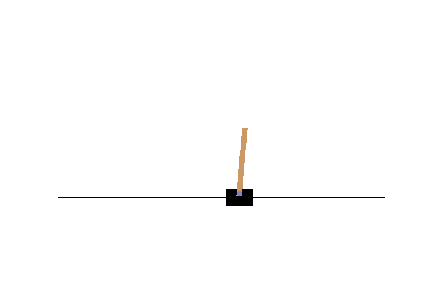
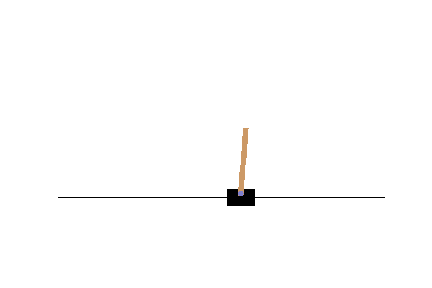
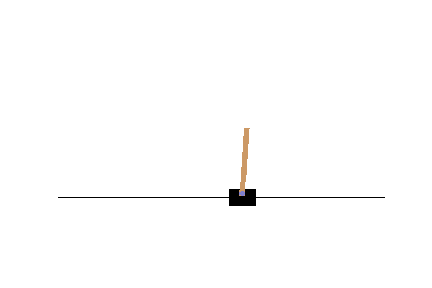
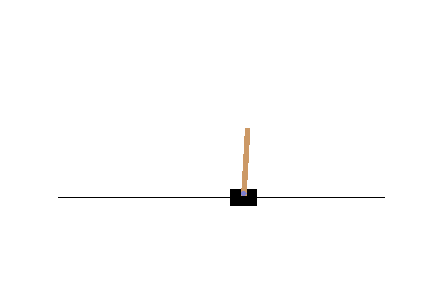
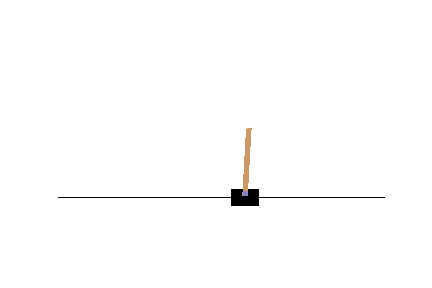
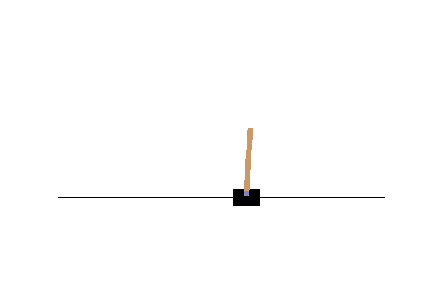
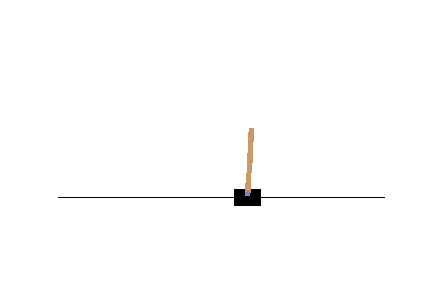
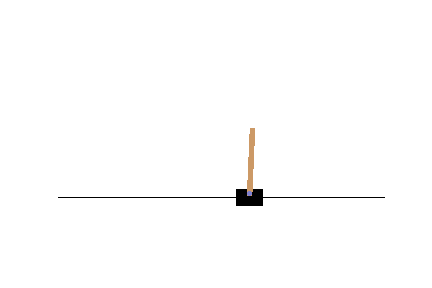
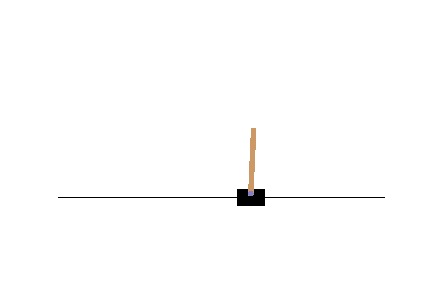
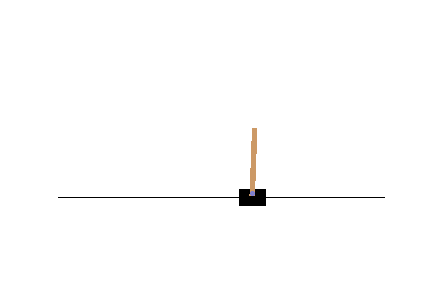
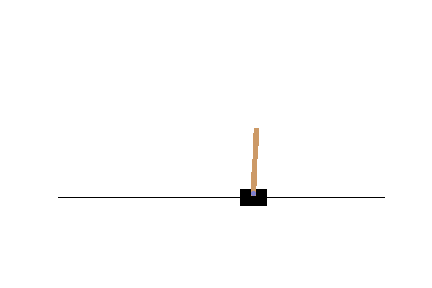
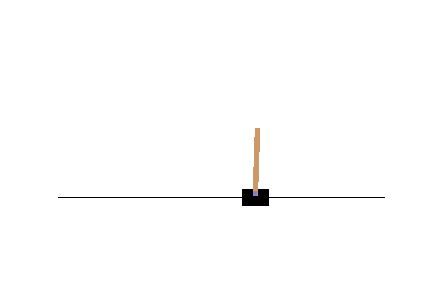
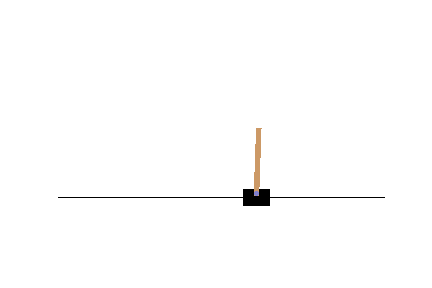
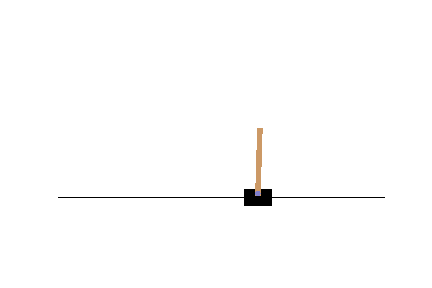
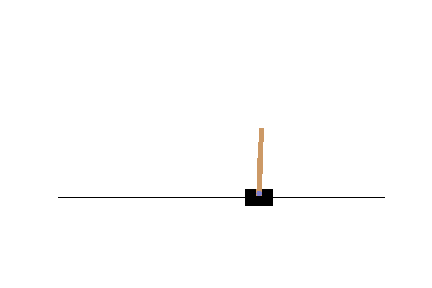
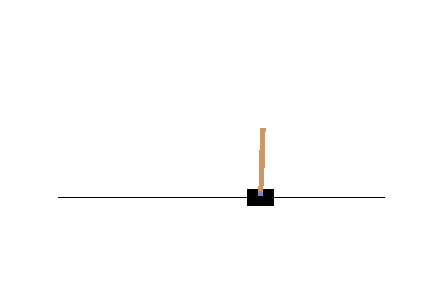
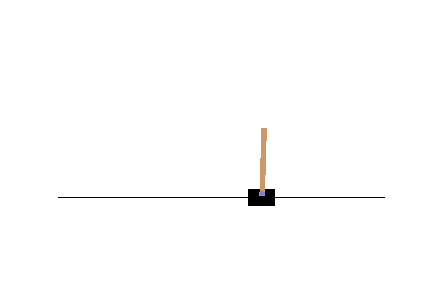
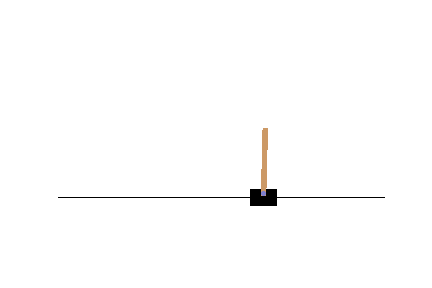
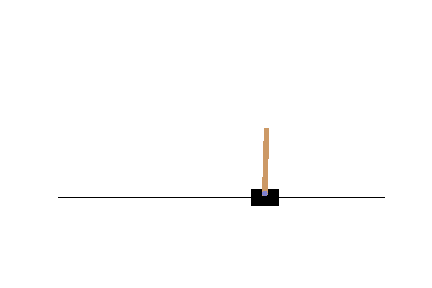
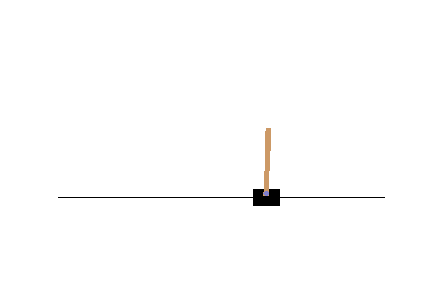
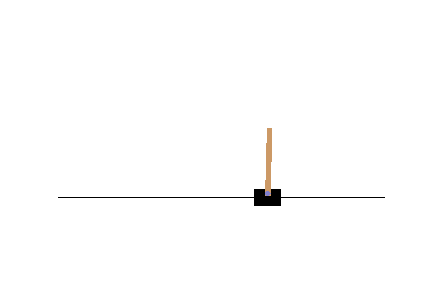
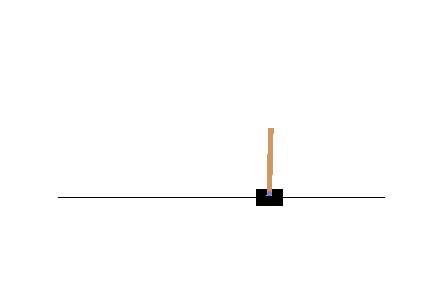
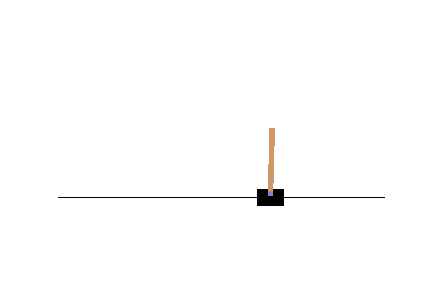
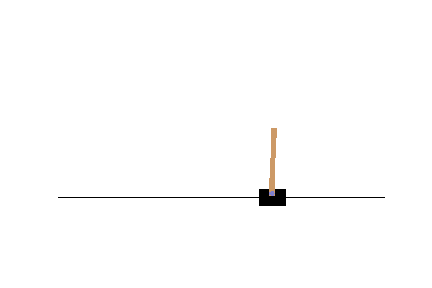
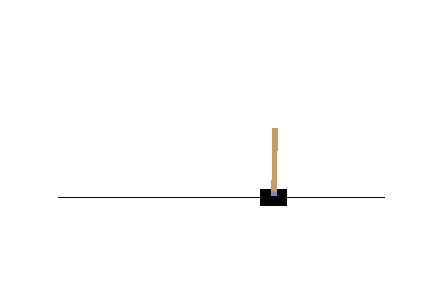
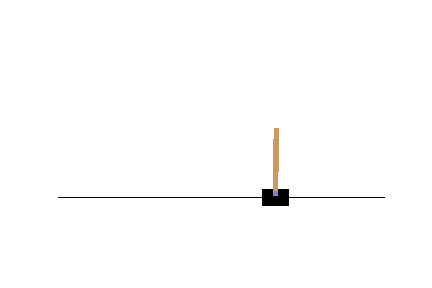
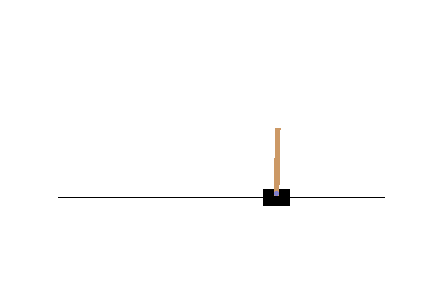
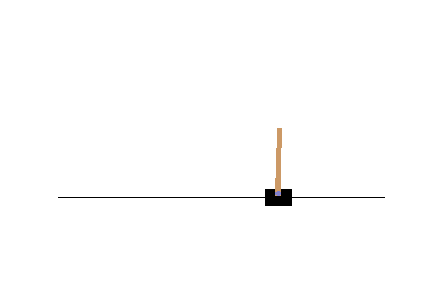
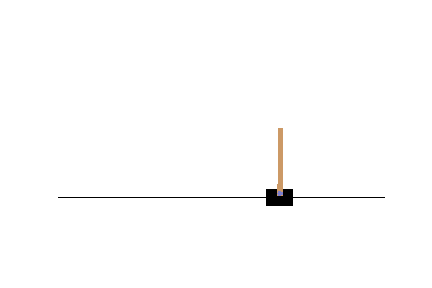
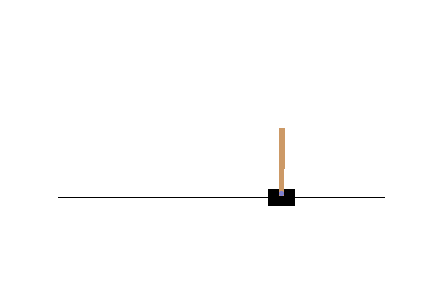
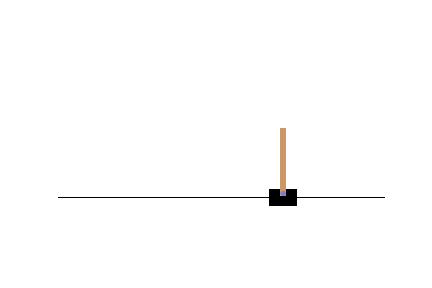
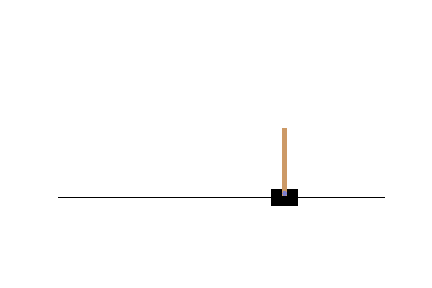
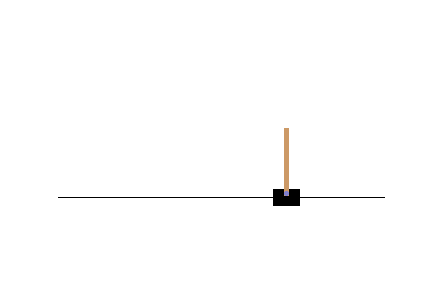
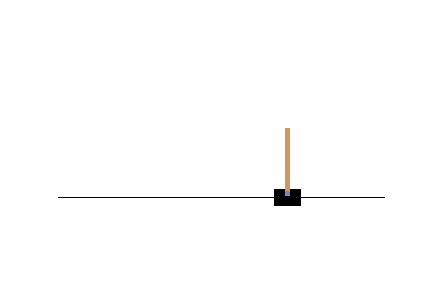
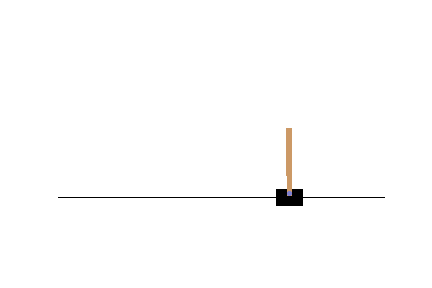
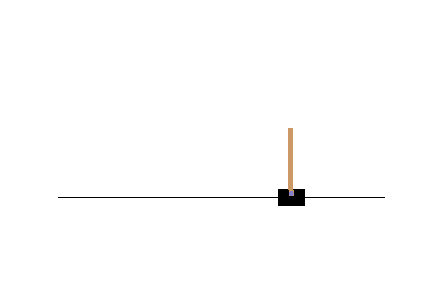
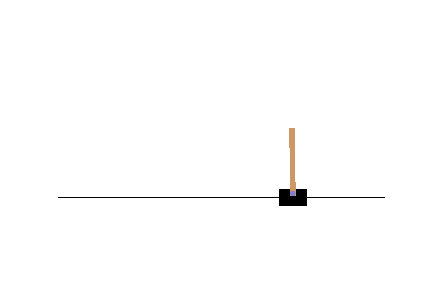
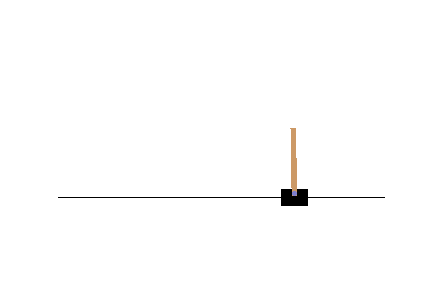
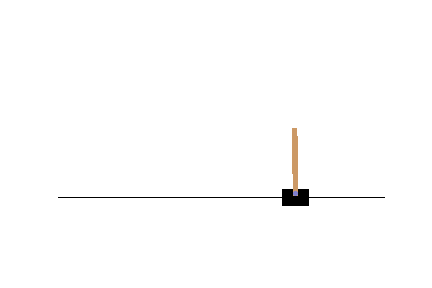
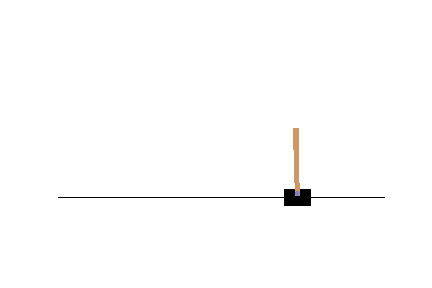
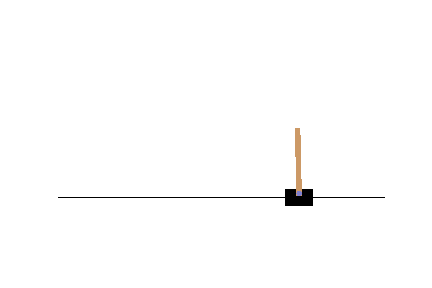
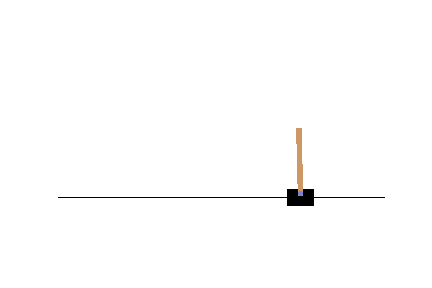
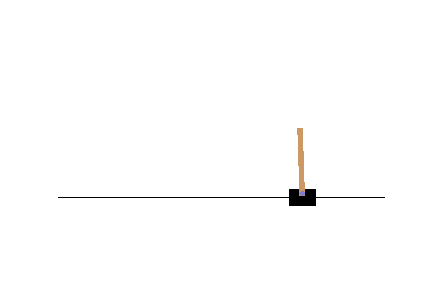
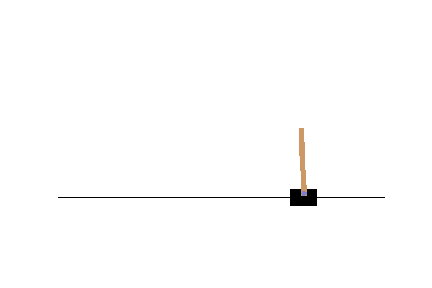
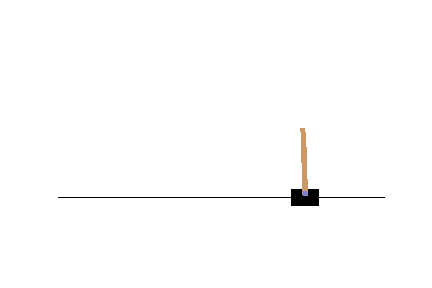
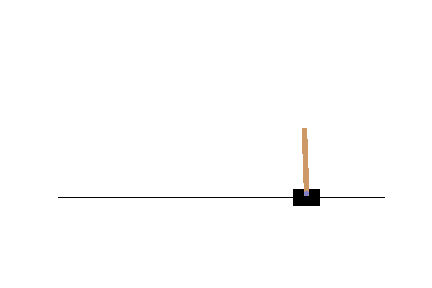
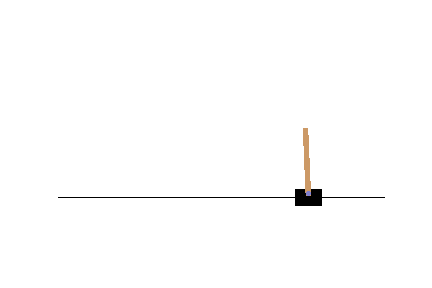
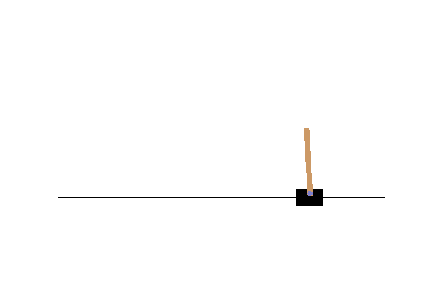
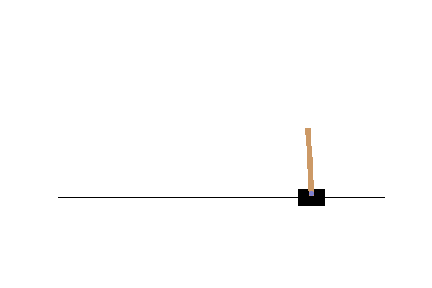
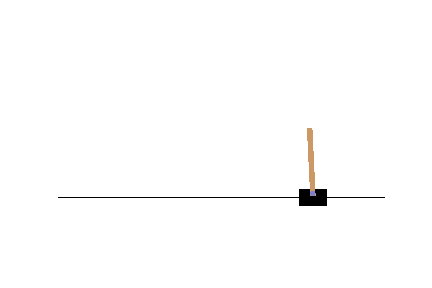
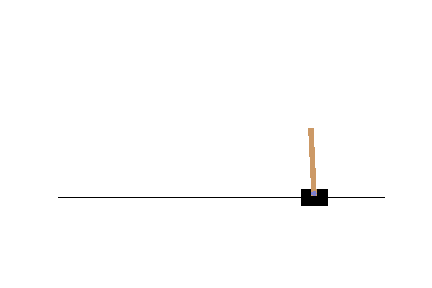
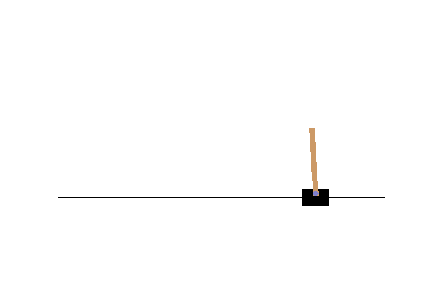
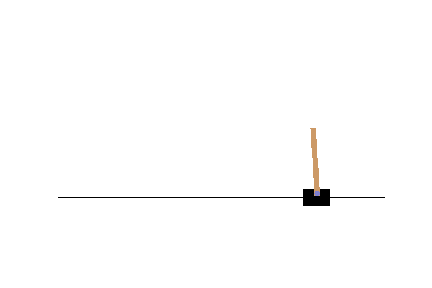
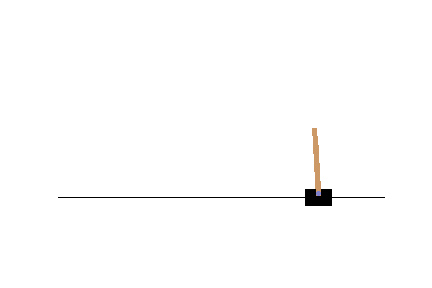
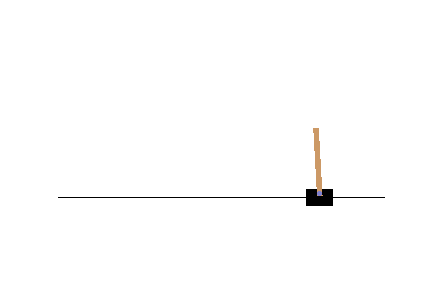
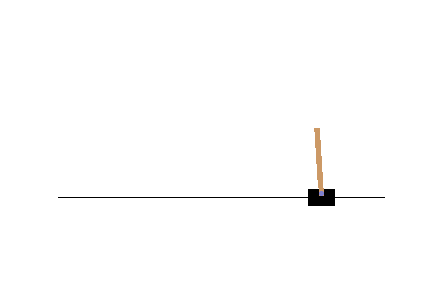
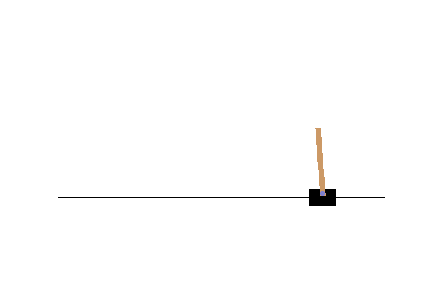
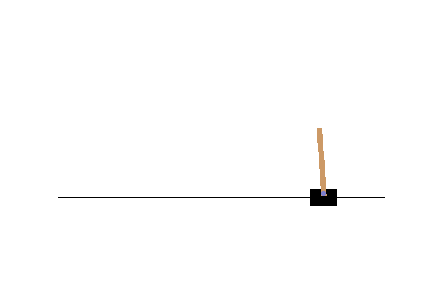
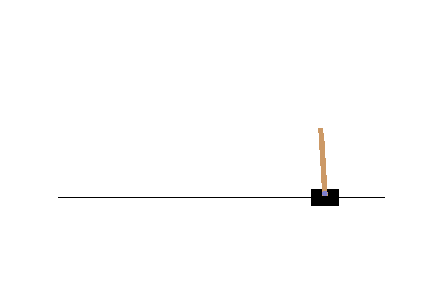
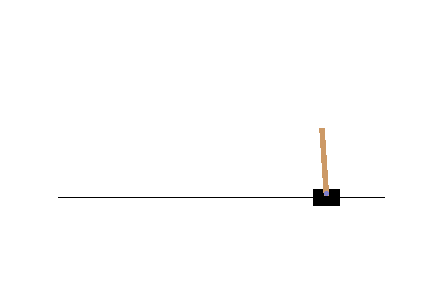
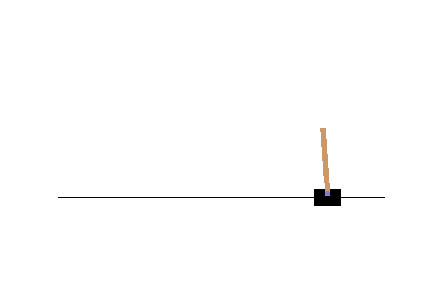
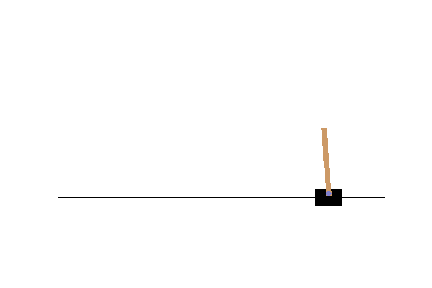
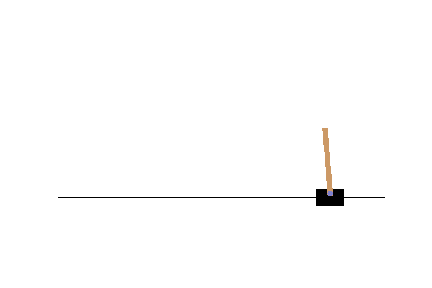
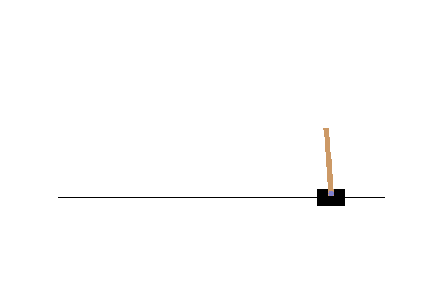
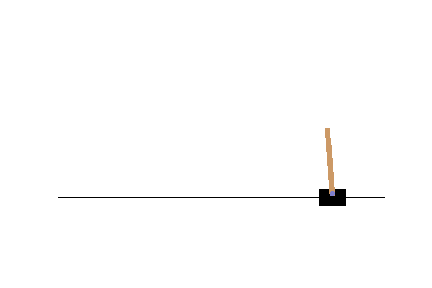
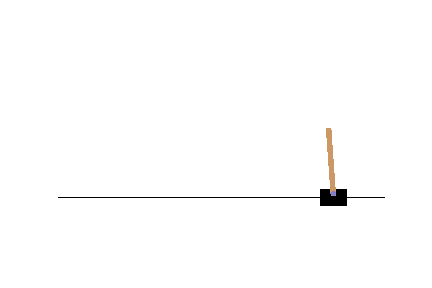
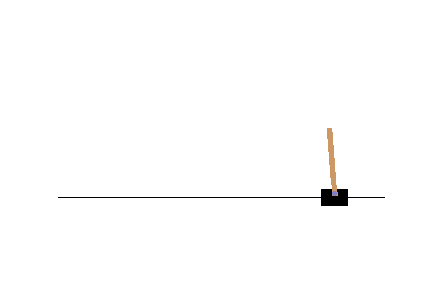
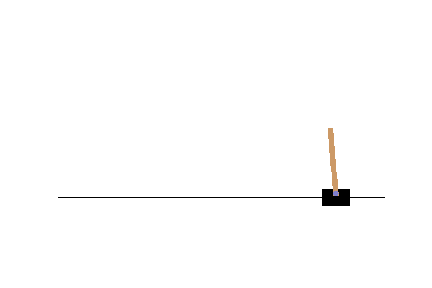
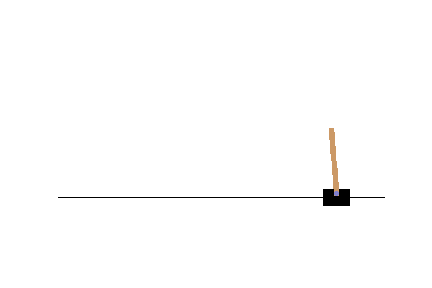
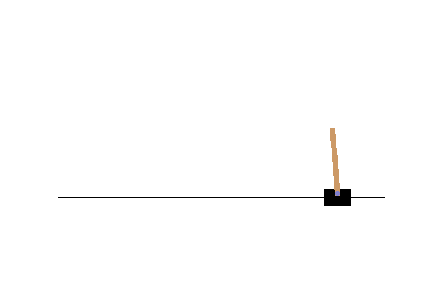
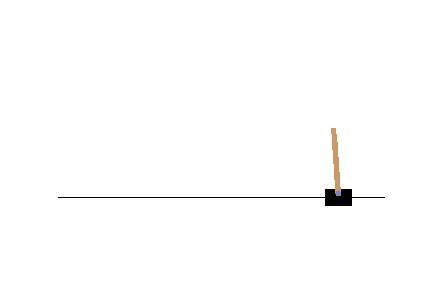
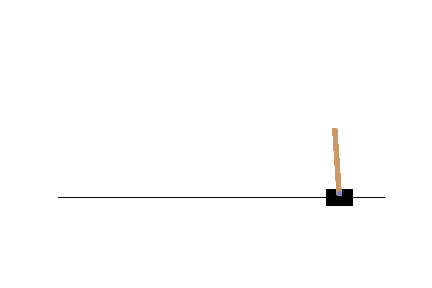
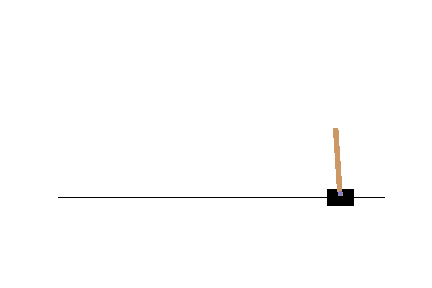
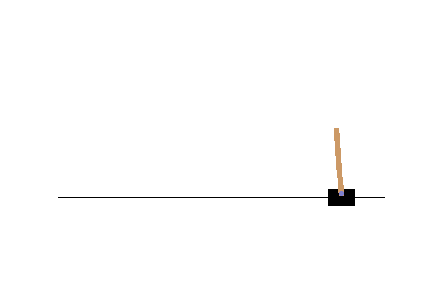
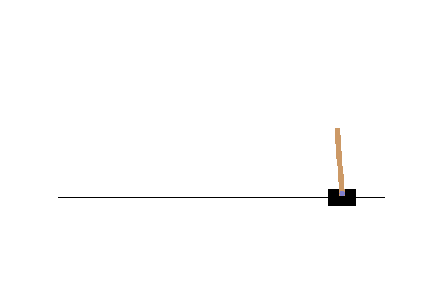
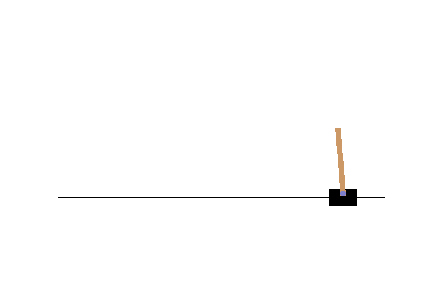
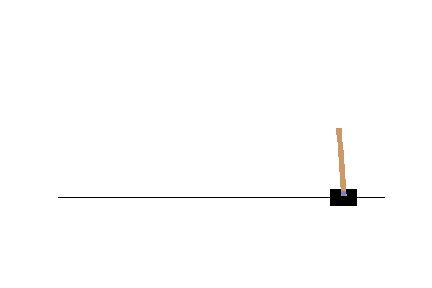
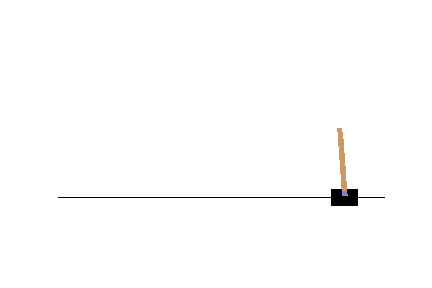
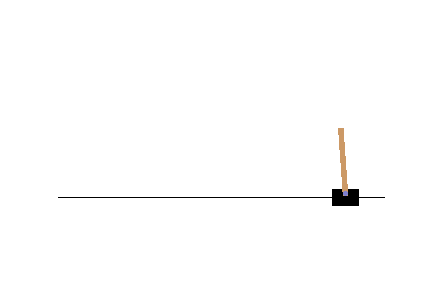
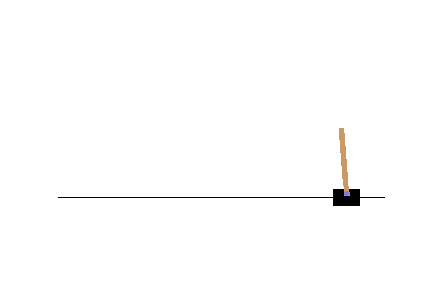
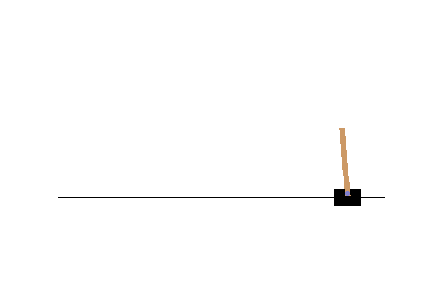
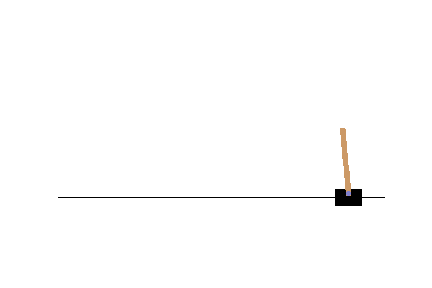
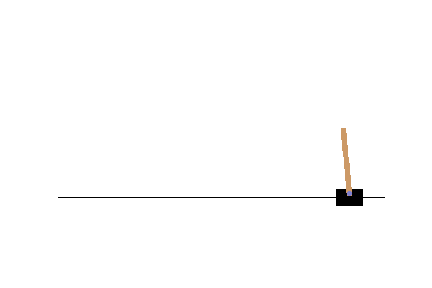
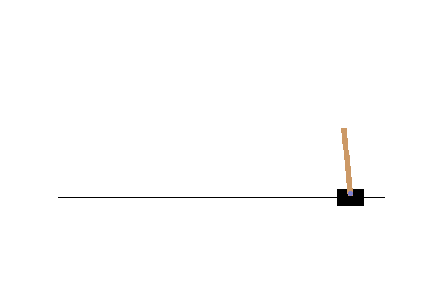
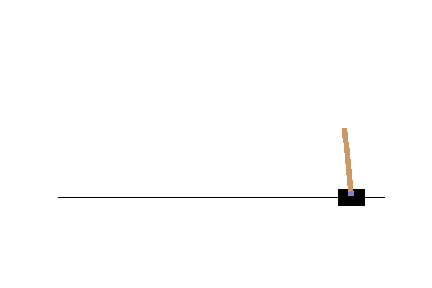
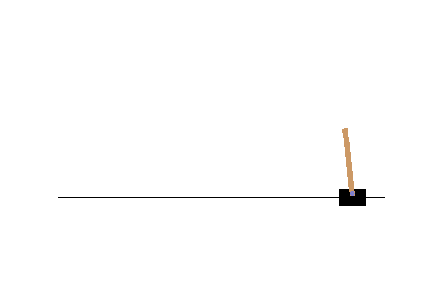
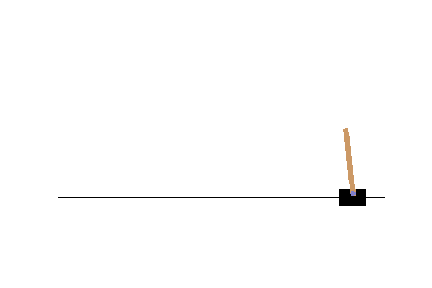
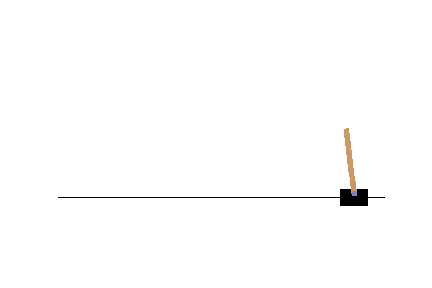
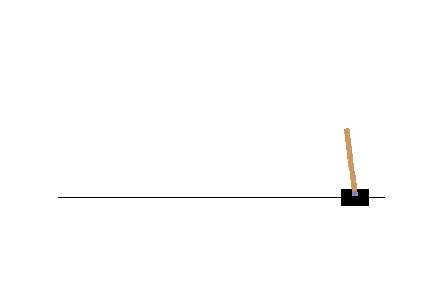
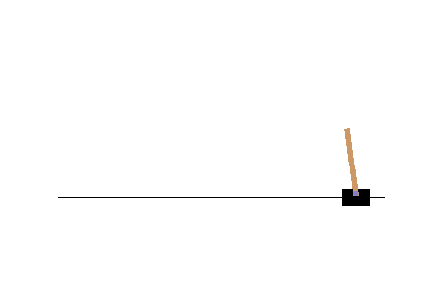
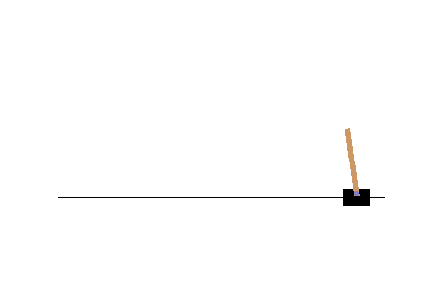
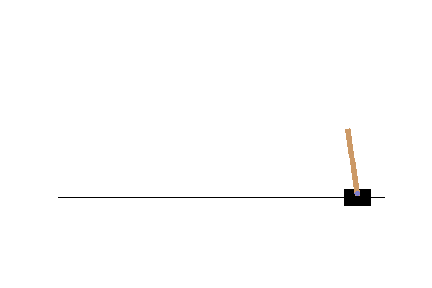
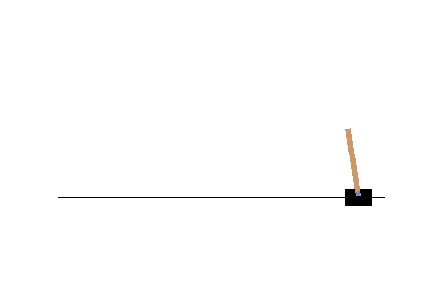
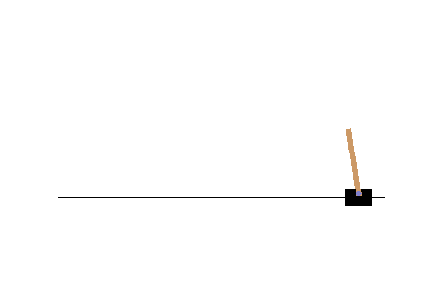
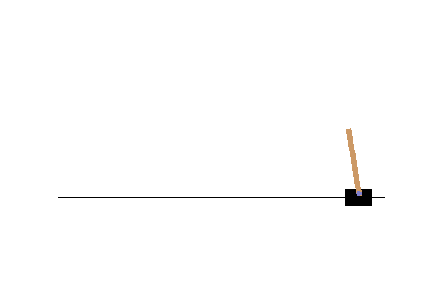
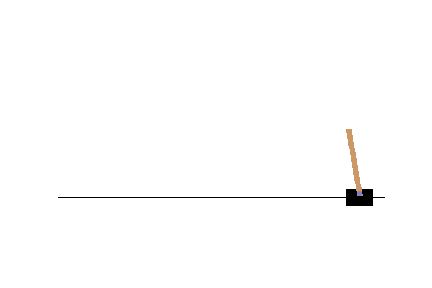
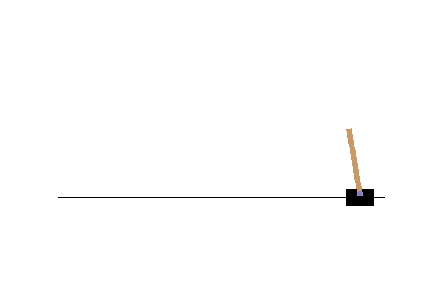
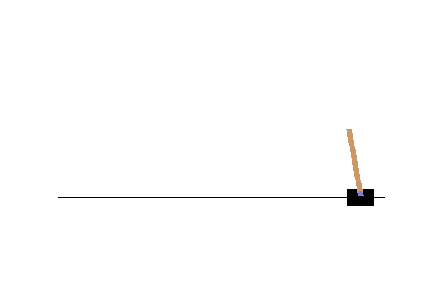
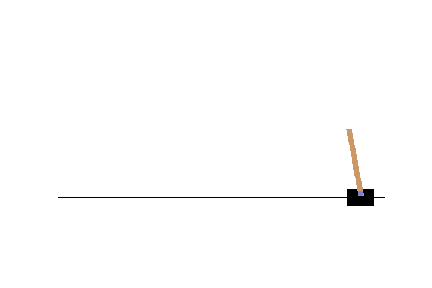
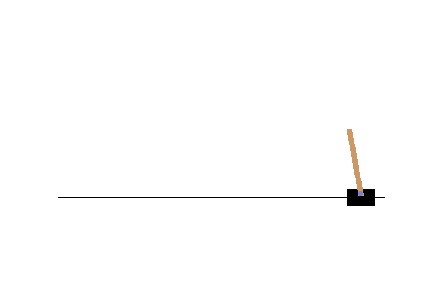
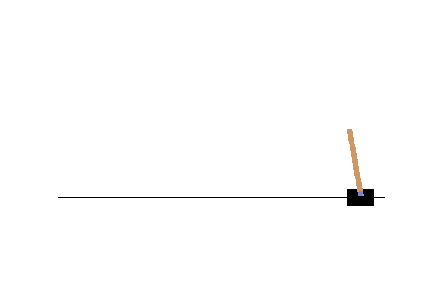
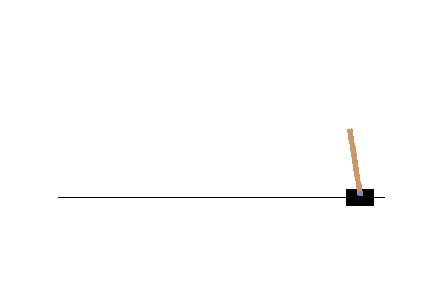
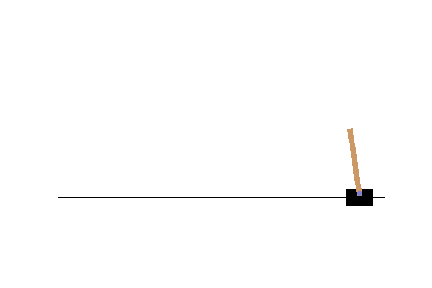
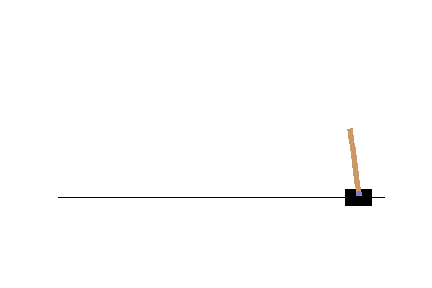
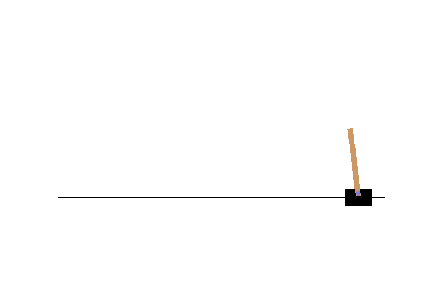
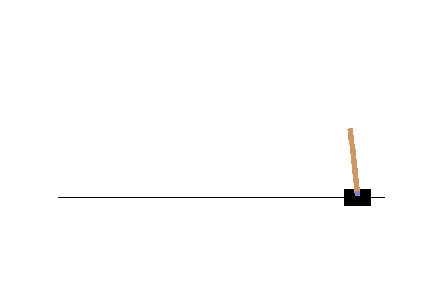
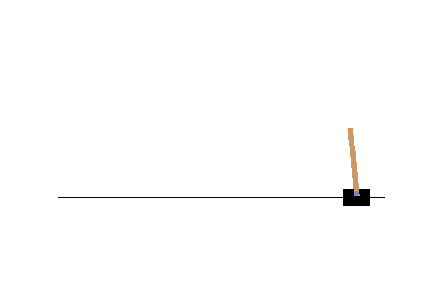
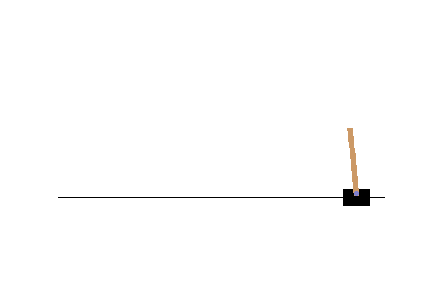
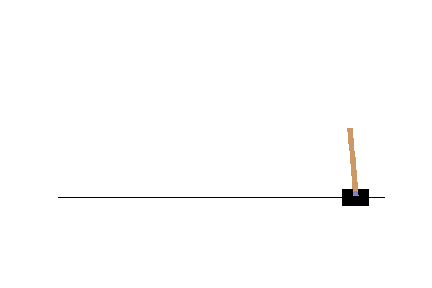
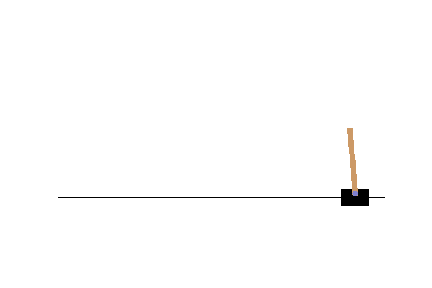
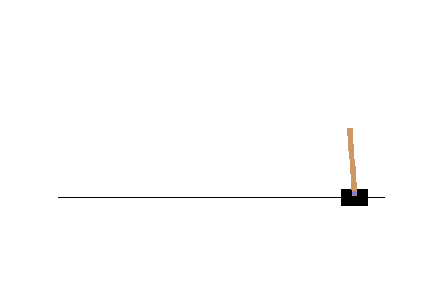
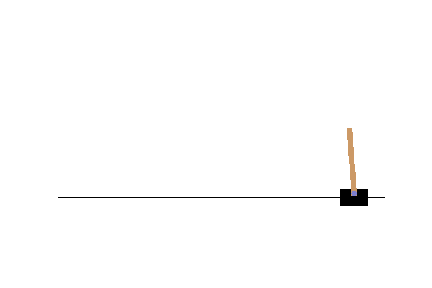
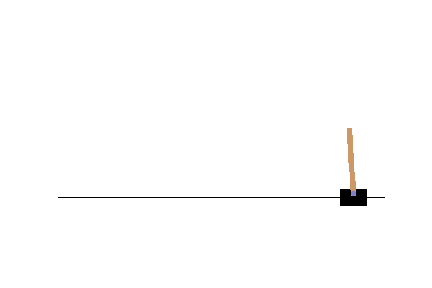
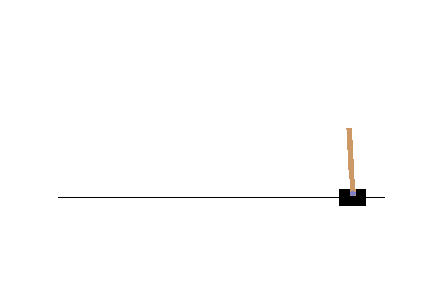
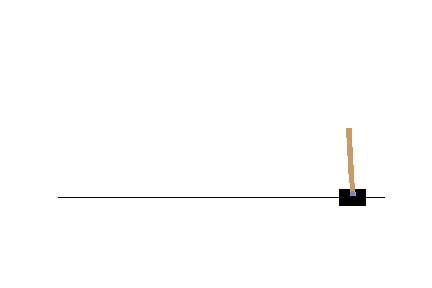
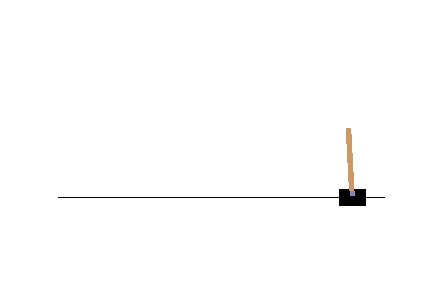
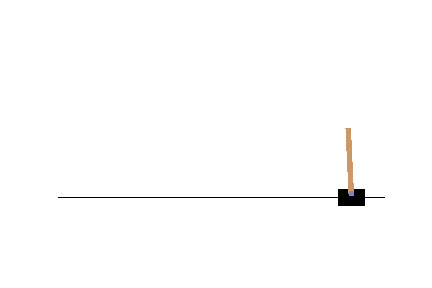
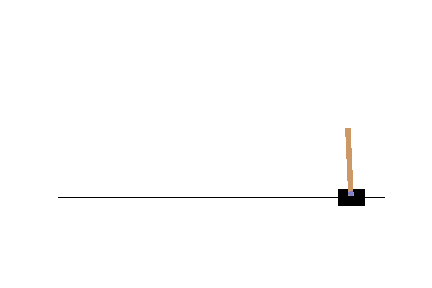
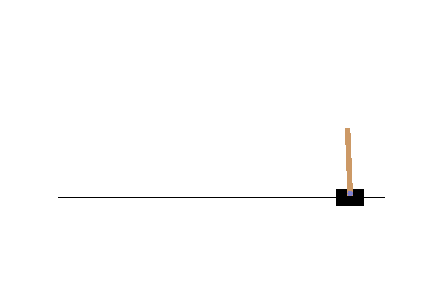
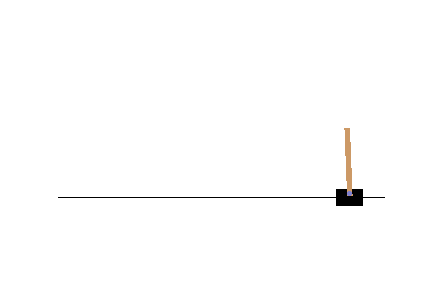
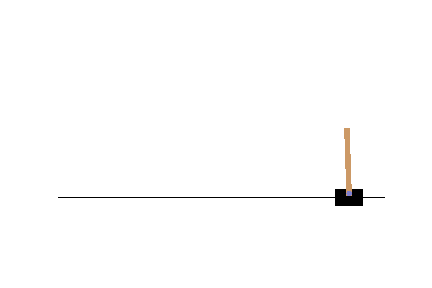
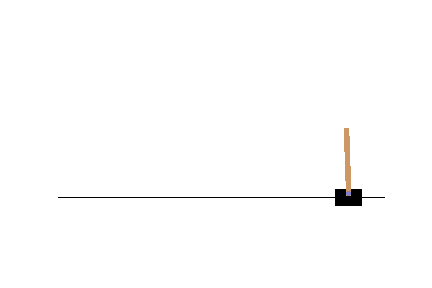
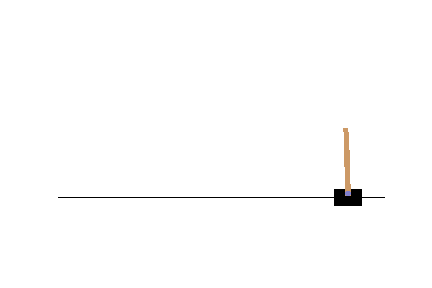
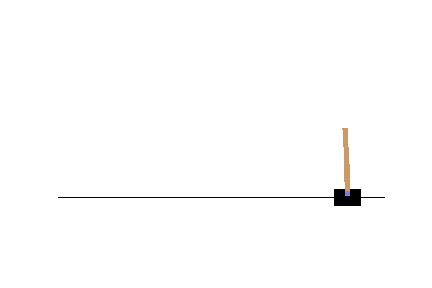
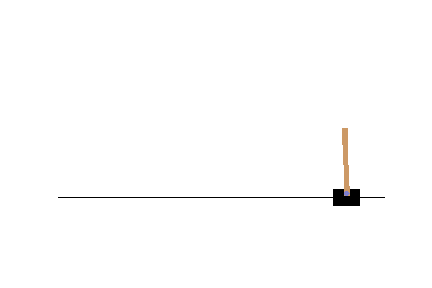
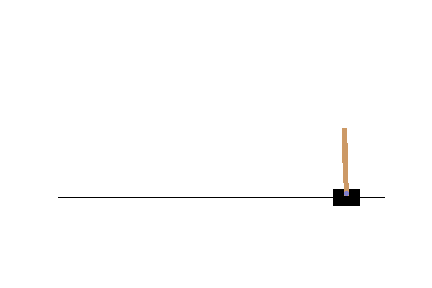
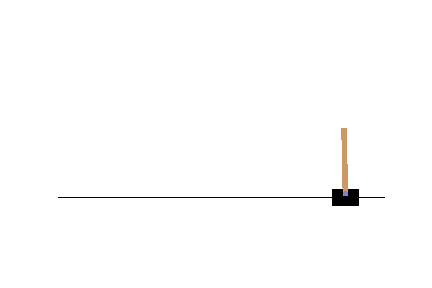
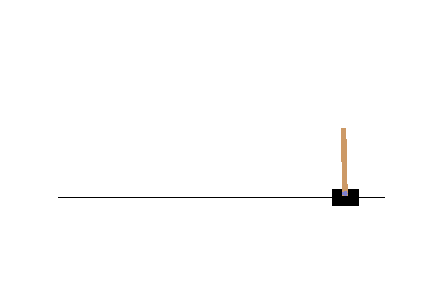
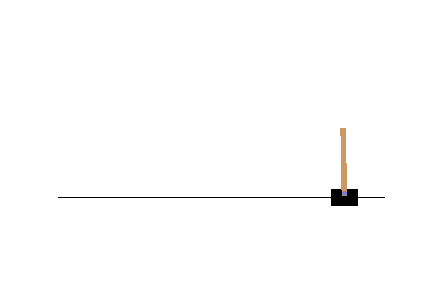
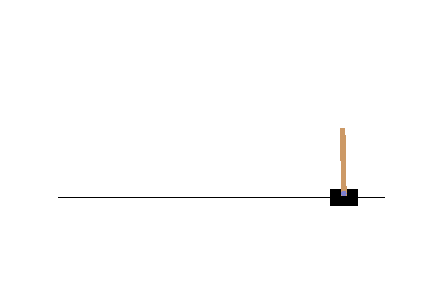
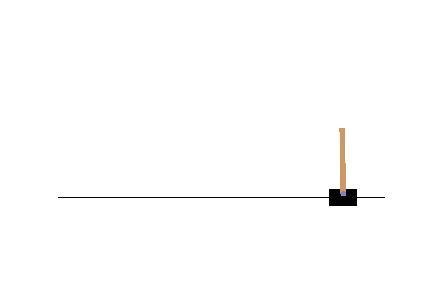
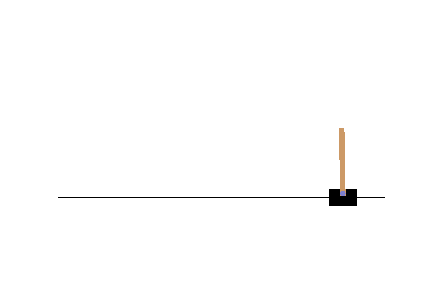
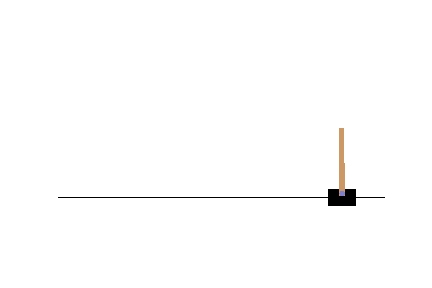
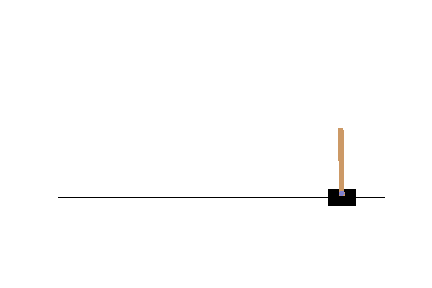
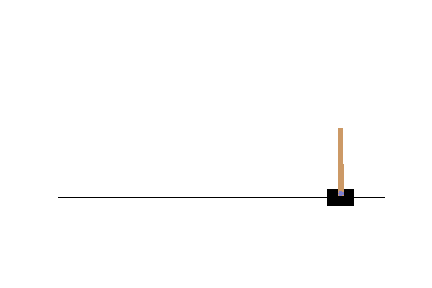
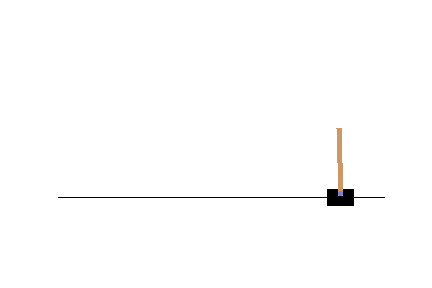
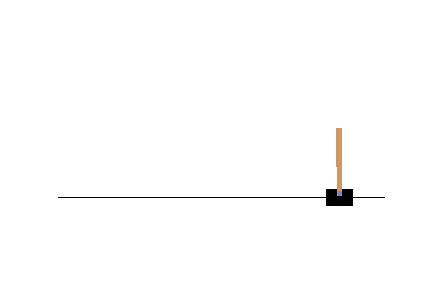
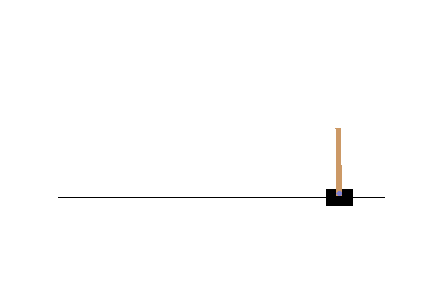
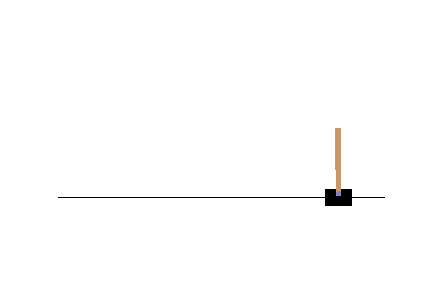
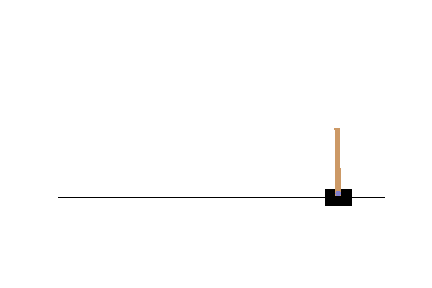
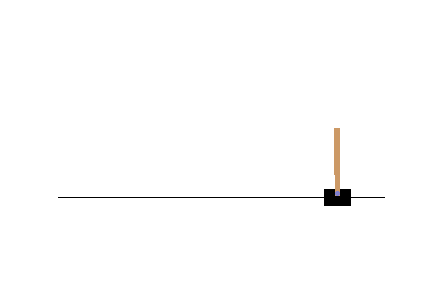
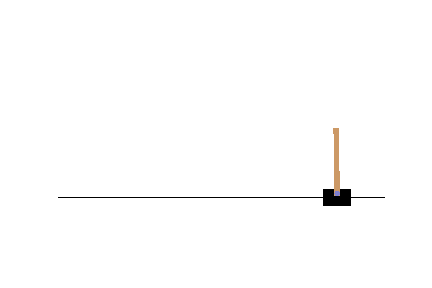
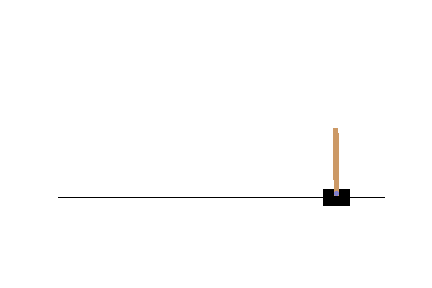
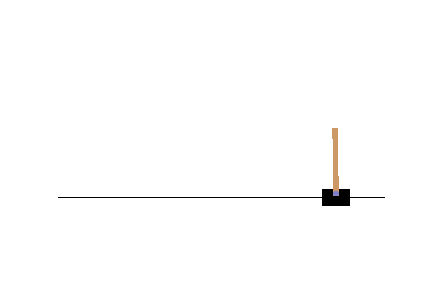
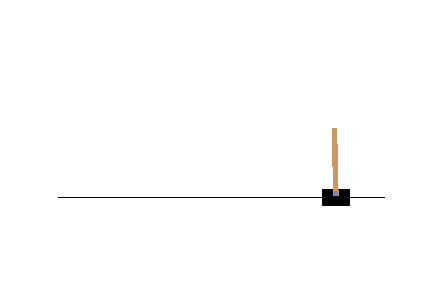
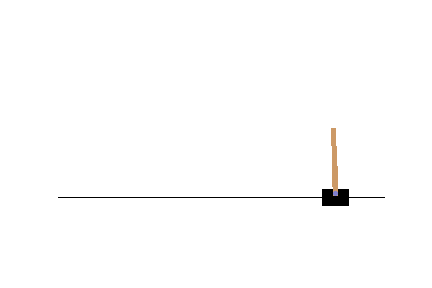
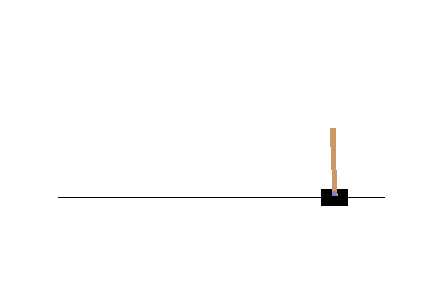
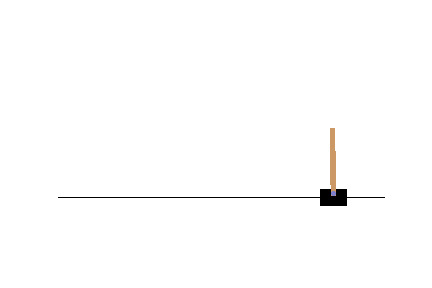
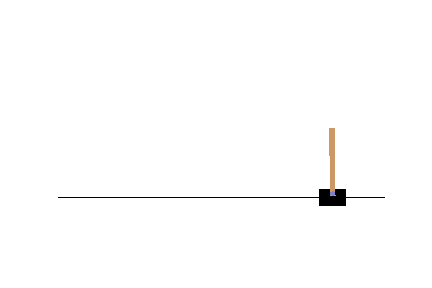
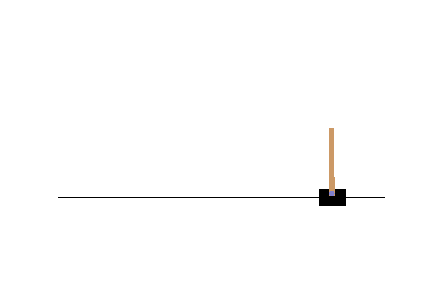
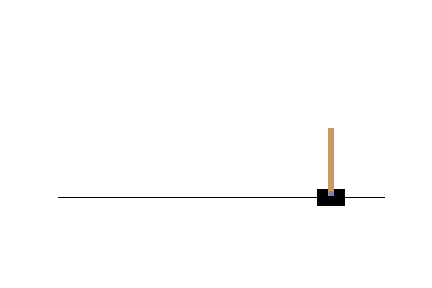
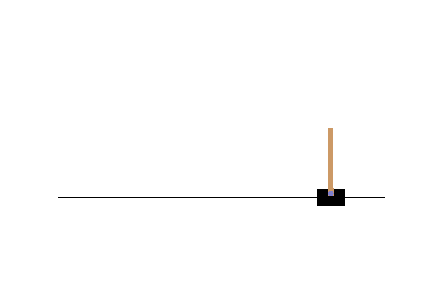
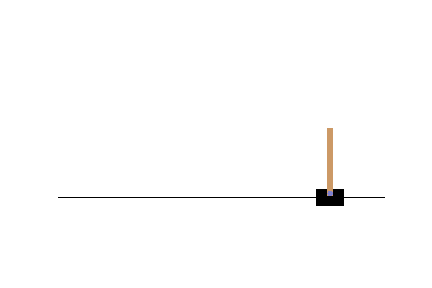
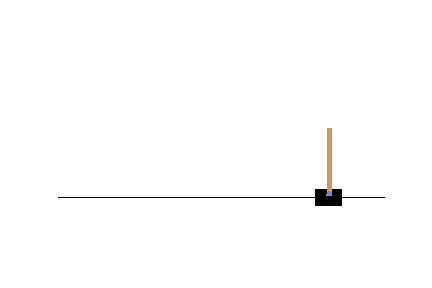
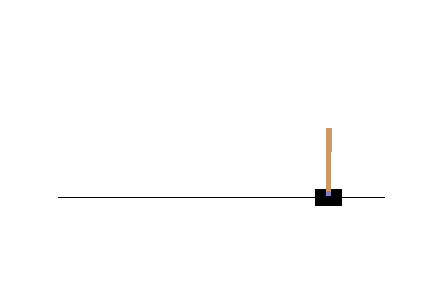
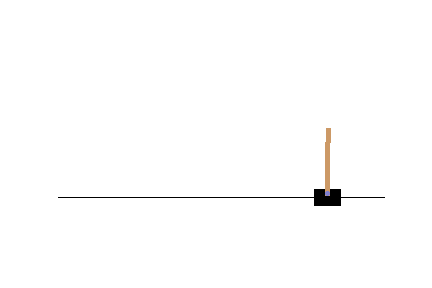
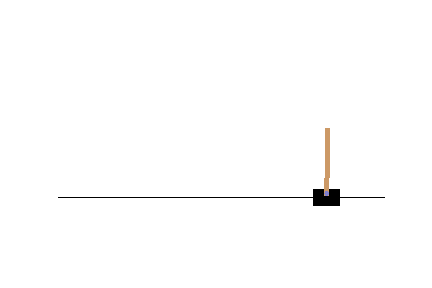
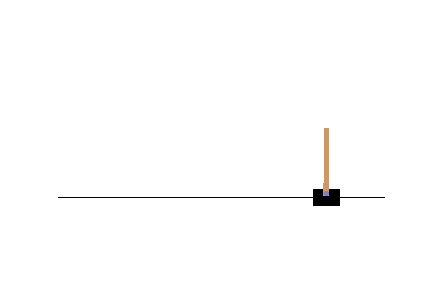
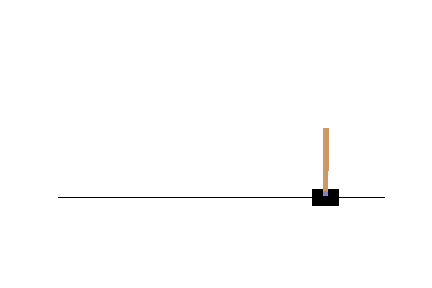
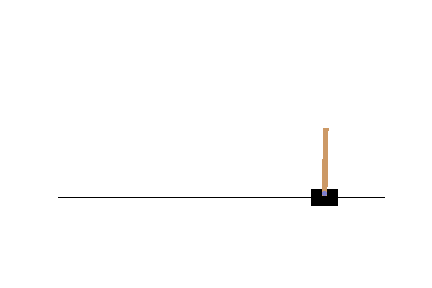
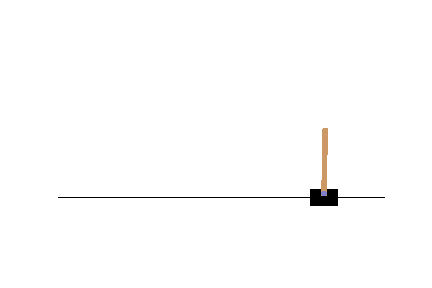
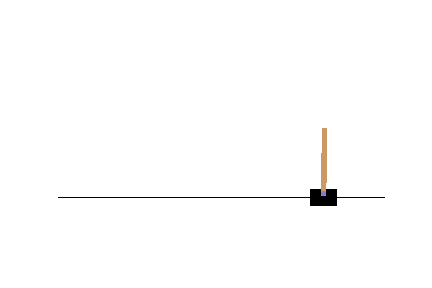
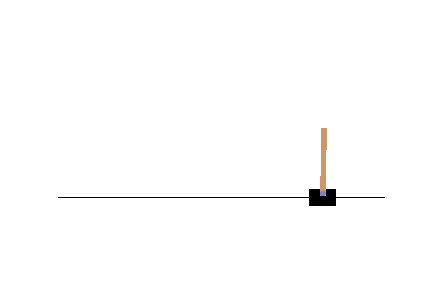
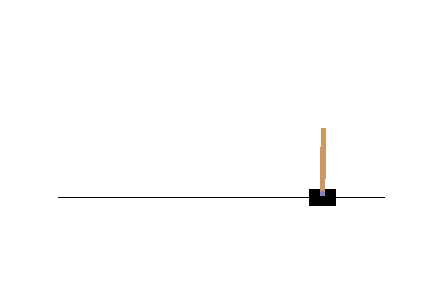
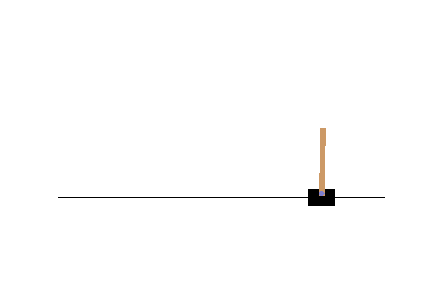
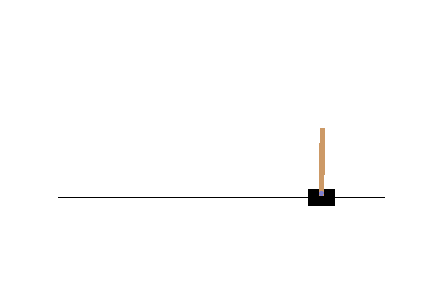
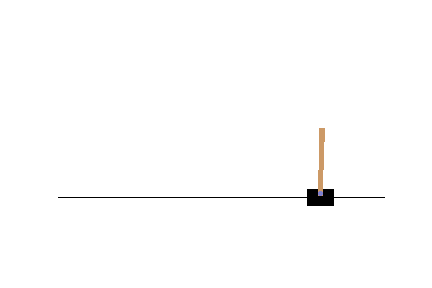
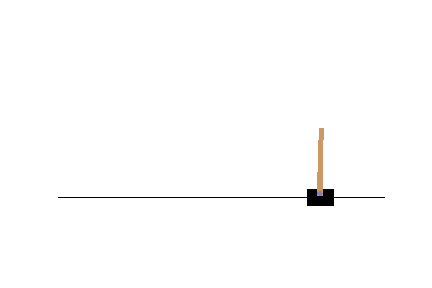
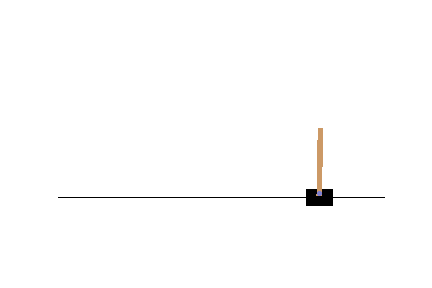
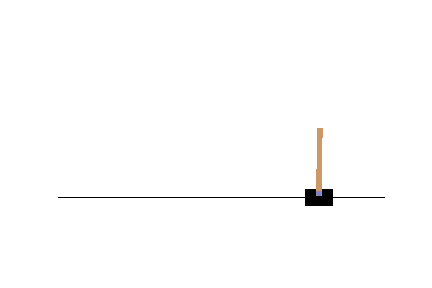
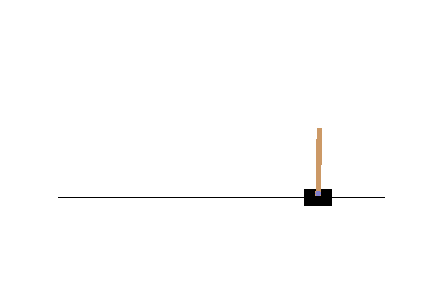
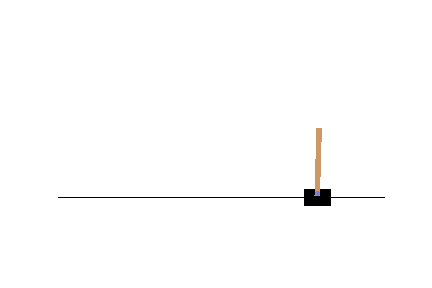
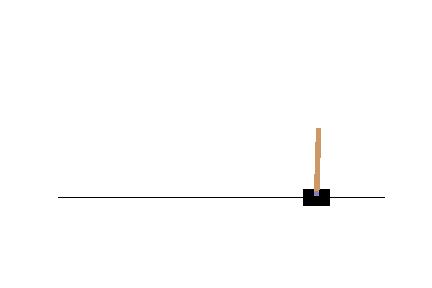
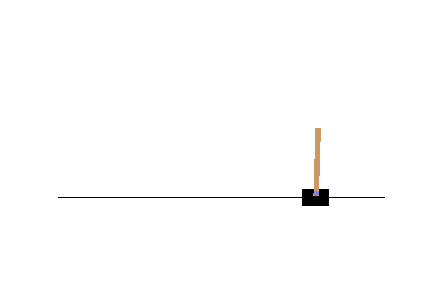
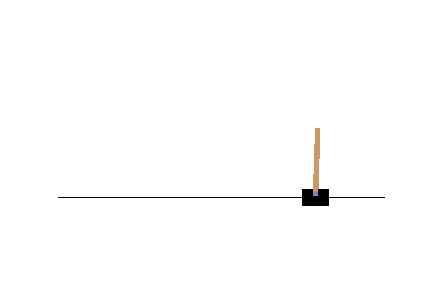
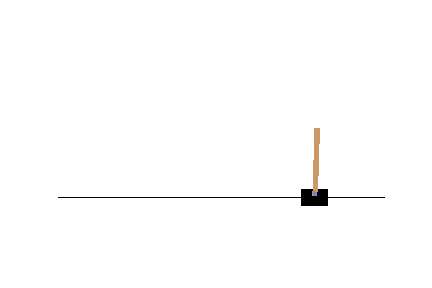
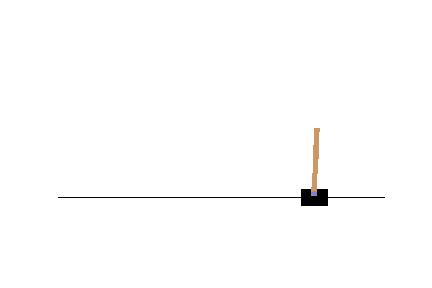
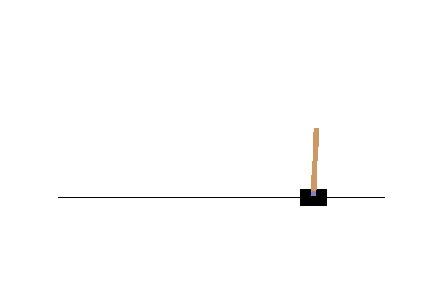
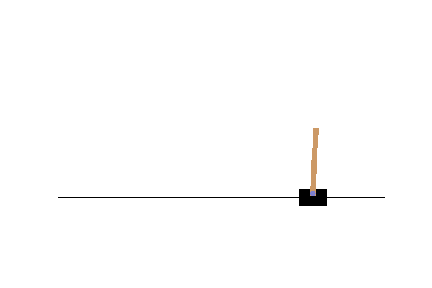
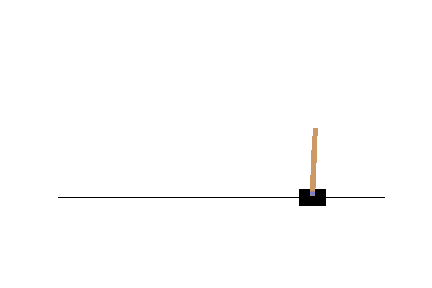
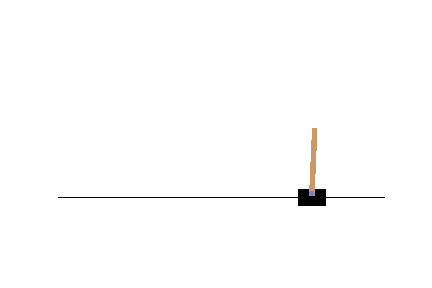
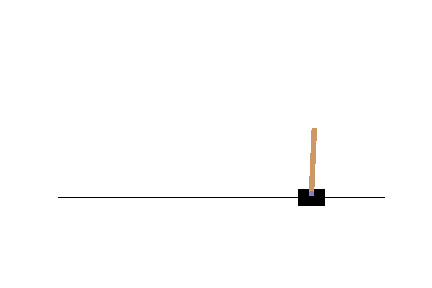
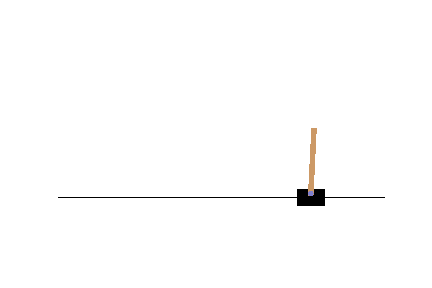
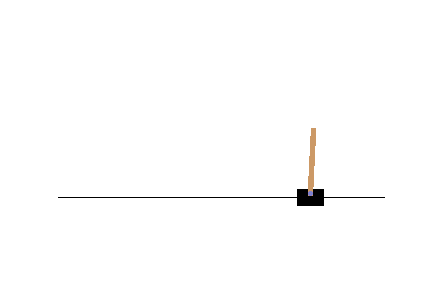
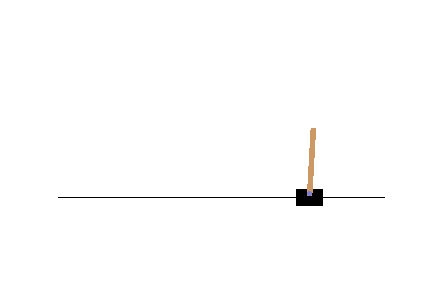
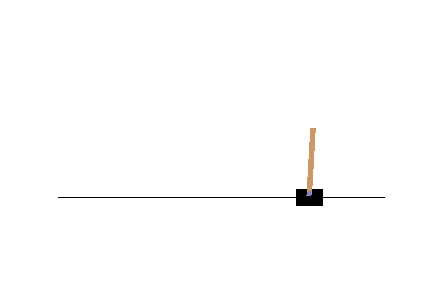
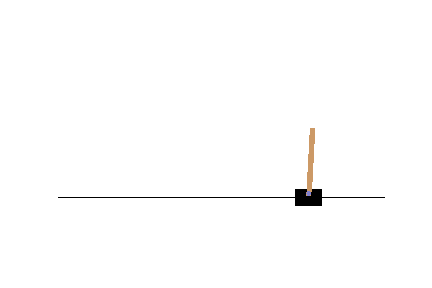
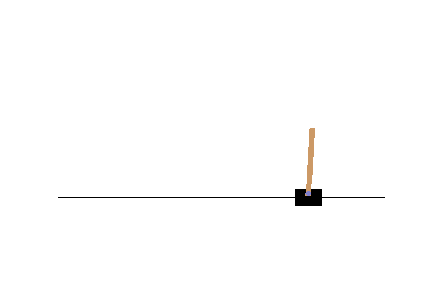
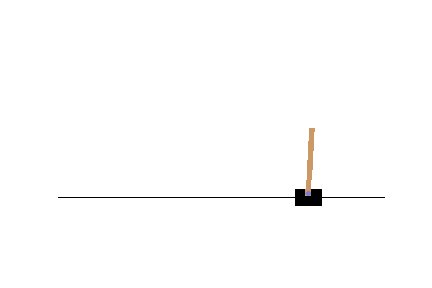
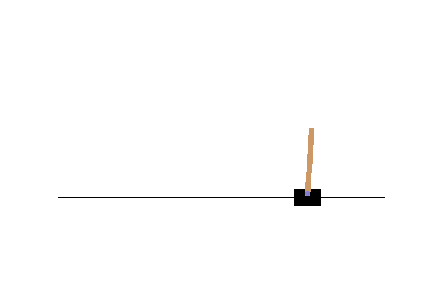
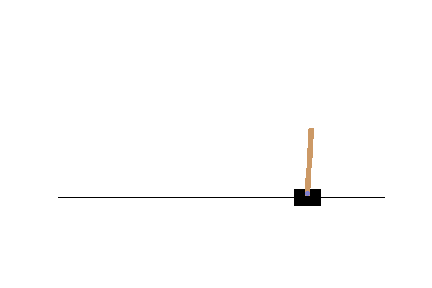
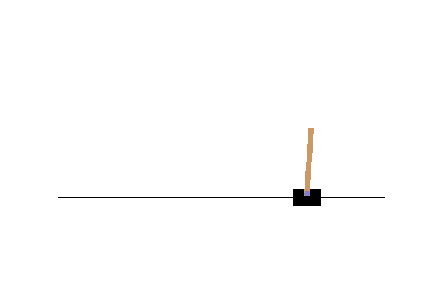
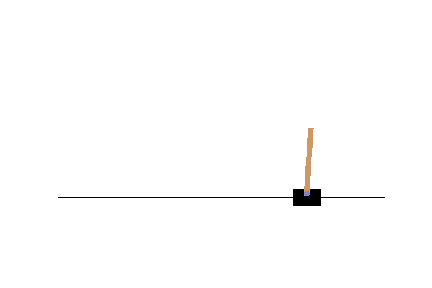
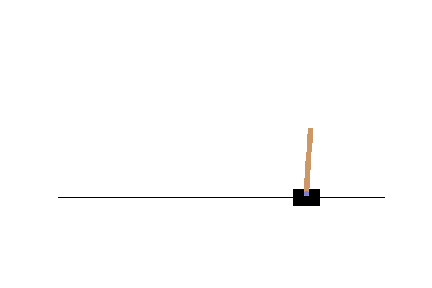
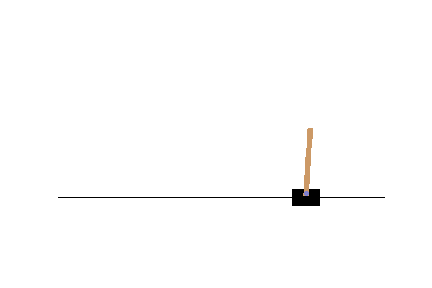
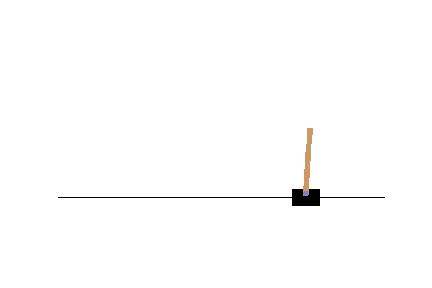
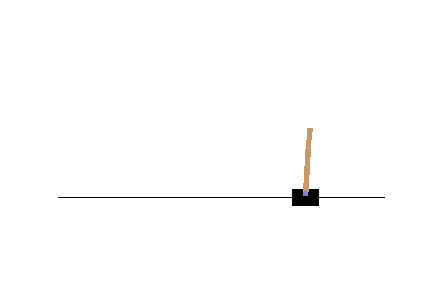
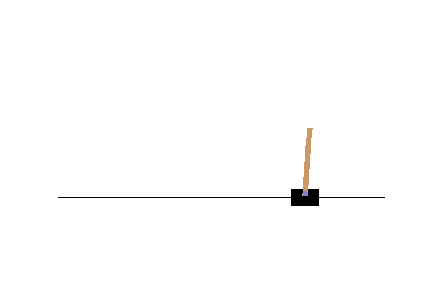
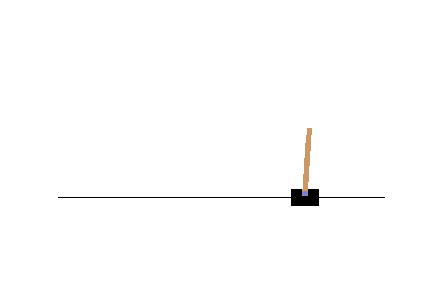
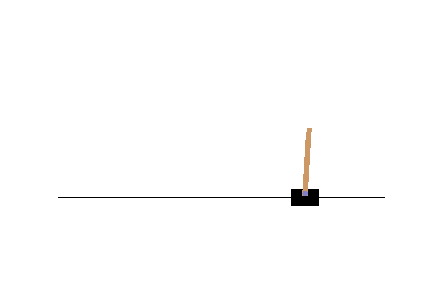
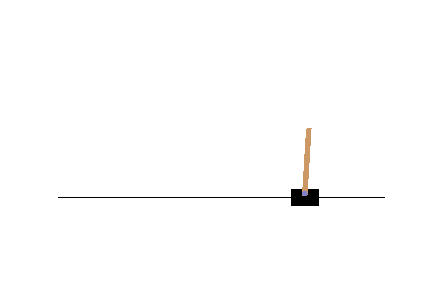
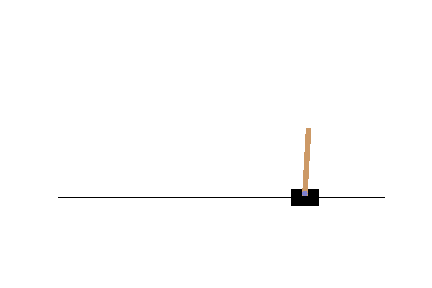
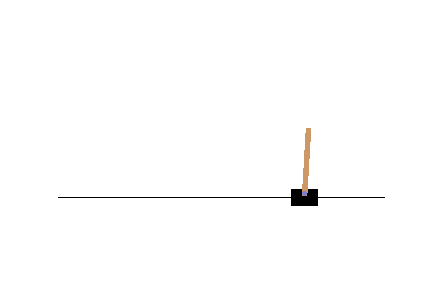
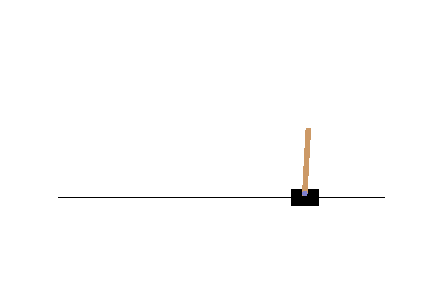
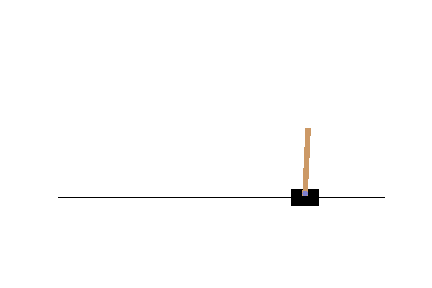
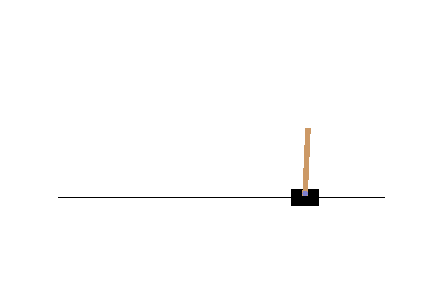
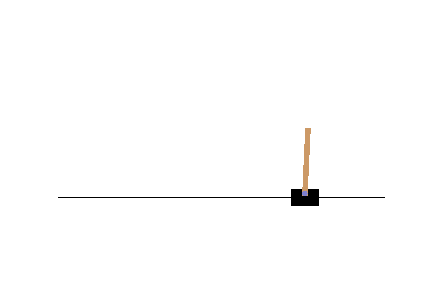
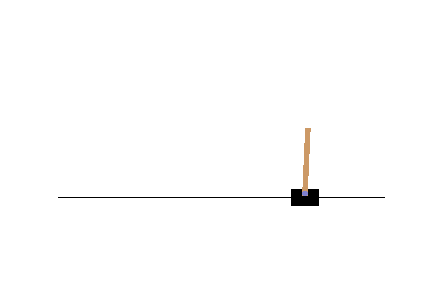
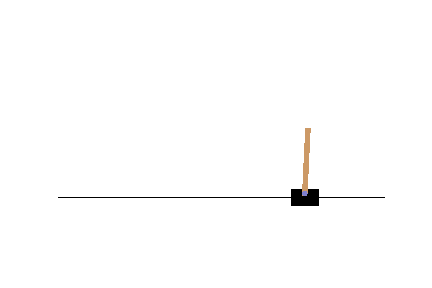
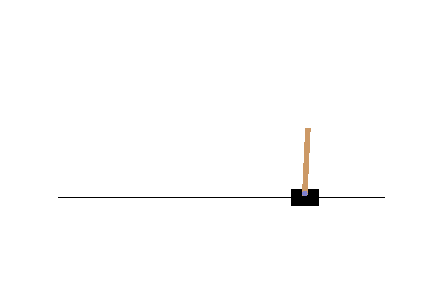
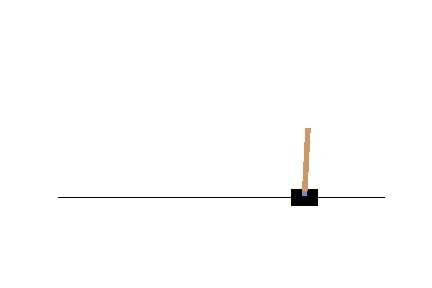
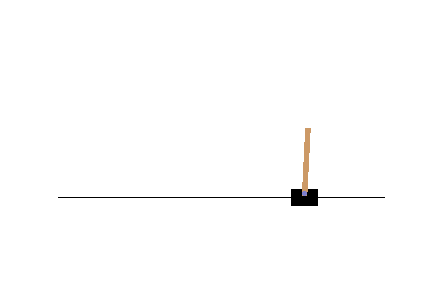
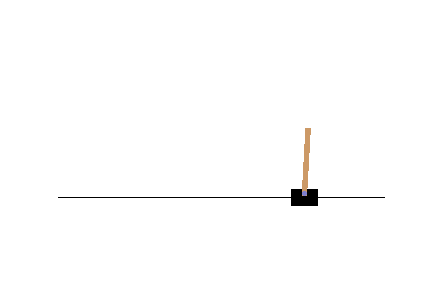
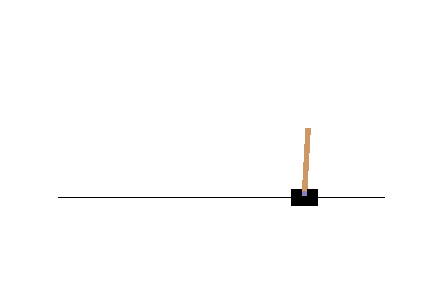
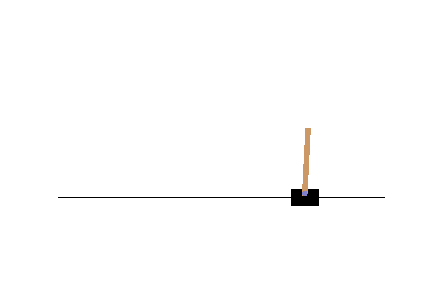
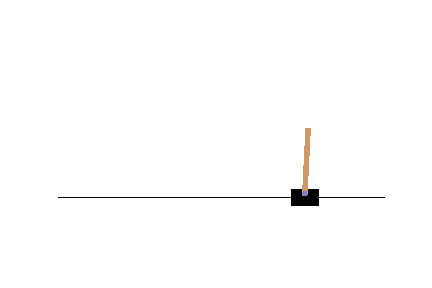
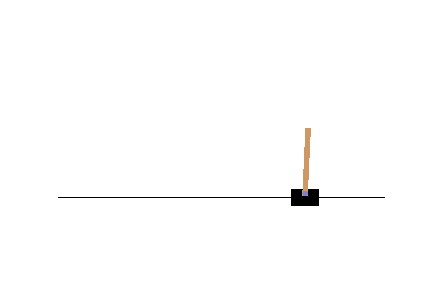
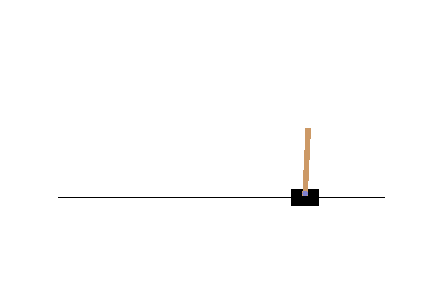
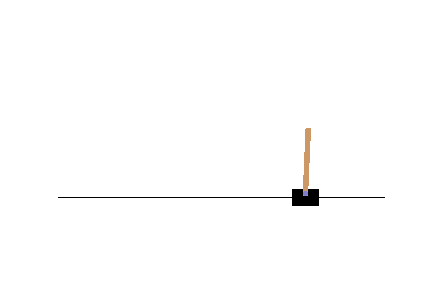
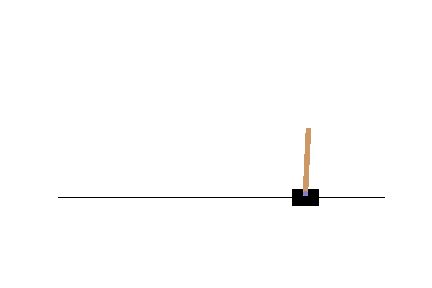
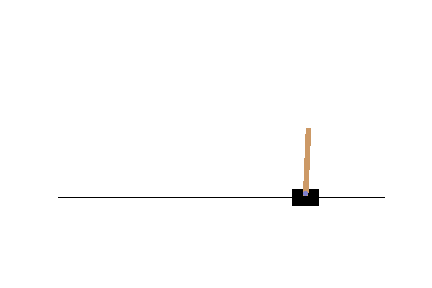
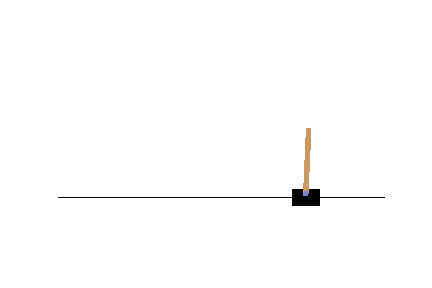
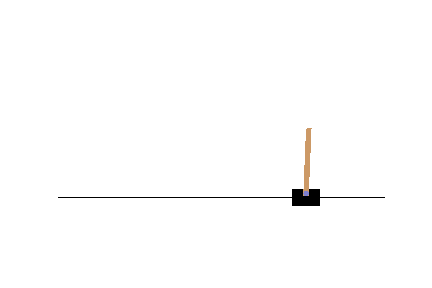
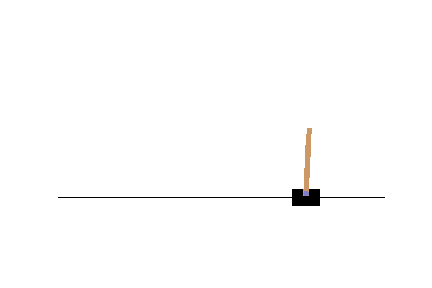
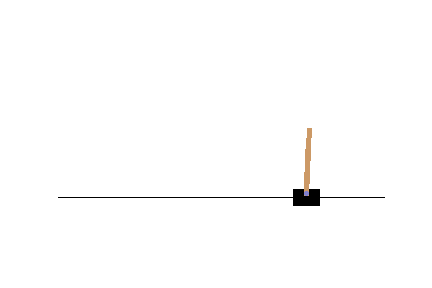
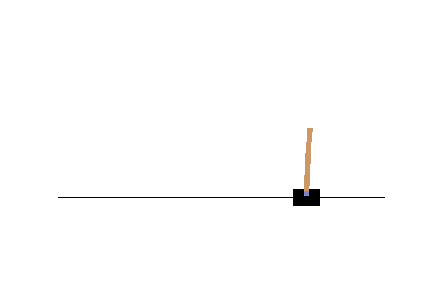
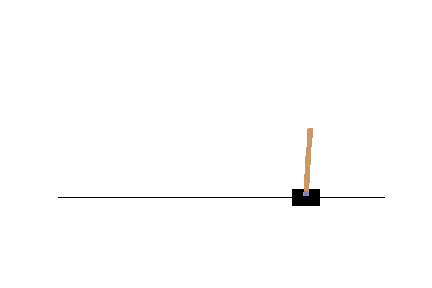
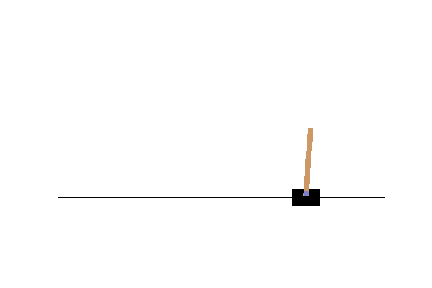
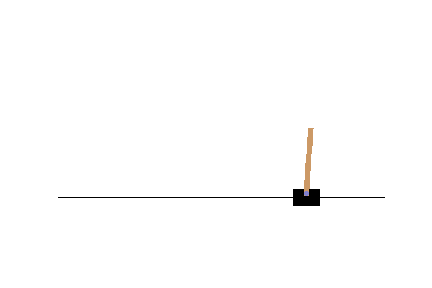
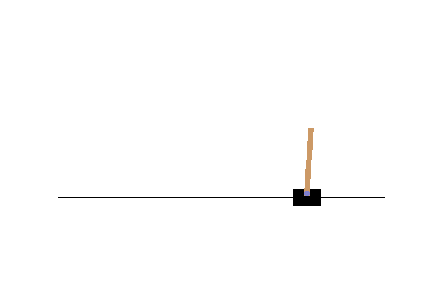
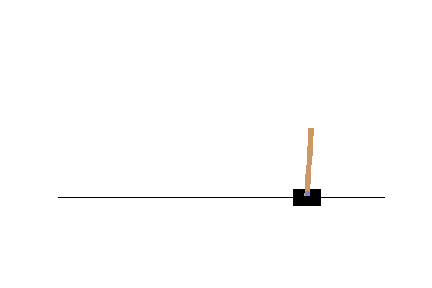
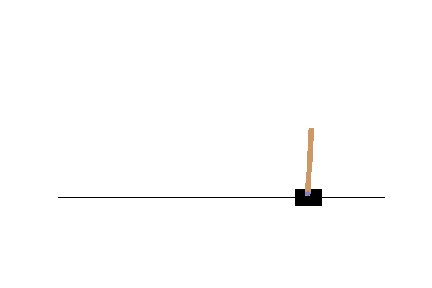
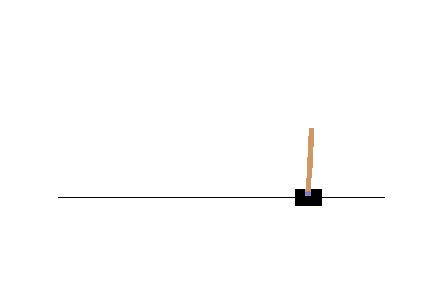
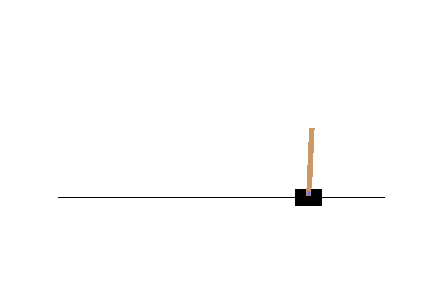
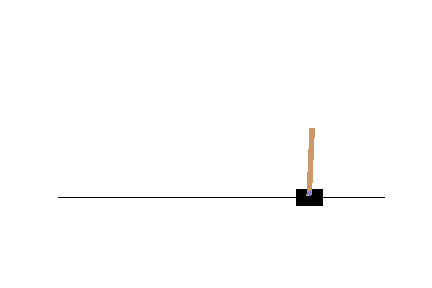
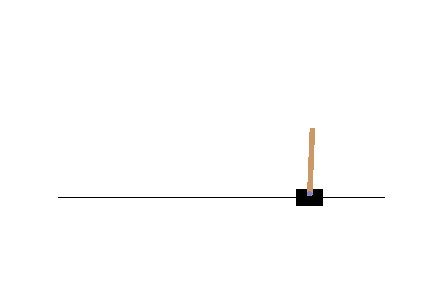
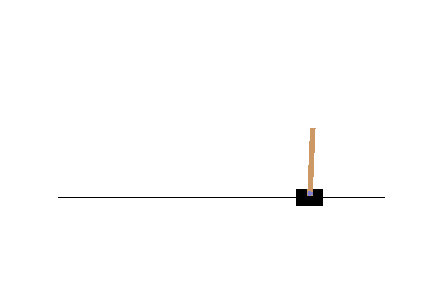
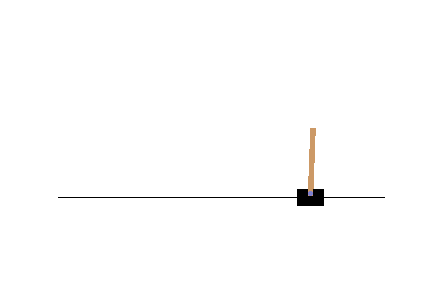
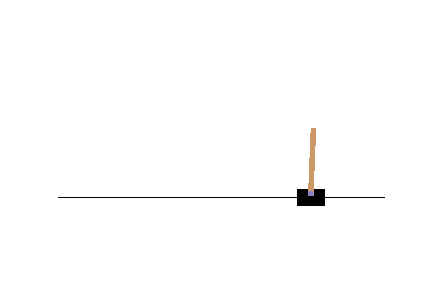
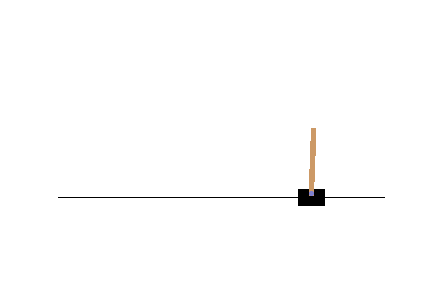
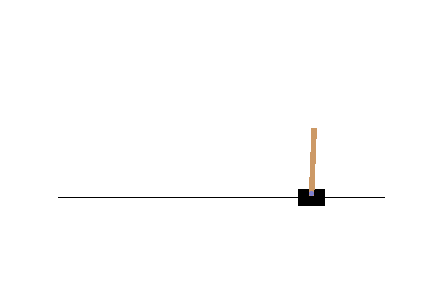
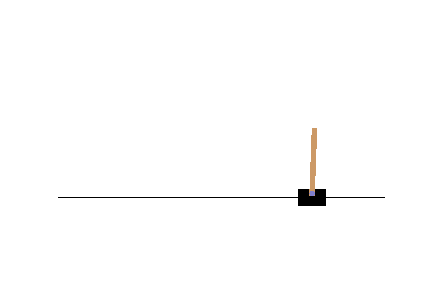
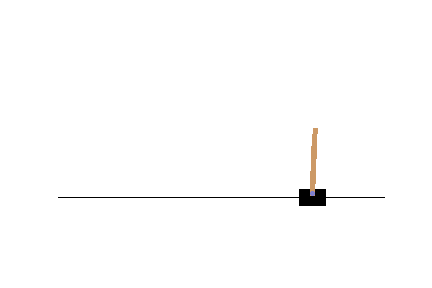
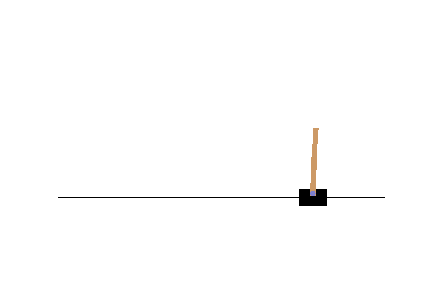
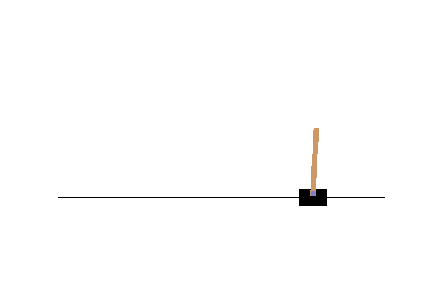
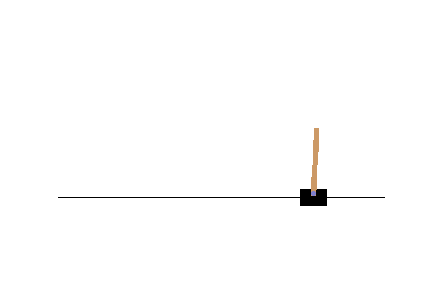
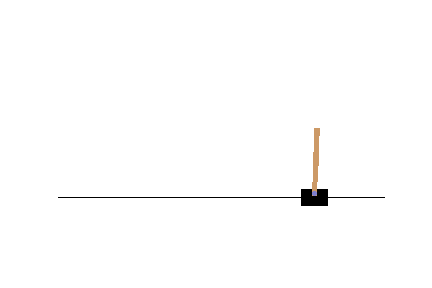
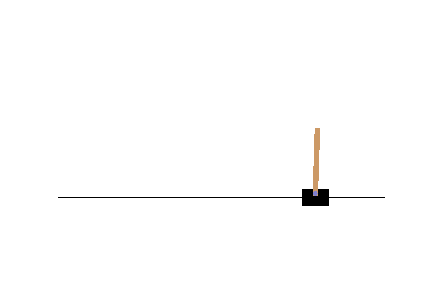
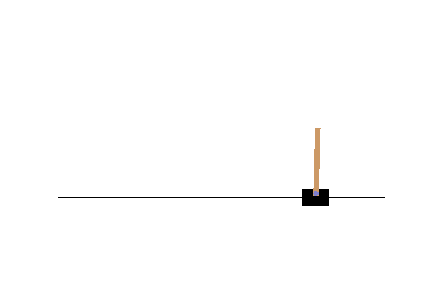
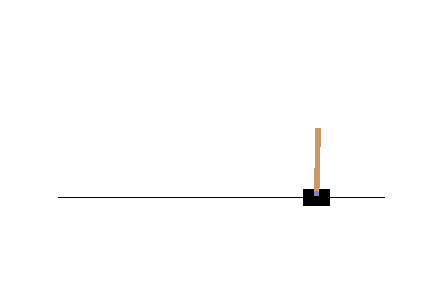
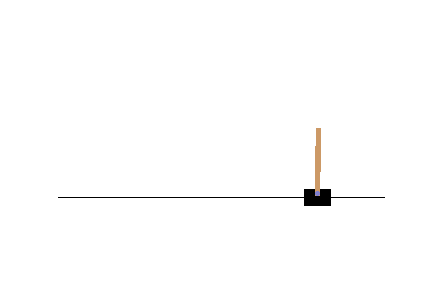
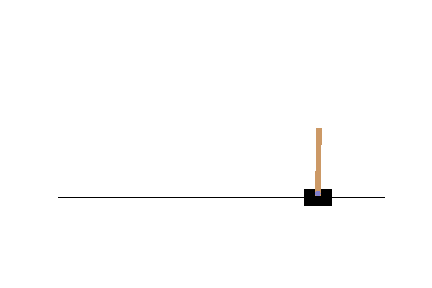
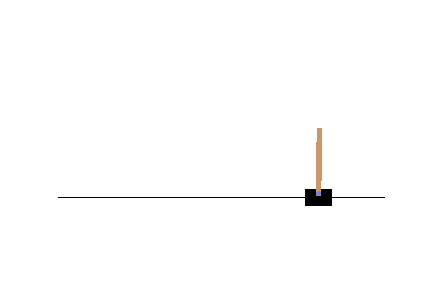
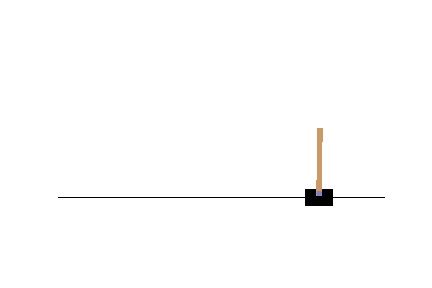
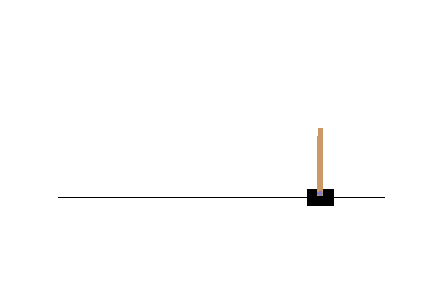
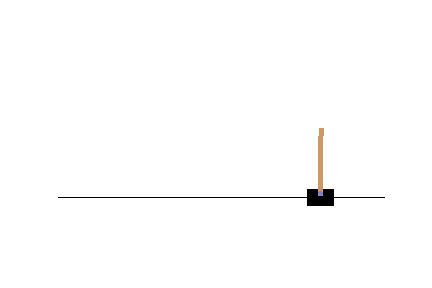
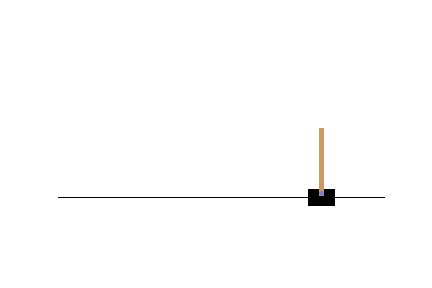
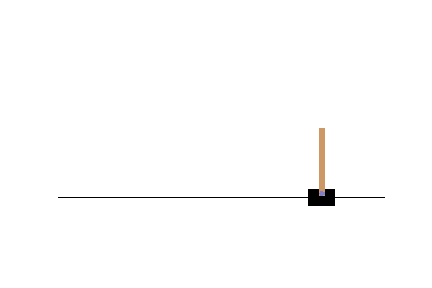
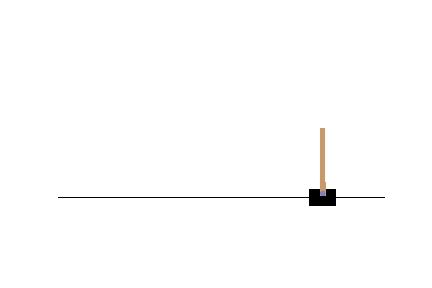
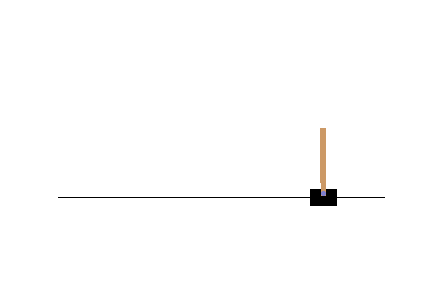
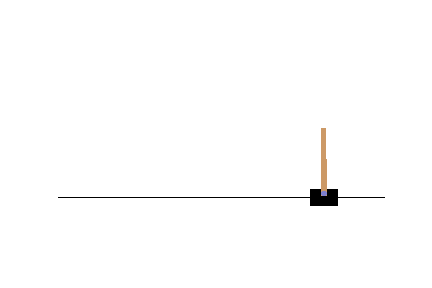
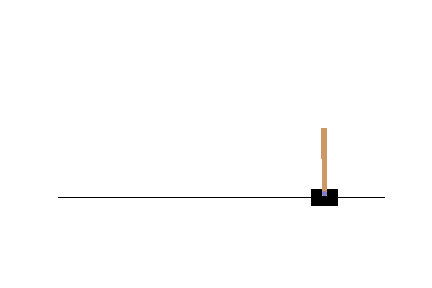
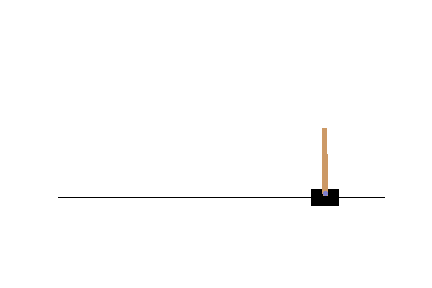
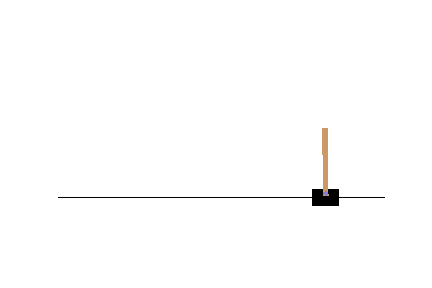
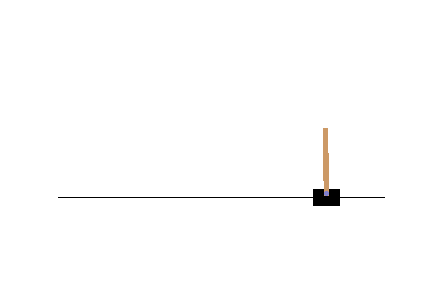
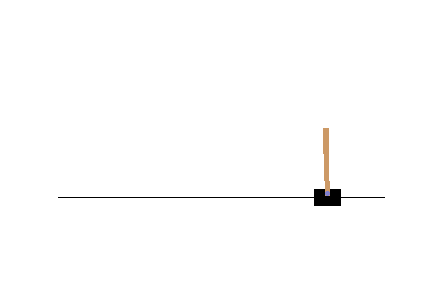
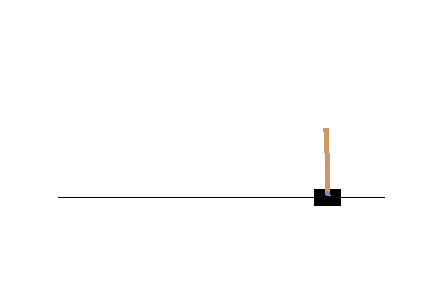
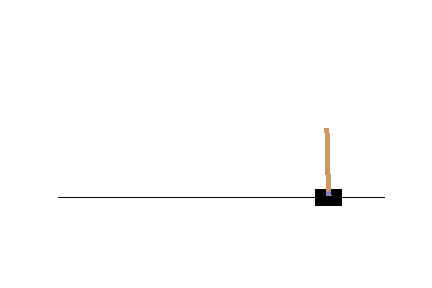
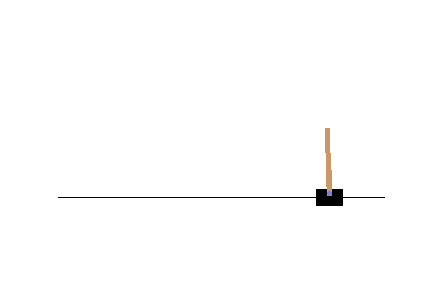
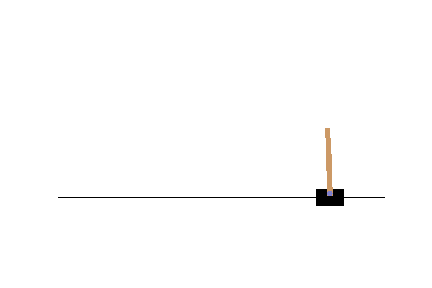
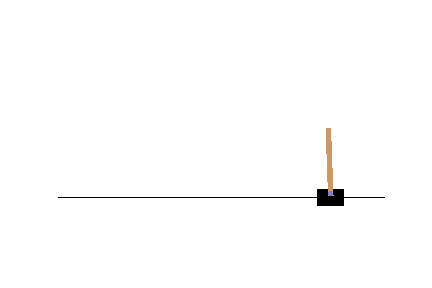
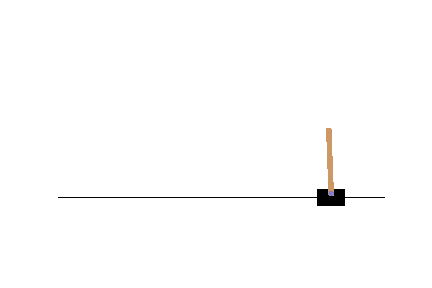
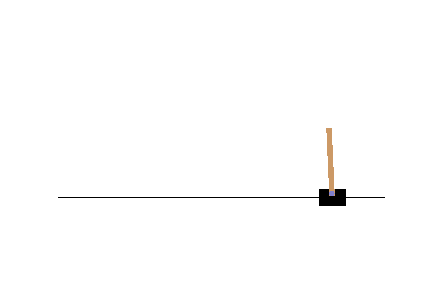
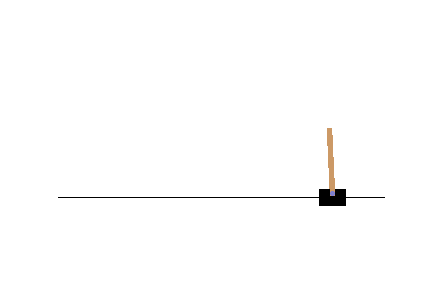
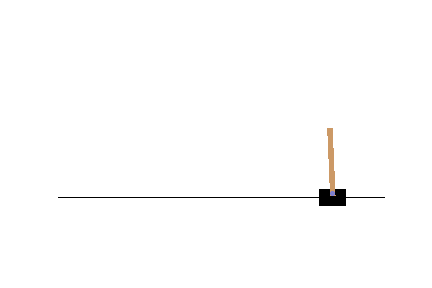
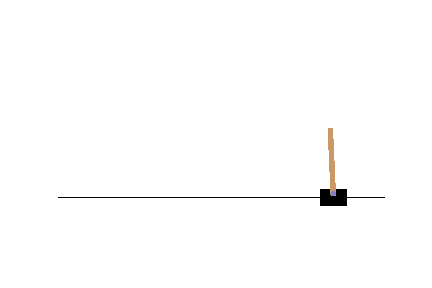
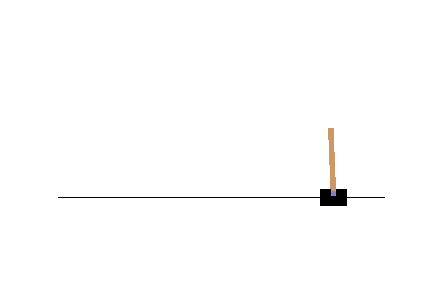
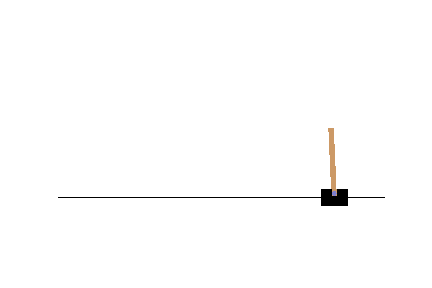
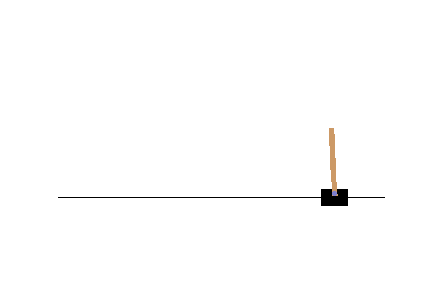
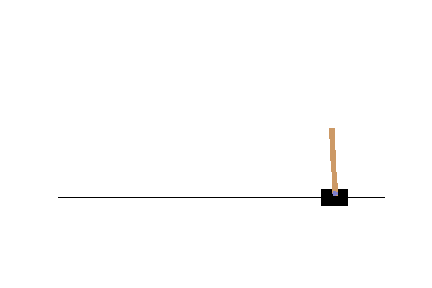
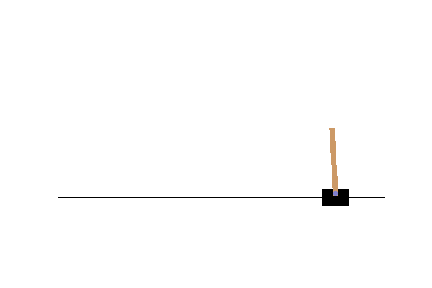
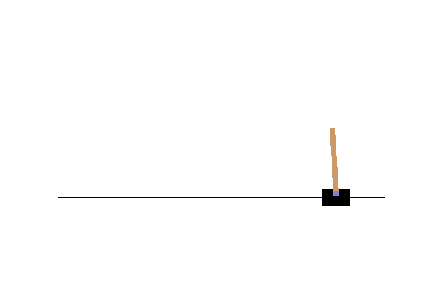
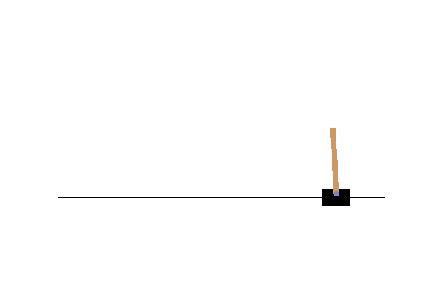
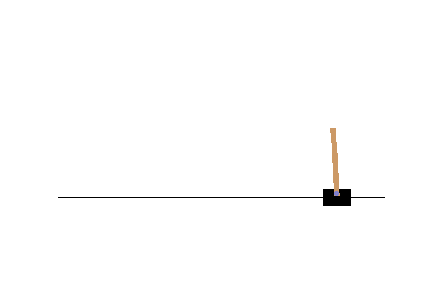
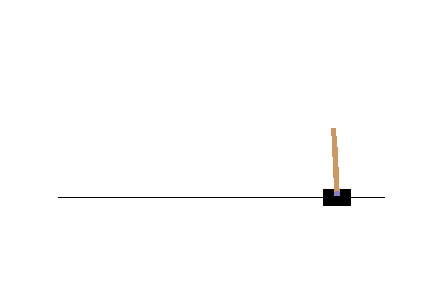
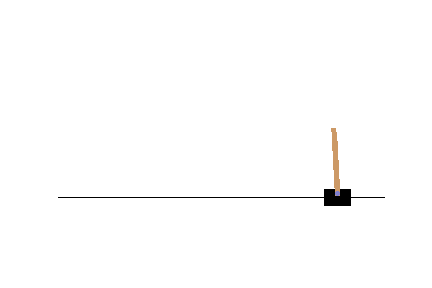
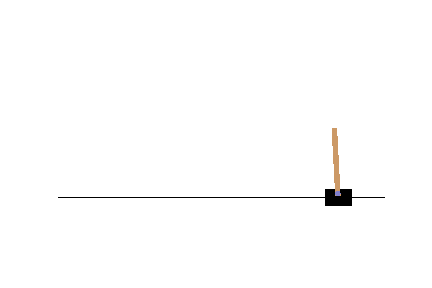
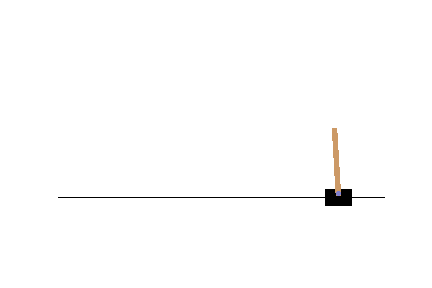
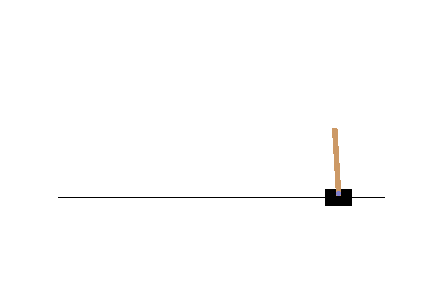
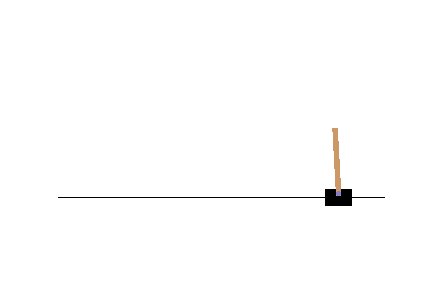
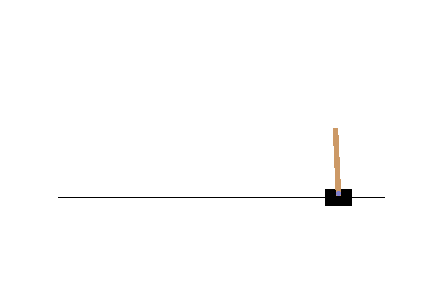
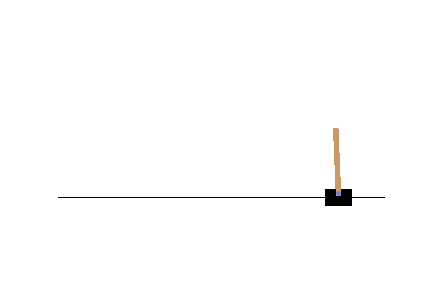
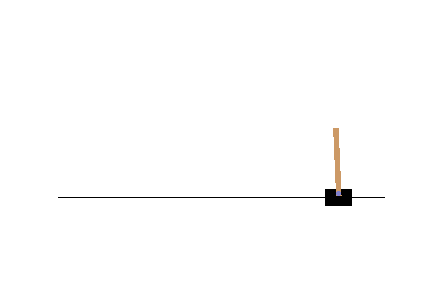
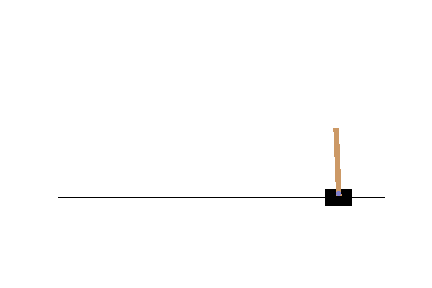
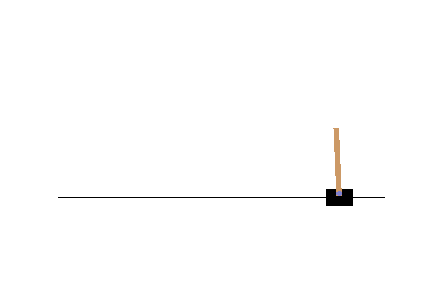
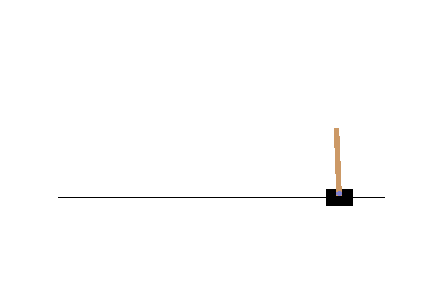
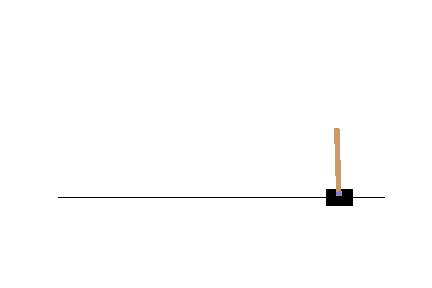
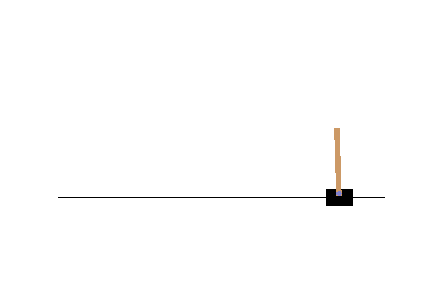
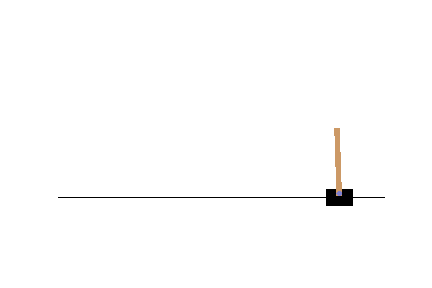
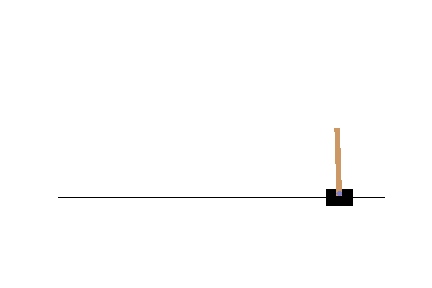
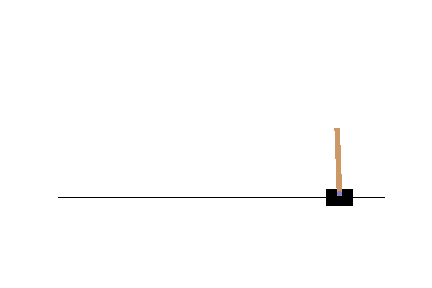
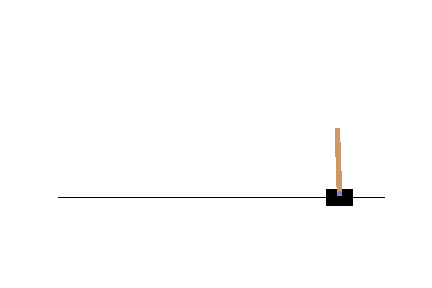
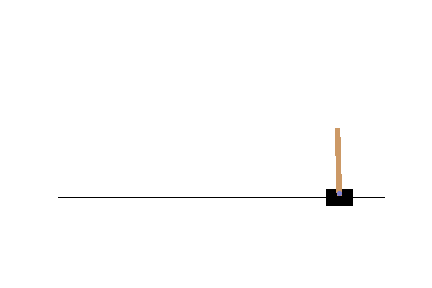
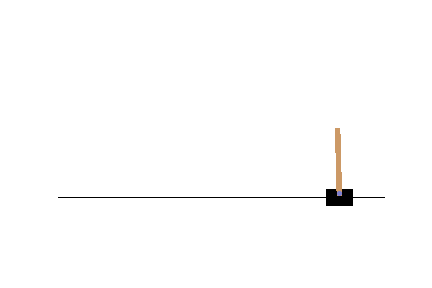
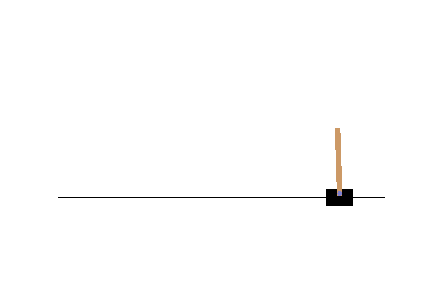
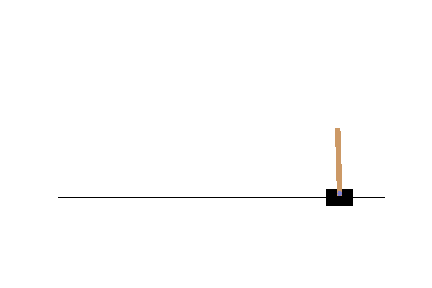
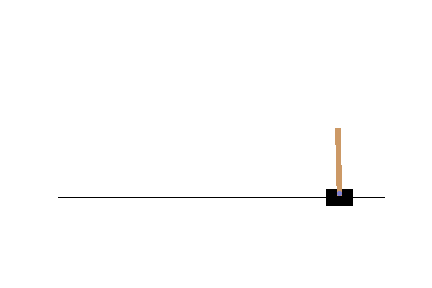
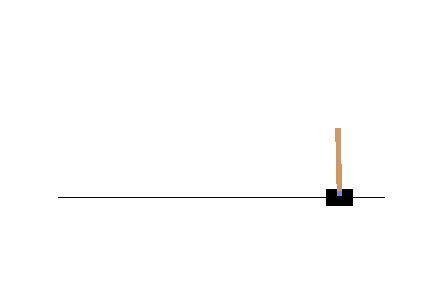
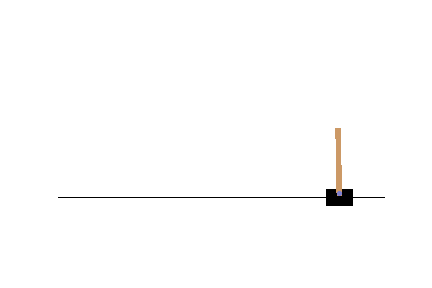
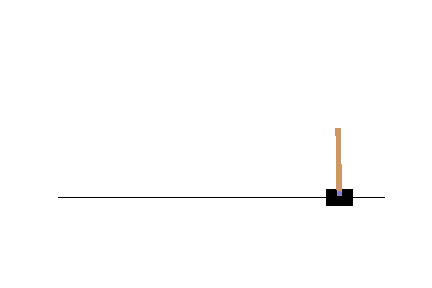
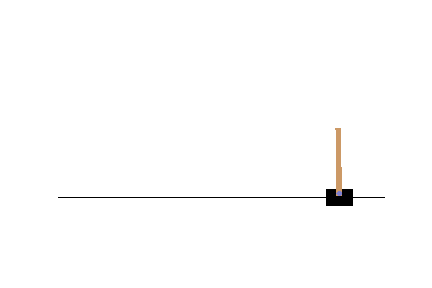
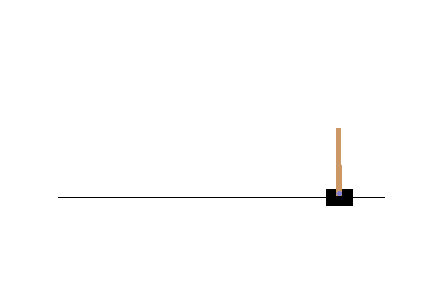
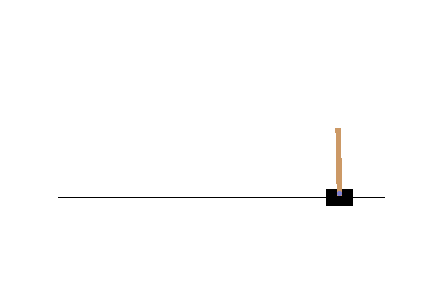
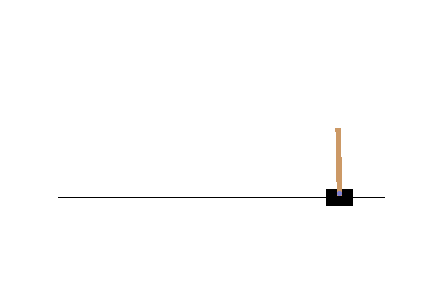
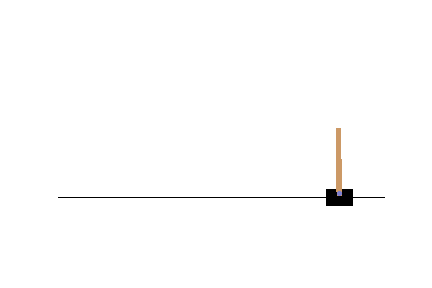
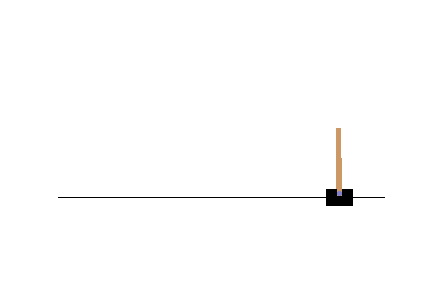
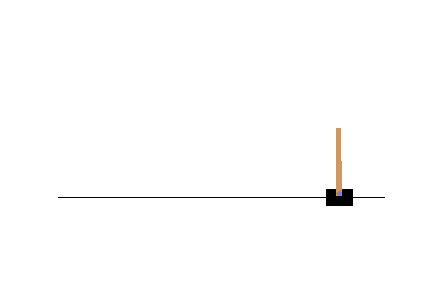
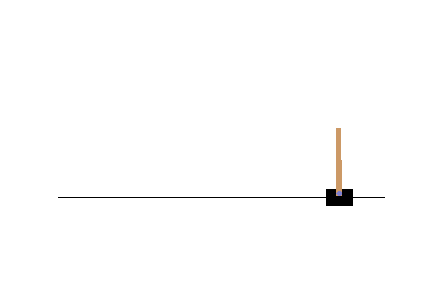
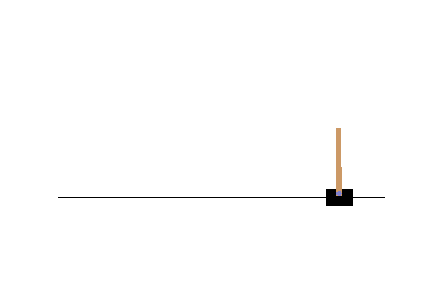
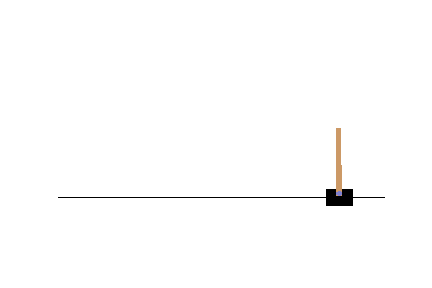
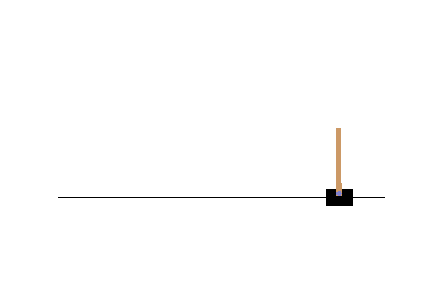
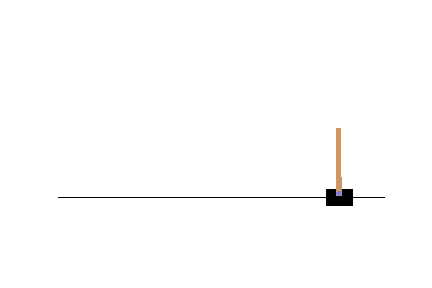
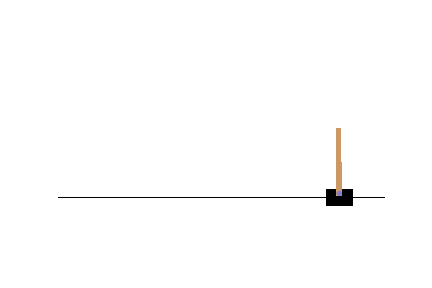
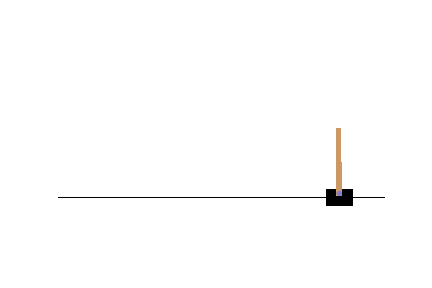
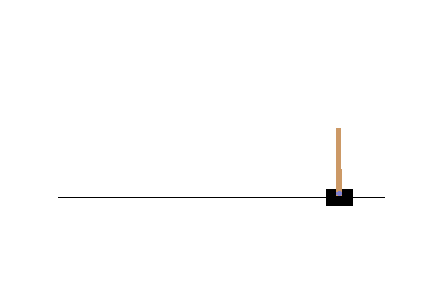
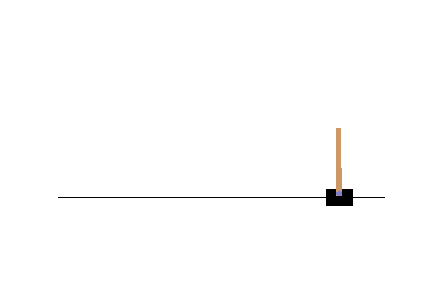
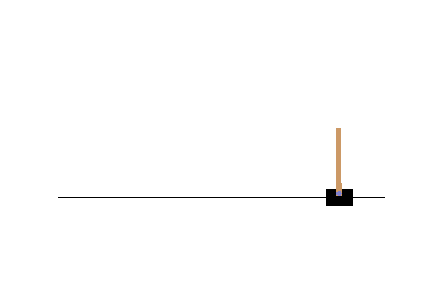
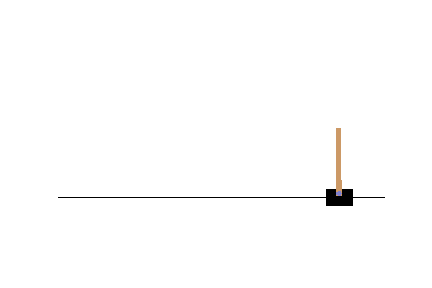
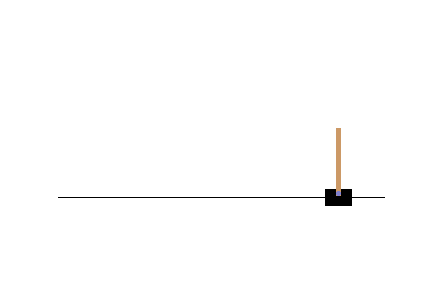
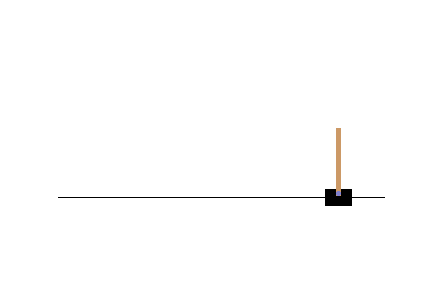
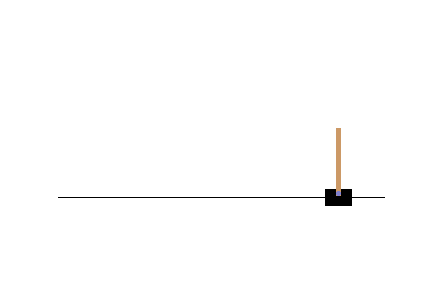
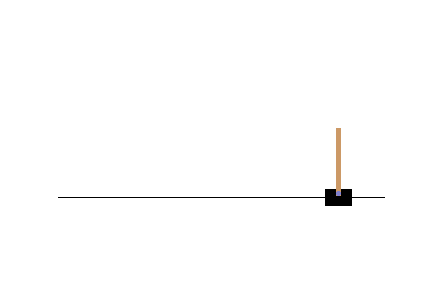
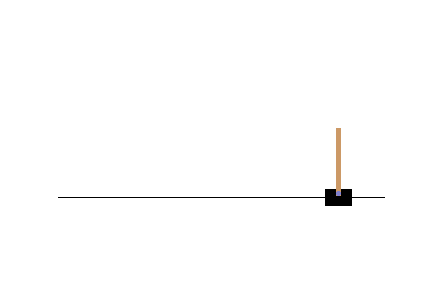
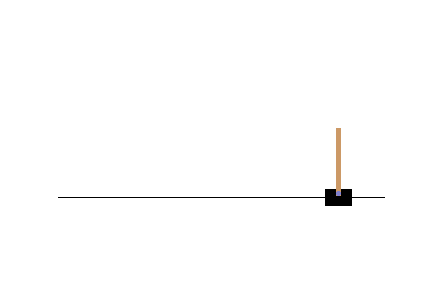
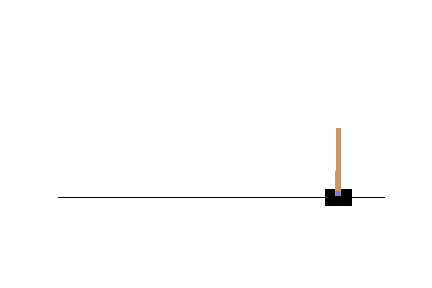
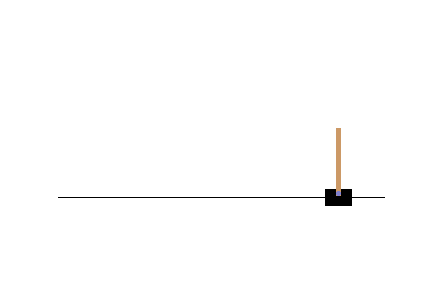
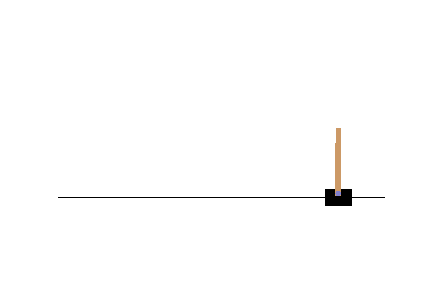
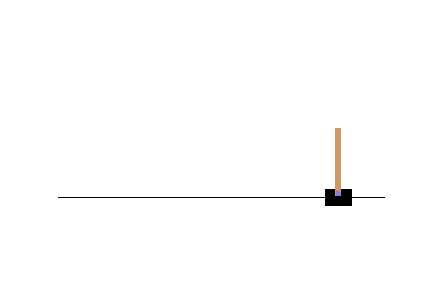
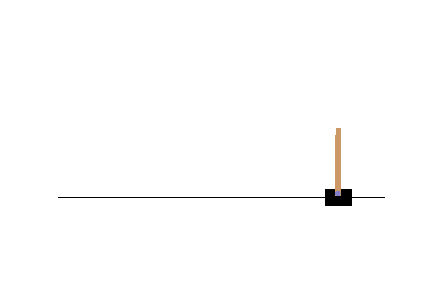
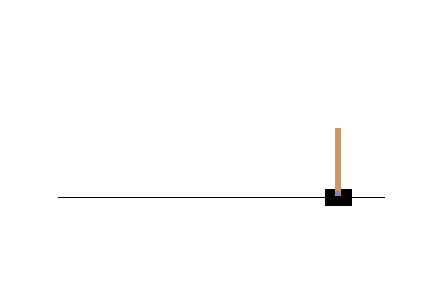
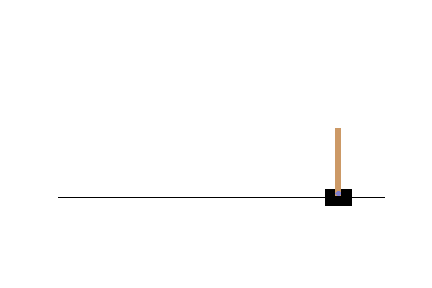
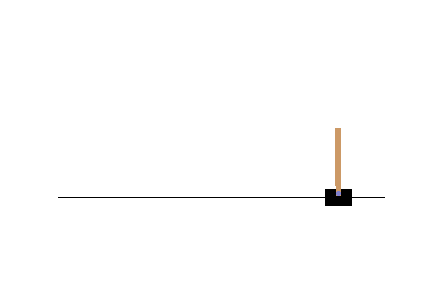
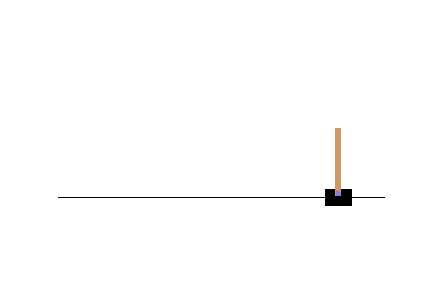
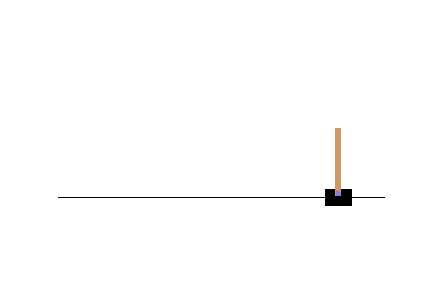
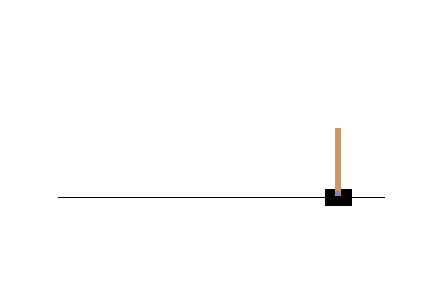
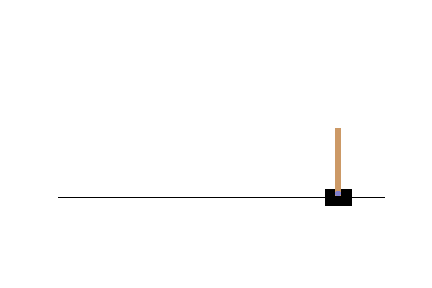
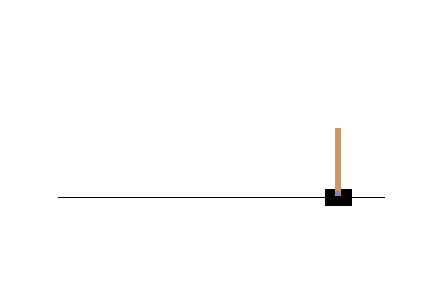
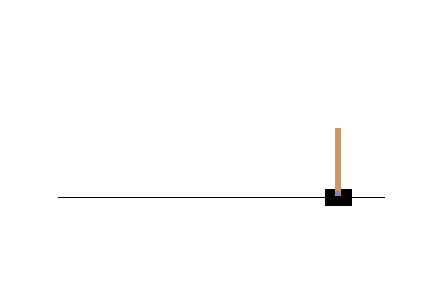
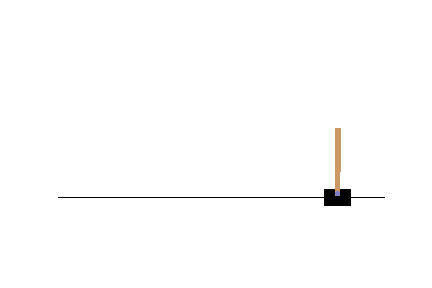
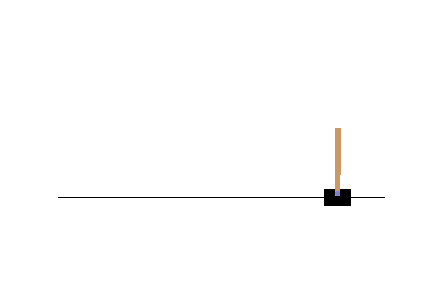
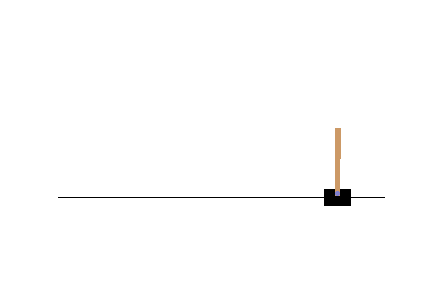
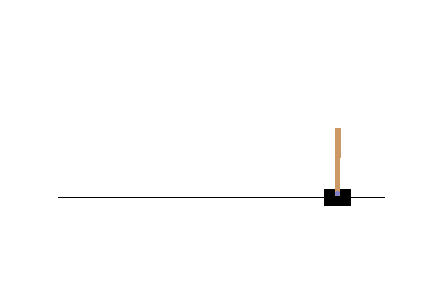
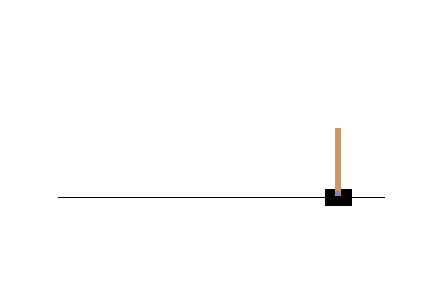
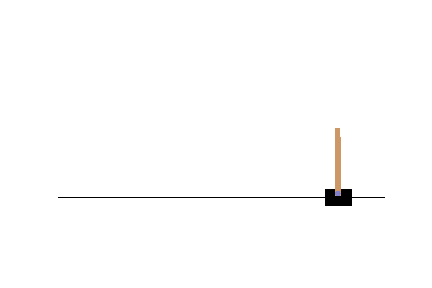
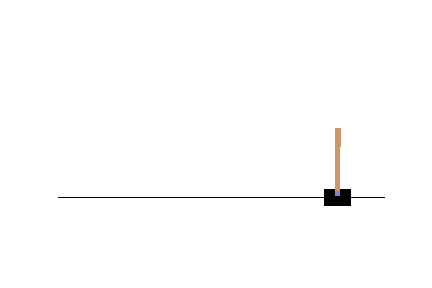
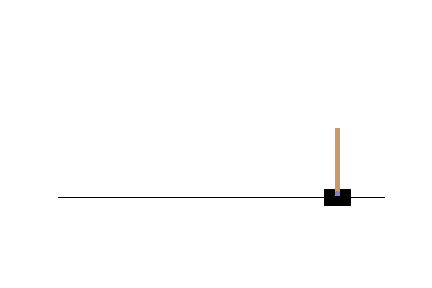
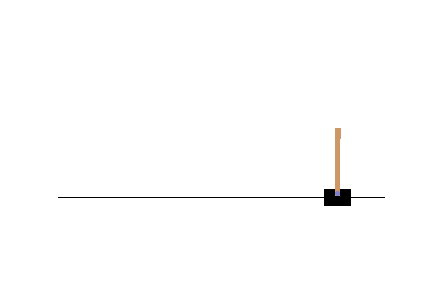
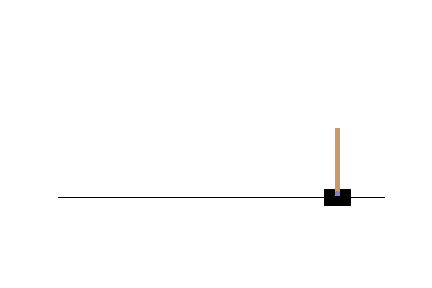
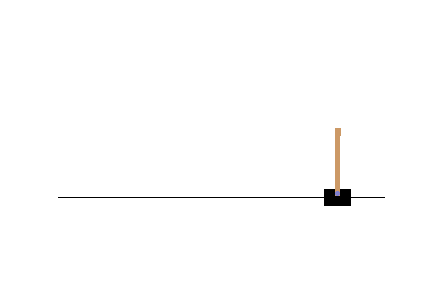
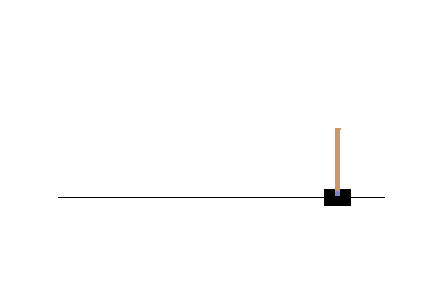
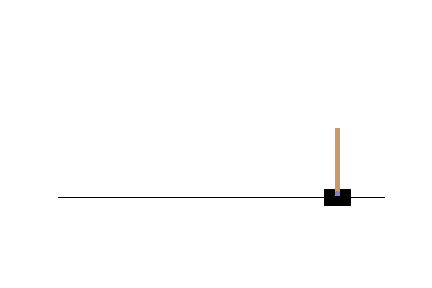
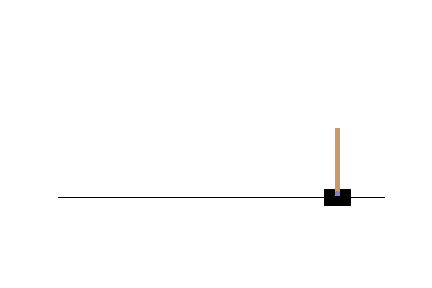
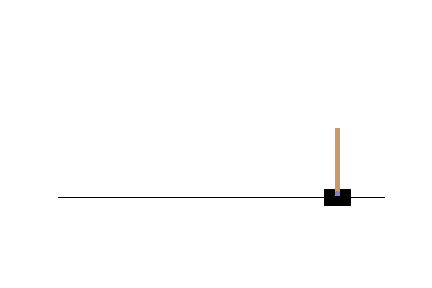
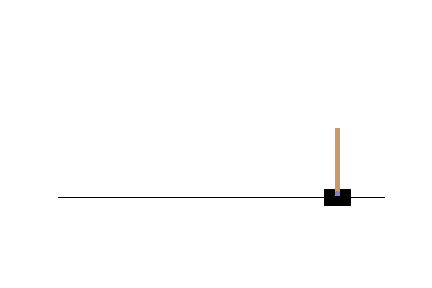
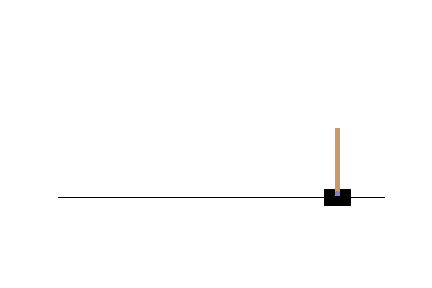
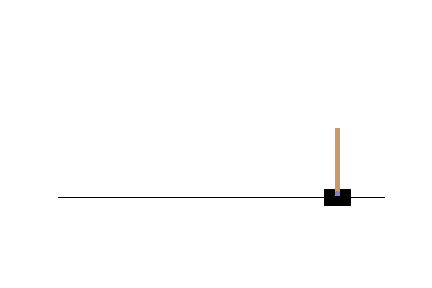
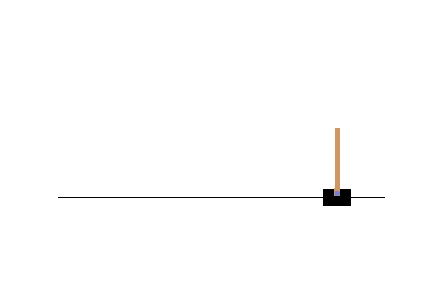
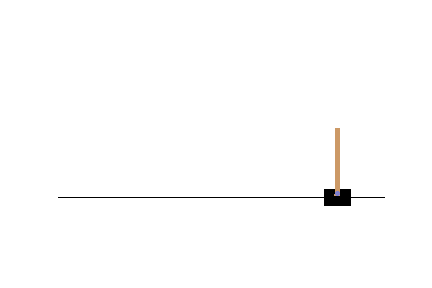
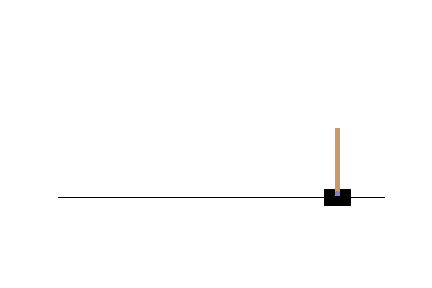
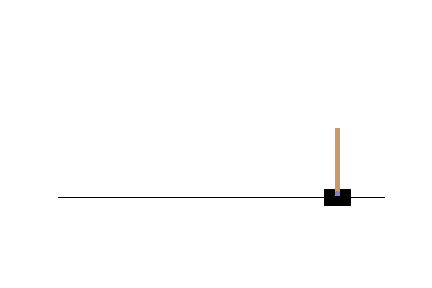
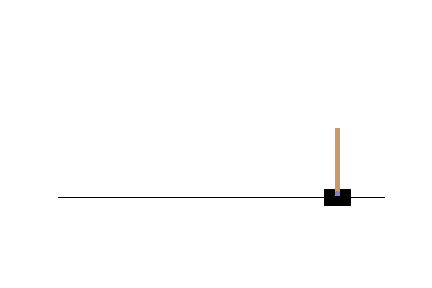
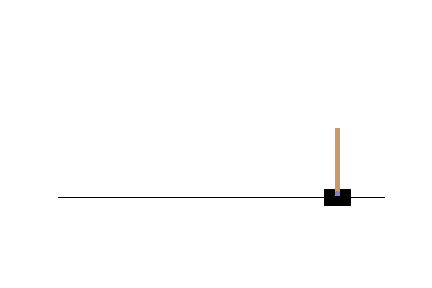
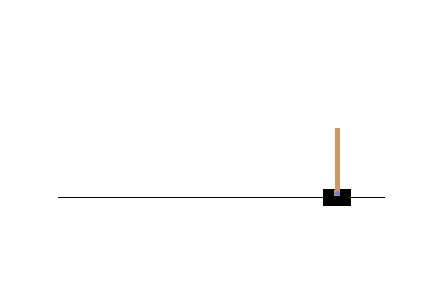
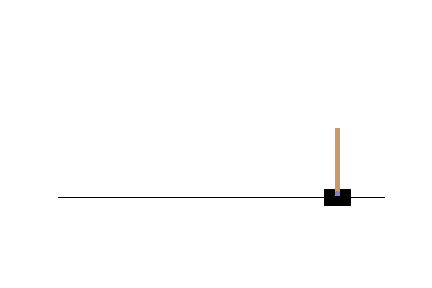
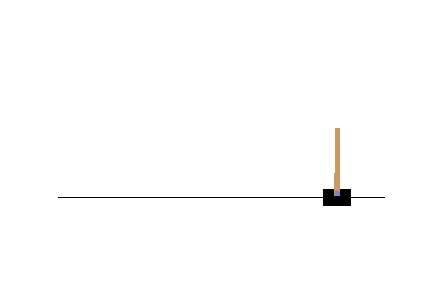
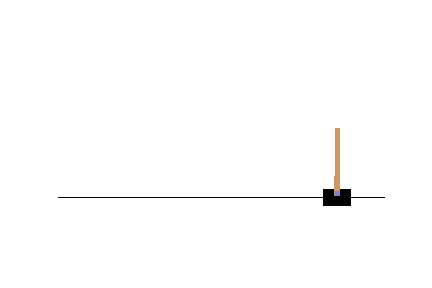
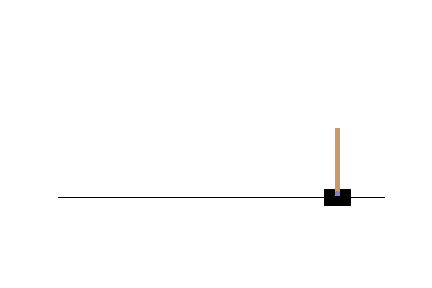
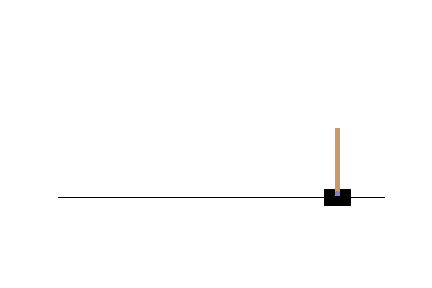
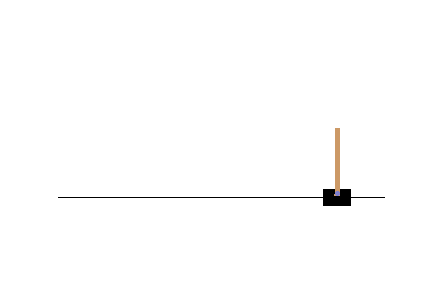
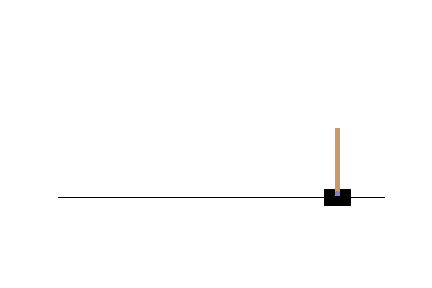
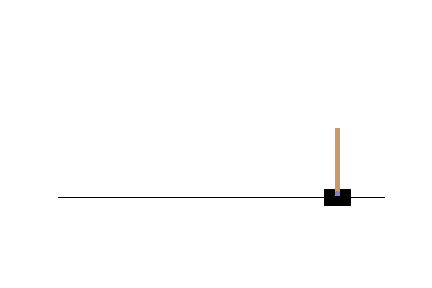
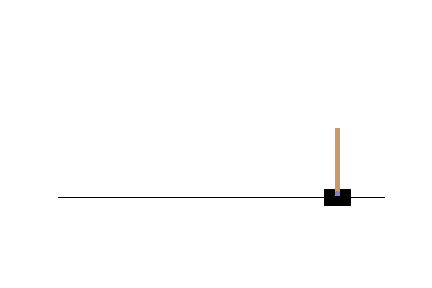
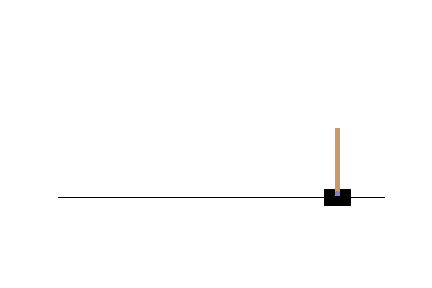
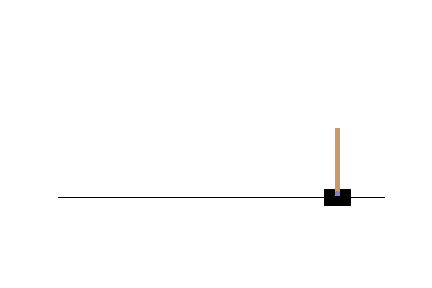
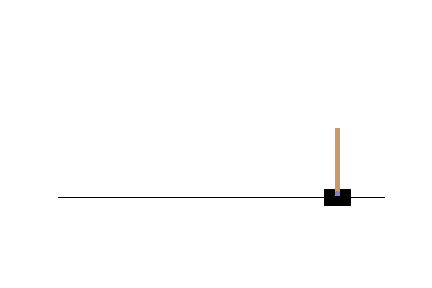
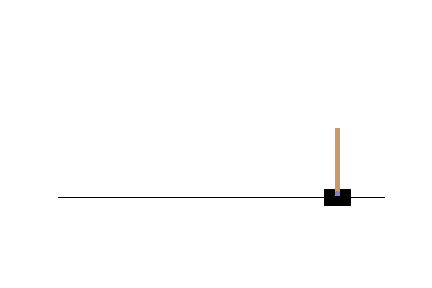
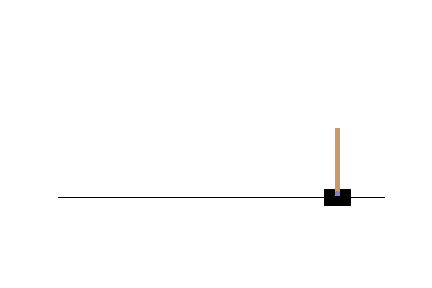
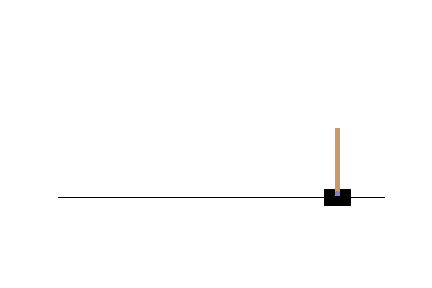
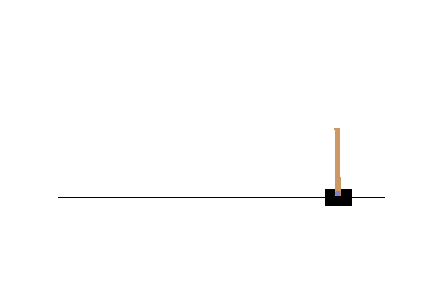
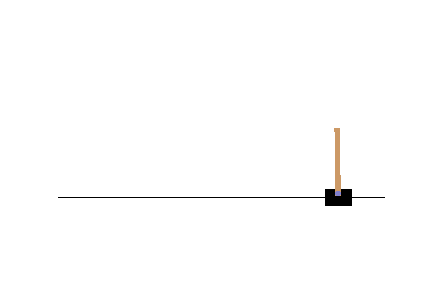
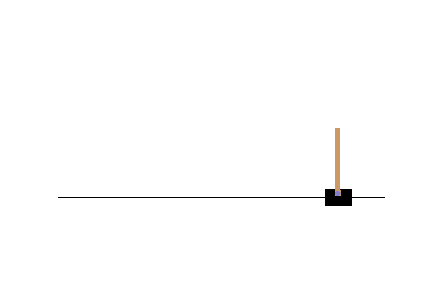
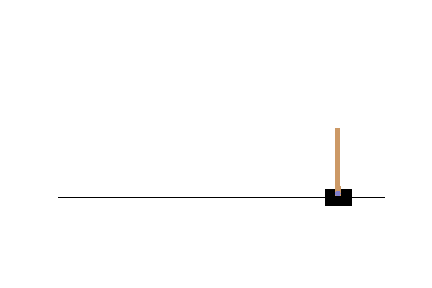
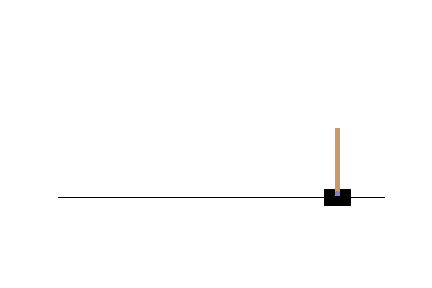
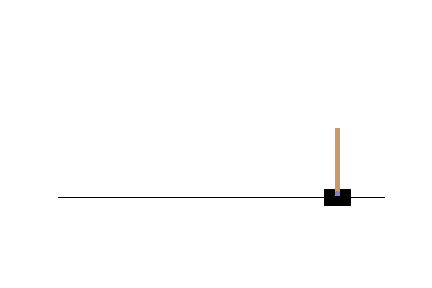
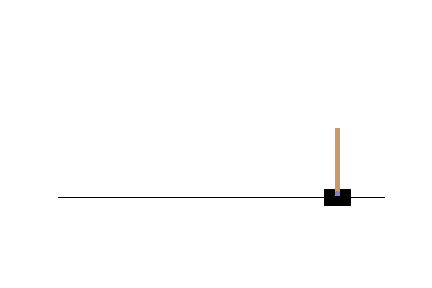
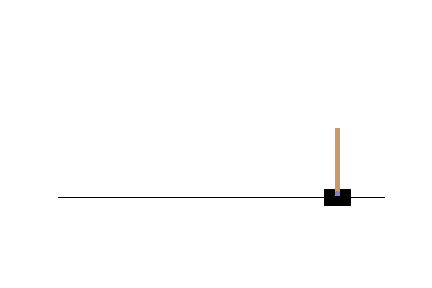
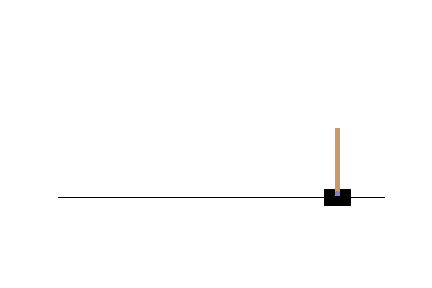
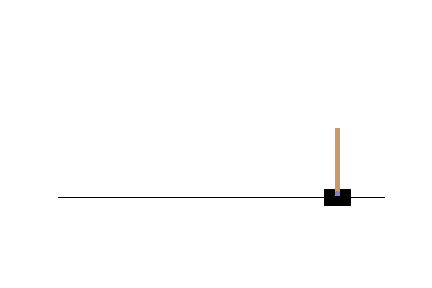
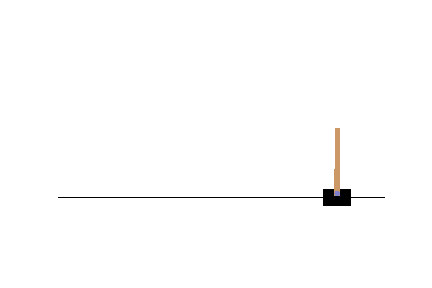
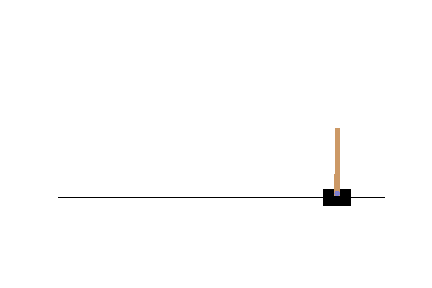
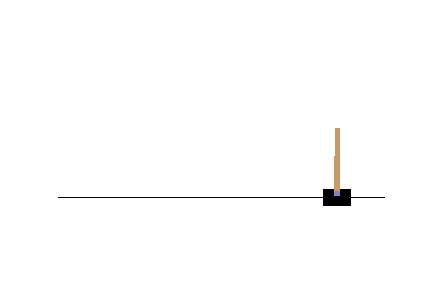
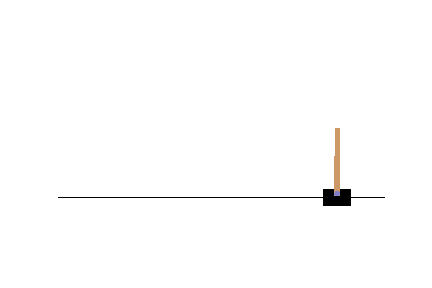
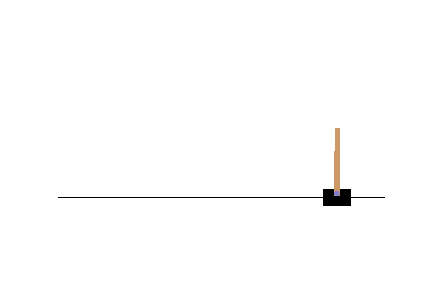
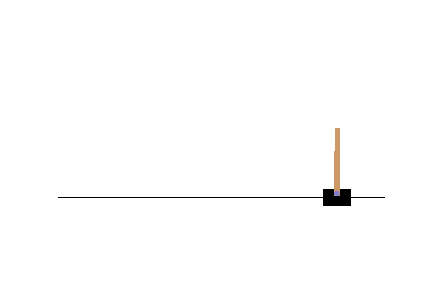
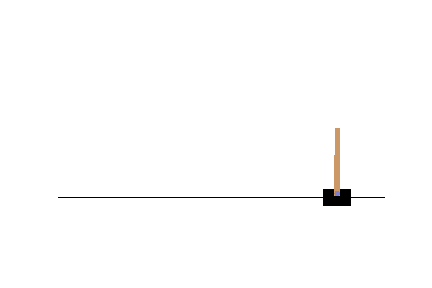
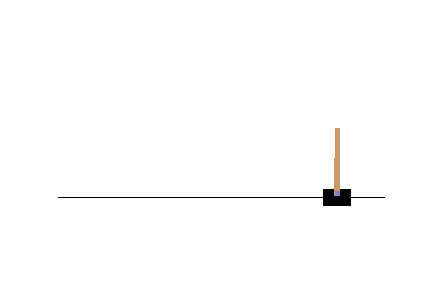
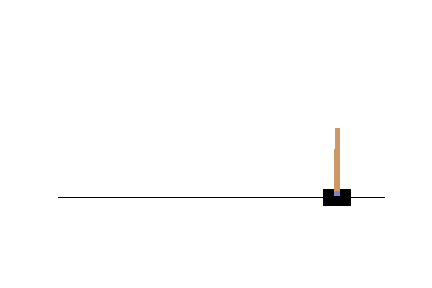
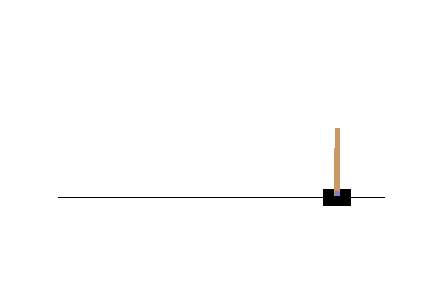
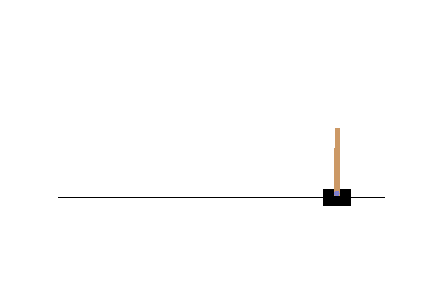
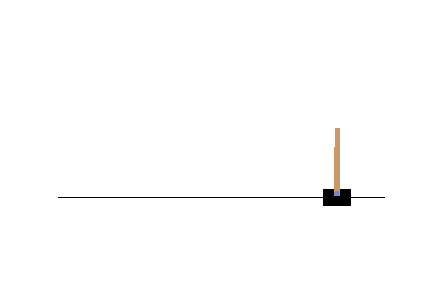
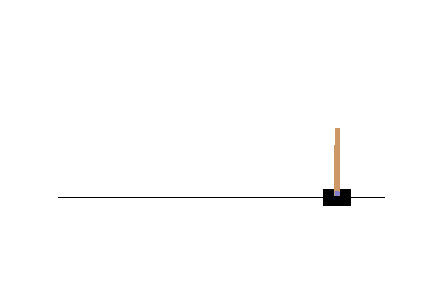
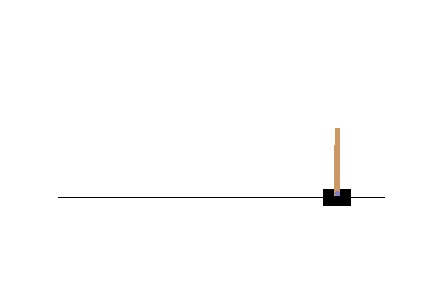
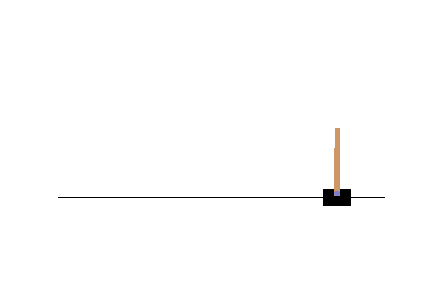
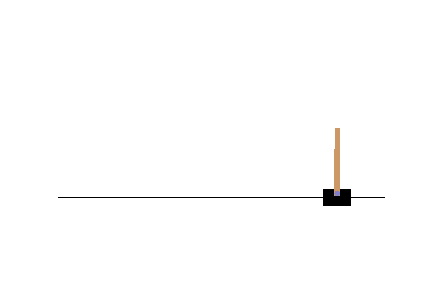
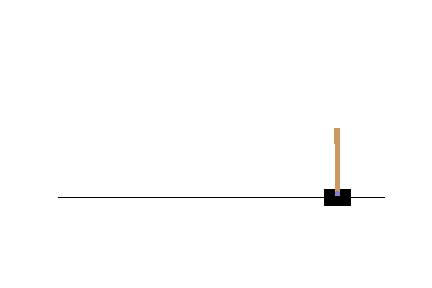
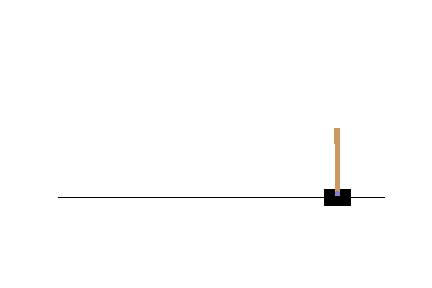
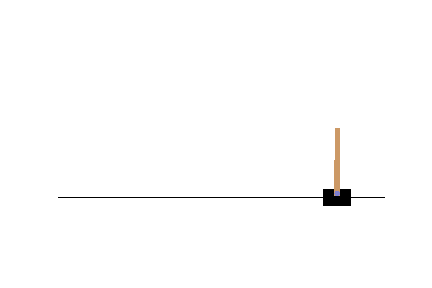
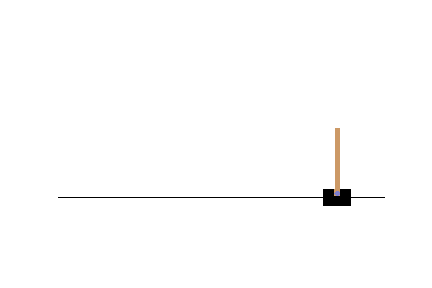
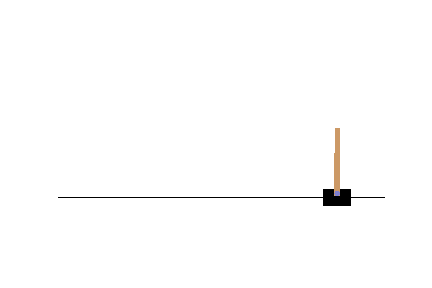
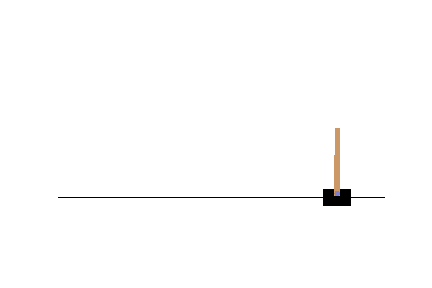
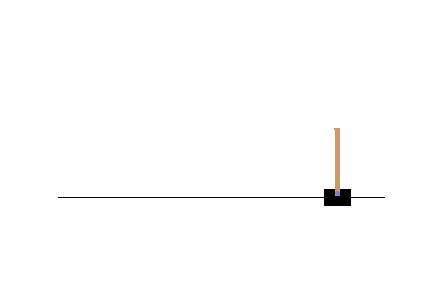
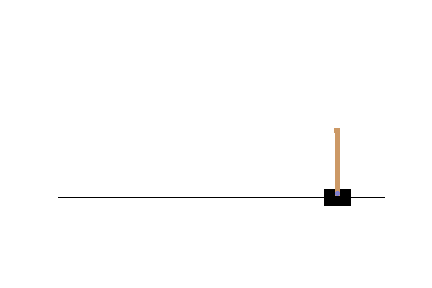
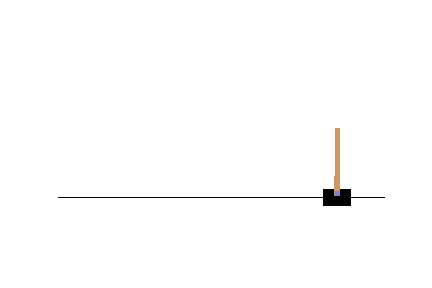
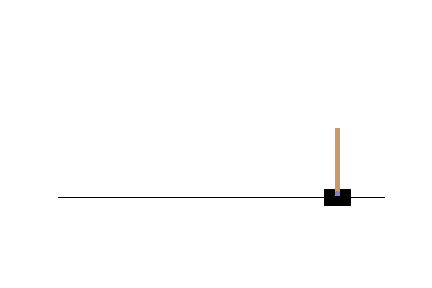
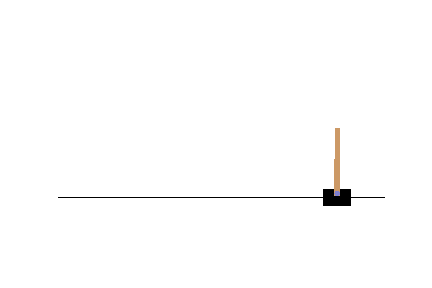
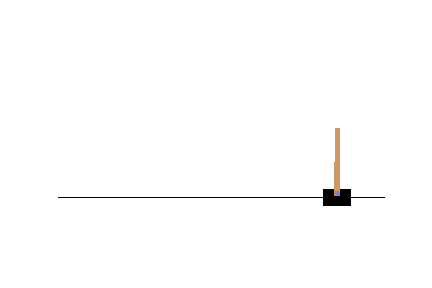
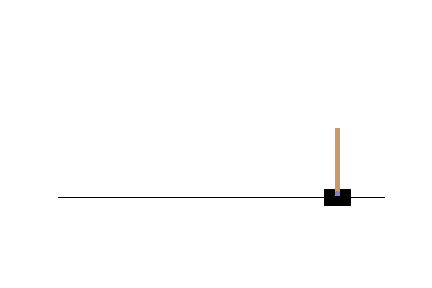
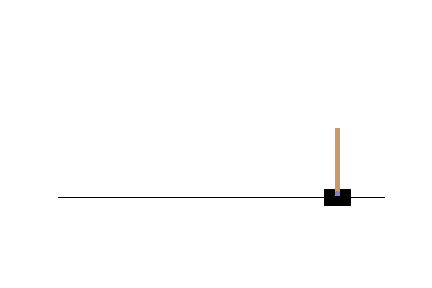
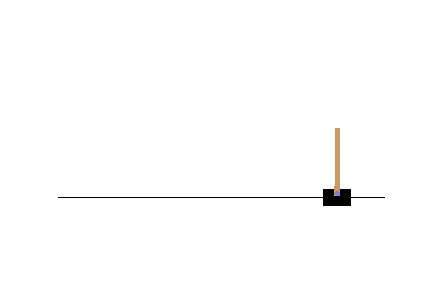
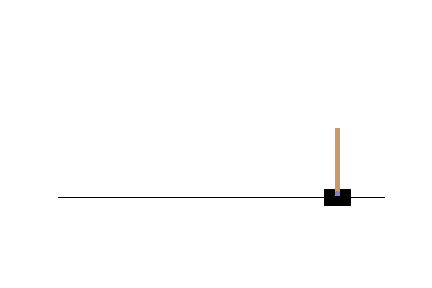
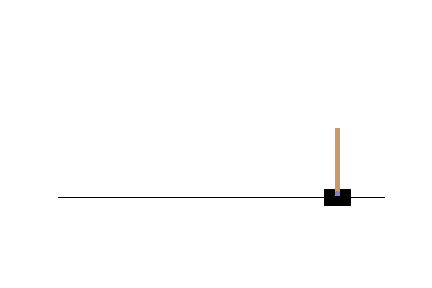
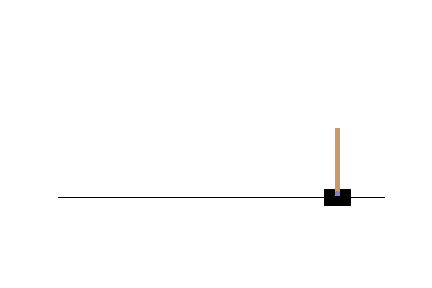
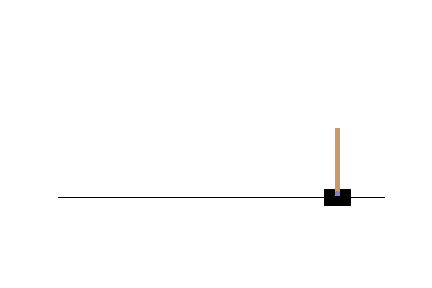
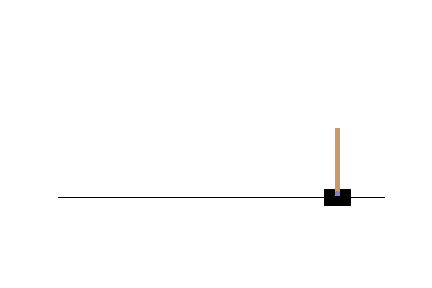
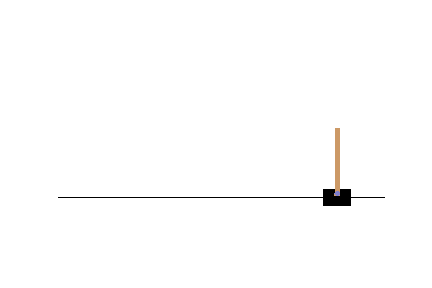
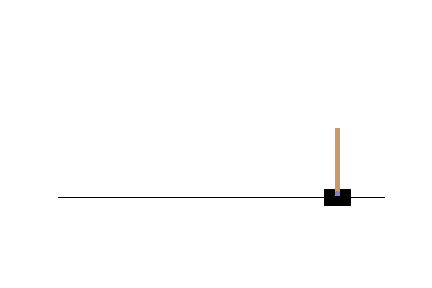
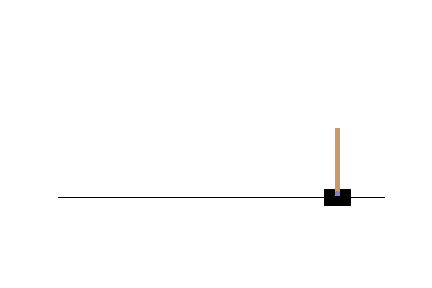
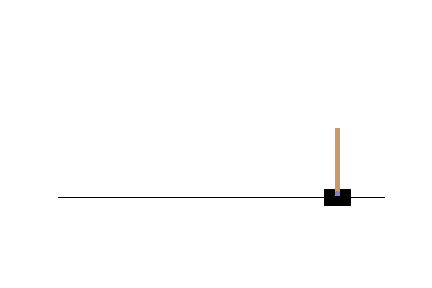
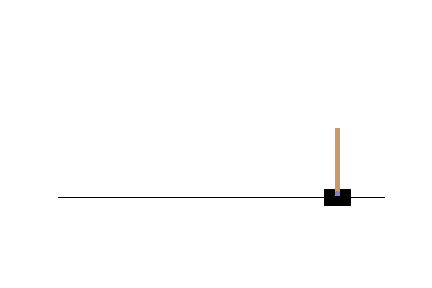
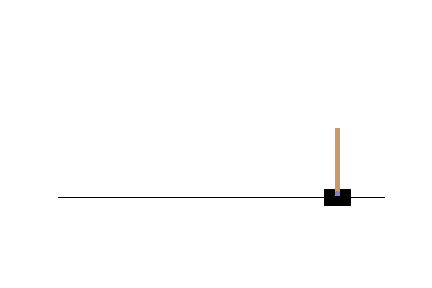
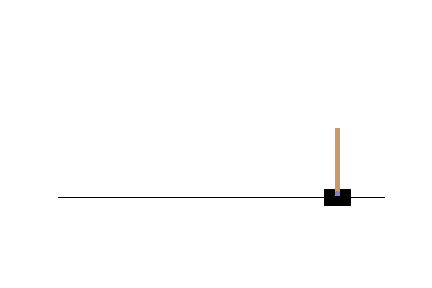
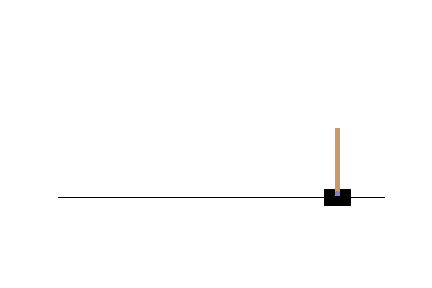
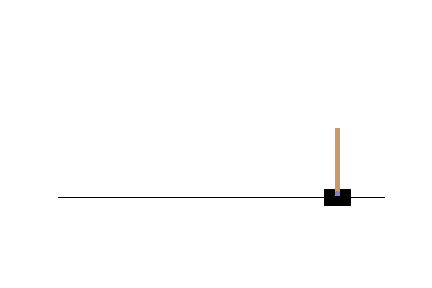
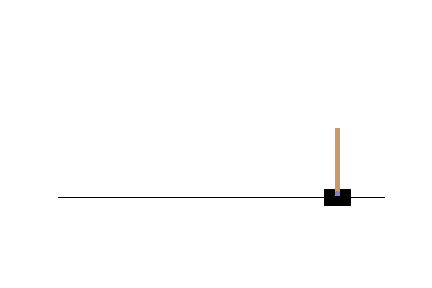
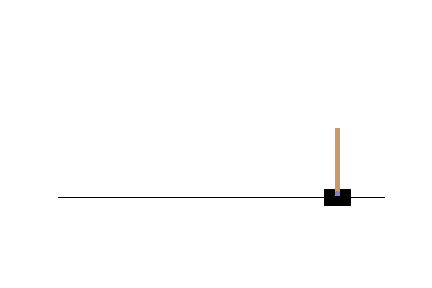
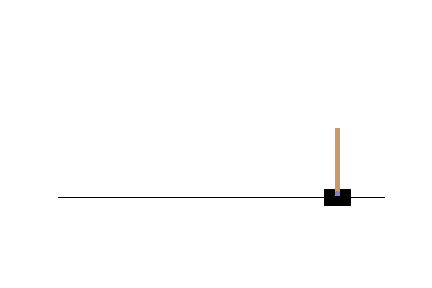
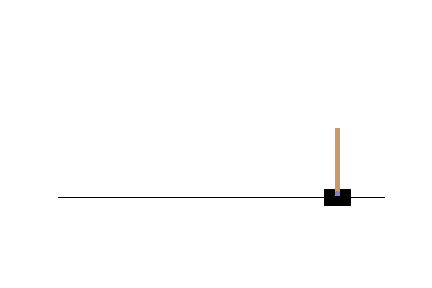
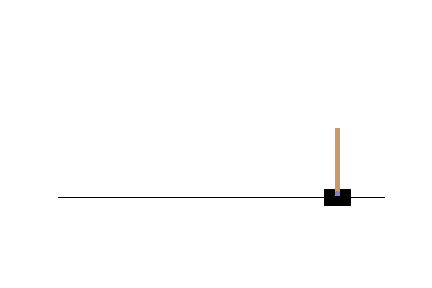
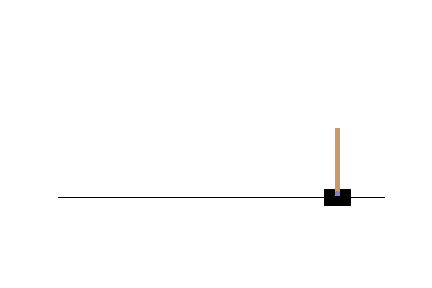
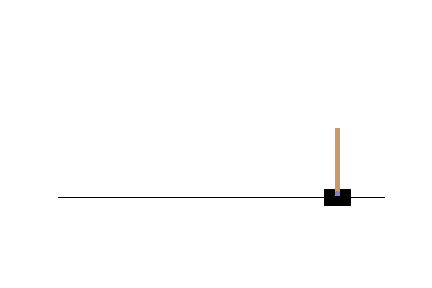
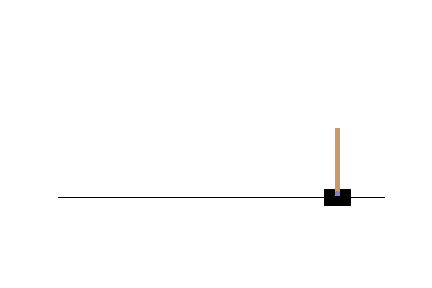
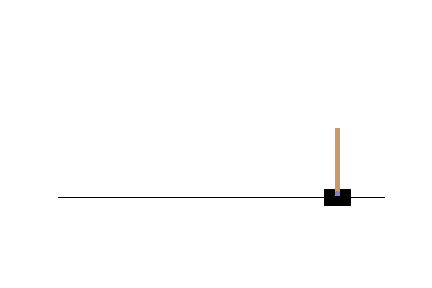
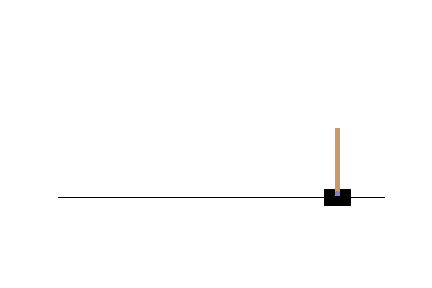
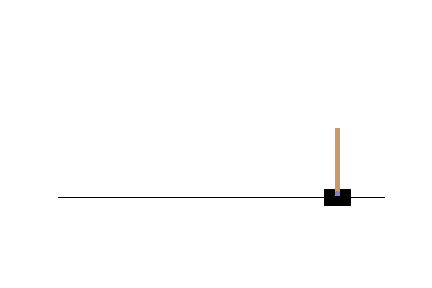
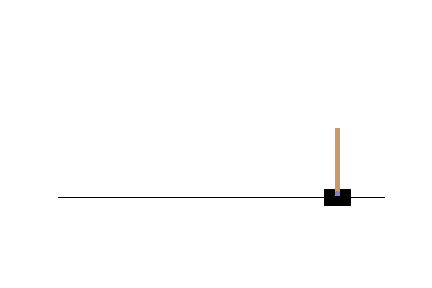
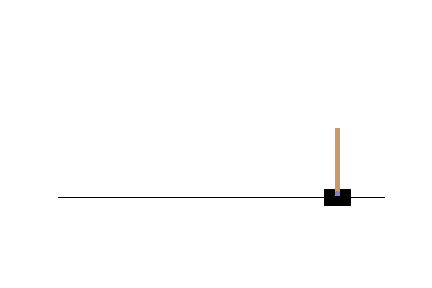
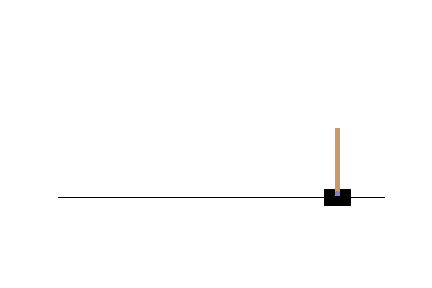
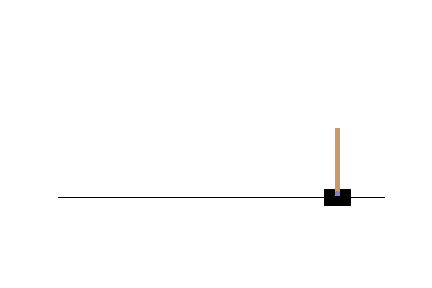
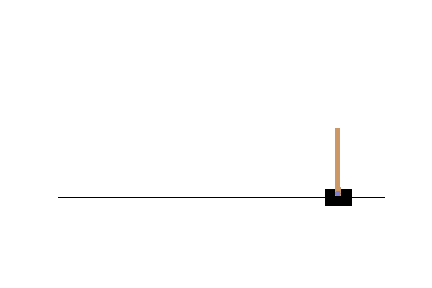
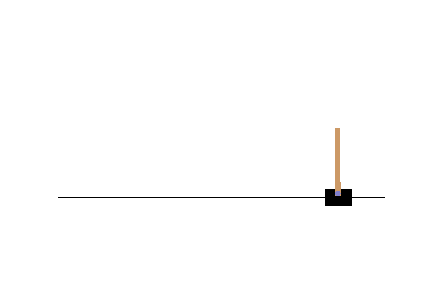
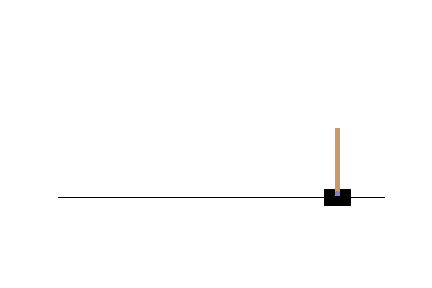
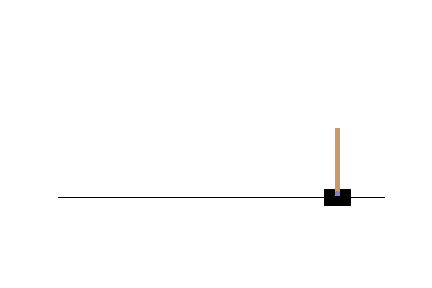
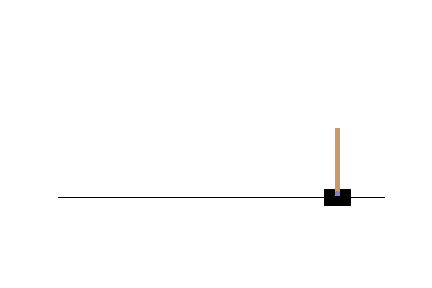
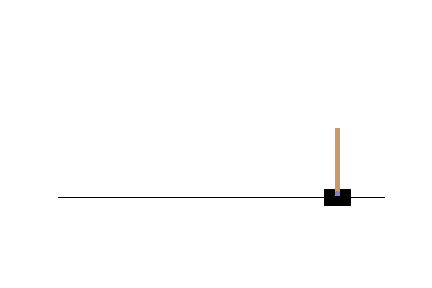
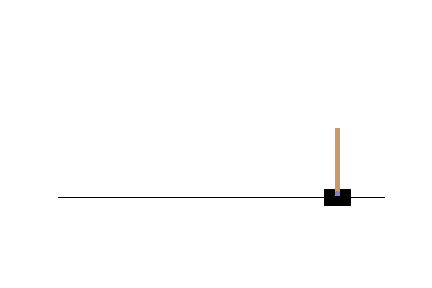
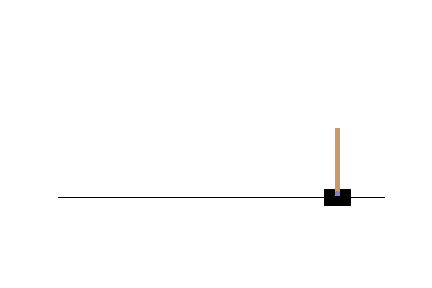
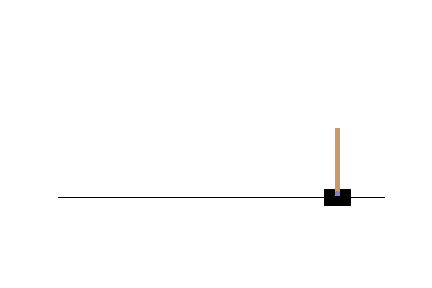
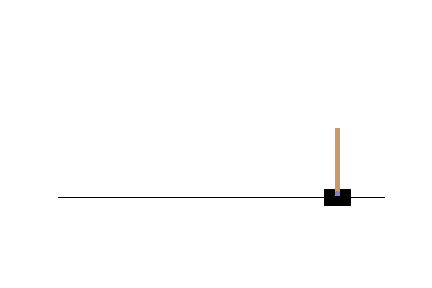

In [14]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)